In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
######
import math

import keras
from keras.models import Sequential
from keras.models import Model
from keras.models import load_model
from keras.layers import Input, Dense, Dropout, Activation
from keras.layers import Embedding, RepeatVector
from keras.layers.core import  Activation, Dropout  
from keras.callbacks import EarlyStopping
####
import optunity
from keras.layers.normalization import BatchNormalization
from mpl_toolkits.mplot3d import Axes3D

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

Using Theano backend.


In [73]:
def import_data():
    dataset = pd.read_csv('./Data/Data.csv',engine='python')
    return dataset

def mean_absolute_error(y_true, y_pred):
    return np.mean(np.absolute((y_true - y_pred)))


# Data visualisation

In order to properly visualise the Data and how each sample is distributed, I've applied the Principal Component Analysis (PCA) to reduce the data dimensionality from its original 328D to 3D only, then plot it into a 3D graph.


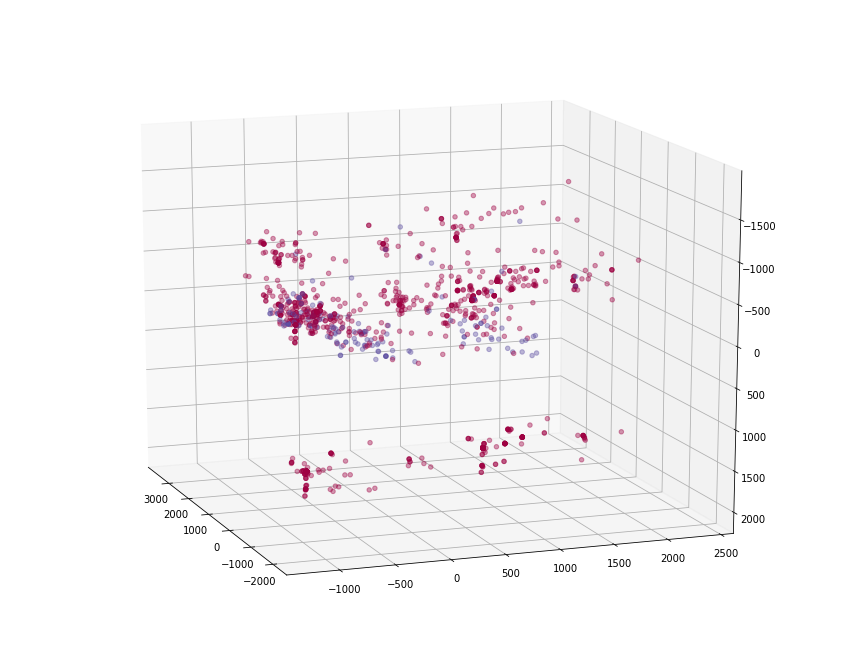

In [40]:
data = import_data()
Features = data.iloc[:,2:-1]
Classes = data['label']

features= np.array(Features)



pca= PCA(n_components=3)
pca.fit(features)
features_pca =  pca.transform(features)

# # pdClusters= pd.DataFrame(clusters,index=daydata.index)
# print(clusters)


fig = plt.figure(1, figsize=(12, 9))

ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=345, azim=200)


ax.scatter(features_pca[:,0],features_pca[:,1],features_pca[:,2],cmap=plt.cm.Spectral,c=Classes,alpha= 0.4)

plt.show()


# daydata['cluster']=clusters

In [41]:
Features.describe()

f0           f1           f2           f3           f4  \
count  1261.000000  1261.000000  1261.000000  1261.000000  1261.000000   
mean      0.067568     0.052604   892.326555   988.115707   998.414882   
std       0.075330     0.066394   309.805497   108.357520    39.786129   
min       0.000000     0.000000     0.097698     0.048138     0.223916   
25%       0.022222     0.001095  1000.000000  1000.000000  1000.000000   
50%       0.044728     0.023508  1000.000000  1000.000000  1000.000000   
75%       0.082973     0.079129  1000.000000  1000.000000  1000.000000   
max       0.868465     0.344100  1000.000000  1000.000000  1000.000000   

                f5           f6           f7           f8           f9  \
count  1261.000000  1261.000000  1261.000000  1261.000000  1261.000000   
mean    996.830627   997.628294   992.870630   984.149047   958.793689   
std      56.206103    48.586499    84.121025   124.910424   198.768566   
min       0.168476     0.051883     0.045973     0.042796     0.036605   
25%    1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
50%    1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
75%    1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
max    1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   

          ...         f326    f327    f328    f329    f330    f331    f332  \
count     ...       1261.0  1261.0  1261.0  1261.0  1261.0  1261.0  1261.0   
mean      ...       1000.0  1000.0  1000.0  1000.0  1000.0  1000.0  1000.0   
std       ...          0.0     0.0     0.0     0.0     0.0     0.0     0.0   
min       ...       1000.0  1000.0  1000.0  1000.0  1000.0  1000.0  1000.0   
25%       ...       1000.0  1000.0  1000.0  1000.0  1000.0  1000.0  1000.0   
50%       ...       1000.0  1000.0  1000.0  1000.0  1000.0  1000.0  1000.0   
75%       ...       1000.0  1000.0  1000.0  1000.0  1000.0  1000.0  1000.0   
max       ...       1000.0  1000.0  1000.0  1000.0  1000.0  1000.0  1000.0   

              f333         f334         f335  
count  1261.000000  1261.000000  1261.000000  
mean      4.216853     4.634139     4.425190  
std      62.853627    62.827339    62.840506  
min       0.000000     0.021659     0.011911  
25%       0.058426     0.487398     0.253183  
50%       0.163563     0.732707     0.453530  
75%       0.420822     0.874719     0.674835  
max    1000.000000  1000.000000  1000.000000  

[8 rows x 336 columns]

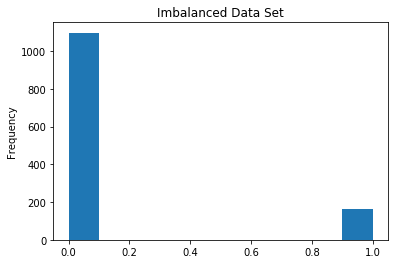

In [85]:
Classes.plot(kind='hist')
plt.title('Imbalanced Data Set')
plt.show()

# Data preparation

Since I'm using Artificial Neural Networks (ANN) for the classification modeling, in order to achieve a better calculation of network weights, using an appropriate approach to normalize the provided data is critical before feeding it to ANN models. As all the models are designed to use the Sigmoid as activation function, the inputs data are normalized to an interval between [0,1].

In the case of adopting and developing ANN, three separate datasets should be prepared.
    - One for test, to assess the model's performance (20%).
    - the rest is split between training and validation (80% and 20% respectively), where the training dataset is used to adjust the model's parameters, and the validation set is used to avoid falling in the overfitting phenomenon.

As we can see in the above plot, the dataset is composed of more than 1000 of the first class and less than 200 of the second class, which means that the dataset is highly imbalanced. To solve the data imbalanced issue, it is required to proportionally split the data between training and test set, this could be achieved by using the 'StratifiedShuffleSplit' found in 'sklearn'. 

In [42]:
scaler= MinMaxScaler(feature_range=(0,1))
Features = pd.DataFrame(scaler.fit_transform(Features))


ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2)
for training_index, test_index in ss.split(Features, Classes):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_training, X_test = Features.loc[training_index,], Features.loc[test_index,]
    y_training, y_test = Classes.loc[training_index,], Classes.loc[test_index,]


sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2)
for train_index, val_index in sss.split(X_training, y_training):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_val = Features.loc[train_index,], Features.loc[val_index,]
    y_train, y_val = Classes.loc[train_index,], Classes.loc[val_index,]
    

# Classification modeling using MLP NN

Applying ANN requires adjusting different parameters, including: number of hidden layers, number of neurons within each layer and learning rate value. To find the best combination of these parameters, Random Search is used. 



In [81]:
def MLP( SIZE_HIDDEN_LAYERS=[20, 10, 5], LEARNING_RATE=.05):


    INPUTS_TRAIN = X_train.copy()
    OUTPUTS_TRAIN = y_train.copy()
    
    INPUTS_VAL = X_val.copy()
    OUTPUTS_VAL = y_val.copy()

    model = Sequential()
    model.add(Dense(SIZE_HIDDEN_LAYERS[0], input_dim = INPUTS_TRAIN.shape[1], activation = 'sigmoid'))
    if len(SIZE_HIDDEN_LAYERS) > 1:
        model.add(Dense(SIZE_HIDDEN_LAYERS[1], init = 'uniform'))
    model.add(Dense(1, init = 'uniform'))
    model.add(Activation('sigmoid'))

    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['acc','mse'])

    model.summary()
    

    
    
    inputs = np.array(INPUTS_TRAIN).reshape(-1, INPUTS_TRAIN.shape[1])
    outputs = np.array(OUTPUTS_TRAIN).reshape(OUTPUTS_TRAIN.shape[0],-1)
    
    inputs_val = np.array(INPUTS_VAL).reshape(-1, INPUTS_VAL.shape[1])
    outputs_val = np.array(OUTPUTS_VAL).reshape(OUTPUTS_VAL.shape[0],-1)
    
    
    counter = 0
    Epoch = 500
    for i in range(0,Epoch):
        print('epoch:   %d .' %counter)
        ErrorHistory = model.fit(x = inputs, y = outputs, epochs = 1, batch_size = 12
                                   , validation_data = (inputs_val, outputs_val), verbose = 2)


    file_name='Experiments/Models/MLPs/mlp_h_{hidden_l_sizes}_l_{learning_rate}.h5'.format(
        hidden_l_sizes = '_'.join([str(s) for s in SIZE_HIDDEN_LAYERS]),
        learning_rate = str(LEARNING_RATE))
    model.save(file_name)  # creates a HDF5 file 'my_model.h5'
    c=pd.DataFrame(ErrorHistory.history)
    hfile_name='Experiments/Models/MLPs/mlp_h_{hidden_l_sizes}_l_{learning_rate}.csv'.format(
        hidden_l_sizes = '_'.join([str(s) for s in SIZE_HIDDEN_LAYERS]),
        learning_rate = str(LEARNING_RATE))
    c.to_csv(hfile_name)
    return model

During the Random search process, the model of each experiment is saved to be chosen later depending on its performance (considering the mean absolute error and the classification accuracy) 

In [75]:
def train(*args, **kwargs):
    global experiment_index
    global experiments

    global X_train
    global X_test
    global X_val
    
    global y_train
    global y_test
    global y_val
    
    size_hidden_layers=[]
    size_hidden_layers.append(int(kwargs.get('size_hidden_layers_1')))
    if kwargs.get('size_hidden_layers_2', None):
        size_hidden_layers.append(int(kwargs.get('size_hidden_layers_2')))

    
    model = MLP(SIZE_HIDDEN_LAYERS = size_hidden_layers,
                 LEARNING_RATE = kwargs.get('learning_rate'))

    
    trainPredict = model.predict_classes(np.array(X_train).reshape(-1, X_train.shape[1]))
    testPredict = model.predict_classes(np.array(X_test).reshape(-1, X_test.shape[1]))
    validationPredict = model.predict_classes(np.array(X_val).reshape(-1, X_val.shape[1]))

    y_train = np.array( y_train)
    y_test = np.array( y_test)
    y_val = np.array( y_val)

    ACC_train = accuracy_score(y_train, trainPredict) 
    ACC_test = accuracy_score(y_test, testPredict) 
    ACC_validation = accuracy_score(y_val, validationPredict) 


    mae_train = mean_absolute_error(y_train, trainPredict)
    mae_validation = mean_absolute_error(y_val, validationPredict)
    mae_test = mean_absolute_error(y_test, testPredict)

    b = pd.DataFrame({
        'size': len(size_hidden_layers),
        'learning_rate': kwargs.get('learning_rate'),
        'hidden_l_sizes': '_'.join([str(s) for s in size_hidden_layers]),
        'Train_ACC': ACC_train,
        'Train_MAE': mae_train,
        'Validation_ACC': ACC_validation,
        'Validation_MAE': mae_validation,
        'Test_ACC': ACC_test,
        'Test_MAE': mae_test}, index = [experiment_index])
    experiments = pd.concat([experiments, b])
    print('Train ACC = %s %%' % ACC_train)
    print('Valdiation ACC = %s %%' % ACC_validation)
    print('Test ACC = %s %%' % ACC_test)
    experiment_index = experiment_index + 1
    return ACC_validation

# Random Search experiments

Thirty experiments is performed for both models with one hidden layer and two hidden layers. The number of hidden layers varies from 4 to 40 neurons and the learning rate value varies from 0.1 to 0.001.

The number of epochs for the weights adjustment is 500 with a mini-batch size of 12.

The final result of the experiments is saved as a CSV file name 'mlp_experiments' in the Experiments folder, which summarises the performence of each model alongside with its hyper-parameters.

In [82]:
NUM_EVALS=30


experiment_index = 1
experiments = pd.DataFrame()
solver = optunity.make_solver('random search', num_evals = NUM_EVALS,
                              learning_rate = [0.001, 0.1],
                              size_hidden_layers_1 = [4, 40])
result, details = solver.minimize(train)

total_experiments = experiments


experiment_index = 1
experiments = pd.DataFrame()
solver = optunity.make_solver('random search', num_evals = NUM_EVALS,
                              learning_rate = [0.001, 0.1],
                              size_hidden_layers_1 = [4, 40],
                              size_hidden_layers_2 = [4, 40])
result, details = solver.minimize(train)

frames = [total_experiments, experiments]
total_experiments = pd.concat(frames)


total_experiments.to_csv('Experiments/mlp_experiments.csv')

/Users/mac/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(1, kernel_initializer="uniform")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_151 (Dense)            (None, 12)                4044      
_________________________________________________________________
dense_152 (Dense)            (None, 1)                 13        
_________________________________________________________________
activation_51 (Activation)   (None, 1)                 0         
Total params: 4,057
Trainable params: 4,057
Non-trainable params: 0
_________________________________________________________________
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.5620 - acc: 0.9020 - mean_squared_error: 0.1855 - val_loss: 0.4723 - val_acc: 0.9109 - val_mean_squared_error: 0.1431
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.4225 - acc: 0.9020 - mean_squared_error: 0.1225 - val_loss: 0.3677 - val_acc: 0.9109 - val_mean_squared_error: 0.1006
epoc

0s - loss: 0.1596 - acc: 0.9355 - mean_squared_error: 0.0452 - val_loss: 0.1506 - val_acc: 0.9406 - val_mean_squared_error: 0.0432
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1585 - acc: 0.9367 - mean_squared_error: 0.0459 - val_loss: 0.1500 - val_acc: 0.9406 - val_mean_squared_error: 0.0428
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1546 - acc: 0.9417 - mean_squared_error: 0.0437 - val_loss: 0.1506 - val_acc: 0.9406 - val_mean_squared_error: 0.0431
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1535 - acc: 0.9404 - mean_squared_error: 0.0437 - val_loss: 0.1488 - val_acc: 0.9356 - val_mean_squared_error: 0.0424
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1571 - acc: 0.9454 - mean_squared_error: 0.0445 - val_loss: 0.1551 - val_acc: 0.9554 - val_mean_squared_error: 0.0443
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1328 - acc: 0.9479 - mean_squared_error: 0.0369 - val_loss: 0.1430 - val_acc: 0.9307 - val_mean_squared_error: 0.0401
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1323 - acc: 0.9454 - mean_squared_error: 0.0375 - val_loss: 0.1408 - val_acc: 0.9356 - val_mean_squared_error: 0.0392
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1304 - acc: 0.9516 - mean_squared_error: 0.0371 - val_loss: 0.1462 - val_acc: 0.9356 - val_mean_squared_error: 0.0411
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1301 - acc: 0.9541 - mean_squared_error: 0.0361 - val_loss: 0.1425 - val_acc: 0.9455 - val_mean_squared_error: 0.0392
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1285 - acc: 0.9516 - mean_squared_error: 0.0359 - val_loss: 0.1450 - val_acc: 0.9554 - val_mean_squared_error: 0.0395
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1159 - acc: 0.9603 - mean_squared_error: 0.0329 - val_loss: 0.1496 - val_acc: 0.9356 - val_mean_squared_error: 0.0429
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1240 - acc: 0.9541 - mean_squared_error: 0.0346 - val_loss: 0.1460 - val_acc: 0.9356 - val_mean_squared_error: 0.0417
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1195 - acc: 0.9553 - mean_squared_error: 0.0329 - val_loss: 0.1408 - val_acc: 0.9406 - val_mean_squared_error: 0.0393
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1190 - acc: 0.9603 - mean_squared_error: 0.0328 - val_loss: 0.1429 - val_acc: 0.9406 - val_mean_squared_error: 0.0403
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1150 - acc: 0.9640 - mean_squared_error: 0.0319 - val_loss: 0.1403 - val_acc: 0.9406 - val_mean_squared_error: 0.0388
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1040 - acc: 0.9665 - mean_squared_error: 0.0282 - val_loss: 0.1411 - val_acc: 0.9406 - val_mean_squared_error: 0.0380
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1098 - acc: 0.9615 - mean_squared_error: 0.0306 - val_loss: 0.1479 - val_acc: 0.9356 - val_mean_squared_error: 0.0422
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1078 - acc: 0.9628 - mean_squared_error: 0.0293 - val_loss: 0.1588 - val_acc: 0.9307 - val_mean_squared_error: 0.0467
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1045 - acc: 0.9628 - mean_squared_error: 0.0286 - val_loss: 0.1404 - val_acc: 0.9505 - val_mean_squared_error: 0.0376
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1073 - acc: 0.9690 - mean_squared_error: 0.0286 - val_loss: 0.1432 - val_acc: 0.9406 - val_mean_squared_error: 0.0395
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0977 - acc: 0.9690 - mean_squared_error: 0.0265 - val_loss: 0.1502 - val_acc: 0.9406 - val_mean_squared_error: 0.0423
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1033 - acc: 0.9578 - mean_squared_error: 0.0292 - val_loss: 0.1455 - val_acc: 0.9455 - val_mean_squared_error: 0.0379
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0980 - acc: 0.9628 - mean_squared_error: 0.0270 - val_loss: 0.1494 - val_acc: 0.9455 - val_mean_squared_error: 0.0418
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0984 - acc: 0.9665 - mean_squared_error: 0.0266 - val_loss: 0.1526 - val_acc: 0.9356 - val_mean_squared_error: 0.0434
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0973 - acc: 0.9653 - mean_squared_error: 0.0271 - val_loss: 0.1632 - val_acc: 0.9356 - val_mean_squared_error: 0.0477
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0881 - acc: 0.9764 - mean_squared_error: 0.0234 - val_loss: 0.1484 - val_acc: 0.9406 - val_mean_squared_error: 0.0393
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0896 - acc: 0.9739 - mean_squared_error: 0.0238 - val_loss: 0.1583 - val_acc: 0.9356 - val_mean_squared_error: 0.0455
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0909 - acc: 0.9727 - mean_squared_error: 0.0245 - val_loss: 0.1599 - val_acc: 0.9505 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0934 - acc: 0.9715 - mean_squared_error: 0.0241 - val_loss: 0.1472 - val_acc: 0.9356 - val_mean_squared_error: 0.0381
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0914 - acc: 0.9764 - mean_squared_error: 0.0241 - val_loss: 0.1511 - val_acc: 0.9356 - val_mean_squared_error: 0.0394
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0852 - acc: 0.9752 - mean_squared_error: 0.0230 - val_loss: 0.1535 - val_acc: 0.9406 - val_mean_squared_error: 0.0417
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0831 - acc: 0.9777 - mean_squared_error: 0.0215 - val_loss: 0.1598 - val_acc: 0.9406 - val_mean_squared_error: 0.0383
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0848 - acc: 0.9665 - mean_squared_error: 0.0242 - val_loss: 0.1594 - val_acc: 0.9356 - val_mean_squared_error: 0.0448
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0869 - acc: 0.9739 - mean_squared_error: 0.0226 - val_loss: 0.1611 - val_acc: 0.9356 - val_mean_squared_error: 0.0453
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0836 - acc: 0.9702 - mean_squared_error: 0.0230 - val_loss: 0.1594 - val_acc: 0.9356 - val_mean_squared_error: 0.0446
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0786 - acc: 0.9764 - mean_squared_error: 0.0206 - val_loss: 0.1668 - val_acc: 0.9356 - val_mean_squared_error: 0.0468
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0759 - acc: 0.9777 - mean_squared_error: 0.0196 - val_loss: 0.1608 - val_acc: 0.9455 - val_mean_squared_error: 0.0394
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0772 - acc: 0.9764 - mean_squared_error: 0.0202 - val_loss: 0.1568 - val_acc: 0.9455 - val_mean_squared_error: 0.0409
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0754 - acc: 0.9777 - mean_squared_error: 0.0193 - val_loss: 0.1620 - val_acc: 0.9356 - val_mean_squared_error: 0.0432
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0787 - acc: 0.9764 - mean_squared_error: 0.0199 - val_loss: 0.1602 - val_acc: 0.9406 - val_mean_squared_error: 0.0389
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


Epoch 1/1
0s - loss: 0.0724 - acc: 0.9814 - mean_squared_error: 0.0183 - val_loss: 0.1784 - val_acc: 0.9307 - val_mean_squared_error: 0.0513
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0710 - acc: 0.9814 - mean_squared_error: 0.0176 - val_loss: 0.1615 - val_acc: 0.9356 - val_mean_squared_error: 0.0423
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0711 - acc: 0.9789 - mean_squared_error: 0.0176 - val_loss: 0.1596 - val_acc: 0.9356 - val_mean_squared_error: 0.0427
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0692 - acc: 0.9801 - mean_squared_error: 0.0170 - val_loss: 0.1631 - val_acc: 0.9406 - val_mean_squared_error: 0.0413
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0734 - acc: 0.9814 - mean_squared_error: 0.0179 - val_loss: 0.1628 - val_acc: 0.9406 - val_mean_squared_error: 0.0402
epoch:   0 .
Train on 806 samples, validate on 202 samples


0s - loss: 0.0705 - acc: 0.9814 - mean_squared_error: 0.0168 - val_loss: 0.1643 - val_acc: 0.9604 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0707 - acc: 0.9752 - mean_squared_error: 0.0178 - val_loss: 0.1809 - val_acc: 0.9307 - val_mean_squared_error: 0.0518
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0654 - acc: 0.9814 - mean_squared_error: 0.0162 - val_loss: 0.1647 - val_acc: 0.9455 - val_mean_squared_error: 0.0411
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0656 - acc: 0.9814 - mean_squared_error: 0.0158 - val_loss: 0.1674 - val_acc: 0.9356 - val_mean_squared_error: 0.0462
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0727 - acc: 0.9777 - mean_squared_error: 0.0183 - val_loss: 0.1668 - val_acc: 0.9356 - val_mean_squared_error: 0.0417
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0600 - acc: 0.9826 - mean_squared_error: 0.0147 - val_loss: 0.1876 - val_acc: 0.9257 - val_mean_squared_error: 0.0524
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0600 - acc: 0.9851 - mean_squared_error: 0.0147 - val_loss: 0.1713 - val_acc: 0.9356 - val_mean_squared_error: 0.0466
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0631 - acc: 0.9826 - mean_squared_error: 0.0154 - val_loss: 0.1619 - val_acc: 0.9455 - val_mean_squared_error: 0.0420
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0596 - acc: 0.9826 - mean_squared_error: 0.0142 - val_loss: 0.1781 - val_acc: 0.9307 - val_mean_squared_error: 0.0494
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0636 - acc: 0.9814 - mean_squared_error: 0.0163 - val_loss: 0.1677 - val_acc: 0.9455 - val_mean_squared_error: 0.0431
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.2851 - acc: 0.9020 - mean_squared_error: 0.0812 - val_loss: 0.2625 - val_acc: 0.9109 - val_mean_squared_error: 0.0728
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.2760 - acc: 0.9020 - mean_squared_error: 0.0794 - val_loss: 0.2543 - val_acc: 0.9109 - val_mean_squared_error: 0.0716
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.2689 - acc: 0.9020 - mean_squared_error: 0.0778 - val_loss: 0.2419 - val_acc: 0.9109 - val_mean_squared_error: 0.0673
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.2495 - acc: 0.9020 - mean_squared_error: 0.0720 - val_loss: 0.2297 - val_acc: 0.9109 - val_mean_squared_error: 0.0657
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.2419 - acc: 0.9020 - mean_squared_error: 0.0700 - val_loss: 0.2288 - val_acc: 0.9109 - val_mean_squared_error: 0.0668
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1628 - acc: 0.9355 - mean_squared_error: 0.0465 - val_loss: 0.1559 - val_acc: 0.9406 - val_mean_squared_error: 0.0454
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1612 - acc: 0.9392 - mean_squared_error: 0.0470 - val_loss: 0.1577 - val_acc: 0.9406 - val_mean_squared_error: 0.0452
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1680 - acc: 0.9417 - mean_squared_error: 0.0479 - val_loss: 0.1612 - val_acc: 0.9356 - val_mean_squared_error: 0.0457
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1594 - acc: 0.9367 - mean_squared_error: 0.0458 - val_loss: 0.1547 - val_acc: 0.9406 - val_mean_squared_error: 0.0450
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1573 - acc: 0.9342 - mean_squared_error: 0.0454 - val_loss: 0.1538 - val_acc: 0.9406 - val_mean_squared_error: 0.0444
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1345 - acc: 0.9467 - mean_squared_error: 0.0386 - val_loss: 0.1472 - val_acc: 0.9307 - val_mean_squared_error: 0.0416
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1356 - acc: 0.9467 - mean_squared_error: 0.0388 - val_loss: 0.1430 - val_acc: 0.9356 - val_mean_squared_error: 0.0404
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1329 - acc: 0.9504 - mean_squared_error: 0.0375 - val_loss: 0.1444 - val_acc: 0.9406 - val_mean_squared_error: 0.0407
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1345 - acc: 0.9417 - mean_squared_error: 0.0389 - val_loss: 0.1469 - val_acc: 0.9307 - val_mean_squared_error: 0.0415
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1352 - acc: 0.9491 - mean_squared_error: 0.0389 - val_loss: 0.1448 - val_acc: 0.9356 - val_mean_squared_error: 0.0409
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1228 - acc: 0.9541 - mean_squared_error: 0.0345 - val_loss: 0.1399 - val_acc: 0.9505 - val_mean_squared_error: 0.0380
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1207 - acc: 0.9566 - mean_squared_error: 0.0336 - val_loss: 0.1405 - val_acc: 0.9406 - val_mean_squared_error: 0.0389
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1212 - acc: 0.9566 - mean_squared_error: 0.0342 - val_loss: 0.1440 - val_acc: 0.9356 - val_mean_squared_error: 0.0403
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1200 - acc: 0.9603 - mean_squared_error: 0.0330 - val_loss: 0.1415 - val_acc: 0.9505 - val_mean_squared_error: 0.0383
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1188 - acc: 0.9578 - mean_squared_error: 0.0330 - val_loss: 0.1454 - val_acc: 0.9554 - val_mean_squared_error: 0.0388
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1160 - acc: 0.9591 - mean_squared_error: 0.0323 - val_loss: 0.1402 - val_acc: 0.9455 - val_mean_squared_error: 0.0375
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1109 - acc: 0.9603 - mean_squared_error: 0.0307 - val_loss: 0.1394 - val_acc: 0.9356 - val_mean_squared_error: 0.0381
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1115 - acc: 0.9653 - mean_squared_error: 0.0310 - val_loss: 0.1451 - val_acc: 0.9356 - val_mean_squared_error: 0.0410
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1103 - acc: 0.9628 - mean_squared_error: 0.0301 - val_loss: 0.1401 - val_acc: 0.9505 - val_mean_squared_error: 0.0370
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1107 - acc: 0.9640 - mean_squared_error: 0.0307 - val_loss: 0.1391 - val_acc: 0.9356 - val_mean_squared_error: 0.0379
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1052 - acc: 0.9628 - mean_squared_error: 0.0295 - val_loss: 0.1430 - val_acc: 0.9356 - val_mean_squared_error: 0.0401
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1068 - acc: 0.9653 - mean_squared_error: 0.0299 - val_loss: 0.1403 - val_acc: 0.9505 - val_mean_squared_error: 0.0370
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1058 - acc: 0.9640 - mean_squared_error: 0.0295 - val_loss: 0.1391 - val_acc: 0.9406 - val_mean_squared_error: 0.0373
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1021 - acc: 0.9677 - mean_squared_error: 0.0280 - val_loss: 0.1407 - val_acc: 0.9356 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1034 - acc: 0.9690 - mean_squared_error: 0.0285 - val_loss: 0.1388 - val_acc: 0.9406 - val_mean_squared_error: 0.0377
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0941 - acc: 0.9653 - mean_squared_error: 0.0255 - val_loss: 0.1420 - val_acc: 0.9406 - val_mean_squared_error: 0.0385
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0999 - acc: 0.9702 - mean_squared_error: 0.0269 - val_loss: 0.1416 - val_acc: 0.9356 - val_mean_squared_error: 0.0386
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0963 - acc: 0.9727 - mean_squared_error: 0.0260 - val_loss: 0.1472 - val_acc: 0.9406 - val_mean_squared_error: 0.0423
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1055 - acc: 0.9653 - mean_squared_error: 0.0284 - val_loss: 0.1405 - val_acc: 0.9505 - val_mean_squared_error: 0.0364
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0971 - acc: 0.9653 - mean_squared_error: 0.0270 - val_loss: 0.1402 - val_acc: 0.9455 - val_mean_squared_error: 0.0369
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0918 - acc: 0.9739 - mean_squared_error: 0.0243 - val_loss: 0.1541 - val_acc: 0.9406 - val_mean_squared_error: 0.0438
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0892 - acc: 0.9727 - mean_squared_error: 0.0234 - val_loss: 0.1440 - val_acc: 0.9307 - val_mean_squared_error: 0.0399
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0946 - acc: 0.9715 - mean_squared_error: 0.0244 - val_loss: 0.1445 - val_acc: 0.9406 - val_mean_squared_error: 0.0382
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0927 - acc: 0.9690 - mean_squared_error: 0.0244 - val_loss: 0.1448 - val_acc: 0.9307 - val_mean_squared_error: 0.0409
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0908 - acc: 0.9739 - mean_squared_error: 0.0236 - val_loss: 0.1438 - val_acc: 0.9406 - val_mean_squared_error: 0.0390
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0870 - acc: 0.9752 - mean_squared_error: 0.0220 - val_loss: 0.1489 - val_acc: 0.9406 - val_mean_squared_error: 0.0419
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0868 - acc: 0.9727 - mean_squared_error: 0.0222 - val_loss: 0.1432 - val_acc: 0.9554 - val_mean_squared_error: 0.0359
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0818 - acc: 0.9789 - mean_squared_error: 0.0201 - val_loss: 0.1441 - val_acc: 0.9406 - val_mean_squared_error: 0.0379
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0860 - acc: 0.9789 - mean_squared_error: 0.0207 - val_loss: 0.1448 - val_acc: 0.9406 - val_mean_squared_error: 0.0389
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0821 - acc: 0.9764 - mean_squared_error: 0.0201 - val_loss: 0.1443 - val_acc: 0.9455 - val_mean_squared_error: 0.0379
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0764 - acc: 0.9814 - mean_squared_error: 0.0182 - val_loss: 0.1468 - val_acc: 0.9406 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0764 - acc: 0.9814 - mean_squared_error: 0.0189 - val_loss: 0.1491 - val_acc: 0.9455 - val_mean_squared_error: 0.0410
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0796 - acc: 0.9814 - mean_squared_error: 0.0194 - val_loss: 0.1537 - val_acc: 0.9356 - val_mean_squared_error: 0.0430
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0775 - acc: 0.9789 - mean_squared_error: 0.0183 - val_loss: 0.1515 - val_acc: 0.9455 - val_mean_squared_error: 0.0410
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0781 - acc: 0.9814 - mean_squared_error: 0.0184 - val_loss: 0.1556 - val_acc: 0.9505 - val_mean_squared_error: 0.0426
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0777 - acc: 0.9752 - mean_squared_error: 0.0206 - val_loss: 0.1523 - val_acc: 0.9406 - val_mean_squared_error: 0.0378
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0748 - acc: 0.9826 - mean_squared_error: 0.0180 - val_loss: 0.1516 - val_acc: 0.9455 - val_mean_squared_error: 0.0377
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0736 - acc: 0.9826 - mean_squared_error: 0.0173 - val_loss: 0.1527 - val_acc: 0.9455 - val_mean_squared_error: 0.0388
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0746 - acc: 0.9814 - mean_squared_error: 0.0174 - val_loss: 0.1653 - val_acc: 0.9406 - val_mean_squared_error: 0.0461
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0746 - acc: 0.9814 - mean_squared_error: 0.0180 - val_loss: 0.1514 - val_acc: 0.9455 - val_mean_squared_error: 0.0396
epoch:   0 .


0s - loss: 0.0694 - acc: 0.9851 - mean_squared_error: 0.0157 - val_loss: 0.1625 - val_acc: 0.9455 - val_mean_squared_error: 0.0421
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0683 - acc: 0.9851 - mean_squared_error: 0.0157 - val_loss: 0.1559 - val_acc: 0.9505 - val_mean_squared_error: 0.0361
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0804 - acc: 0.9764 - mean_squared_error: 0.0196 - val_loss: 0.1696 - val_acc: 0.9356 - val_mean_squared_error: 0.0480
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0727 - acc: 0.9839 - mean_squared_error: 0.0167 - val_loss: 0.1628 - val_acc: 0.9505 - val_mean_squared_error: 0.0429
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0676 - acc: 0.9839 - mean_squared_error: 0.0159 - val_loss: 0.1565 - val_acc: 0.9505 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1669 - acc: 0.9355 - mean_squared_error: 0.0471 - val_loss: 0.1558 - val_acc: 0.9406 - val_mean_squared_error: 0.0444
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1661 - acc: 0.9380 - mean_squared_error: 0.0468 - val_loss: 0.1526 - val_acc: 0.9455 - val_mean_squared_error: 0.0432
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1630 - acc: 0.9367 - mean_squared_error: 0.0461 - val_loss: 0.1596 - val_acc: 0.9356 - val_mean_squared_error: 0.0443
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1643 - acc: 0.9330 - mean_squared_error: 0.0463 - val_loss: 0.1529 - val_acc: 0.9455 - val_mean_squared_error: 0.0427
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1597 - acc: 0.9404 - mean_squared_error: 0.0445 - val_loss: 0.1485 - val_acc: 0.9554 - val_mean_squared_error: 0.0417
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1324 - acc: 0.9553 - mean_squared_error: 0.0362 - val_loss: 0.1382 - val_acc: 0.9406 - val_mean_squared_error: 0.0384
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1290 - acc: 0.9553 - mean_squared_error: 0.0346 - val_loss: 0.1694 - val_acc: 0.9356 - val_mean_squared_error: 0.0486
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1294 - acc: 0.9504 - mean_squared_error: 0.0361 - val_loss: 0.1364 - val_acc: 0.9505 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1269 - acc: 0.9591 - mean_squared_error: 0.0347 - val_loss: 0.1367 - val_acc: 0.9356 - val_mean_squared_error: 0.0378
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1346 - acc: 0.9516 - mean_squared_error: 0.0375 - val_loss: 0.1365 - val_acc: 0.9455 - val_mean_squared_error: 0.0371
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1142 - acc: 0.9603 - mean_squared_error: 0.0315 - val_loss: 0.1408 - val_acc: 0.9554 - val_mean_squared_error: 0.0367
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1207 - acc: 0.9566 - mean_squared_error: 0.0336 - val_loss: 0.1372 - val_acc: 0.9505 - val_mean_squared_error: 0.0361
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1148 - acc: 0.9615 - mean_squared_error: 0.0315 - val_loss: 0.1362 - val_acc: 0.9406 - val_mean_squared_error: 0.0373
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1146 - acc: 0.9640 - mean_squared_error: 0.0312 - val_loss: 0.1354 - val_acc: 0.9505 - val_mean_squared_error: 0.0368
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1156 - acc: 0.9603 - mean_squared_error: 0.0317 - val_loss: 0.1367 - val_acc: 0.9455 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1097 - acc: 0.9566 - mean_squared_error: 0.0312 - val_loss: 0.1434 - val_acc: 0.9455 - val_mean_squared_error: 0.0365
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1063 - acc: 0.9615 - mean_squared_error: 0.0295 - val_loss: 0.1435 - val_acc: 0.9505 - val_mean_squared_error: 0.0368
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1052 - acc: 0.9665 - mean_squared_error: 0.0289 - val_loss: 0.1396 - val_acc: 0.9455 - val_mean_squared_error: 0.0362
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1038 - acc: 0.9640 - mean_squared_error: 0.0285 - val_loss: 0.1368 - val_acc: 0.9554 - val_mean_squared_error: 0.0364
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1119 - acc: 0.9553 - mean_squared_error: 0.0315 - val_loss: 0.1362 - val_acc: 0.9554 - val_mean_squared_error: 0.0363
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0962 - acc: 0.9665 - mean_squared_error: 0.0262 - val_loss: 0.1394 - val_acc: 0.9505 - val_mean_squared_error: 0.0383
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0946 - acc: 0.9690 - mean_squared_error: 0.0262 - val_loss: 0.1443 - val_acc: 0.9505 - val_mean_squared_error: 0.0359
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0920 - acc: 0.9690 - mean_squared_error: 0.0246 - val_loss: 0.1397 - val_acc: 0.9455 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0941 - acc: 0.9677 - mean_squared_error: 0.0250 - val_loss: 0.1423 - val_acc: 0.9505 - val_mean_squared_error: 0.0361
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0930 - acc: 0.9677 - mean_squared_error: 0.0249 - val_loss: 0.1545 - val_acc: 0.9356 - val_mean_squared_error: 0.0451
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0826 - acc: 0.9752 - mean_squared_error: 0.0215 - val_loss: 0.1458 - val_acc: 0.9455 - val_mean_squared_error: 0.0371
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0874 - acc: 0.9739 - mean_squared_error: 0.0223 - val_loss: 0.1437 - val_acc: 0.9604 - val_mean_squared_error: 0.0359
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0785 - acc: 0.9715 - mean_squared_error: 0.0213 - val_loss: 0.1426 - val_acc: 0.9406 - val_mean_squared_error: 0.0378
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0830 - acc: 0.9727 - mean_squared_error: 0.0215 - val_loss: 0.1452 - val_acc: 0.9406 - val_mean_squared_error: 0.0390
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0815 - acc: 0.9752 - mean_squared_error: 0.0212 - val_loss: 0.1470 - val_acc: 0.9356 - val_mean_squared_error: 0.0400
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0753 - acc: 0.9777 - mean_squared_error: 0.0185 - val_loss: 0.1508 - val_acc: 0.9406 - val_mean_squared_error: 0.0379
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0755 - acc: 0.9789 - mean_squared_error: 0.0191 - val_loss: 0.1582 - val_acc: 0.9406 - val_mean_squared_error: 0.0442
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0950 - acc: 0.9702 - mean_squared_error: 0.0244 - val_loss: 0.1545 - val_acc: 0.9307 - val_mean_squared_error: 0.0437
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0807 - acc: 0.9715 - mean_squared_error: 0.0205 - val_loss: 0.1471 - val_acc: 0.9406 - val_mean_squared_error: 0.0377
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0774 - acc: 0.9752 - mean_squared_error: 0.0201 - val_loss: 0.1495 - val_acc: 0.9406 - val_mean_squared_error: 0.0391
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0698 - acc: 0.9801 - mean_squared_error: 0.0168 - val_loss: 0.1544 - val_acc: 0.9406 - val_mean_squared_error: 0.0382
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0685 - acc: 0.9789 - mean_squared_error: 0.0176 - val_loss: 0.1539 - val_acc: 0.9406 - val_mean_squared_error: 0.0401
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0671 - acc: 0.9826 - mean_squared_error: 0.0162 - val_loss: 0.1611 - val_acc: 0.9406 - val_mean_squared_error: 0.0442
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0652 - acc: 0.9851 - mean_squared_error: 0.0159 - val_loss: 0.1549 - val_acc: 0.9356 - val_mean_squared_error: 0.0412
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0716 - acc: 0.9789 - mean_squared_error: 0.0180 - val_loss: 0.1596 - val_acc: 0.9406 - val_mean_squared_error: 0.0436
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0614 - acc: 0.9876 - mean_squared_error: 0.0142 - val_loss: 0.1667 - val_acc: 0.9505 - val_mean_squared_error: 0.0375
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0618 - acc: 0.9801 - mean_squared_error: 0.0152 - val_loss: 0.1697 - val_acc: 0.9406 - val_mean_squared_error: 0.0456
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0644 - acc: 0.9814 - mean_squared_error: 0.0161 - val_loss: 0.1551 - val_acc: 0.9554 - val_mean_squared_error: 0.0371
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0589 - acc: 0.9826 - mean_squared_error: 0.0150 - val_loss: 0.1598 - val_acc: 0.9455 - val_mean_squared_error: 0.0394
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0626 - acc: 0.9851 - mean_squared_error: 0.0148 - val_loss: 0.1717 - val_acc: 0.9406 - val_mean_squared_error: 0.0461
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0527 - acc: 0.9826 - mean_squared_error: 0.0137 - val_loss: 0.1729 - val_acc: 0.9455 - val_mean_squared_error: 0.0444
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0566 - acc: 0.9851 - mean_squared_error: 0.0134 - val_loss: 0.1679 - val_acc: 0.9455 - val_mean_squared_error: 0.0426
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0545 - acc: 0.9864 - mean_squared_error: 0.0126 - val_loss: 0.1713 - val_acc: 0.9406 - val_mean_squared_error: 0.0443
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0532 - acc: 0.9888 - mean_squared_error: 0.0127 - val_loss: 0.1729 - val_acc: 0.9505 - val_mean_squared_error: 0.0368
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0529 - acc: 0.9851 - mean_squared_error: 0.0127 - val_loss: 0.1808 - val_acc: 0.9406 - val_mean_squared_error: 0.0469
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0673 - acc: 0.9789 - mean_squared_error: 0.0168 - val_loss: 0.1757 - val_acc: 0.9455 - val_mean_squared_error: 0.0404
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0522 - acc: 0.9876 - mean_squared_error: 0.0122 - val_loss: 0.1777 - val_acc: 0.9455 - val_mean_squared_error: 0.0442
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0505 - acc: 0.9864 - mean_squared_error: 0.0122 - val_loss: 0.1741 - val_acc: 0.9455 - val_mean_squared_error: 0.0420
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0492 - acc: 0.9876 - mean_squared_error: 0.0115 - val_loss: 0.1761 - val_acc: 0.9505 - val_mean_squared_error: 0.0414
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0476 - acc: 0.9901 - mean_squared_error: 0.0111 - val_loss: 0.1792 - val_acc: 0.9455 - val_mean_squared_error: 0.0428
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.4321 - acc: 0.9020 - mean_squared_error: 0.1283 - val_loss: 0.3353 - val_acc: 0.9109 - val_mean_squared_error: 0.0899
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.3311 - acc: 0.9020 - mean_squared_error: 0.0908 - val_loss: 0.3058 - val_acc: 0.9109 - val_mean_squared_error: 0.0822
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.3215 - acc: 0.9020 - mean_squared_error: 0.0886 - val_loss: 0.3015 - val_acc: 0.9109 - val_mean_squared_error: 0.0814
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.3208 - acc: 0.9020 - mean_squared_error: 0.0884 - val_loss: 0.3003 - val_acc: 0.9109 - val_mean_squared_error: 0.0811
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.3204 - acc: 0.9020 - mean_squared_error: 0.0884 - val_loss: 0.2952 - val_acc: 0.9109 - val_mean_squared_error: 0.0800
epoch:   0 .


0s - loss: 0.1442 - acc: 0.9479 - mean_squared_error: 0.0398 - val_loss: 0.1453 - val_acc: 0.9505 - val_mean_squared_error: 0.0404
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1454 - acc: 0.9491 - mean_squared_error: 0.0406 - val_loss: 0.1411 - val_acc: 0.9406 - val_mean_squared_error: 0.0395
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1432 - acc: 0.9479 - mean_squared_error: 0.0401 - val_loss: 0.1447 - val_acc: 0.9406 - val_mean_squared_error: 0.0406
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1524 - acc: 0.9479 - mean_squared_error: 0.0420 - val_loss: 0.1653 - val_acc: 0.9455 - val_mean_squared_error: 0.0458
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1522 - acc: 0.9479 - mean_squared_error: 0.0428 - val_loss: 0.1457 - val_acc: 0.9406 - val_mean_squared_error: 0.0408
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1256 - acc: 0.9553 - mean_squared_error: 0.0343 - val_loss: 0.1366 - val_acc: 0.9455 - val_mean_squared_error: 0.0370
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1227 - acc: 0.9553 - mean_squared_error: 0.0342 - val_loss: 0.1365 - val_acc: 0.9406 - val_mean_squared_error: 0.0375
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1209 - acc: 0.9553 - mean_squared_error: 0.0337 - val_loss: 0.1367 - val_acc: 0.9505 - val_mean_squared_error: 0.0369
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1219 - acc: 0.9529 - mean_squared_error: 0.0343 - val_loss: 0.1498 - val_acc: 0.9604 - val_mean_squared_error: 0.0395
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1218 - acc: 0.9529 - mean_squared_error: 0.0332 - val_loss: 0.1383 - val_acc: 0.9406 - val_mean_squared_error: 0.0386
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1154 - acc: 0.9578 - mean_squared_error: 0.0318 - val_loss: 0.1522 - val_acc: 0.9307 - val_mean_squared_error: 0.0444
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1091 - acc: 0.9628 - mean_squared_error: 0.0307 - val_loss: 0.1434 - val_acc: 0.9356 - val_mean_squared_error: 0.0402
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1113 - acc: 0.9591 - mean_squared_error: 0.0308 - val_loss: 0.1457 - val_acc: 0.9455 - val_mean_squared_error: 0.0373
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1206 - acc: 0.9578 - mean_squared_error: 0.0336 - val_loss: 0.1379 - val_acc: 0.9505 - val_mean_squared_error: 0.0378
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1059 - acc: 0.9615 - mean_squared_error: 0.0292 - val_loss: 0.1425 - val_acc: 0.9455 - val_mean_squared_error: 0.0369
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0981 - acc: 0.9665 - mean_squared_error: 0.0267 - val_loss: 0.1432 - val_acc: 0.9505 - val_mean_squared_error: 0.0380
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0948 - acc: 0.9665 - mean_squared_error: 0.0259 - val_loss: 0.1500 - val_acc: 0.9406 - val_mean_squared_error: 0.0432
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0919 - acc: 0.9752 - mean_squared_error: 0.0242 - val_loss: 0.1489 - val_acc: 0.9406 - val_mean_squared_error: 0.0420
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0971 - acc: 0.9677 - mean_squared_error: 0.0265 - val_loss: 0.1433 - val_acc: 0.9455 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0972 - acc: 0.9677 - mean_squared_error: 0.0266 - val_loss: 0.1461 - val_acc: 0.9455 - val_mean_squared_error: 0.0404
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0886 - acc: 0.9677 - mean_squared_error: 0.0236 - val_loss: 0.1566 - val_acc: 0.9406 - val_mean_squared_error: 0.0448
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0873 - acc: 0.9690 - mean_squared_error: 0.0234 - val_loss: 0.1486 - val_acc: 0.9406 - val_mean_squared_error: 0.0406
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0875 - acc: 0.9665 - mean_squared_error: 0.0238 - val_loss: 0.1543 - val_acc: 0.9356 - val_mean_squared_error: 0.0439
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0858 - acc: 0.9764 - mean_squared_error: 0.0225 - val_loss: 0.1497 - val_acc: 0.9356 - val_mean_squared_error: 0.0405
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0888 - acc: 0.9715 - mean_squared_error: 0.0233 - val_loss: 0.1594 - val_acc: 0.9406 - val_mean_squared_error: 0.0457
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0815 - acc: 0.9727 - mean_squared_error: 0.0215 - val_loss: 0.1544 - val_acc: 0.9356 - val_mean_squared_error: 0.0399
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0797 - acc: 0.9764 - mean_squared_error: 0.0208 - val_loss: 0.1658 - val_acc: 0.9356 - val_mean_squared_error: 0.0471
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0802 - acc: 0.9764 - mean_squared_error: 0.0206 - val_loss: 0.1559 - val_acc: 0.9406 - val_mean_squared_error: 0.0423
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0757 - acc: 0.9777 - mean_squared_error: 0.0195 - val_loss: 0.1512 - val_acc: 0.9505 - val_mean_squared_error: 0.0380
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0767 - acc: 0.9764 - mean_squared_error: 0.0201 - val_loss: 0.1650 - val_acc: 0.9356 - val_mean_squared_error: 0.0469
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0834 - acc: 0.9764 - mean_squared_error: 0.0213 - val_loss: 0.1570 - val_acc: 0.9356 - val_mean_squared_error: 0.0406
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0683 - acc: 0.9814 - mean_squared_error: 0.0171 - val_loss: 0.1605 - val_acc: 0.9406 - val_mean_squared_error: 0.0407
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0698 - acc: 0.9814 - mean_squared_error: 0.0176 - val_loss: 0.1638 - val_acc: 0.9406 - val_mean_squared_error: 0.0430
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0731 - acc: 0.9826 - mean_squared_error: 0.0176 - val_loss: 0.1609 - val_acc: 0.9455 - val_mean_squared_error: 0.0401
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0697 - acc: 0.9814 - mean_squared_error: 0.0171 - val_loss: 0.1692 - val_acc: 0.9406 - val_mean_squared_error: 0.0459
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0738 - acc: 0.9752 - mean_squared_error: 0.0195 - val_loss: 0.1735 - val_acc: 0.9406 - val_mean_squared_error: 0.0455
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0655 - acc: 0.9814 - mean_squared_error: 0.0159 - val_loss: 0.1819 - val_acc: 0.9554 - val_mean_squared_error: 0.0384
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0661 - acc: 0.9826 - mean_squared_error: 0.0164 - val_loss: 0.1688 - val_acc: 0.9406 - val_mean_squared_error: 0.0403
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0633 - acc: 0.9851 - mean_squared_error: 0.0146 - val_loss: 0.1697 - val_acc: 0.9406 - val_mean_squared_error: 0.0410
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0634 - acc: 0.9851 - mean_squared_error: 0.0157 - val_loss: 0.1949 - val_acc: 0.9356 - val_mean_squared_error: 0.0518
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0577 - acc: 0.9851 - mean_squared_error: 0.0136 - val_loss: 0.1828 - val_acc: 0.9406 - val_mean_squared_error: 0.0453
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0567 - acc: 0.9864 - mean_squared_error: 0.0135 - val_loss: 0.2098 - val_acc: 0.9307 - val_mean_squared_error: 0.0548
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0621 - acc: 0.9839 - mean_squared_error: 0.0146 - val_loss: 0.1754 - val_acc: 0.9406 - val_mean_squared_error: 0.0403
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0673 - acc: 0.9814 - mean_squared_error: 0.0163 - val_loss: 0.1827 - val_acc: 0.9406 - val_mean_squared_error: 0.0469
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0569 - acc: 0.9864 - mean_squared_error: 0.0133 - val_loss: 0.1788 - val_acc: 0.9406 - val_mean_squared_error: 0.0462
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0542 - acc: 0.9888 - mean_squared_error: 0.0123 - val_loss: 0.1845 - val_acc: 0.9406 - val_mean_squared_error: 0.0405
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0532 - acc: 0.9888 - mean_squared_error: 0.0120 - val_loss: 0.1872 - val_acc: 0.9455 - val_mean_squared_error: 0.0457
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0517 - acc: 0.9901 - mean_squared_error: 0.0117 - val_loss: 0.1864 - val_acc: 0.9455 - val_mean_squared_error: 0.0450
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0521 - acc: 0.9876 - mean_squared_error: 0.0122 - val_loss: 0.1897 - val_acc: 0.9455 - val_mean_squared_error: 0.0461
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0527 - acc: 0.9901 - mean_squared_error: 0.0119 - val_loss: 0.1908 - val_acc: 0.9356 - val_mean_squared_error: 0.0487
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0491 - acc: 0.9901 - mean_squared_error: 0.0114 - val_loss: 0.1970 - val_acc: 0.9406 - val_mean_squared_error: 0.0451
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0489 - acc: 0.9888 - mean_squared_error: 0.0113 - val_loss: 0.2050 - val_acc: 0.9455 - val_mean_squared_error: 0.0498
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0497 - acc: 0.9876 - mean_squared_error: 0.0115 - val_loss: 0.1941 - val_acc: 0.9406 - val_mean_squared_error: 0.0431
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0497 - acc: 0.9901 - mean_squared_error: 0.0113 - val_loss: 0.2075 - val_acc: 0.9406 - val_mean_squared_error: 0.0504
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0496 - acc: 0.9888 - mean_squared_error: 0.0108 - val_loss: 0.1926 - val_acc: 0.9505 - val_mean_squared_error: 0.0398
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.2057 - acc: 0.9020 - mean_squared_error: 0.0593 - val_loss: 0.1911 - val_acc: 0.9109 - val_mean_squared_error: 0.0562
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1947 - acc: 0.9094 - mean_squared_error: 0.0562 - val_loss: 0.1786 - val_acc: 0.9257 - val_mean_squared_error: 0.0504
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1908 - acc: 0.9256 - mean_squared_error: 0.0545 - val_loss: 0.1741 - val_acc: 0.9257 - val_mean_squared_error: 0.0493
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1884 - acc: 0.9243 - mean_squared_error: 0.0539 - val_loss: 0.1720 - val_acc: 0.9455 - val_mean_squared_error: 0.0480
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1932 - acc: 0.9218 - mean_squared_error: 0.0549 - val_loss: 0.1727 - val_acc: 0.9356 - val_mean_squared_error: 0.0495
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1305 - acc: 0.9529 - mean_squared_error: 0.0362 - val_loss: 0.1412 - val_acc: 0.9505 - val_mean_squared_error: 0.0390
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1309 - acc: 0.9541 - mean_squared_error: 0.0358 - val_loss: 0.1517 - val_acc: 0.9406 - val_mean_squared_error: 0.0431
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1384 - acc: 0.9516 - mean_squared_error: 0.0380 - val_loss: 0.1625 - val_acc: 0.9406 - val_mean_squared_error: 0.0464
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1370 - acc: 0.9442 - mean_squared_error: 0.0390 - val_loss: 0.1369 - val_acc: 0.9307 - val_mean_squared_error: 0.0380
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1343 - acc: 0.9491 - mean_squared_error: 0.0362 - val_loss: 0.1360 - val_acc: 0.9307 - val_mean_squared_error: 0.0376
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1176 - acc: 0.9591 - mean_squared_error: 0.0323 - val_loss: 0.1477 - val_acc: 0.9356 - val_mean_squared_error: 0.0424
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1227 - acc: 0.9578 - mean_squared_error: 0.0337 - val_loss: 0.1356 - val_acc: 0.9406 - val_mean_squared_error: 0.0373
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1283 - acc: 0.9516 - mean_squared_error: 0.0350 - val_loss: 0.1356 - val_acc: 0.9356 - val_mean_squared_error: 0.0378
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1217 - acc: 0.9591 - mean_squared_error: 0.0337 - val_loss: 0.1345 - val_acc: 0.9406 - val_mean_squared_error: 0.0367
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1192 - acc: 0.9541 - mean_squared_error: 0.0331 - val_loss: 0.1409 - val_acc: 0.9554 - val_mean_squared_error: 0.0372
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1128 - acc: 0.9566 - mean_squared_error: 0.0310 - val_loss: 0.1436 - val_acc: 0.9356 - val_mean_squared_error: 0.0408
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1063 - acc: 0.9665 - mean_squared_error: 0.0278 - val_loss: 0.1362 - val_acc: 0.9455 - val_mean_squared_error: 0.0366
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1117 - acc: 0.9591 - mean_squared_error: 0.0304 - val_loss: 0.1352 - val_acc: 0.9554 - val_mean_squared_error: 0.0358
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1088 - acc: 0.9640 - mean_squared_error: 0.0296 - val_loss: 0.1441 - val_acc: 0.9356 - val_mean_squared_error: 0.0409
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1114 - acc: 0.9615 - mean_squared_error: 0.0318 - val_loss: 0.1526 - val_acc: 0.9307 - val_mean_squared_error: 0.0446
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0943 - acc: 0.9677 - mean_squared_error: 0.0258 - val_loss: 0.1470 - val_acc: 0.9505 - val_mean_squared_error: 0.0373
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0978 - acc: 0.9677 - mean_squared_error: 0.0260 - val_loss: 0.1403 - val_acc: 0.9406 - val_mean_squared_error: 0.0377
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1006 - acc: 0.9677 - mean_squared_error: 0.0274 - val_loss: 0.1437 - val_acc: 0.9455 - val_mean_squared_error: 0.0406
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0948 - acc: 0.9665 - mean_squared_error: 0.0248 - val_loss: 0.1485 - val_acc: 0.9554 - val_mean_squared_error: 0.0377
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0997 - acc: 0.9653 - mean_squared_error: 0.0263 - val_loss: 0.1392 - val_acc: 0.9455 - val_mean_squared_error: 0.0368
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0883 - acc: 0.9727 - mean_squared_error: 0.0232 - val_loss: 0.1419 - val_acc: 0.9406 - val_mean_squared_error: 0.0381
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0939 - acc: 0.9677 - mean_squared_error: 0.0248 - val_loss: 0.1723 - val_acc: 0.9554 - val_mean_squared_error: 0.0412
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0998 - acc: 0.9615 - mean_squared_error: 0.0270 - val_loss: 0.1724 - val_acc: 0.9455 - val_mean_squared_error: 0.0417
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0897 - acc: 0.9702 - mean_squared_error: 0.0242 - val_loss: 0.1442 - val_acc: 0.9455 - val_mean_squared_error: 0.0401
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0871 - acc: 0.9727 - mean_squared_error: 0.0229 - val_loss: 0.1450 - val_acc: 0.9356 - val_mean_squared_error: 0.0398
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0809 - acc: 0.9777 - mean_squared_error: 0.0205 - val_loss: 0.1563 - val_acc: 0.9406 - val_mean_squared_error: 0.0451
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0788 - acc: 0.9777 - mean_squared_error: 0.0205 - val_loss: 0.1565 - val_acc: 0.9604 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0818 - acc: 0.9764 - mean_squared_error: 0.0205 - val_loss: 0.1494 - val_acc: 0.9356 - val_mean_squared_error: 0.0408
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0766 - acc: 0.9739 - mean_squared_error: 0.0195 - val_loss: 0.1484 - val_acc: 0.9406 - val_mean_squared_error: 0.0394
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0783 - acc: 0.9752 - mean_squared_error: 0.0204 - val_loss: 0.1643 - val_acc: 0.9356 - val_mean_squared_error: 0.0472
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0683 - acc: 0.9789 - mean_squared_error: 0.0169 - val_loss: 0.1556 - val_acc: 0.9356 - val_mean_squared_error: 0.0416
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0712 - acc: 0.9789 - mean_squared_error: 0.0179 - val_loss: 0.1520 - val_acc: 0.9455 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0747 - acc: 0.9764 - mean_squared_error: 0.0191 - val_loss: 0.1544 - val_acc: 0.9356 - val_mean_squared_error: 0.0418
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0708 - acc: 0.9814 - mean_squared_error: 0.0173 - val_loss: 0.1561 - val_acc: 0.9356 - val_mean_squared_error: 0.0393
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0767 - acc: 0.9777 - mean_squared_error: 0.0195 - val_loss: 0.1549 - val_acc: 0.9505 - val_mean_squared_error: 0.0375
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0646 - acc: 0.9826 - mean_squared_error: 0.0155 - val_loss: 0.1571 - val_acc: 0.9406 - val_mean_squared_error: 0.0408
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0676 - acc: 0.9826 - mean_squared_error: 0.0161 - val_loss: 0.1595 - val_acc: 0.9356 - val_mean_squared_error: 0.0423
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0661 - acc: 0.9826 - mean_squared_error: 0.0161 - val_loss: 0.1653 - val_acc: 0.9406 - val_mean_squared_error: 0.0440
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0655 - acc: 0.9826 - mean_squared_error: 0.0164 - val_loss: 0.1651 - val_acc: 0.9356 - val_mean_squared_error: 0.0444
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0627 - acc: 0.9851 - mean_squared_error: 0.0151 - val_loss: 0.1674 - val_acc: 0.9406 - val_mean_squared_error: 0.0463
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0566 - acc: 0.9876 - mean_squared_error: 0.0133 - val_loss: 0.1690 - val_acc: 0.9505 - val_mean_squared_error: 0.0378
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0575 - acc: 0.9876 - mean_squared_error: 0.0132 - val_loss: 0.1638 - val_acc: 0.9455 - val_mean_squared_error: 0.0409
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0595 - acc: 0.9888 - mean_squared_error: 0.0139 - val_loss: 0.1689 - val_acc: 0.9455 - val_mean_squared_error: 0.0441
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0546 - acc: 0.9864 - mean_squared_error: 0.0131 - val_loss: 0.1740 - val_acc: 0.9406 - val_mean_squared_error: 0.0457
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0549 - acc: 0.9851 - mean_squared_error: 0.0133 - val_loss: 0.1723 - val_acc: 0.9406 - val_mean_squared_error: 0.0463
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0507 - acc: 0.9876 - mean_squared_error: 0.0119 - val_loss: 0.1804 - val_acc: 0.9406 - val_mean_squared_error: 0.0465
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0509 - acc: 0.9864 - mean_squared_error: 0.0121 - val_loss: 0.1738 - val_acc: 0.9455 - val_mean_squared_error: 0.0398
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0547 - acc: 0.9864 - mean_squared_error: 0.0133 - val_loss: 0.1761 - val_acc: 0.9406 - val_mean_squared_error: 0.0444
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0542 - acc: 0.9851 - mean_squared_error: 0.0129 - val_loss: 0.1772 - val_acc: 0.9505 - val_mean_squared_error: 0.0453
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0505 - acc: 0.9876 - mean_squared_error: 0.0115 - val_loss: 0.2035 - val_acc: 0.9307 - val_mean_squared_error: 0.0542
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0448 - acc: 0.9876 - mean_squared_error: 0.0107 - val_loss: 0.1854 - val_acc: 0.9406 - val_mean_squared_error: 0.0484
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0546 - acc: 0.9826 - mean_squared_error: 0.0138 - val_loss: 0.1762 - val_acc: 0.9505 - val_mean_squared_error: 0.0447
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0503 - acc: 0.9851 - mean_squared_error: 0.0124 - val_loss: 0.2342 - val_acc: 0.9257 - val_mean_squared_error: 0.0585
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0508 - acc: 0.9888 - mean_squared_error: 0.0117 - val_loss: 0.1773 - val_acc: 0.9505 - val_mean_squared_error: 0.0428
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0458 - acc: 0.9901 - mean_squared_error: 0.0105 - val_loss: 0.1794 - val_acc: 0.9455 - val_mean_squared_error: 0.0386
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1627 - acc: 0.9404 - mean_squared_error: 0.0453 - val_loss: 0.1542 - val_acc: 0.9406 - val_mean_squared_error: 0.0435
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1582 - acc: 0.9417 - mean_squared_error: 0.0439 - val_loss: 0.1635 - val_acc: 0.9505 - val_mean_squared_error: 0.0462
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1581 - acc: 0.9417 - mean_squared_error: 0.0439 - val_loss: 0.1545 - val_acc: 0.9455 - val_mean_squared_error: 0.0436
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1581 - acc: 0.9367 - mean_squared_error: 0.0442 - val_loss: 0.1496 - val_acc: 0.9455 - val_mean_squared_error: 0.0421
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1580 - acc: 0.9367 - mean_squared_error: 0.0440 - val_loss: 0.1571 - val_acc: 0.9406 - val_mean_squared_error: 0.0441
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1311 - acc: 0.9516 - mean_squared_error: 0.0359 - val_loss: 0.1434 - val_acc: 0.9505 - val_mean_squared_error: 0.0396
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1296 - acc: 0.9529 - mean_squared_error: 0.0348 - val_loss: 0.1392 - val_acc: 0.9455 - val_mean_squared_error: 0.0388
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1287 - acc: 0.9566 - mean_squared_error: 0.0345 - val_loss: 0.1519 - val_acc: 0.9554 - val_mean_squared_error: 0.0417
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1363 - acc: 0.9529 - mean_squared_error: 0.0371 - val_loss: 0.1405 - val_acc: 0.9356 - val_mean_squared_error: 0.0401
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1321 - acc: 0.9479 - mean_squared_error: 0.0369 - val_loss: 0.1454 - val_acc: 0.9356 - val_mean_squared_error: 0.0418
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1133 - acc: 0.9566 - mean_squared_error: 0.0313 - val_loss: 0.1384 - val_acc: 0.9356 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1186 - acc: 0.9566 - mean_squared_error: 0.0323 - val_loss: 0.1384 - val_acc: 0.9356 - val_mean_squared_error: 0.0388
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1108 - acc: 0.9578 - mean_squared_error: 0.0302 - val_loss: 0.1547 - val_acc: 0.9356 - val_mean_squared_error: 0.0454
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1154 - acc: 0.9603 - mean_squared_error: 0.0324 - val_loss: 0.1370 - val_acc: 0.9505 - val_mean_squared_error: 0.0373
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1109 - acc: 0.9628 - mean_squared_error: 0.0304 - val_loss: 0.1514 - val_acc: 0.9554 - val_mean_squared_error: 0.0399
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1018 - acc: 0.9653 - mean_squared_error: 0.0275 - val_loss: 0.1403 - val_acc: 0.9455 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1064 - acc: 0.9628 - mean_squared_error: 0.0287 - val_loss: 0.1440 - val_acc: 0.9406 - val_mean_squared_error: 0.0413
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1072 - acc: 0.9566 - mean_squared_error: 0.0300 - val_loss: 0.1554 - val_acc: 0.9356 - val_mean_squared_error: 0.0457
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1082 - acc: 0.9615 - mean_squared_error: 0.0296 - val_loss: 0.1430 - val_acc: 0.9307 - val_mean_squared_error: 0.0403
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1056 - acc: 0.9628 - mean_squared_error: 0.0299 - val_loss: 0.1416 - val_acc: 0.9455 - val_mean_squared_error: 0.0382
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0977 - acc: 0.9628 - mean_squared_error: 0.0271 - val_loss: 0.1541 - val_acc: 0.9505 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0969 - acc: 0.9665 - mean_squared_error: 0.0268 - val_loss: 0.1446 - val_acc: 0.9406 - val_mean_squared_error: 0.0399
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0944 - acc: 0.9690 - mean_squared_error: 0.0257 - val_loss: 0.1453 - val_acc: 0.9406 - val_mean_squared_error: 0.0404
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0962 - acc: 0.9665 - mean_squared_error: 0.0270 - val_loss: 0.1455 - val_acc: 0.9455 - val_mean_squared_error: 0.0381
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0971 - acc: 0.9677 - mean_squared_error: 0.0264 - val_loss: 0.1448 - val_acc: 0.9406 - val_mean_squared_error: 0.0388
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0882 - acc: 0.9702 - mean_squared_error: 0.0237 - val_loss: 0.1562 - val_acc: 0.9406 - val_mean_squared_error: 0.0450
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0910 - acc: 0.9677 - mean_squared_error: 0.0243 - val_loss: 0.1471 - val_acc: 0.9406 - val_mean_squared_error: 0.0390
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0875 - acc: 0.9739 - mean_squared_error: 0.0223 - val_loss: 0.1487 - val_acc: 0.9356 - val_mean_squared_error: 0.0413
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0873 - acc: 0.9702 - mean_squared_error: 0.0235 - val_loss: 0.1484 - val_acc: 0.9307 - val_mean_squared_error: 0.0408
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0892 - acc: 0.9677 - mean_squared_error: 0.0245 - val_loss: 0.1656 - val_acc: 0.9554 - val_mean_squared_error: 0.0403
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0842 - acc: 0.9739 - mean_squared_error: 0.0226 - val_loss: 0.1539 - val_acc: 0.9604 - val_mean_squared_error: 0.0385
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0858 - acc: 0.9690 - mean_squared_error: 0.0233 - val_loss: 0.1520 - val_acc: 0.9455 - val_mean_squared_error: 0.0423
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0825 - acc: 0.9690 - mean_squared_error: 0.0219 - val_loss: 0.1506 - val_acc: 0.9356 - val_mean_squared_error: 0.0393
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0812 - acc: 0.9764 - mean_squared_error: 0.0210 - val_loss: 0.1521 - val_acc: 0.9455 - val_mean_squared_error: 0.0390
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0822 - acc: 0.9739 - mean_squared_error: 0.0214 - val_loss: 0.1541 - val_acc: 0.9406 - val_mean_squared_error: 0.0390
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0939 - acc: 0.9739 - mean_squared_error: 0.0243 - val_loss: 0.1512 - val_acc: 0.9356 - val_mean_squared_error: 0.0409
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0773 - acc: 0.9752 - mean_squared_error: 0.0197 - val_loss: 0.1517 - val_acc: 0.9356 - val_mean_squared_error: 0.0396
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0773 - acc: 0.9739 - mean_squared_error: 0.0206 - val_loss: 0.1544 - val_acc: 0.9406 - val_mean_squared_error: 0.0392
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0856 - acc: 0.9690 - mean_squared_error: 0.0232 - val_loss: 0.1533 - val_acc: 0.9406 - val_mean_squared_error: 0.0416
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0791 - acc: 0.9764 - mean_squared_error: 0.0202 - val_loss: 0.1694 - val_acc: 0.9406 - val_mean_squared_error: 0.0475
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0785 - acc: 0.9752 - mean_squared_error: 0.0205 - val_loss: 0.1560 - val_acc: 0.9356 - val_mean_squared_error: 0.0414
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0721 - acc: 0.9777 - mean_squared_error: 0.0182 - val_loss: 0.1591 - val_acc: 0.9356 - val_mean_squared_error: 0.0424
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0714 - acc: 0.9752 - mean_squared_error: 0.0188 - val_loss: 0.1576 - val_acc: 0.9406 - val_mean_squared_error: 0.0390
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0716 - acc: 0.9777 - mean_squared_error: 0.0184 - val_loss: 0.1641 - val_acc: 0.9406 - val_mean_squared_error: 0.0445
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0720 - acc: 0.9764 - mean_squared_error: 0.0185 - val_loss: 0.1709 - val_acc: 0.9406 - val_mean_squared_error: 0.0479
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0663 - acc: 0.9789 - mean_squared_error: 0.0168 - val_loss: 0.1711 - val_acc: 0.9604 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0708 - acc: 0.9814 - mean_squared_error: 0.0177 - val_loss: 0.1576 - val_acc: 0.9356 - val_mean_squared_error: 0.0392
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0690 - acc: 0.9789 - mean_squared_error: 0.0174 - val_loss: 0.1675 - val_acc: 0.9406 - val_mean_squared_error: 0.0447
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0683 - acc: 0.9814 - mean_squared_error: 0.0170 - val_loss: 0.1618 - val_acc: 0.9406 - val_mean_squared_error: 0.0400
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0688 - acc: 0.9814 - mean_squared_error: 0.0168 - val_loss: 0.1565 - val_acc: 0.9455 - val_mean_squared_error: 0.0393
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0602 - acc: 0.9826 - mean_squared_error: 0.0145 - val_loss: 0.1665 - val_acc: 0.9356 - val_mean_squared_error: 0.0406
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0619 - acc: 0.9814 - mean_squared_error: 0.0155 - val_loss: 0.1693 - val_acc: 0.9554 - val_mean_squared_error: 0.0390
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0596 - acc: 0.9839 - mean_squared_error: 0.0141 - val_loss: 0.1697 - val_acc: 0.9356 - val_mean_squared_error: 0.0435
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0585 - acc: 0.9814 - mean_squared_error: 0.0147 - val_loss: 0.2178 - val_acc: 0.9307 - val_mean_squared_error: 0.0567
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0736 - acc: 0.9764 - mean_squared_error: 0.0186 - val_loss: 0.1692 - val_acc: 0.9406 - val_mean_squared_error: 0.0437
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.3418 - acc: 0.9020 - mean_squared_error: 0.0936 - val_loss: 0.3229 - val_acc: 0.9109 - val_mean_squared_error: 0.0864
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.3347 - acc: 0.9020 - mean_squared_error: 0.0917 - val_loss: 0.3156 - val_acc: 0.9109 - val_mean_squared_error: 0.0845
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.3301 - acc: 0.9020 - mean_squared_error: 0.0905 - val_loss: 0.3118 - val_acc: 0.9109 - val_mean_squared_error: 0.0836
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.3270 - acc: 0.9020 - mean_squared_error: 0.0897 - val_loss: 0.3084 - val_acc: 0.9109 - val_mean_squared_error: 0.0828
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.3250 - acc: 0.9020 - mean_squared_error: 0.0893 - val_loss: 0.3068 - val_acc: 0.9109 - val_mean_squared_error: 0.0824
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1611 - acc: 0.9417 - mean_squared_error: 0.0453 - val_loss: 0.1566 - val_acc: 0.9356 - val_mean_squared_error: 0.0443
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1583 - acc: 0.9442 - mean_squared_error: 0.0438 - val_loss: 0.1550 - val_acc: 0.9406 - val_mean_squared_error: 0.0441
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1574 - acc: 0.9417 - mean_squared_error: 0.0439 - val_loss: 0.1565 - val_acc: 0.9406 - val_mean_squared_error: 0.0448
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1580 - acc: 0.9417 - mean_squared_error: 0.0440 - val_loss: 0.1594 - val_acc: 0.9406 - val_mean_squared_error: 0.0456
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1567 - acc: 0.9404 - mean_squared_error: 0.0433 - val_loss: 0.1543 - val_acc: 0.9356 - val_mean_squared_error: 0.0441
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1356 - acc: 0.9504 - mean_squared_error: 0.0370 - val_loss: 0.1436 - val_acc: 0.9455 - val_mean_squared_error: 0.0403
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1327 - acc: 0.9529 - mean_squared_error: 0.0362 - val_loss: 0.1418 - val_acc: 0.9406 - val_mean_squared_error: 0.0404
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1305 - acc: 0.9529 - mean_squared_error: 0.0354 - val_loss: 0.1417 - val_acc: 0.9356 - val_mean_squared_error: 0.0404
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1287 - acc: 0.9615 - mean_squared_error: 0.0341 - val_loss: 0.1441 - val_acc: 0.9356 - val_mean_squared_error: 0.0412
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1278 - acc: 0.9578 - mean_squared_error: 0.0342 - val_loss: 0.1489 - val_acc: 0.9356 - val_mean_squared_error: 0.0427
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1168 - acc: 0.9653 - mean_squared_error: 0.0309 - val_loss: 0.1417 - val_acc: 0.9356 - val_mean_squared_error: 0.0403
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1168 - acc: 0.9640 - mean_squared_error: 0.0312 - val_loss: 0.1398 - val_acc: 0.9356 - val_mean_squared_error: 0.0397
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1159 - acc: 0.9566 - mean_squared_error: 0.0314 - val_loss: 0.1429 - val_acc: 0.9356 - val_mean_squared_error: 0.0410
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1169 - acc: 0.9628 - mean_squared_error: 0.0312 - val_loss: 0.1384 - val_acc: 0.9455 - val_mean_squared_error: 0.0381
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1214 - acc: 0.9566 - mean_squared_error: 0.0331 - val_loss: 0.1382 - val_acc: 0.9455 - val_mean_squared_error: 0.0380
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1090 - acc: 0.9653 - mean_squared_error: 0.0293 - val_loss: 0.1386 - val_acc: 0.9406 - val_mean_squared_error: 0.0388
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1080 - acc: 0.9628 - mean_squared_error: 0.0290 - val_loss: 0.1376 - val_acc: 0.9455 - val_mean_squared_error: 0.0377
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1084 - acc: 0.9665 - mean_squared_error: 0.0292 - val_loss: 0.1372 - val_acc: 0.9455 - val_mean_squared_error: 0.0382
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1070 - acc: 0.9653 - mean_squared_error: 0.0283 - val_loss: 0.1375 - val_acc: 0.9455 - val_mean_squared_error: 0.0375
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1072 - acc: 0.9665 - mean_squared_error: 0.0289 - val_loss: 0.1382 - val_acc: 0.9505 - val_mean_squared_error: 0.0372
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1063 - acc: 0.9628 - mean_squared_error: 0.0288 - val_loss: 0.1469 - val_acc: 0.9406 - val_mean_squared_error: 0.0423
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1028 - acc: 0.9628 - mean_squared_error: 0.0282 - val_loss: 0.1503 - val_acc: 0.9406 - val_mean_squared_error: 0.0435
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0979 - acc: 0.9665 - mean_squared_error: 0.0262 - val_loss: 0.1431 - val_acc: 0.9356 - val_mean_squared_error: 0.0405
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1007 - acc: 0.9690 - mean_squared_error: 0.0269 - val_loss: 0.1413 - val_acc: 0.9307 - val_mean_squared_error: 0.0396
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1083 - acc: 0.9665 - mean_squared_error: 0.0292 - val_loss: 0.1402 - val_acc: 0.9406 - val_mean_squared_error: 0.0391
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0944 - acc: 0.9690 - mean_squared_error: 0.0252 - val_loss: 0.1446 - val_acc: 0.9307 - val_mean_squared_error: 0.0408
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0956 - acc: 0.9677 - mean_squared_error: 0.0254 - val_loss: 0.1444 - val_acc: 0.9257 - val_mean_squared_error: 0.0406
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0956 - acc: 0.9653 - mean_squared_error: 0.0265 - val_loss: 0.1412 - val_acc: 0.9505 - val_mean_squared_error: 0.0380
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0982 - acc: 0.9677 - mean_squared_error: 0.0266 - val_loss: 0.1503 - val_acc: 0.9406 - val_mean_squared_error: 0.0438
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0979 - acc: 0.9677 - mean_squared_error: 0.0252 - val_loss: 0.1446 - val_acc: 0.9307 - val_mean_squared_error: 0.0403
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0919 - acc: 0.9677 - mean_squared_error: 0.0250 - val_loss: 0.1591 - val_acc: 0.9406 - val_mean_squared_error: 0.0458
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0939 - acc: 0.9677 - mean_squared_error: 0.0252 - val_loss: 0.1490 - val_acc: 0.9307 - val_mean_squared_error: 0.0411
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0878 - acc: 0.9677 - mean_squared_error: 0.0233 - val_loss: 0.1640 - val_acc: 0.9406 - val_mean_squared_error: 0.0476
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0864 - acc: 0.9715 - mean_squared_error: 0.0229 - val_loss: 0.1477 - val_acc: 0.9307 - val_mean_squared_error: 0.0410
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0892 - acc: 0.9702 - mean_squared_error: 0.0234 - val_loss: 0.1532 - val_acc: 0.9307 - val_mean_squared_error: 0.0438
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0855 - acc: 0.9715 - mean_squared_error: 0.0227 - val_loss: 0.1614 - val_acc: 0.9356 - val_mean_squared_error: 0.0462
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0842 - acc: 0.9739 - mean_squared_error: 0.0223 - val_loss: 0.1571 - val_acc: 0.9406 - val_mean_squared_error: 0.0415
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0857 - acc: 0.9739 - mean_squared_error: 0.0224 - val_loss: 0.1558 - val_acc: 0.9257 - val_mean_squared_error: 0.0433
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0837 - acc: 0.9715 - mean_squared_error: 0.0219 - val_loss: 0.1593 - val_acc: 0.9257 - val_mean_squared_error: 0.0449
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0829 - acc: 0.9715 - mean_squared_error: 0.0220 - val_loss: 0.1563 - val_acc: 0.9307 - val_mean_squared_error: 0.0431
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0795 - acc: 0.9739 - mean_squared_error: 0.0212 - val_loss: 0.1647 - val_acc: 0.9307 - val_mean_squared_error: 0.0460
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0774 - acc: 0.9777 - mean_squared_error: 0.0200 - val_loss: 0.1622 - val_acc: 0.9505 - val_mean_squared_error: 0.0418
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0773 - acc: 0.9777 - mean_squared_error: 0.0199 - val_loss: 0.1611 - val_acc: 0.9356 - val_mean_squared_error: 0.0437
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0808 - acc: 0.9715 - mean_squared_error: 0.0217 - val_loss: 0.1653 - val_acc: 0.9257 - val_mean_squared_error: 0.0458
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0793 - acc: 0.9727 - mean_squared_error: 0.0209 - val_loss: 0.1647 - val_acc: 0.9257 - val_mean_squared_error: 0.0458
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0779 - acc: 0.9752 - mean_squared_error: 0.0204 - val_loss: 0.1755 - val_acc: 0.9356 - val_mean_squared_error: 0.0495
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0764 - acc: 0.9764 - mean_squared_error: 0.0198 - val_loss: 0.1722 - val_acc: 0.9307 - val_mean_squared_error: 0.0480
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0737 - acc: 0.9801 - mean_squared_error: 0.0185 - val_loss: 0.1662 - val_acc: 0.9356 - val_mean_squared_error: 0.0434
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0769 - acc: 0.9752 - mean_squared_error: 0.0203 - val_loss: 0.1713 - val_acc: 0.9356 - val_mean_squared_error: 0.0464
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0742 - acc: 0.9777 - mean_squared_error: 0.0195 - val_loss: 0.1696 - val_acc: 0.9307 - val_mean_squared_error: 0.0467
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0715 - acc: 0.9801 - mean_squared_error: 0.0183 - val_loss: 0.1720 - val_acc: 0.9356 - val_mean_squared_error: 0.0465
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0704 - acc: 0.9814 - mean_squared_error: 0.0178 - val_loss: 0.1812 - val_acc: 0.9356 - val_mean_squared_error: 0.0496
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0713 - acc: 0.9777 - mean_squared_error: 0.0179 - val_loss: 0.1755 - val_acc: 0.9406 - val_mean_squared_error: 0.0447
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0722 - acc: 0.9801 - mean_squared_error: 0.0184 - val_loss: 0.1707 - val_acc: 0.9307 - val_mean_squared_error: 0.0469
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0719 - acc: 0.9801 - mean_squared_error: 0.0180 - val_loss: 0.1732 - val_acc: 0.9356 - val_mean_squared_error: 0.0443
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.2745 - acc: 0.9020 - mean_squared_error: 0.0780 - val_loss: 0.2561 - val_acc: 0.9109 - val_mean_squared_error: 0.0717
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.2691 - acc: 0.9020 - mean_squared_error: 0.0769 - val_loss: 0.2514 - val_acc: 0.9109 - val_mean_squared_error: 0.0708
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.2650 - acc: 0.9020 - mean_squared_error: 0.0762 - val_loss: 0.2475 - val_acc: 0.9109 - val_mean_squared_error: 0.0701
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.2618 - acc: 0.9020 - mean_squared_error: 0.0757 - val_loss: 0.2441 - val_acc: 0.9109 - val_mean_squared_error: 0.0691
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.2588 - acc: 0.9020 - mean_squared_error: 0.0750 - val_loss: 0.2411 - val_acc: 0.9109 - val_mean_squared_error: 0.0687
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1639 - acc: 0.9218 - mean_squared_error: 0.0483 - val_loss: 0.1612 - val_acc: 0.9455 - val_mean_squared_error: 0.0466
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1672 - acc: 0.9293 - mean_squared_error: 0.0484 - val_loss: 0.1602 - val_acc: 0.9307 - val_mean_squared_error: 0.0470
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1638 - acc: 0.9305 - mean_squared_error: 0.0474 - val_loss: 0.1643 - val_acc: 0.9208 - val_mean_squared_error: 0.0483
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1644 - acc: 0.9305 - mean_squared_error: 0.0478 - val_loss: 0.1655 - val_acc: 0.9208 - val_mean_squared_error: 0.0486
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1616 - acc: 0.9342 - mean_squared_error: 0.0472 - val_loss: 0.1656 - val_acc: 0.9257 - val_mean_squared_error: 0.0486
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1404 - acc: 0.9442 - mean_squared_error: 0.0408 - val_loss: 0.1469 - val_acc: 0.9406 - val_mean_squared_error: 0.0417
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1404 - acc: 0.9491 - mean_squared_error: 0.0397 - val_loss: 0.1503 - val_acc: 0.9505 - val_mean_squared_error: 0.0426
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1404 - acc: 0.9479 - mean_squared_error: 0.0400 - val_loss: 0.1468 - val_acc: 0.9356 - val_mean_squared_error: 0.0416
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1363 - acc: 0.9504 - mean_squared_error: 0.0402 - val_loss: 0.1597 - val_acc: 0.9356 - val_mean_squared_error: 0.0449
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1411 - acc: 0.9467 - mean_squared_error: 0.0405 - val_loss: 0.1510 - val_acc: 0.9505 - val_mean_squared_error: 0.0427
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1253 - acc: 0.9578 - mean_squared_error: 0.0346 - val_loss: 0.1437 - val_acc: 0.9505 - val_mean_squared_error: 0.0397
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1278 - acc: 0.9491 - mean_squared_error: 0.0366 - val_loss: 0.1430 - val_acc: 0.9505 - val_mean_squared_error: 0.0391
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1234 - acc: 0.9529 - mean_squared_error: 0.0355 - val_loss: 0.1443 - val_acc: 0.9356 - val_mean_squared_error: 0.0401
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1256 - acc: 0.9566 - mean_squared_error: 0.0353 - val_loss: 0.1459 - val_acc: 0.9356 - val_mean_squared_error: 0.0408
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1231 - acc: 0.9516 - mean_squared_error: 0.0350 - val_loss: 0.1426 - val_acc: 0.9406 - val_mean_squared_error: 0.0392
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1146 - acc: 0.9615 - mean_squared_error: 0.0318 - val_loss: 0.1442 - val_acc: 0.9554 - val_mean_squared_error: 0.0384
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1112 - acc: 0.9615 - mean_squared_error: 0.0310 - val_loss: 0.1419 - val_acc: 0.9455 - val_mean_squared_error: 0.0382
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1131 - acc: 0.9653 - mean_squared_error: 0.0314 - val_loss: 0.1485 - val_acc: 0.9356 - val_mean_squared_error: 0.0416
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1183 - acc: 0.9516 - mean_squared_error: 0.0334 - val_loss: 0.1428 - val_acc: 0.9406 - val_mean_squared_error: 0.0389
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1172 - acc: 0.9566 - mean_squared_error: 0.0334 - val_loss: 0.1423 - val_acc: 0.9356 - val_mean_squared_error: 0.0389
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1055 - acc: 0.9665 - mean_squared_error: 0.0285 - val_loss: 0.1446 - val_acc: 0.9505 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1117 - acc: 0.9628 - mean_squared_error: 0.0310 - val_loss: 0.1425 - val_acc: 0.9505 - val_mean_squared_error: 0.0380
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1076 - acc: 0.9653 - mean_squared_error: 0.0296 - val_loss: 0.1451 - val_acc: 0.9356 - val_mean_squared_error: 0.0400
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1062 - acc: 0.9628 - mean_squared_error: 0.0292 - val_loss: 0.1490 - val_acc: 0.9356 - val_mean_squared_error: 0.0420
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1071 - acc: 0.9628 - mean_squared_error: 0.0293 - val_loss: 0.1467 - val_acc: 0.9505 - val_mean_squared_error: 0.0381
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1013 - acc: 0.9640 - mean_squared_error: 0.0277 - val_loss: 0.1490 - val_acc: 0.9455 - val_mean_squared_error: 0.0386
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1026 - acc: 0.9665 - mean_squared_error: 0.0274 - val_loss: 0.1449 - val_acc: 0.9406 - val_mean_squared_error: 0.0391
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1015 - acc: 0.9665 - mean_squared_error: 0.0274 - val_loss: 0.1452 - val_acc: 0.9505 - val_mean_squared_error: 0.0381
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1010 - acc: 0.9677 - mean_squared_error: 0.0271 - val_loss: 0.1476 - val_acc: 0.9406 - val_mean_squared_error: 0.0411
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0997 - acc: 0.9702 - mean_squared_error: 0.0263 - val_loss: 0.1481 - val_acc: 0.9406 - val_mean_squared_error: 0.0417
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0976 - acc: 0.9653 - mean_squared_error: 0.0259 - val_loss: 0.1490 - val_acc: 0.9356 - val_mean_squared_error: 0.0410
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0951 - acc: 0.9702 - mean_squared_error: 0.0251 - val_loss: 0.1465 - val_acc: 0.9356 - val_mean_squared_error: 0.0395
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0954 - acc: 0.9690 - mean_squared_error: 0.0255 - val_loss: 0.1495 - val_acc: 0.9406 - val_mean_squared_error: 0.0418
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0968 - acc: 0.9677 - mean_squared_error: 0.0253 - val_loss: 0.1471 - val_acc: 0.9356 - val_mean_squared_error: 0.0399
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0943 - acc: 0.9727 - mean_squared_error: 0.0249 - val_loss: 0.1586 - val_acc: 0.9406 - val_mean_squared_error: 0.0461
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0932 - acc: 0.9715 - mean_squared_error: 0.0239 - val_loss: 0.1515 - val_acc: 0.9406 - val_mean_squared_error: 0.0390
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0910 - acc: 0.9727 - mean_squared_error: 0.0234 - val_loss: 0.1492 - val_acc: 0.9406 - val_mean_squared_error: 0.0396
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0917 - acc: 0.9715 - mean_squared_error: 0.0236 - val_loss: 0.1499 - val_acc: 0.9505 - val_mean_squared_error: 0.0385
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0934 - acc: 0.9715 - mean_squared_error: 0.0242 - val_loss: 0.1488 - val_acc: 0.9307 - val_mean_squared_error: 0.0406
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0922 - acc: 0.9752 - mean_squared_error: 0.0235 - val_loss: 0.1510 - val_acc: 0.9307 - val_mean_squared_error: 0.0408
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0915 - acc: 0.9677 - mean_squared_error: 0.0240 - val_loss: 0.1519 - val_acc: 0.9406 - val_mean_squared_error: 0.0392
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0906 - acc: 0.9739 - mean_squared_error: 0.0229 - val_loss: 0.1526 - val_acc: 0.9356 - val_mean_squared_error: 0.0415
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0901 - acc: 0.9715 - mean_squared_error: 0.0234 - val_loss: 0.1661 - val_acc: 0.9307 - val_mean_squared_error: 0.0486
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0914 - acc: 0.9739 - mean_squared_error: 0.0235 - val_loss: 0.1507 - val_acc: 0.9356 - val_mean_squared_error: 0.0403
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0898 - acc: 0.9752 - mean_squared_error: 0.0224 - val_loss: 0.1502 - val_acc: 0.9356 - val_mean_squared_error: 0.0395
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0865 - acc: 0.9752 - mean_squared_error: 0.0217 - val_loss: 0.1554 - val_acc: 0.9406 - val_mean_squared_error: 0.0421
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0841 - acc: 0.9789 - mean_squared_error: 0.0210 - val_loss: 0.1647 - val_acc: 0.9406 - val_mean_squared_error: 0.0469
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0874 - acc: 0.9739 - mean_squared_error: 0.0219 - val_loss: 0.1572 - val_acc: 0.9356 - val_mean_squared_error: 0.0433
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0882 - acc: 0.9739 - mean_squared_error: 0.0220 - val_loss: 0.1589 - val_acc: 0.9406 - val_mean_squared_error: 0.0446
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0928 - acc: 0.9739 - mean_squared_error: 0.0232 - val_loss: 0.1566 - val_acc: 0.9406 - val_mean_squared_error: 0.0425
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


dense_167 (Dense)            (None, 31)                10447     
_________________________________________________________________
dense_168 (Dense)            (None, 1)                 32        
_________________________________________________________________
activation_59 (Activation)   (None, 1)                 0         
Total params: 10,479
Trainable params: 10,479
Non-trainable params: 0
_________________________________________________________________
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.4477 - acc: 0.9020 - mean_squared_error: 0.1349 - val_loss: 0.3422 - val_acc: 0.9109 - val_mean_squared_error: 0.0921
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.3349 - acc: 0.9020 - mean_squared_error: 0.0918 - val_loss: 0.3061 - val_acc: 0.9109 - val_mean_squared_error: 0.0823
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.3222 - acc: 0.9020 - mean_squared_error: 0.0887 - va

0s - loss: 0.1515 - acc: 0.9442 - mean_squared_error: 0.0425 - val_loss: 0.1416 - val_acc: 0.9356 - val_mean_squared_error: 0.0399
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1456 - acc: 0.9429 - mean_squared_error: 0.0409 - val_loss: 0.1420 - val_acc: 0.9356 - val_mean_squared_error: 0.0399
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1556 - acc: 0.9442 - mean_squared_error: 0.0426 - val_loss: 0.1420 - val_acc: 0.9356 - val_mean_squared_error: 0.0400
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1424 - acc: 0.9442 - mean_squared_error: 0.0404 - val_loss: 0.1445 - val_acc: 0.9505 - val_mean_squared_error: 0.0405
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1421 - acc: 0.9467 - mean_squared_error: 0.0397 - val_loss: 0.1417 - val_acc: 0.9406 - val_mean_squared_error: 0.0397
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1235 - acc: 0.9553 - mean_squared_error: 0.0339 - val_loss: 0.1368 - val_acc: 0.9455 - val_mean_squared_error: 0.0379
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1240 - acc: 0.9541 - mean_squared_error: 0.0336 - val_loss: 0.1353 - val_acc: 0.9505 - val_mean_squared_error: 0.0365
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1245 - acc: 0.9529 - mean_squared_error: 0.0347 - val_loss: 0.1386 - val_acc: 0.9505 - val_mean_squared_error: 0.0367
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1255 - acc: 0.9541 - mean_squared_error: 0.0349 - val_loss: 0.1356 - val_acc: 0.9406 - val_mean_squared_error: 0.0373
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1195 - acc: 0.9566 - mean_squared_error: 0.0330 - val_loss: 0.1360 - val_acc: 0.9505 - val_mean_squared_error: 0.0367
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1070 - acc: 0.9603 - mean_squared_error: 0.0299 - val_loss: 0.1442 - val_acc: 0.9356 - val_mean_squared_error: 0.0410
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1097 - acc: 0.9665 - mean_squared_error: 0.0298 - val_loss: 0.1388 - val_acc: 0.9554 - val_mean_squared_error: 0.0361
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1070 - acc: 0.9615 - mean_squared_error: 0.0297 - val_loss: 0.1531 - val_acc: 0.9356 - val_mean_squared_error: 0.0441
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1169 - acc: 0.9591 - mean_squared_error: 0.0321 - val_loss: 0.1376 - val_acc: 0.9505 - val_mean_squared_error: 0.0376
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1064 - acc: 0.9615 - mean_squared_error: 0.0296 - val_loss: 0.1435 - val_acc: 0.9455 - val_mean_squared_error: 0.0367
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0929 - acc: 0.9677 - mean_squared_error: 0.0248 - val_loss: 0.1523 - val_acc: 0.9406 - val_mean_squared_error: 0.0442
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1026 - acc: 0.9665 - mean_squared_error: 0.0270 - val_loss: 0.1491 - val_acc: 0.9406 - val_mean_squared_error: 0.0430
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0976 - acc: 0.9640 - mean_squared_error: 0.0276 - val_loss: 0.1399 - val_acc: 0.9554 - val_mean_squared_error: 0.0368
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0941 - acc: 0.9690 - mean_squared_error: 0.0255 - val_loss: 0.1441 - val_acc: 0.9406 - val_mean_squared_error: 0.0407
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0987 - acc: 0.9628 - mean_squared_error: 0.0273 - val_loss: 0.1407 - val_acc: 0.9406 - val_mean_squared_error: 0.0386
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0925 - acc: 0.9715 - mean_squared_error: 0.0247 - val_loss: 0.1454 - val_acc: 0.9406 - val_mean_squared_error: 0.0402
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0892 - acc: 0.9727 - mean_squared_error: 0.0235 - val_loss: 0.1424 - val_acc: 0.9406 - val_mean_squared_error: 0.0375
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0876 - acc: 0.9702 - mean_squared_error: 0.0234 - val_loss: 0.1435 - val_acc: 0.9455 - val_mean_squared_error: 0.0378
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0888 - acc: 0.9715 - mean_squared_error: 0.0227 - val_loss: 0.1466 - val_acc: 0.9406 - val_mean_squared_error: 0.0406
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0854 - acc: 0.9739 - mean_squared_error: 0.0227 - val_loss: 0.1426 - val_acc: 0.9406 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0762 - acc: 0.9789 - mean_squared_error: 0.0197 - val_loss: 0.1605 - val_acc: 0.9455 - val_mean_squared_error: 0.0458
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0790 - acc: 0.9739 - mean_squared_error: 0.0210 - val_loss: 0.1511 - val_acc: 0.9455 - val_mean_squared_error: 0.0409
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0792 - acc: 0.9764 - mean_squared_error: 0.0200 - val_loss: 0.1476 - val_acc: 0.9455 - val_mean_squared_error: 0.0402
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0783 - acc: 0.9764 - mean_squared_error: 0.0198 - val_loss: 0.1496 - val_acc: 0.9406 - val_mean_squared_error: 0.0393
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0754 - acc: 0.9752 - mean_squared_error: 0.0192 - val_loss: 0.1492 - val_acc: 0.9455 - val_mean_squared_error: 0.0401
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0698 - acc: 0.9826 - mean_squared_error: 0.0170 - val_loss: 0.1528 - val_acc: 0.9406 - val_mean_squared_error: 0.0405
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0678 - acc: 0.9801 - mean_squared_error: 0.0164 - val_loss: 0.1498 - val_acc: 0.9455 - val_mean_squared_error: 0.0397
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0669 - acc: 0.9826 - mean_squared_error: 0.0170 - val_loss: 0.1702 - val_acc: 0.9356 - val_mean_squared_error: 0.0495
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0694 - acc: 0.9789 - mean_squared_error: 0.0176 - val_loss: 0.1578 - val_acc: 0.9406 - val_mean_squared_error: 0.0445
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0676 - acc: 0.9826 - mean_squared_error: 0.0170 - val_loss: 0.1514 - val_acc: 0.9455 - val_mean_squared_error: 0.0405
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0694 - acc: 0.9801 - mean_squared_error: 0.0169 - val_loss: 0.1632 - val_acc: 0.9406 - val_mean_squared_error: 0.0416
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0611 - acc: 0.9826 - mean_squared_error: 0.0152 - val_loss: 0.1648 - val_acc: 0.9406 - val_mean_squared_error: 0.0465
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0625 - acc: 0.9839 - mean_squared_error: 0.0151 - val_loss: 0.1613 - val_acc: 0.9406 - val_mean_squared_error: 0.0421
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0610 - acc: 0.9839 - mean_squared_error: 0.0147 - val_loss: 0.1614 - val_acc: 0.9406 - val_mean_squared_error: 0.0427
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0589 - acc: 0.9864 - mean_squared_error: 0.0137 - val_loss: 0.1582 - val_acc: 0.9406 - val_mean_squared_error: 0.0423
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0521 - acc: 0.9876 - mean_squared_error: 0.0123 - val_loss: 0.1846 - val_acc: 0.9307 - val_mean_squared_error: 0.0518
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0549 - acc: 0.9876 - mean_squared_error: 0.0128 - val_loss: 0.1679 - val_acc: 0.9406 - val_mean_squared_error: 0.0451
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0530 - acc: 0.9864 - mean_squared_error: 0.0131 - val_loss: 0.1805 - val_acc: 0.9554 - val_mean_squared_error: 0.0373
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0562 - acc: 0.9864 - mean_squared_error: 0.0133 - val_loss: 0.1747 - val_acc: 0.9406 - val_mean_squared_error: 0.0479
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0605 - acc: 0.9839 - mean_squared_error: 0.0143 - val_loss: 0.1650 - val_acc: 0.9406 - val_mean_squared_error: 0.0451
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0487 - acc: 0.9888 - mean_squared_error: 0.0116 - val_loss: 0.1743 - val_acc: 0.9455 - val_mean_squared_error: 0.0434
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0492 - acc: 0.9864 - mean_squared_error: 0.0119 - val_loss: 0.1893 - val_acc: 0.9356 - val_mean_squared_error: 0.0507
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0472 - acc: 0.9901 - mean_squared_error: 0.0111 - val_loss: 0.1722 - val_acc: 0.9455 - val_mean_squared_error: 0.0421
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0525 - acc: 0.9814 - mean_squared_error: 0.0145 - val_loss: 0.1769 - val_acc: 0.9406 - val_mean_squared_error: 0.0450
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0529 - acc: 0.9888 - mean_squared_error: 0.0121 - val_loss: 0.1715 - val_acc: 0.9406 - val_mean_squared_error: 0.0440
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0499 - acc: 0.9888 - mean_squared_error: 0.0116 - val_loss: 0.1774 - val_acc: 0.9455 - val_mean_squared_error: 0.0414
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0508 - acc: 0.9864 - mean_squared_error: 0.0118 - val_loss: 0.1757 - val_acc: 0.9406 - val_mean_squared_error: 0.0422
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0503 - acc: 0.9851 - mean_squared_error: 0.0122 - val_loss: 0.1967 - val_acc: 0.9307 - val_mean_squared_error: 0.0540
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0588 - acc: 0.9826 - mean_squared_error: 0.0153 - val_loss: 0.1688 - val_acc: 0.9455 - val_mean_squared_error: 0.0441
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0430 - acc: 0.9888 - mean_squared_error: 0.0104 - val_loss: 0.1850 - val_acc: 0.9604 - val_mean_squared_error: 0.0378
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.2698 - acc: 0.9020 - mean_squared_error: 0.0771 - val_loss: 0.2465 - val_acc: 0.9109 - val_mean_squared_error: 0.0691
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.2595 - acc: 0.9020 - mean_squared_error: 0.0747 - val_loss: 0.2414 - val_acc: 0.9109 - val_mean_squared_error: 0.0678
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.2534 - acc: 0.9020 - mean_squared_error: 0.0734 - val_loss: 0.2356 - val_acc: 0.9109 - val_mean_squared_error: 0.0674
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.2472 - acc: 0.9020 - mean_squared_error: 0.0718 - val_loss: 0.2278 - val_acc: 0.9109 - val_mean_squared_error: 0.0653
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.2381 - acc: 0.9020 - mean_squared_error: 0.0683 - val_loss: 0.2158 - val_acc: 0.9109 - val_mean_squared_error: 0.0604
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1570 - acc: 0.9367 - mean_squared_error: 0.0455 - val_loss: 0.1581 - val_acc: 0.9505 - val_mean_squared_error: 0.0463
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1560 - acc: 0.9367 - mean_squared_error: 0.0455 - val_loss: 0.1545 - val_acc: 0.9505 - val_mean_squared_error: 0.0452
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1560 - acc: 0.9404 - mean_squared_error: 0.0451 - val_loss: 0.1539 - val_acc: 0.9455 - val_mean_squared_error: 0.0448
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1555 - acc: 0.9367 - mean_squared_error: 0.0450 - val_loss: 0.1567 - val_acc: 0.9505 - val_mean_squared_error: 0.0459
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1571 - acc: 0.9342 - mean_squared_error: 0.0454 - val_loss: 0.1530 - val_acc: 0.9356 - val_mean_squared_error: 0.0444
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1320 - acc: 0.9491 - mean_squared_error: 0.0382 - val_loss: 0.1463 - val_acc: 0.9406 - val_mean_squared_error: 0.0406
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1321 - acc: 0.9504 - mean_squared_error: 0.0375 - val_loss: 0.1458 - val_acc: 0.9406 - val_mean_squared_error: 0.0405
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1292 - acc: 0.9529 - mean_squared_error: 0.0377 - val_loss: 0.1455 - val_acc: 0.9455 - val_mean_squared_error: 0.0407
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1325 - acc: 0.9504 - mean_squared_error: 0.0383 - val_loss: 0.1452 - val_acc: 0.9455 - val_mean_squared_error: 0.0406
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1310 - acc: 0.9529 - mean_squared_error: 0.0375 - val_loss: 0.1456 - val_acc: 0.9406 - val_mean_squared_error: 0.0403
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1195 - acc: 0.9578 - mean_squared_error: 0.0337 - val_loss: 0.1427 - val_acc: 0.9455 - val_mean_squared_error: 0.0380
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1189 - acc: 0.9603 - mean_squared_error: 0.0333 - val_loss: 0.1435 - val_acc: 0.9554 - val_mean_squared_error: 0.0380
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1165 - acc: 0.9628 - mean_squared_error: 0.0330 - val_loss: 0.1429 - val_acc: 0.9356 - val_mean_squared_error: 0.0385
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1150 - acc: 0.9541 - mean_squared_error: 0.0327 - val_loss: 0.1427 - val_acc: 0.9455 - val_mean_squared_error: 0.0380
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1151 - acc: 0.9591 - mean_squared_error: 0.0325 - val_loss: 0.1466 - val_acc: 0.9505 - val_mean_squared_error: 0.0382
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1077 - acc: 0.9665 - mean_squared_error: 0.0297 - val_loss: 0.1477 - val_acc: 0.9505 - val_mean_squared_error: 0.0372
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1058 - acc: 0.9690 - mean_squared_error: 0.0295 - val_loss: 0.1432 - val_acc: 0.9554 - val_mean_squared_error: 0.0369
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1080 - acc: 0.9653 - mean_squared_error: 0.0299 - val_loss: 0.1559 - val_acc: 0.9554 - val_mean_squared_error: 0.0385
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1077 - acc: 0.9603 - mean_squared_error: 0.0310 - val_loss: 0.1440 - val_acc: 0.9307 - val_mean_squared_error: 0.0382
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1069 - acc: 0.9665 - mean_squared_error: 0.0296 - val_loss: 0.1453 - val_acc: 0.9356 - val_mean_squared_error: 0.0397
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0969 - acc: 0.9677 - mean_squared_error: 0.0269 - val_loss: 0.1484 - val_acc: 0.9356 - val_mean_squared_error: 0.0402
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0978 - acc: 0.9690 - mean_squared_error: 0.0264 - val_loss: 0.1472 - val_acc: 0.9307 - val_mean_squared_error: 0.0385
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0993 - acc: 0.9615 - mean_squared_error: 0.0278 - val_loss: 0.1492 - val_acc: 0.9356 - val_mean_squared_error: 0.0404
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0982 - acc: 0.9690 - mean_squared_error: 0.0266 - val_loss: 0.1474 - val_acc: 0.9406 - val_mean_squared_error: 0.0394
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0960 - acc: 0.9690 - mean_squared_error: 0.0267 - val_loss: 0.1592 - val_acc: 0.9356 - val_mean_squared_error: 0.0453
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0921 - acc: 0.9727 - mean_squared_error: 0.0246 - val_loss: 0.1490 - val_acc: 0.9554 - val_mean_squared_error: 0.0361
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0914 - acc: 0.9690 - mean_squared_error: 0.0244 - val_loss: 0.1496 - val_acc: 0.9703 - val_mean_squared_error: 0.0357
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0931 - acc: 0.9715 - mean_squared_error: 0.0250 - val_loss: 0.1485 - val_acc: 0.9307 - val_mean_squared_error: 0.0377
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0904 - acc: 0.9715 - mean_squared_error: 0.0236 - val_loss: 0.1482 - val_acc: 0.9356 - val_mean_squared_error: 0.0379
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0900 - acc: 0.9752 - mean_squared_error: 0.0242 - val_loss: 0.1486 - val_acc: 0.9307 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0848 - acc: 0.9739 - mean_squared_error: 0.0221 - val_loss: 0.1515 - val_acc: 0.9406 - val_mean_squared_error: 0.0383
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0826 - acc: 0.9789 - mean_squared_error: 0.0211 - val_loss: 0.1506 - val_acc: 0.9455 - val_mean_squared_error: 0.0371
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0831 - acc: 0.9789 - mean_squared_error: 0.0215 - val_loss: 0.1522 - val_acc: 0.9406 - val_mean_squared_error: 0.0388
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0826 - acc: 0.9764 - mean_squared_error: 0.0211 - val_loss: 0.1520 - val_acc: 0.9406 - val_mean_squared_error: 0.0382
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0829 - acc: 0.9789 - mean_squared_error: 0.0212 - val_loss: 0.1567 - val_acc: 0.9406 - val_mean_squared_error: 0.0424
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0790 - acc: 0.9801 - mean_squared_error: 0.0197 - val_loss: 0.1569 - val_acc: 0.9455 - val_mean_squared_error: 0.0393
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0792 - acc: 0.9789 - mean_squared_error: 0.0201 - val_loss: 0.1531 - val_acc: 0.9505 - val_mean_squared_error: 0.0359
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0766 - acc: 0.9789 - mean_squared_error: 0.0197 - val_loss: 0.1563 - val_acc: 0.9554 - val_mean_squared_error: 0.0355
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0783 - acc: 0.9777 - mean_squared_error: 0.0201 - val_loss: 0.1599 - val_acc: 0.9604 - val_mean_squared_error: 0.0351
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0814 - acc: 0.9752 - mean_squared_error: 0.0206 - val_loss: 0.1566 - val_acc: 0.9406 - val_mean_squared_error: 0.0390
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0738 - acc: 0.9801 - mean_squared_error: 0.0182 - val_loss: 0.1593 - val_acc: 0.9455 - val_mean_squared_error: 0.0373
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0749 - acc: 0.9801 - mean_squared_error: 0.0182 - val_loss: 0.1596 - val_acc: 0.9455 - val_mean_squared_error: 0.0363
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0765 - acc: 0.9789 - mean_squared_error: 0.0192 - val_loss: 0.1575 - val_acc: 0.9455 - val_mean_squared_error: 0.0370
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0750 - acc: 0.9789 - mean_squared_error: 0.0187 - val_loss: 0.1627 - val_acc: 0.9406 - val_mean_squared_error: 0.0407
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0732 - acc: 0.9801 - mean_squared_error: 0.0180 - val_loss: 0.1579 - val_acc: 0.9406 - val_mean_squared_error: 0.0383
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0713 - acc: 0.9814 - mean_squared_error: 0.0172 - val_loss: 0.1594 - val_acc: 0.9455 - val_mean_squared_error: 0.0370
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0699 - acc: 0.9839 - mean_squared_error: 0.0176 - val_loss: 0.1628 - val_acc: 0.9455 - val_mean_squared_error: 0.0390
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0739 - acc: 0.9801 - mean_squared_error: 0.0183 - val_loss: 0.1654 - val_acc: 0.9406 - val_mean_squared_error: 0.0416
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0699 - acc: 0.9801 - mean_squared_error: 0.0167 - val_loss: 0.1669 - val_acc: 0.9406 - val_mean_squared_error: 0.0418
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0714 - acc: 0.9801 - mean_squared_error: 0.0171 - val_loss: 0.1658 - val_acc: 0.9406 - val_mean_squared_error: 0.0412
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1681 - acc: 0.9380 - mean_squared_error: 0.0482 - val_loss: 0.1533 - val_acc: 0.9455 - val_mean_squared_error: 0.0435
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1605 - acc: 0.9355 - mean_squared_error: 0.0462 - val_loss: 0.1519 - val_acc: 0.9505 - val_mean_squared_error: 0.0430
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1664 - acc: 0.9479 - mean_squared_error: 0.0462 - val_loss: 0.1657 - val_acc: 0.9307 - val_mean_squared_error: 0.0459
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1636 - acc: 0.9442 - mean_squared_error: 0.0462 - val_loss: 0.1666 - val_acc: 0.9406 - val_mean_squared_error: 0.0478
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1647 - acc: 0.9380 - mean_squared_error: 0.0459 - val_loss: 0.1600 - val_acc: 0.9356 - val_mean_squared_error: 0.0446
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1324 - acc: 0.9529 - mean_squared_error: 0.0368 - val_loss: 0.1454 - val_acc: 0.9356 - val_mean_squared_error: 0.0408
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1354 - acc: 0.9578 - mean_squared_error: 0.0362 - val_loss: 0.1389 - val_acc: 0.9455 - val_mean_squared_error: 0.0377
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1279 - acc: 0.9529 - mean_squared_error: 0.0353 - val_loss: 0.1383 - val_acc: 0.9406 - val_mean_squared_error: 0.0383
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1280 - acc: 0.9541 - mean_squared_error: 0.0345 - val_loss: 0.1372 - val_acc: 0.9455 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1280 - acc: 0.9578 - mean_squared_error: 0.0345 - val_loss: 0.1413 - val_acc: 0.9554 - val_mean_squared_error: 0.0382
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1159 - acc: 0.9591 - mean_squared_error: 0.0321 - val_loss: 0.1352 - val_acc: 0.9455 - val_mean_squared_error: 0.0368
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1155 - acc: 0.9628 - mean_squared_error: 0.0313 - val_loss: 0.1385 - val_acc: 0.9406 - val_mean_squared_error: 0.0386
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1143 - acc: 0.9578 - mean_squared_error: 0.0313 - val_loss: 0.1516 - val_acc: 0.9356 - val_mean_squared_error: 0.0440
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1154 - acc: 0.9615 - mean_squared_error: 0.0314 - val_loss: 0.1357 - val_acc: 0.9554 - val_mean_squared_error: 0.0361
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1125 - acc: 0.9628 - mean_squared_error: 0.0302 - val_loss: 0.1350 - val_acc: 0.9554 - val_mean_squared_error: 0.0360
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1042 - acc: 0.9653 - mean_squared_error: 0.0281 - val_loss: 0.1389 - val_acc: 0.9505 - val_mean_squared_error: 0.0388
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1029 - acc: 0.9628 - mean_squared_error: 0.0285 - val_loss: 0.1368 - val_acc: 0.9455 - val_mean_squared_error: 0.0363
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1037 - acc: 0.9615 - mean_squared_error: 0.0282 - val_loss: 0.1365 - val_acc: 0.9505 - val_mean_squared_error: 0.0362
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0990 - acc: 0.9653 - mean_squared_error: 0.0270 - val_loss: 0.1366 - val_acc: 0.9554 - val_mean_squared_error: 0.0355
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1018 - acc: 0.9677 - mean_squared_error: 0.0276 - val_loss: 0.1368 - val_acc: 0.9505 - val_mean_squared_error: 0.0357
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0933 - acc: 0.9665 - mean_squared_error: 0.0252 - val_loss: 0.1448 - val_acc: 0.9455 - val_mean_squared_error: 0.0376
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0913 - acc: 0.9702 - mean_squared_error: 0.0248 - val_loss: 0.1434 - val_acc: 0.9554 - val_mean_squared_error: 0.0359
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0913 - acc: 0.9702 - mean_squared_error: 0.0241 - val_loss: 0.1440 - val_acc: 0.9455 - val_mean_squared_error: 0.0405
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0916 - acc: 0.9690 - mean_squared_error: 0.0245 - val_loss: 0.1403 - val_acc: 0.9455 - val_mean_squared_error: 0.0370
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0990 - acc: 0.9615 - mean_squared_error: 0.0273 - val_loss: 0.1452 - val_acc: 0.9406 - val_mean_squared_error: 0.0411
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0840 - acc: 0.9752 - mean_squared_error: 0.0214 - val_loss: 0.1461 - val_acc: 0.9455 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0849 - acc: 0.9702 - mean_squared_error: 0.0223 - val_loss: 0.1532 - val_acc: 0.9455 - val_mean_squared_error: 0.0373
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0819 - acc: 0.9764 - mean_squared_error: 0.0213 - val_loss: 0.1493 - val_acc: 0.9455 - val_mean_squared_error: 0.0419
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0798 - acc: 0.9801 - mean_squared_error: 0.0200 - val_loss: 0.1505 - val_acc: 0.9356 - val_mean_squared_error: 0.0411
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0864 - acc: 0.9702 - mean_squared_error: 0.0233 - val_loss: 0.1938 - val_acc: 0.9455 - val_mean_squared_error: 0.0440
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0844 - acc: 0.9702 - mean_squared_error: 0.0217 - val_loss: 0.1588 - val_acc: 0.9455 - val_mean_squared_error: 0.0436
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0802 - acc: 0.9814 - mean_squared_error: 0.0198 - val_loss: 0.1512 - val_acc: 0.9356 - val_mean_squared_error: 0.0405
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0727 - acc: 0.9851 - mean_squared_error: 0.0177 - val_loss: 0.1584 - val_acc: 0.9356 - val_mean_squared_error: 0.0413
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0764 - acc: 0.9826 - mean_squared_error: 0.0189 - val_loss: 0.1673 - val_acc: 0.9653 - val_mean_squared_error: 0.0384
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0756 - acc: 0.9777 - mean_squared_error: 0.0190 - val_loss: 0.1592 - val_acc: 0.9455 - val_mean_squared_error: 0.0392
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0692 - acc: 0.9764 - mean_squared_error: 0.0173 - val_loss: 0.1640 - val_acc: 0.9356 - val_mean_squared_error: 0.0429
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0662 - acc: 0.9801 - mean_squared_error: 0.0160 - val_loss: 0.1739 - val_acc: 0.9406 - val_mean_squared_error: 0.0476
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0644 - acc: 0.9851 - mean_squared_error: 0.0150 - val_loss: 0.1649 - val_acc: 0.9356 - val_mean_squared_error: 0.0449
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0691 - acc: 0.9801 - mean_squared_error: 0.0173 - val_loss: 0.1704 - val_acc: 0.9356 - val_mean_squared_error: 0.0465
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0645 - acc: 0.9839 - mean_squared_error: 0.0154 - val_loss: 0.1721 - val_acc: 0.9455 - val_mean_squared_error: 0.0416
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0597 - acc: 0.9789 - mean_squared_error: 0.0153 - val_loss: 0.1857 - val_acc: 0.9356 - val_mean_squared_error: 0.0473
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0582 - acc: 0.9839 - mean_squared_error: 0.0133 - val_loss: 0.1761 - val_acc: 0.9455 - val_mean_squared_error: 0.0420
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0653 - acc: 0.9826 - mean_squared_error: 0.0160 - val_loss: 0.1808 - val_acc: 0.9406 - val_mean_squared_error: 0.0416
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0597 - acc: 0.9851 - mean_squared_error: 0.0146 - val_loss: 0.1866 - val_acc: 0.9356 - val_mean_squared_error: 0.0480
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0574 - acc: 0.9851 - mean_squared_error: 0.0143 - val_loss: 0.1750 - val_acc: 0.9406 - val_mean_squared_error: 0.0469
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0543 - acc: 0.9864 - mean_squared_error: 0.0124 - val_loss: 0.1982 - val_acc: 0.9356 - val_mean_squared_error: 0.0499
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0515 - acc: 0.9864 - mean_squared_error: 0.0122 - val_loss: 0.1956 - val_acc: 0.9356 - val_mean_squared_error: 0.0499
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0512 - acc: 0.9876 - mean_squared_error: 0.0120 - val_loss: 0.2000 - val_acc: 0.9356 - val_mean_squared_error: 0.0507
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0533 - acc: 0.9876 - mean_squared_error: 0.0123 - val_loss: 0.1955 - val_acc: 0.9406 - val_mean_squared_error: 0.0456
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0535 - acc: 0.9851 - mean_squared_error: 0.0127 - val_loss: 0.1937 - val_acc: 0.9356 - val_mean_squared_error: 0.0472
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0500 - acc: 0.9876 - mean_squared_error: 0.0116 - val_loss: 0.2064 - val_acc: 0.9356 - val_mean_squared_error: 0.0514
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0523 - acc: 0.9864 - mean_squared_error: 0.0130 - val_loss: 0.2062 - val_acc: 0.9406 - val_mean_squared_error: 0.0461
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0481 - acc: 0.9876 - mean_squared_error: 0.0114 - val_loss: 0.2154 - val_acc: 0.9356 - val_mean_squared_error: 0.0528
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0475 - acc: 0.9851 - mean_squared_error: 0.0115 - val_loss: 0.2082 - val_acc: 0.9356 - val_mean_squared_error: 0.0511
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0561 - acc: 0.9864 - mean_squared_error: 0.0132 - val_loss: 0.2066 - val_acc: 0.9356 - val_mean_squared_error: 0.0517
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0449 - acc: 0.9901 - mean_squared_error: 0.0101 - val_loss: 0.2206 - val_acc: 0.9356 - val_mean_squared_error: 0.0526
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0457 - acc: 0.9888 - mean_squared_error: 0.0107 - val_loss: 0.2278 - val_acc: 0.9356 - val_mean_squared_error: 0.0551
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0457 - acc: 0.9876 - mean_squared_error: 0.0112 - val_loss: 0.2263 - val_acc: 0.9356 - val_mean_squared_error: 0.0543
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0450 - acc: 0.9901 - mean_squared_error: 0.0102 - val_loss: 0.2334 - val_acc: 0.9356 - val_mean_squared_error: 0.0572
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0452 - acc: 0.9901 - mean_squared_error: 0.0106 - val_loss: 0.2177 - val_acc: 0.9356 - val_mean_squared_error: 0.0518
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1519 - acc: 0.9367 - mean_squared_error: 0.0429 - val_loss: 0.1551 - val_acc: 0.9406 - val_mean_squared_error: 0.0434
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1458 - acc: 0.9454 - mean_squared_error: 0.0407 - val_loss: 0.1723 - val_acc: 0.9406 - val_mean_squared_error: 0.0484
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1498 - acc: 0.9467 - mean_squared_error: 0.0409 - val_loss: 0.1556 - val_acc: 0.9406 - val_mean_squared_error: 0.0437
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1530 - acc: 0.9355 - mean_squared_error: 0.0436 - val_loss: 0.1462 - val_acc: 0.9554 - val_mean_squared_error: 0.0410
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1464 - acc: 0.9491 - mean_squared_error: 0.0406 - val_loss: 0.1501 - val_acc: 0.9554 - val_mean_squared_error: 0.0420
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1192 - acc: 0.9615 - mean_squared_error: 0.0320 - val_loss: 0.1570 - val_acc: 0.9455 - val_mean_squared_error: 0.0414
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1308 - acc: 0.9553 - mean_squared_error: 0.0355 - val_loss: 0.1395 - val_acc: 0.9356 - val_mean_squared_error: 0.0397
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1219 - acc: 0.9566 - mean_squared_error: 0.0328 - val_loss: 0.1413 - val_acc: 0.9554 - val_mean_squared_error: 0.0375
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1280 - acc: 0.9566 - mean_squared_error: 0.0354 - val_loss: 0.1323 - val_acc: 0.9505 - val_mean_squared_error: 0.0360
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1212 - acc: 0.9591 - mean_squared_error: 0.0327 - val_loss: 0.1440 - val_acc: 0.9604 - val_mean_squared_error: 0.0379
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1072 - acc: 0.9615 - mean_squared_error: 0.0296 - val_loss: 0.1416 - val_acc: 0.9505 - val_mean_squared_error: 0.0368
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1170 - acc: 0.9578 - mean_squared_error: 0.0322 - val_loss: 0.1626 - val_acc: 0.9505 - val_mean_squared_error: 0.0415
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1144 - acc: 0.9690 - mean_squared_error: 0.0313 - val_loss: 0.1354 - val_acc: 0.9505 - val_mean_squared_error: 0.0366
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1078 - acc: 0.9665 - mean_squared_error: 0.0293 - val_loss: 0.1368 - val_acc: 0.9505 - val_mean_squared_error: 0.0376
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1105 - acc: 0.9591 - mean_squared_error: 0.0301 - val_loss: 0.1377 - val_acc: 0.9505 - val_mean_squared_error: 0.0362
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1026 - acc: 0.9653 - mean_squared_error: 0.0278 - val_loss: 0.1557 - val_acc: 0.9554 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1057 - acc: 0.9677 - mean_squared_error: 0.0277 - val_loss: 0.1387 - val_acc: 0.9455 - val_mean_squared_error: 0.0386
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0969 - acc: 0.9677 - mean_squared_error: 0.0264 - val_loss: 0.1413 - val_acc: 0.9455 - val_mean_squared_error: 0.0360
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0992 - acc: 0.9653 - mean_squared_error: 0.0268 - val_loss: 0.1431 - val_acc: 0.9455 - val_mean_squared_error: 0.0363
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1084 - acc: 0.9640 - mean_squared_error: 0.0291 - val_loss: 0.1409 - val_acc: 0.9455 - val_mean_squared_error: 0.0364
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0868 - acc: 0.9752 - mean_squared_error: 0.0222 - val_loss: 0.1458 - val_acc: 0.9455 - val_mean_squared_error: 0.0407
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0911 - acc: 0.9715 - mean_squared_error: 0.0245 - val_loss: 0.1464 - val_acc: 0.9455 - val_mean_squared_error: 0.0367
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0942 - acc: 0.9665 - mean_squared_error: 0.0259 - val_loss: 0.1437 - val_acc: 0.9406 - val_mean_squared_error: 0.0386
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0910 - acc: 0.9653 - mean_squared_error: 0.0254 - val_loss: 0.1431 - val_acc: 0.9406 - val_mean_squared_error: 0.0383
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0846 - acc: 0.9715 - mean_squared_error: 0.0228 - val_loss: 0.1456 - val_acc: 0.9505 - val_mean_squared_error: 0.0398
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0844 - acc: 0.9752 - mean_squared_error: 0.0224 - val_loss: 0.1578 - val_acc: 0.9356 - val_mean_squared_error: 0.0456
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0743 - acc: 0.9801 - mean_squared_error: 0.0189 - val_loss: 0.1496 - val_acc: 0.9455 - val_mean_squared_error: 0.0407
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0800 - acc: 0.9752 - mean_squared_error: 0.0207 - val_loss: 0.1488 - val_acc: 0.9406 - val_mean_squared_error: 0.0400
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0802 - acc: 0.9764 - mean_squared_error: 0.0208 - val_loss: 0.1621 - val_acc: 0.9604 - val_mean_squared_error: 0.0389
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0887 - acc: 0.9690 - mean_squared_error: 0.0231 - val_loss: 0.1489 - val_acc: 0.9406 - val_mean_squared_error: 0.0414
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0743 - acc: 0.9801 - mean_squared_error: 0.0182 - val_loss: 0.1650 - val_acc: 0.9356 - val_mean_squared_error: 0.0393
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0746 - acc: 0.9764 - mean_squared_error: 0.0193 - val_loss: 0.1587 - val_acc: 0.9505 - val_mean_squared_error: 0.0386
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0680 - acc: 0.9801 - mean_squared_error: 0.0167 - val_loss: 0.1573 - val_acc: 0.9406 - val_mean_squared_error: 0.0407
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0693 - acc: 0.9777 - mean_squared_error: 0.0181 - val_loss: 0.1713 - val_acc: 0.9307 - val_mean_squared_error: 0.0483
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0700 - acc: 0.9789 - mean_squared_error: 0.0177 - val_loss: 0.1561 - val_acc: 0.9406 - val_mean_squared_error: 0.0432
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0589 - acc: 0.9851 - mean_squared_error: 0.0144 - val_loss: 0.1703 - val_acc: 0.9406 - val_mean_squared_error: 0.0465
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0633 - acc: 0.9851 - mean_squared_error: 0.0158 - val_loss: 0.1918 - val_acc: 0.9307 - val_mean_squared_error: 0.0522
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0678 - acc: 0.9777 - mean_squared_error: 0.0176 - val_loss: 0.1880 - val_acc: 0.9307 - val_mean_squared_error: 0.0532
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0582 - acc: 0.9826 - mean_squared_error: 0.0143 - val_loss: 0.1685 - val_acc: 0.9455 - val_mean_squared_error: 0.0424
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0656 - acc: 0.9851 - mean_squared_error: 0.0165 - val_loss: 0.1728 - val_acc: 0.9406 - val_mean_squared_error: 0.0464
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0558 - acc: 0.9864 - mean_squared_error: 0.0134 - val_loss: 0.1822 - val_acc: 0.9455 - val_mean_squared_error: 0.0395
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0583 - acc: 0.9851 - mean_squared_error: 0.0140 - val_loss: 0.1765 - val_acc: 0.9505 - val_mean_squared_error: 0.0409
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0525 - acc: 0.9876 - mean_squared_error: 0.0123 - val_loss: 0.1732 - val_acc: 0.9406 - val_mean_squared_error: 0.0431
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0553 - acc: 0.9864 - mean_squared_error: 0.0130 - val_loss: 0.1758 - val_acc: 0.9455 - val_mean_squared_error: 0.0416
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0541 - acc: 0.9876 - mean_squared_error: 0.0130 - val_loss: 0.1788 - val_acc: 0.9505 - val_mean_squared_error: 0.0408
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0489 - acc: 0.9888 - mean_squared_error: 0.0113 - val_loss: 0.1851 - val_acc: 0.9406 - val_mean_squared_error: 0.0424
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0545 - acc: 0.9864 - mean_squared_error: 0.0125 - val_loss: 0.2000 - val_acc: 0.9406 - val_mean_squared_error: 0.0503
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0475 - acc: 0.9876 - mean_squared_error: 0.0109 - val_loss: 0.1818 - val_acc: 0.9455 - val_mean_squared_error: 0.0428
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0484 - acc: 0.9888 - mean_squared_error: 0.0108 - val_loss: 0.2001 - val_acc: 0.9356 - val_mean_squared_error: 0.0510
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0459 - acc: 0.9876 - mean_squared_error: 0.0111 - val_loss: 0.2081 - val_acc: 0.9307 - val_mean_squared_error: 0.0527
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0464 - acc: 0.9888 - mean_squared_error: 0.0106 - val_loss: 0.2077 - val_acc: 0.9406 - val_mean_squared_error: 0.0487
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0415 - acc: 0.9901 - mean_squared_error: 0.0097 - val_loss: 0.1998 - val_acc: 0.9455 - val_mean_squared_error: 0.0440
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0427 - acc: 0.9901 - mean_squared_error: 0.0100 - val_loss: 0.2108 - val_acc: 0.9356 - val_mean_squared_error: 0.0516
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0432 - acc: 0.9876 - mean_squared_error: 0.0104 - val_loss: 0.2130 - val_acc: 0.9307 - val_mean_squared_error: 0.0524
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0475 - acc: 0.9901 - mean_squared_error: 0.0110 - val_loss: 0.1982 - val_acc: 0.9455 - val_mean_squared_error: 0.0458
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


Total params: 8,451
Trainable params: 8,451
Non-trainable params: 0
_________________________________________________________________
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.4465 - acc: 0.9020 - mean_squared_error: 0.1344 - val_loss: 0.3415 - val_acc: 0.9109 - val_mean_squared_error: 0.0918
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.3355 - acc: 0.9020 - mean_squared_error: 0.0920 - val_loss: 0.3069 - val_acc: 0.9109 - val_mean_squared_error: 0.0824
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.3222 - acc: 0.9020 - mean_squared_error: 0.0887 - val_loss: 0.3018 - val_acc: 0.9109 - val_mean_squared_error: 0.0814
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.3201 - acc: 0.9020 - mean_squared_error: 0.0883 - val_loss: 0.2981 - val_acc: 0.9109 - val_mean_squared_error: 0.0807
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1

0s - loss: 0.1441 - acc: 0.9442 - mean_squared_error: 0.0403 - val_loss: 0.1418 - val_acc: 0.9257 - val_mean_squared_error: 0.0399
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1427 - acc: 0.9529 - mean_squared_error: 0.0395 - val_loss: 0.1574 - val_acc: 0.9406 - val_mean_squared_error: 0.0442
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1429 - acc: 0.9467 - mean_squared_error: 0.0398 - val_loss: 0.1490 - val_acc: 0.9505 - val_mean_squared_error: 0.0416
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1442 - acc: 0.9479 - mean_squared_error: 0.0401 - val_loss: 0.1416 - val_acc: 0.9307 - val_mean_squared_error: 0.0398
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1406 - acc: 0.9467 - mean_squared_error: 0.0391 - val_loss: 0.1421 - val_acc: 0.9455 - val_mean_squared_error: 0.0397
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1211 - acc: 0.9578 - mean_squared_error: 0.0338 - val_loss: 0.1359 - val_acc: 0.9356 - val_mean_squared_error: 0.0372
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1225 - acc: 0.9529 - mean_squared_error: 0.0343 - val_loss: 0.1425 - val_acc: 0.9356 - val_mean_squared_error: 0.0403
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1207 - acc: 0.9541 - mean_squared_error: 0.0330 - val_loss: 0.1374 - val_acc: 0.9356 - val_mean_squared_error: 0.0384
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1228 - acc: 0.9504 - mean_squared_error: 0.0343 - val_loss: 0.1356 - val_acc: 0.9505 - val_mean_squared_error: 0.0370
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1237 - acc: 0.9553 - mean_squared_error: 0.0342 - val_loss: 0.1358 - val_acc: 0.9455 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1055 - acc: 0.9578 - mean_squared_error: 0.0295 - val_loss: 0.1368 - val_acc: 0.9505 - val_mean_squared_error: 0.0375
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1091 - acc: 0.9603 - mean_squared_error: 0.0301 - val_loss: 0.1431 - val_acc: 0.9505 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1074 - acc: 0.9640 - mean_squared_error: 0.0292 - val_loss: 0.1445 - val_acc: 0.9455 - val_mean_squared_error: 0.0373
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1105 - acc: 0.9603 - mean_squared_error: 0.0302 - val_loss: 0.1458 - val_acc: 0.9307 - val_mean_squared_error: 0.0417
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1047 - acc: 0.9628 - mean_squared_error: 0.0281 - val_loss: 0.1360 - val_acc: 0.9554 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0957 - acc: 0.9690 - mean_squared_error: 0.0254 - val_loss: 0.1412 - val_acc: 0.9406 - val_mean_squared_error: 0.0395
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0931 - acc: 0.9702 - mean_squared_error: 0.0250 - val_loss: 0.1453 - val_acc: 0.9406 - val_mean_squared_error: 0.0415
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0924 - acc: 0.9727 - mean_squared_error: 0.0247 - val_loss: 0.1404 - val_acc: 0.9406 - val_mean_squared_error: 0.0390
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0924 - acc: 0.9702 - mean_squared_error: 0.0257 - val_loss: 0.1433 - val_acc: 0.9455 - val_mean_squared_error: 0.0405
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1000 - acc: 0.9640 - mean_squared_error: 0.0281 - val_loss: 0.1406 - val_acc: 0.9455 - val_mean_squared_error: 0.0371
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0903 - acc: 0.9727 - mean_squared_error: 0.0223 - val_loss: 0.1510 - val_acc: 0.9356 - val_mean_squared_error: 0.0420
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0905 - acc: 0.9665 - mean_squared_error: 0.0255 - val_loss: 0.1508 - val_acc: 0.9406 - val_mean_squared_error: 0.0409
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0835 - acc: 0.9789 - mean_squared_error: 0.0220 - val_loss: 0.1500 - val_acc: 0.9406 - val_mean_squared_error: 0.0408
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0931 - acc: 0.9677 - mean_squared_error: 0.0248 - val_loss: 0.1531 - val_acc: 0.9455 - val_mean_squared_error: 0.0436
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0835 - acc: 0.9764 - mean_squared_error: 0.0217 - val_loss: 0.1503 - val_acc: 0.9356 - val_mean_squared_error: 0.0385
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0801 - acc: 0.9801 - mean_squared_error: 0.0200 - val_loss: 0.1553 - val_acc: 0.9356 - val_mean_squared_error: 0.0417
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0767 - acc: 0.9764 - mean_squared_error: 0.0199 - val_loss: 0.1564 - val_acc: 0.9356 - val_mean_squared_error: 0.0411
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0769 - acc: 0.9801 - mean_squared_error: 0.0191 - val_loss: 0.1582 - val_acc: 0.9406 - val_mean_squared_error: 0.0399
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0773 - acc: 0.9777 - mean_squared_error: 0.0194 - val_loss: 0.1665 - val_acc: 0.9356 - val_mean_squared_error: 0.0467
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0796 - acc: 0.9814 - mean_squared_error: 0.0195 - val_loss: 0.1553 - val_acc: 0.9356 - val_mean_squared_error: 0.0419
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0756 - acc: 0.9789 - mean_squared_error: 0.0192 - val_loss: 0.1686 - val_acc: 0.9406 - val_mean_squared_error: 0.0431
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0682 - acc: 0.9839 - mean_squared_error: 0.0165 - val_loss: 0.1698 - val_acc: 0.9406 - val_mean_squared_error: 0.0463
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0709 - acc: 0.9826 - mean_squared_error: 0.0167 - val_loss: 0.1725 - val_acc: 0.9356 - val_mean_squared_error: 0.0460
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0670 - acc: 0.9814 - mean_squared_error: 0.0164 - val_loss: 0.1770 - val_acc: 0.9406 - val_mean_squared_error: 0.0413
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0707 - acc: 0.9789 - mean_squared_error: 0.0184 - val_loss: 0.1694 - val_acc: 0.9406 - val_mean_squared_error: 0.0436
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0642 - acc: 0.9826 - mean_squared_error: 0.0158 - val_loss: 0.1805 - val_acc: 0.9307 - val_mean_squared_error: 0.0429
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0631 - acc: 0.9801 - mean_squared_error: 0.0160 - val_loss: 0.1914 - val_acc: 0.9406 - val_mean_squared_error: 0.0505
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0608 - acc: 0.9839 - mean_squared_error: 0.0147 - val_loss: 0.1998 - val_acc: 0.9406 - val_mean_squared_error: 0.0520
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0608 - acc: 0.9851 - mean_squared_error: 0.0146 - val_loss: 0.2025 - val_acc: 0.9356 - val_mean_squared_error: 0.0535
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0660 - acc: 0.9814 - mean_squared_error: 0.0166 - val_loss: 0.2034 - val_acc: 0.9356 - val_mean_squared_error: 0.0527
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0558 - acc: 0.9839 - mean_squared_error: 0.0138 - val_loss: 0.1927 - val_acc: 0.9406 - val_mean_squared_error: 0.0484
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0586 - acc: 0.9851 - mean_squared_error: 0.0141 - val_loss: 0.1954 - val_acc: 0.9406 - val_mean_squared_error: 0.0460
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0569 - acc: 0.9839 - mean_squared_error: 0.0144 - val_loss: 0.1995 - val_acc: 0.9356 - val_mean_squared_error: 0.0453
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0602 - acc: 0.9839 - mean_squared_error: 0.0145 - val_loss: 0.2057 - val_acc: 0.9406 - val_mean_squared_error: 0.0514
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0590 - acc: 0.9851 - mean_squared_error: 0.0135 - val_loss: 0.2011 - val_acc: 0.9455 - val_mean_squared_error: 0.0503
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0527 - acc: 0.9864 - mean_squared_error: 0.0127 - val_loss: 0.2167 - val_acc: 0.9406 - val_mean_squared_error: 0.0522
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0512 - acc: 0.9876 - mean_squared_error: 0.0120 - val_loss: 0.2142 - val_acc: 0.9455 - val_mean_squared_error: 0.0510
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0526 - acc: 0.9839 - mean_squared_error: 0.0132 - val_loss: 0.2145 - val_acc: 0.9406 - val_mean_squared_error: 0.0501
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0541 - acc: 0.9864 - mean_squared_error: 0.0129 - val_loss: 0.2175 - val_acc: 0.9406 - val_mean_squared_error: 0.0517
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0488 - acc: 0.9876 - mean_squared_error: 0.0116 - val_loss: 0.2225 - val_acc: 0.9455 - val_mean_squared_error: 0.0526
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0469 - acc: 0.9864 - mean_squared_error: 0.0117 - val_loss: 0.2343 - val_acc: 0.9455 - val_mean_squared_error: 0.0532
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0463 - acc: 0.9888 - mean_squared_error: 0.0108 - val_loss: 0.2240 - val_acc: 0.9406 - val_mean_squared_error: 0.0516
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0471 - acc: 0.9876 - mean_squared_error: 0.0114 - val_loss: 0.2341 - val_acc: 0.9455 - val_mean_squared_error: 0.0525
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0473 - acc: 0.9876 - mean_squared_error: 0.0119 - val_loss: 0.2314 - val_acc: 0.9455 - val_mean_squared_error: 0.0522
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0497 - acc: 0.9864 - mean_squared_error: 0.0114 - val_loss: 0.2346 - val_acc: 0.9455 - val_mean_squared_error: 0.0524
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.2813 - acc: 0.9020 - mean_squared_error: 0.0799 - val_loss: 0.2647 - val_acc: 0.9109 - val_mean_squared_error: 0.0739
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.2795 - acc: 0.9020 - mean_squared_error: 0.0798 - val_loss: 0.2596 - val_acc: 0.9109 - val_mean_squared_error: 0.0728
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.2754 - acc: 0.9020 - mean_squared_error: 0.0791 - val_loss: 0.2575 - val_acc: 0.9109 - val_mean_squared_error: 0.0723
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.2727 - acc: 0.9020 - mean_squared_error: 0.0786 - val_loss: 0.2568 - val_acc: 0.9109 - val_mean_squared_error: 0.0719
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.2688 - acc: 0.9020 - mean_squared_error: 0.0768 - val_loss: 0.2527 - val_acc: 0.9109 - val_mean_squared_error: 0.0719
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1555 - acc: 0.9404 - mean_squared_error: 0.0441 - val_loss: 0.1496 - val_acc: 0.9356 - val_mean_squared_error: 0.0425
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1524 - acc: 0.9429 - mean_squared_error: 0.0423 - val_loss: 0.1506 - val_acc: 0.9307 - val_mean_squared_error: 0.0425
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1558 - acc: 0.9429 - mean_squared_error: 0.0431 - val_loss: 0.1488 - val_acc: 0.9356 - val_mean_squared_error: 0.0423
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1519 - acc: 0.9404 - mean_squared_error: 0.0425 - val_loss: 0.1538 - val_acc: 0.9505 - val_mean_squared_error: 0.0438
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1505 - acc: 0.9479 - mean_squared_error: 0.0421 - val_loss: 0.1584 - val_acc: 0.9406 - val_mean_squared_error: 0.0443
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1303 - acc: 0.9566 - mean_squared_error: 0.0349 - val_loss: 0.1396 - val_acc: 0.9406 - val_mean_squared_error: 0.0394
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1345 - acc: 0.9491 - mean_squared_error: 0.0371 - val_loss: 0.1397 - val_acc: 0.9307 - val_mean_squared_error: 0.0393
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1351 - acc: 0.9566 - mean_squared_error: 0.0370 - val_loss: 0.1391 - val_acc: 0.9455 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1299 - acc: 0.9566 - mean_squared_error: 0.0351 - val_loss: 0.1402 - val_acc: 0.9356 - val_mean_squared_error: 0.0397
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1315 - acc: 0.9516 - mean_squared_error: 0.0357 - val_loss: 0.1392 - val_acc: 0.9406 - val_mean_squared_error: 0.0393
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1219 - acc: 0.9541 - mean_squared_error: 0.0337 - val_loss: 0.1366 - val_acc: 0.9455 - val_mean_squared_error: 0.0372
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1219 - acc: 0.9615 - mean_squared_error: 0.0332 - val_loss: 0.1373 - val_acc: 0.9455 - val_mean_squared_error: 0.0372
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1208 - acc: 0.9553 - mean_squared_error: 0.0325 - val_loss: 0.1413 - val_acc: 0.9356 - val_mean_squared_error: 0.0401
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1201 - acc: 0.9553 - mean_squared_error: 0.0328 - val_loss: 0.1404 - val_acc: 0.9505 - val_mean_squared_error: 0.0376
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1184 - acc: 0.9566 - mean_squared_error: 0.0323 - val_loss: 0.1396 - val_acc: 0.9356 - val_mean_squared_error: 0.0394
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


Epoch 1/1
0s - loss: 0.1130 - acc: 0.9677 - mean_squared_error: 0.0303 - val_loss: 0.1363 - val_acc: 0.9505 - val_mean_squared_error: 0.0366
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1128 - acc: 0.9640 - mean_squared_error: 0.0311 - val_loss: 0.1362 - val_acc: 0.9554 - val_mean_squared_error: 0.0364
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1124 - acc: 0.9553 - mean_squared_error: 0.0310 - val_loss: 0.1402 - val_acc: 0.9356 - val_mean_squared_error: 0.0393
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1108 - acc: 0.9653 - mean_squared_error: 0.0306 - val_loss: 0.1378 - val_acc: 0.9406 - val_mean_squared_error: 0.0380
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1112 - acc: 0.9653 - mean_squared_error: 0.0300 - val_loss: 0.1373 - val_acc: 0.9307 - val_mean_squared_error: 0.0378
epoch:   0 .
Train on 806 samples, validate on 202 samples


0s - loss: 0.1011 - acc: 0.9677 - mean_squared_error: 0.0269 - val_loss: 0.1385 - val_acc: 0.9406 - val_mean_squared_error: 0.0381
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0983 - acc: 0.9739 - mean_squared_error: 0.0260 - val_loss: 0.1383 - val_acc: 0.9356 - val_mean_squared_error: 0.0379
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0992 - acc: 0.9640 - mean_squared_error: 0.0271 - val_loss: 0.1376 - val_acc: 0.9455 - val_mean_squared_error: 0.0365
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0982 - acc: 0.9665 - mean_squared_error: 0.0265 - val_loss: 0.1443 - val_acc: 0.9406 - val_mean_squared_error: 0.0409
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1028 - acc: 0.9640 - mean_squared_error: 0.0282 - val_loss: 0.1377 - val_acc: 0.9505 - val_mean_squared_error: 0.0367
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0907 - acc: 0.9690 - mean_squared_error: 0.0243 - val_loss: 0.1521 - val_acc: 0.9554 - val_mean_squared_error: 0.0375
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0949 - acc: 0.9690 - mean_squared_error: 0.0253 - val_loss: 0.1410 - val_acc: 0.9406 - val_mean_squared_error: 0.0373
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0907 - acc: 0.9702 - mean_squared_error: 0.0238 - val_loss: 0.1432 - val_acc: 0.9356 - val_mean_squared_error: 0.0397
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0909 - acc: 0.9715 - mean_squared_error: 0.0241 - val_loss: 0.1530 - val_acc: 0.9406 - val_mean_squared_error: 0.0442
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0899 - acc: 0.9752 - mean_squared_error: 0.0239 - val_loss: 0.1505 - val_acc: 0.9406 - val_mean_squared_error: 0.0431
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0886 - acc: 0.9690 - mean_squared_error: 0.0234 - val_loss: 0.1457 - val_acc: 0.9356 - val_mean_squared_error: 0.0407
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0854 - acc: 0.9752 - mean_squared_error: 0.0223 - val_loss: 0.1462 - val_acc: 0.9356 - val_mean_squared_error: 0.0401
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0828 - acc: 0.9789 - mean_squared_error: 0.0210 - val_loss: 0.1454 - val_acc: 0.9455 - val_mean_squared_error: 0.0367
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0835 - acc: 0.9752 - mean_squared_error: 0.0216 - val_loss: 0.1457 - val_acc: 0.9356 - val_mean_squared_error: 0.0396
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0837 - acc: 0.9777 - mean_squared_error: 0.0218 - val_loss: 0.1456 - val_acc: 0.9455 - val_mean_squared_error: 0.0369
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0859 - acc: 0.9702 - mean_squared_error: 0.0229 - val_loss: 0.1546 - val_acc: 0.9356 - val_mean_squared_error: 0.0435
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0784 - acc: 0.9789 - mean_squared_error: 0.0196 - val_loss: 0.1494 - val_acc: 0.9356 - val_mean_squared_error: 0.0405
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0800 - acc: 0.9752 - mean_squared_error: 0.0205 - val_loss: 0.1499 - val_acc: 0.9505 - val_mean_squared_error: 0.0361
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0785 - acc: 0.9739 - mean_squared_error: 0.0208 - val_loss: 0.1456 - val_acc: 0.9455 - val_mean_squared_error: 0.0375
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0783 - acc: 0.9777 - mean_squared_error: 0.0203 - val_loss: 0.1529 - val_acc: 0.9356 - val_mean_squared_error: 0.0420
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0714 - acc: 0.9777 - mean_squared_error: 0.0183 - val_loss: 0.1655 - val_acc: 0.9356 - val_mean_squared_error: 0.0463
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0751 - acc: 0.9777 - mean_squared_error: 0.0191 - val_loss: 0.1503 - val_acc: 0.9455 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0728 - acc: 0.9764 - mean_squared_error: 0.0188 - val_loss: 0.1525 - val_acc: 0.9406 - val_mean_squared_error: 0.0401
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0742 - acc: 0.9739 - mean_squared_error: 0.0194 - val_loss: 0.1507 - val_acc: 0.9505 - val_mean_squared_error: 0.0371
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0751 - acc: 0.9739 - mean_squared_error: 0.0194 - val_loss: 0.1524 - val_acc: 0.9406 - val_mean_squared_error: 0.0379
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0714 - acc: 0.9814 - mean_squared_error: 0.0176 - val_loss: 0.1559 - val_acc: 0.9307 - val_mean_squared_error: 0.0407
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0728 - acc: 0.9764 - mean_squared_error: 0.0191 - val_loss: 0.1645 - val_acc: 0.9356 - val_mean_squared_error: 0.0453
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0705 - acc: 0.9814 - mean_squared_error: 0.0175 - val_loss: 0.1531 - val_acc: 0.9307 - val_mean_squared_error: 0.0390
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0716 - acc: 0.9801 - mean_squared_error: 0.0176 - val_loss: 0.1531 - val_acc: 0.9406 - val_mean_squared_error: 0.0392
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0680 - acc: 0.9814 - mean_squared_error: 0.0165 - val_loss: 0.1620 - val_acc: 0.9356 - val_mean_squared_error: 0.0434
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0645 - acc: 0.9814 - mean_squared_error: 0.0157 - val_loss: 0.1570 - val_acc: 0.9406 - val_mean_squared_error: 0.0386
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0656 - acc: 0.9814 - mean_squared_error: 0.0162 - val_loss: 0.1670 - val_acc: 0.9505 - val_mean_squared_error: 0.0375
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0696 - acc: 0.9839 - mean_squared_error: 0.0172 - val_loss: 0.1698 - val_acc: 0.9356 - val_mean_squared_error: 0.0457
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0651 - acc: 0.9826 - mean_squared_error: 0.0157 - val_loss: 0.1588 - val_acc: 0.9455 - val_mean_squared_error: 0.0381
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0679 - acc: 0.9801 - mean_squared_error: 0.0162 - val_loss: 0.1607 - val_acc: 0.9356 - val_mean_squared_error: 0.0419
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1495 - acc: 0.9417 - mean_squared_error: 0.0420 - val_loss: 0.1433 - val_acc: 0.9406 - val_mean_squared_error: 0.0402
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1526 - acc: 0.9404 - mean_squared_error: 0.0428 - val_loss: 0.1451 - val_acc: 0.9554 - val_mean_squared_error: 0.0403
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1571 - acc: 0.9367 - mean_squared_error: 0.0450 - val_loss: 0.1445 - val_acc: 0.9455 - val_mean_squared_error: 0.0402
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1491 - acc: 0.9429 - mean_squared_error: 0.0409 - val_loss: 0.1431 - val_acc: 0.9455 - val_mean_squared_error: 0.0399
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1507 - acc: 0.9442 - mean_squared_error: 0.0411 - val_loss: 0.1413 - val_acc: 0.9356 - val_mean_squared_error: 0.0396
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1339 - acc: 0.9467 - mean_squared_error: 0.0376 - val_loss: 0.1358 - val_acc: 0.9505 - val_mean_squared_error: 0.0366
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1259 - acc: 0.9578 - mean_squared_error: 0.0344 - val_loss: 0.1340 - val_acc: 0.9505 - val_mean_squared_error: 0.0364
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1284 - acc: 0.9529 - mean_squared_error: 0.0358 - val_loss: 0.1559 - val_acc: 0.9356 - val_mean_squared_error: 0.0451
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1319 - acc: 0.9541 - mean_squared_error: 0.0364 - val_loss: 0.1344 - val_acc: 0.9406 - val_mean_squared_error: 0.0370
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1249 - acc: 0.9516 - mean_squared_error: 0.0342 - val_loss: 0.1376 - val_acc: 0.9406 - val_mean_squared_error: 0.0385
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1147 - acc: 0.9603 - mean_squared_error: 0.0317 - val_loss: 0.1383 - val_acc: 0.9455 - val_mean_squared_error: 0.0388
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1217 - acc: 0.9591 - mean_squared_error: 0.0323 - val_loss: 0.1362 - val_acc: 0.9455 - val_mean_squared_error: 0.0383
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1107 - acc: 0.9603 - mean_squared_error: 0.0300 - val_loss: 0.1371 - val_acc: 0.9505 - val_mean_squared_error: 0.0382
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1108 - acc: 0.9615 - mean_squared_error: 0.0310 - val_loss: 0.1356 - val_acc: 0.9505 - val_mean_squared_error: 0.0369
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1250 - acc: 0.9553 - mean_squared_error: 0.0344 - val_loss: 0.1338 - val_acc: 0.9406 - val_mean_squared_error: 0.0355
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0993 - acc: 0.9677 - mean_squared_error: 0.0271 - val_loss: 0.1389 - val_acc: 0.9406 - val_mean_squared_error: 0.0380
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0980 - acc: 0.9653 - mean_squared_error: 0.0273 - val_loss: 0.1422 - val_acc: 0.9406 - val_mean_squared_error: 0.0405
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1052 - acc: 0.9615 - mean_squared_error: 0.0292 - val_loss: 0.1384 - val_acc: 0.9455 - val_mean_squared_error: 0.0370
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1013 - acc: 0.9653 - mean_squared_error: 0.0272 - val_loss: 0.1448 - val_acc: 0.9406 - val_mean_squared_error: 0.0367
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1021 - acc: 0.9578 - mean_squared_error: 0.0289 - val_loss: 0.1373 - val_acc: 0.9505 - val_mean_squared_error: 0.0371
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0859 - acc: 0.9752 - mean_squared_error: 0.0224 - val_loss: 0.1529 - val_acc: 0.9554 - val_mean_squared_error: 0.0370
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0913 - acc: 0.9690 - mean_squared_error: 0.0240 - val_loss: 0.1446 - val_acc: 0.9356 - val_mean_squared_error: 0.0403
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0905 - acc: 0.9715 - mean_squared_error: 0.0247 - val_loss: 0.1437 - val_acc: 0.9455 - val_mean_squared_error: 0.0381
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0905 - acc: 0.9665 - mean_squared_error: 0.0250 - val_loss: 0.1474 - val_acc: 0.9406 - val_mean_squared_error: 0.0409
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1011 - acc: 0.9615 - mean_squared_error: 0.0279 - val_loss: 0.1516 - val_acc: 0.9554 - val_mean_squared_error: 0.0372
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0806 - acc: 0.9764 - mean_squared_error: 0.0207 - val_loss: 0.1511 - val_acc: 0.9356 - val_mean_squared_error: 0.0419
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0865 - acc: 0.9752 - mean_squared_error: 0.0225 - val_loss: 0.1484 - val_acc: 0.9406 - val_mean_squared_error: 0.0391
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0797 - acc: 0.9777 - mean_squared_error: 0.0203 - val_loss: 0.1563 - val_acc: 0.9406 - val_mean_squared_error: 0.0438
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0841 - acc: 0.9752 - mean_squared_error: 0.0215 - val_loss: 0.1488 - val_acc: 0.9406 - val_mean_squared_error: 0.0380
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0756 - acc: 0.9826 - mean_squared_error: 0.0183 - val_loss: 0.1533 - val_acc: 0.9455 - val_mean_squared_error: 0.0379
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0802 - acc: 0.9777 - mean_squared_error: 0.0209 - val_loss: 0.1743 - val_acc: 0.9307 - val_mean_squared_error: 0.0489
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0725 - acc: 0.9789 - mean_squared_error: 0.0179 - val_loss: 0.1625 - val_acc: 0.9554 - val_mean_squared_error: 0.0379
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0769 - acc: 0.9752 - mean_squared_error: 0.0204 - val_loss: 0.1872 - val_acc: 0.9604 - val_mean_squared_error: 0.0402
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0772 - acc: 0.9789 - mean_squared_error: 0.0194 - val_loss: 0.1614 - val_acc: 0.9455 - val_mean_squared_error: 0.0388
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0740 - acc: 0.9752 - mean_squared_error: 0.0192 - val_loss: 0.1640 - val_acc: 0.9455 - val_mean_squared_error: 0.0394
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0642 - acc: 0.9864 - mean_squared_error: 0.0152 - val_loss: 0.1734 - val_acc: 0.9455 - val_mean_squared_error: 0.0401
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0625 - acc: 0.9814 - mean_squared_error: 0.0161 - val_loss: 0.1774 - val_acc: 0.9406 - val_mean_squared_error: 0.0478
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0688 - acc: 0.9814 - mean_squared_error: 0.0174 - val_loss: 0.1679 - val_acc: 0.9406 - val_mean_squared_error: 0.0428
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0582 - acc: 0.9851 - mean_squared_error: 0.0143 - val_loss: 0.1720 - val_acc: 0.9356 - val_mean_squared_error: 0.0465
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0710 - acc: 0.9777 - mean_squared_error: 0.0191 - val_loss: 0.1741 - val_acc: 0.9406 - val_mean_squared_error: 0.0418
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0562 - acc: 0.9851 - mean_squared_error: 0.0136 - val_loss: 0.1792 - val_acc: 0.9455 - val_mean_squared_error: 0.0446
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0574 - acc: 0.9826 - mean_squared_error: 0.0150 - val_loss: 0.1825 - val_acc: 0.9406 - val_mean_squared_error: 0.0456
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0555 - acc: 0.9876 - mean_squared_error: 0.0130 - val_loss: 0.1930 - val_acc: 0.9455 - val_mean_squared_error: 0.0411
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0548 - acc: 0.9864 - mean_squared_error: 0.0136 - val_loss: 0.1991 - val_acc: 0.9505 - val_mean_squared_error: 0.0424
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0552 - acc: 0.9826 - mean_squared_error: 0.0146 - val_loss: 0.1839 - val_acc: 0.9356 - val_mean_squared_error: 0.0456
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0536 - acc: 0.9839 - mean_squared_error: 0.0127 - val_loss: 0.1951 - val_acc: 0.9406 - val_mean_squared_error: 0.0466
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0496 - acc: 0.9864 - mean_squared_error: 0.0121 - val_loss: 0.1954 - val_acc: 0.9455 - val_mean_squared_error: 0.0466
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0509 - acc: 0.9876 - mean_squared_error: 0.0124 - val_loss: 0.2015 - val_acc: 0.9455 - val_mean_squared_error: 0.0482
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0517 - acc: 0.9864 - mean_squared_error: 0.0126 - val_loss: 0.1907 - val_acc: 0.9455 - val_mean_squared_error: 0.0427
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0502 - acc: 0.9876 - mean_squared_error: 0.0122 - val_loss: 0.1933 - val_acc: 0.9455 - val_mean_squared_error: 0.0431
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0426 - acc: 0.9901 - mean_squared_error: 0.0100 - val_loss: 0.2040 - val_acc: 0.9455 - val_mean_squared_error: 0.0439
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0491 - acc: 0.9839 - mean_squared_error: 0.0123 - val_loss: 0.2225 - val_acc: 0.9406 - val_mean_squared_error: 0.0519
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0419 - acc: 0.9876 - mean_squared_error: 0.0101 - val_loss: 0.2080 - val_acc: 0.9406 - val_mean_squared_error: 0.0477
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0494 - acc: 0.9864 - mean_squared_error: 0.0111 - val_loss: 0.2052 - val_acc: 0.9406 - val_mean_squared_error: 0.0498
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0445 - acc: 0.9876 - mean_squared_error: 0.0103 - val_loss: 0.2132 - val_acc: 0.9455 - val_mean_squared_error: 0.0502
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.4232 - acc: 0.9020 - mean_squared_error: 0.1242 - val_loss: 0.3389 - val_acc: 0.9109 - val_mean_squared_error: 0.0910
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.3358 - acc: 0.9020 - mean_squared_error: 0.0921 - val_loss: 0.3084 - val_acc: 0.9109 - val_mean_squared_error: 0.0828
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.3235 - acc: 0.9020 - mean_squared_error: 0.0890 - val_loss: 0.3027 - val_acc: 0.9109 - val_mean_squared_error: 0.0816
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.3207 - acc: 0.9020 - mean_squared_error: 0.0884 - val_loss: 0.2969 - val_acc: 0.9109 - val_mean_squared_error: 0.0805
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.3133 - acc: 0.9020 - mean_squared_error: 0.0870 - val_loss: 0.2878 - val_acc: 0.9109 - val_mean_squared_error: 0.0787
epoch:   0 .


0s - loss: 0.1513 - acc: 0.9392 - mean_squared_error: 0.0434 - val_loss: 0.1533 - val_acc: 0.9554 - val_mean_squared_error: 0.0427
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1501 - acc: 0.9392 - mean_squared_error: 0.0421 - val_loss: 0.1422 - val_acc: 0.9356 - val_mean_squared_error: 0.0399
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1400 - acc: 0.9516 - mean_squared_error: 0.0384 - val_loss: 0.1506 - val_acc: 0.9554 - val_mean_squared_error: 0.0418
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1443 - acc: 0.9479 - mean_squared_error: 0.0400 - val_loss: 0.1417 - val_acc: 0.9406 - val_mean_squared_error: 0.0400
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1400 - acc: 0.9541 - mean_squared_error: 0.0388 - val_loss: 0.1414 - val_acc: 0.9307 - val_mean_squared_error: 0.0397
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1189 - acc: 0.9665 - mean_squared_error: 0.0319 - val_loss: 0.1492 - val_acc: 0.9554 - val_mean_squared_error: 0.0398
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1257 - acc: 0.9628 - mean_squared_error: 0.0330 - val_loss: 0.1374 - val_acc: 0.9307 - val_mean_squared_error: 0.0381
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1226 - acc: 0.9504 - mean_squared_error: 0.0341 - val_loss: 0.1389 - val_acc: 0.9307 - val_mean_squared_error: 0.0389
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1237 - acc: 0.9504 - mean_squared_error: 0.0346 - val_loss: 0.1377 - val_acc: 0.9356 - val_mean_squared_error: 0.0383
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1209 - acc: 0.9603 - mean_squared_error: 0.0330 - val_loss: 0.1398 - val_acc: 0.9505 - val_mean_squared_error: 0.0379
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1083 - acc: 0.9628 - mean_squared_error: 0.0300 - val_loss: 0.1579 - val_acc: 0.9554 - val_mean_squared_error: 0.0413
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1131 - acc: 0.9603 - mean_squared_error: 0.0320 - val_loss: 0.1486 - val_acc: 0.9356 - val_mean_squared_error: 0.0430
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1105 - acc: 0.9603 - mean_squared_error: 0.0307 - val_loss: 0.1452 - val_acc: 0.9455 - val_mean_squared_error: 0.0381
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1102 - acc: 0.9615 - mean_squared_error: 0.0310 - val_loss: 0.1396 - val_acc: 0.9455 - val_mean_squared_error: 0.0386
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1086 - acc: 0.9603 - mean_squared_error: 0.0310 - val_loss: 0.1410 - val_acc: 0.9406 - val_mean_squared_error: 0.0395
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0966 - acc: 0.9653 - mean_squared_error: 0.0266 - val_loss: 0.1521 - val_acc: 0.9406 - val_mean_squared_error: 0.0440
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1050 - acc: 0.9615 - mean_squared_error: 0.0294 - val_loss: 0.1432 - val_acc: 0.9356 - val_mean_squared_error: 0.0397
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0988 - acc: 0.9640 - mean_squared_error: 0.0270 - val_loss: 0.1397 - val_acc: 0.9455 - val_mean_squared_error: 0.0383
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1066 - acc: 0.9628 - mean_squared_error: 0.0294 - val_loss: 0.1410 - val_acc: 0.9406 - val_mean_squared_error: 0.0376
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1001 - acc: 0.9640 - mean_squared_error: 0.0279 - val_loss: 0.1429 - val_acc: 0.9406 - val_mean_squared_error: 0.0382
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0967 - acc: 0.9702 - mean_squared_error: 0.0255 - val_loss: 0.1472 - val_acc: 0.9455 - val_mean_squared_error: 0.0385
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0890 - acc: 0.9715 - mean_squared_error: 0.0238 - val_loss: 0.1454 - val_acc: 0.9356 - val_mean_squared_error: 0.0395
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0918 - acc: 0.9715 - mean_squared_error: 0.0249 - val_loss: 0.1434 - val_acc: 0.9505 - val_mean_squared_error: 0.0371
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0932 - acc: 0.9653 - mean_squared_error: 0.0255 - val_loss: 0.1464 - val_acc: 0.9505 - val_mean_squared_error: 0.0373
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0913 - acc: 0.9727 - mean_squared_error: 0.0242 - val_loss: 0.1448 - val_acc: 0.9406 - val_mean_squared_error: 0.0391
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0785 - acc: 0.9764 - mean_squared_error: 0.0202 - val_loss: 0.1549 - val_acc: 0.9356 - val_mean_squared_error: 0.0418
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0786 - acc: 0.9777 - mean_squared_error: 0.0199 - val_loss: 0.1532 - val_acc: 0.9356 - val_mean_squared_error: 0.0415
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0801 - acc: 0.9752 - mean_squared_error: 0.0207 - val_loss: 0.1579 - val_acc: 0.9356 - val_mean_squared_error: 0.0421
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0790 - acc: 0.9789 - mean_squared_error: 0.0202 - val_loss: 0.1568 - val_acc: 0.9356 - val_mean_squared_error: 0.0424
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0825 - acc: 0.9764 - mean_squared_error: 0.0219 - val_loss: 0.1577 - val_acc: 0.9356 - val_mean_squared_error: 0.0396
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0803 - acc: 0.9764 - mean_squared_error: 0.0199 - val_loss: 0.1596 - val_acc: 0.9406 - val_mean_squared_error: 0.0407
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0845 - acc: 0.9739 - mean_squared_error: 0.0210 - val_loss: 0.1634 - val_acc: 0.9505 - val_mean_squared_error: 0.0395
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0768 - acc: 0.9764 - mean_squared_error: 0.0204 - val_loss: 0.1629 - val_acc: 0.9356 - val_mean_squared_error: 0.0418
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0735 - acc: 0.9777 - mean_squared_error: 0.0184 - val_loss: 0.1640 - val_acc: 0.9356 - val_mean_squared_error: 0.0453
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0690 - acc: 0.9814 - mean_squared_error: 0.0171 - val_loss: 0.1683 - val_acc: 0.9406 - val_mean_squared_error: 0.0455
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0628 - acc: 0.9851 - mean_squared_error: 0.0156 - val_loss: 0.1738 - val_acc: 0.9406 - val_mean_squared_error: 0.0456
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0626 - acc: 0.9851 - mean_squared_error: 0.0151 - val_loss: 0.1926 - val_acc: 0.9307 - val_mean_squared_error: 0.0527
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0666 - acc: 0.9826 - mean_squared_error: 0.0162 - val_loss: 0.1815 - val_acc: 0.9356 - val_mean_squared_error: 0.0484
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0650 - acc: 0.9864 - mean_squared_error: 0.0160 - val_loss: 0.1864 - val_acc: 0.9406 - val_mean_squared_error: 0.0510
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0654 - acc: 0.9826 - mean_squared_error: 0.0160 - val_loss: 0.1726 - val_acc: 0.9356 - val_mean_squared_error: 0.0446
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0624 - acc: 0.9864 - mean_squared_error: 0.0145 - val_loss: 0.1814 - val_acc: 0.9406 - val_mean_squared_error: 0.0462
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0585 - acc: 0.9851 - mean_squared_error: 0.0145 - val_loss: 0.1939 - val_acc: 0.9356 - val_mean_squared_error: 0.0512
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0583 - acc: 0.9864 - mean_squared_error: 0.0142 - val_loss: 0.1914 - val_acc: 0.9356 - val_mean_squared_error: 0.0497
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0639 - acc: 0.9851 - mean_squared_error: 0.0151 - val_loss: 0.1848 - val_acc: 0.9406 - val_mean_squared_error: 0.0476
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0568 - acc: 0.9864 - mean_squared_error: 0.0135 - val_loss: 0.1839 - val_acc: 0.9406 - val_mean_squared_error: 0.0463
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0531 - acc: 0.9851 - mean_squared_error: 0.0128 - val_loss: 0.2094 - val_acc: 0.9307 - val_mean_squared_error: 0.0538
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0565 - acc: 0.9864 - mean_squared_error: 0.0134 - val_loss: 0.1867 - val_acc: 0.9455 - val_mean_squared_error: 0.0479
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0551 - acc: 0.9864 - mean_squared_error: 0.0130 - val_loss: 0.1936 - val_acc: 0.9406 - val_mean_squared_error: 0.0459
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0595 - acc: 0.9851 - mean_squared_error: 0.0145 - val_loss: 0.1903 - val_acc: 0.9406 - val_mean_squared_error: 0.0435
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0547 - acc: 0.9851 - mean_squared_error: 0.0134 - val_loss: 0.1939 - val_acc: 0.9406 - val_mean_squared_error: 0.0473
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0499 - acc: 0.9876 - mean_squared_error: 0.0118 - val_loss: 0.2087 - val_acc: 0.9455 - val_mean_squared_error: 0.0513
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0513 - acc: 0.9876 - mean_squared_error: 0.0121 - val_loss: 0.2039 - val_acc: 0.9406 - val_mean_squared_error: 0.0489
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0521 - acc: 0.9876 - mean_squared_error: 0.0123 - val_loss: 0.1982 - val_acc: 0.9406 - val_mean_squared_error: 0.0482
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0494 - acc: 0.9876 - mean_squared_error: 0.0116 - val_loss: 0.2089 - val_acc: 0.9455 - val_mean_squared_error: 0.0506
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0474 - acc: 0.9888 - mean_squared_error: 0.0109 - val_loss: 0.2155 - val_acc: 0.9356 - val_mean_squared_error: 0.0524
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1584 - acc: 0.9404 - mean_squared_error: 0.0446 - val_loss: 0.1497 - val_acc: 0.9406 - val_mean_squared_error: 0.0426
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1606 - acc: 0.9454 - mean_squared_error: 0.0454 - val_loss: 0.1571 - val_acc: 0.9505 - val_mean_squared_error: 0.0445
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1559 - acc: 0.9380 - mean_squared_error: 0.0439 - val_loss: 0.1519 - val_acc: 0.9307 - val_mean_squared_error: 0.0429
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1537 - acc: 0.9442 - mean_squared_error: 0.0426 - val_loss: 0.1464 - val_acc: 0.9406 - val_mean_squared_error: 0.0415
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1519 - acc: 0.9417 - mean_squared_error: 0.0427 - val_loss: 0.1464 - val_acc: 0.9356 - val_mean_squared_error: 0.0414
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1219 - acc: 0.9541 - mean_squared_error: 0.0342 - val_loss: 0.1481 - val_acc: 0.9505 - val_mean_squared_error: 0.0398
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1312 - acc: 0.9504 - mean_squared_error: 0.0366 - val_loss: 0.1424 - val_acc: 0.9554 - val_mean_squared_error: 0.0384
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1279 - acc: 0.9467 - mean_squared_error: 0.0357 - val_loss: 0.1706 - val_acc: 0.9257 - val_mean_squared_error: 0.0499
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1345 - acc: 0.9479 - mean_squared_error: 0.0369 - val_loss: 0.1420 - val_acc: 0.9356 - val_mean_squared_error: 0.0402
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1294 - acc: 0.9516 - mean_squared_error: 0.0366 - val_loss: 0.1459 - val_acc: 0.9356 - val_mean_squared_error: 0.0419
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1138 - acc: 0.9591 - mean_squared_error: 0.0316 - val_loss: 0.1431 - val_acc: 0.9356 - val_mean_squared_error: 0.0410
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1147 - acc: 0.9578 - mean_squared_error: 0.0313 - val_loss: 0.1630 - val_acc: 0.9505 - val_mean_squared_error: 0.0420
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1172 - acc: 0.9615 - mean_squared_error: 0.0327 - val_loss: 0.1390 - val_acc: 0.9406 - val_mean_squared_error: 0.0389
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1158 - acc: 0.9541 - mean_squared_error: 0.0331 - val_loss: 0.1370 - val_acc: 0.9554 - val_mean_squared_error: 0.0365
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1139 - acc: 0.9665 - mean_squared_error: 0.0308 - val_loss: 0.1376 - val_acc: 0.9554 - val_mean_squared_error: 0.0366
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1002 - acc: 0.9628 - mean_squared_error: 0.0278 - val_loss: 0.1423 - val_acc: 0.9406 - val_mean_squared_error: 0.0397
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1004 - acc: 0.9603 - mean_squared_error: 0.0281 - val_loss: 0.1588 - val_acc: 0.9307 - val_mean_squared_error: 0.0469
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1065 - acc: 0.9628 - mean_squared_error: 0.0290 - val_loss: 0.1449 - val_acc: 0.9406 - val_mean_squared_error: 0.0411
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0986 - acc: 0.9677 - mean_squared_error: 0.0261 - val_loss: 0.1412 - val_acc: 0.9356 - val_mean_squared_error: 0.0392
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1029 - acc: 0.9640 - mean_squared_error: 0.0290 - val_loss: 0.1370 - val_acc: 0.9505 - val_mean_squared_error: 0.0365
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0867 - acc: 0.9764 - mean_squared_error: 0.0225 - val_loss: 0.1453 - val_acc: 0.9406 - val_mean_squared_error: 0.0391
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0928 - acc: 0.9653 - mean_squared_error: 0.0248 - val_loss: 0.1452 - val_acc: 0.9406 - val_mean_squared_error: 0.0405
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0872 - acc: 0.9702 - mean_squared_error: 0.0233 - val_loss: 0.1540 - val_acc: 0.9505 - val_mean_squared_error: 0.0377
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0939 - acc: 0.9702 - mean_squared_error: 0.0247 - val_loss: 0.1474 - val_acc: 0.9455 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0885 - acc: 0.9764 - mean_squared_error: 0.0227 - val_loss: 0.1627 - val_acc: 0.9356 - val_mean_squared_error: 0.0470
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0777 - acc: 0.9814 - mean_squared_error: 0.0192 - val_loss: 0.1615 - val_acc: 0.9406 - val_mean_squared_error: 0.0457
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0863 - acc: 0.9752 - mean_squared_error: 0.0225 - val_loss: 0.1595 - val_acc: 0.9455 - val_mean_squared_error: 0.0449
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0828 - acc: 0.9764 - mean_squared_error: 0.0207 - val_loss: 0.1676 - val_acc: 0.9406 - val_mean_squared_error: 0.0474
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0769 - acc: 0.9789 - mean_squared_error: 0.0196 - val_loss: 0.1552 - val_acc: 0.9406 - val_mean_squared_error: 0.0420
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0788 - acc: 0.9752 - mean_squared_error: 0.0197 - val_loss: 0.1600 - val_acc: 0.9455 - val_mean_squared_error: 0.0390
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0687 - acc: 0.9801 - mean_squared_error: 0.0169 - val_loss: 0.1628 - val_acc: 0.9406 - val_mean_squared_error: 0.0423
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0760 - acc: 0.9789 - mean_squared_error: 0.0189 - val_loss: 0.1628 - val_acc: 0.9406 - val_mean_squared_error: 0.0388
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0716 - acc: 0.9814 - mean_squared_error: 0.0170 - val_loss: 0.1655 - val_acc: 0.9406 - val_mean_squared_error: 0.0446
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0733 - acc: 0.9789 - mean_squared_error: 0.0183 - val_loss: 0.1584 - val_acc: 0.9406 - val_mean_squared_error: 0.0397
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0720 - acc: 0.9801 - mean_squared_error: 0.0173 - val_loss: 0.1595 - val_acc: 0.9455 - val_mean_squared_error: 0.0425
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0612 - acc: 0.9814 - mean_squared_error: 0.0151 - val_loss: 0.1746 - val_acc: 0.9455 - val_mean_squared_error: 0.0393
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0674 - acc: 0.9789 - mean_squared_error: 0.0171 - val_loss: 0.1760 - val_acc: 0.9356 - val_mean_squared_error: 0.0486
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0642 - acc: 0.9839 - mean_squared_error: 0.0155 - val_loss: 0.1732 - val_acc: 0.9406 - val_mean_squared_error: 0.0431
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0657 - acc: 0.9826 - mean_squared_error: 0.0159 - val_loss: 0.1760 - val_acc: 0.9406 - val_mean_squared_error: 0.0469
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0593 - acc: 0.9864 - mean_squared_error: 0.0143 - val_loss: 0.1720 - val_acc: 0.9406 - val_mean_squared_error: 0.0455
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0714 - acc: 0.9752 - mean_squared_error: 0.0191 - val_loss: 0.1896 - val_acc: 0.9604 - val_mean_squared_error: 0.0383
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0591 - acc: 0.9839 - mean_squared_error: 0.0149 - val_loss: 0.1820 - val_acc: 0.9406 - val_mean_squared_error: 0.0469
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0535 - acc: 0.9851 - mean_squared_error: 0.0128 - val_loss: 0.1972 - val_acc: 0.9307 - val_mean_squared_error: 0.0503
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0550 - acc: 0.9851 - mean_squared_error: 0.0136 - val_loss: 0.2184 - val_acc: 0.9307 - val_mean_squared_error: 0.0544
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0592 - acc: 0.9839 - mean_squared_error: 0.0140 - val_loss: 0.1856 - val_acc: 0.9505 - val_mean_squared_error: 0.0391
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0504 - acc: 0.9876 - mean_squared_error: 0.0117 - val_loss: 0.1940 - val_acc: 0.9406 - val_mean_squared_error: 0.0478
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0527 - acc: 0.9876 - mean_squared_error: 0.0120 - val_loss: 0.1933 - val_acc: 0.9406 - val_mean_squared_error: 0.0463
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0488 - acc: 0.9888 - mean_squared_error: 0.0112 - val_loss: 0.1922 - val_acc: 0.9505 - val_mean_squared_error: 0.0428
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0475 - acc: 0.9876 - mean_squared_error: 0.0118 - val_loss: 0.1911 - val_acc: 0.9455 - val_mean_squared_error: 0.0444
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0502 - acc: 0.9901 - mean_squared_error: 0.0120 - val_loss: 0.1877 - val_acc: 0.9406 - val_mean_squared_error: 0.0433
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0475 - acc: 0.9888 - mean_squared_error: 0.0112 - val_loss: 0.2068 - val_acc: 0.9406 - val_mean_squared_error: 0.0504
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0461 - acc: 0.9876 - mean_squared_error: 0.0112 - val_loss: 0.2454 - val_acc: 0.9307 - val_mean_squared_error: 0.0552
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0529 - acc: 0.9864 - mean_squared_error: 0.0129 - val_loss: 0.2023 - val_acc: 0.9455 - val_mean_squared_error: 0.0434
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0452 - acc: 0.9901 - mean_squared_error: 0.0108 - val_loss: 0.2068 - val_acc: 0.9356 - val_mean_squared_error: 0.0427
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0461 - acc: 0.9901 - mean_squared_error: 0.0109 - val_loss: 0.2017 - val_acc: 0.9505 - val_mean_squared_error: 0.0435
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


dense_186 (Dense)            (None, 1)                 8         
_________________________________________________________________
activation_68 (Activation)   (None, 1)                 0         
Total params: 2,367
Trainable params: 2,367
Non-trainable params: 0
_________________________________________________________________
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.5800 - acc: 0.9020 - mean_squared_error: 0.1941 - val_loss: 0.5122 - val_acc: 0.9109 - val_mean_squared_error: 0.1613
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.4749 - acc: 0.9020 - mean_squared_error: 0.1446 - val_loss: 0.4270 - val_acc: 0.9109 - val_mean_squared_error: 0.1235
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.3970 - acc: 0.9020 - mean_squared_error: 0.1124 - val_loss: 0.3523 - val_acc: 0.9109 - val_mean_squared_error: 0.0953
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1

0s - loss: 0.1792 - acc: 0.9020 - mean_squared_error: 0.0525 - val_loss: 0.1647 - val_acc: 0.9109 - val_mean_squared_error: 0.0488
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1761 - acc: 0.9020 - mean_squared_error: 0.0523 - val_loss: 0.1659 - val_acc: 0.9109 - val_mean_squared_error: 0.0493
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1729 - acc: 0.9057 - mean_squared_error: 0.0508 - val_loss: 0.1624 - val_acc: 0.9109 - val_mean_squared_error: 0.0480
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1710 - acc: 0.9082 - mean_squared_error: 0.0505 - val_loss: 0.1637 - val_acc: 0.9109 - val_mean_squared_error: 0.0486
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1722 - acc: 0.9144 - mean_squared_error: 0.0504 - val_loss: 0.1637 - val_acc: 0.9158 - val_mean_squared_error: 0.0486
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1414 - acc: 0.9442 - mean_squared_error: 0.0404 - val_loss: 0.1504 - val_acc: 0.9505 - val_mean_squared_error: 0.0428
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1422 - acc: 0.9467 - mean_squared_error: 0.0409 - val_loss: 0.1506 - val_acc: 0.9505 - val_mean_squared_error: 0.0428
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1425 - acc: 0.9429 - mean_squared_error: 0.0408 - val_loss: 0.1490 - val_acc: 0.9406 - val_mean_squared_error: 0.0420
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1464 - acc: 0.9491 - mean_squared_error: 0.0416 - val_loss: 0.1472 - val_acc: 0.9356 - val_mean_squared_error: 0.0418
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1401 - acc: 0.9479 - mean_squared_error: 0.0404 - val_loss: 0.1511 - val_acc: 0.9505 - val_mean_squared_error: 0.0428
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1276 - acc: 0.9541 - mean_squared_error: 0.0366 - val_loss: 0.1441 - val_acc: 0.9356 - val_mean_squared_error: 0.0400
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1296 - acc: 0.9541 - mean_squared_error: 0.0373 - val_loss: 0.1472 - val_acc: 0.9356 - val_mean_squared_error: 0.0410
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1301 - acc: 0.9529 - mean_squared_error: 0.0364 - val_loss: 0.1430 - val_acc: 0.9455 - val_mean_squared_error: 0.0393
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1268 - acc: 0.9578 - mean_squared_error: 0.0356 - val_loss: 0.1458 - val_acc: 0.9554 - val_mean_squared_error: 0.0396
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1272 - acc: 0.9529 - mean_squared_error: 0.0363 - val_loss: 0.1437 - val_acc: 0.9356 - val_mean_squared_error: 0.0397
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1136 - acc: 0.9541 - mean_squared_error: 0.0326 - val_loss: 0.1467 - val_acc: 0.9356 - val_mean_squared_error: 0.0405
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1129 - acc: 0.9615 - mean_squared_error: 0.0318 - val_loss: 0.1515 - val_acc: 0.9505 - val_mean_squared_error: 0.0391
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1162 - acc: 0.9615 - mean_squared_error: 0.0324 - val_loss: 0.1424 - val_acc: 0.9406 - val_mean_squared_error: 0.0380
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1136 - acc: 0.9578 - mean_squared_error: 0.0319 - val_loss: 0.1414 - val_acc: 0.9455 - val_mean_squared_error: 0.0379
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1165 - acc: 0.9578 - mean_squared_error: 0.0325 - val_loss: 0.1418 - val_acc: 0.9455 - val_mean_squared_error: 0.0377
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1105 - acc: 0.9640 - mean_squared_error: 0.0303 - val_loss: 0.1430 - val_acc: 0.9455 - val_mean_squared_error: 0.0381
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1126 - acc: 0.9603 - mean_squared_error: 0.0320 - val_loss: 0.1420 - val_acc: 0.9554 - val_mean_squared_error: 0.0367
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1087 - acc: 0.9615 - mean_squared_error: 0.0304 - val_loss: 0.1418 - val_acc: 0.9604 - val_mean_squared_error: 0.0370
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1035 - acc: 0.9702 - mean_squared_error: 0.0285 - val_loss: 0.1556 - val_acc: 0.9356 - val_mean_squared_error: 0.0443
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1064 - acc: 0.9690 - mean_squared_error: 0.0291 - val_loss: 0.1420 - val_acc: 0.9505 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1000 - acc: 0.9677 - mean_squared_error: 0.0272 - val_loss: 0.1423 - val_acc: 0.9406 - val_mean_squared_error: 0.0375
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1003 - acc: 0.9727 - mean_squared_error: 0.0268 - val_loss: 0.1424 - val_acc: 0.9406 - val_mean_squared_error: 0.0378
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0999 - acc: 0.9715 - mean_squared_error: 0.0263 - val_loss: 0.1421 - val_acc: 0.9406 - val_mean_squared_error: 0.0378
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1038 - acc: 0.9677 - mean_squared_error: 0.0284 - val_loss: 0.1408 - val_acc: 0.9604 - val_mean_squared_error: 0.0362
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0993 - acc: 0.9727 - mean_squared_error: 0.0265 - val_loss: 0.1472 - val_acc: 0.9505 - val_mean_squared_error: 0.0369
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0919 - acc: 0.9727 - mean_squared_error: 0.0242 - val_loss: 0.1483 - val_acc: 0.9356 - val_mean_squared_error: 0.0410
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0928 - acc: 0.9752 - mean_squared_error: 0.0247 - val_loss: 0.1440 - val_acc: 0.9356 - val_mean_squared_error: 0.0383
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0933 - acc: 0.9727 - mean_squared_error: 0.0241 - val_loss: 0.1470 - val_acc: 0.9406 - val_mean_squared_error: 0.0405
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0917 - acc: 0.9739 - mean_squared_error: 0.0241 - val_loss: 0.1426 - val_acc: 0.9356 - val_mean_squared_error: 0.0375
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0925 - acc: 0.9727 - mean_squared_error: 0.0250 - val_loss: 0.1427 - val_acc: 0.9356 - val_mean_squared_error: 0.0375
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0842 - acc: 0.9764 - mean_squared_error: 0.0217 - val_loss: 0.1497 - val_acc: 0.9406 - val_mean_squared_error: 0.0413
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0858 - acc: 0.9739 - mean_squared_error: 0.0220 - val_loss: 0.1451 - val_acc: 0.9604 - val_mean_squared_error: 0.0353
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0895 - acc: 0.9727 - mean_squared_error: 0.0236 - val_loss: 0.1513 - val_acc: 0.9406 - val_mean_squared_error: 0.0421
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0843 - acc: 0.9814 - mean_squared_error: 0.0212 - val_loss: 0.1486 - val_acc: 0.9356 - val_mean_squared_error: 0.0410
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0874 - acc: 0.9715 - mean_squared_error: 0.0223 - val_loss: 0.1467 - val_acc: 0.9307 - val_mean_squared_error: 0.0389
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0794 - acc: 0.9789 - mean_squared_error: 0.0202 - val_loss: 0.1531 - val_acc: 0.9356 - val_mean_squared_error: 0.0418
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0802 - acc: 0.9777 - mean_squared_error: 0.0206 - val_loss: 0.1529 - val_acc: 0.9356 - val_mean_squared_error: 0.0416
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0772 - acc: 0.9789 - mean_squared_error: 0.0193 - val_loss: 0.1539 - val_acc: 0.9356 - val_mean_squared_error: 0.0426
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0793 - acc: 0.9789 - mean_squared_error: 0.0198 - val_loss: 0.1501 - val_acc: 0.9356 - val_mean_squared_error: 0.0401
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0777 - acc: 0.9814 - mean_squared_error: 0.0197 - val_loss: 0.1462 - val_acc: 0.9455 - val_mean_squared_error: 0.0381
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0775 - acc: 0.9764 - mean_squared_error: 0.0198 - val_loss: 0.1452 - val_acc: 0.9604 - val_mean_squared_error: 0.0348
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0751 - acc: 0.9777 - mean_squared_error: 0.0187 - val_loss: 0.1535 - val_acc: 0.9406 - val_mean_squared_error: 0.0407
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0745 - acc: 0.9777 - mean_squared_error: 0.0185 - val_loss: 0.1498 - val_acc: 0.9554 - val_mean_squared_error: 0.0347
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0753 - acc: 0.9777 - mean_squared_error: 0.0186 - val_loss: 0.1476 - val_acc: 0.9554 - val_mean_squared_error: 0.0378
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0747 - acc: 0.9789 - mean_squared_error: 0.0182 - val_loss: 0.1455 - val_acc: 0.9505 - val_mean_squared_error: 0.0350
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0737 - acc: 0.9801 - mean_squared_error: 0.0185 - val_loss: 0.1702 - val_acc: 0.9307 - val_mean_squared_error: 0.0472
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0708 - acc: 0.9801 - mean_squared_error: 0.0176 - val_loss: 0.1546 - val_acc: 0.9505 - val_mean_squared_error: 0.0358
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0748 - acc: 0.9801 - mean_squared_error: 0.0178 - val_loss: 0.1504 - val_acc: 0.9554 - val_mean_squared_error: 0.0373
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0754 - acc: 0.9777 - mean_squared_error: 0.0192 - val_loss: 0.1505 - val_acc: 0.9505 - val_mean_squared_error: 0.0343
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0721 - acc: 0.9801 - mean_squared_error: 0.0186 - val_loss: 0.1609 - val_acc: 0.9356 - val_mean_squared_error: 0.0425
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.2204 - acc: 0.9020 - mean_squared_error: 0.0633 - val_loss: 0.2004 - val_acc: 0.9109 - val_mean_squared_error: 0.0571
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.2131 - acc: 0.9020 - mean_squared_error: 0.0619 - val_loss: 0.1956 - val_acc: 0.9109 - val_mean_squared_error: 0.0569
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.2088 - acc: 0.9020 - mean_squared_error: 0.0604 - val_loss: 0.1889 - val_acc: 0.9109 - val_mean_squared_error: 0.0542
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.2015 - acc: 0.9020 - mean_squared_error: 0.0583 - val_loss: 0.1907 - val_acc: 0.9109 - val_mean_squared_error: 0.0561
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1939 - acc: 0.9069 - mean_squared_error: 0.0559 - val_loss: 0.1912 - val_acc: 0.9158 - val_mean_squared_error: 0.0526
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1398 - acc: 0.9504 - mean_squared_error: 0.0391 - val_loss: 0.1455 - val_acc: 0.9505 - val_mean_squared_error: 0.0406
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1447 - acc: 0.9479 - mean_squared_error: 0.0404 - val_loss: 0.1419 - val_acc: 0.9356 - val_mean_squared_error: 0.0398
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1422 - acc: 0.9442 - mean_squared_error: 0.0407 - val_loss: 0.1446 - val_acc: 0.9356 - val_mean_squared_error: 0.0405
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1433 - acc: 0.9479 - mean_squared_error: 0.0400 - val_loss: 0.1432 - val_acc: 0.9455 - val_mean_squared_error: 0.0400
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1418 - acc: 0.9442 - mean_squared_error: 0.0399 - val_loss: 0.1447 - val_acc: 0.9505 - val_mean_squared_error: 0.0402
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1205 - acc: 0.9591 - mean_squared_error: 0.0336 - val_loss: 0.1449 - val_acc: 0.9554 - val_mean_squared_error: 0.0382
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1254 - acc: 0.9640 - mean_squared_error: 0.0332 - val_loss: 0.1394 - val_acc: 0.9406 - val_mean_squared_error: 0.0385
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1240 - acc: 0.9591 - mean_squared_error: 0.0349 - val_loss: 0.1418 - val_acc: 0.9356 - val_mean_squared_error: 0.0395
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1209 - acc: 0.9615 - mean_squared_error: 0.0333 - val_loss: 0.1410 - val_acc: 0.9505 - val_mean_squared_error: 0.0376
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1266 - acc: 0.9504 - mean_squared_error: 0.0356 - val_loss: 0.1408 - val_acc: 0.9505 - val_mean_squared_error: 0.0375
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1157 - acc: 0.9603 - mean_squared_error: 0.0313 - val_loss: 0.1408 - val_acc: 0.9455 - val_mean_squared_error: 0.0390
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1136 - acc: 0.9603 - mean_squared_error: 0.0317 - val_loss: 0.1432 - val_acc: 0.9406 - val_mean_squared_error: 0.0401
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1108 - acc: 0.9578 - mean_squared_error: 0.0310 - val_loss: 0.1446 - val_acc: 0.9406 - val_mean_squared_error: 0.0407
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1107 - acc: 0.9615 - mean_squared_error: 0.0304 - val_loss: 0.1422 - val_acc: 0.9406 - val_mean_squared_error: 0.0395
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1088 - acc: 0.9615 - mean_squared_error: 0.0302 - val_loss: 0.1397 - val_acc: 0.9455 - val_mean_squared_error: 0.0373
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1094 - acc: 0.9677 - mean_squared_error: 0.0293 - val_loss: 0.1429 - val_acc: 0.9505 - val_mean_squared_error: 0.0368
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1019 - acc: 0.9603 - mean_squared_error: 0.0295 - val_loss: 0.1436 - val_acc: 0.9455 - val_mean_squared_error: 0.0384
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1050 - acc: 0.9628 - mean_squared_error: 0.0287 - val_loss: 0.1424 - val_acc: 0.9455 - val_mean_squared_error: 0.0380
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1012 - acc: 0.9702 - mean_squared_error: 0.0276 - val_loss: 0.1429 - val_acc: 0.9455 - val_mean_squared_error: 0.0370
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1016 - acc: 0.9690 - mean_squared_error: 0.0277 - val_loss: 0.1425 - val_acc: 0.9554 - val_mean_squared_error: 0.0373
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0949 - acc: 0.9665 - mean_squared_error: 0.0264 - val_loss: 0.1466 - val_acc: 0.9455 - val_mean_squared_error: 0.0399
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0890 - acc: 0.9739 - mean_squared_error: 0.0233 - val_loss: 0.1467 - val_acc: 0.9455 - val_mean_squared_error: 0.0371
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0906 - acc: 0.9715 - mean_squared_error: 0.0243 - val_loss: 0.1460 - val_acc: 0.9356 - val_mean_squared_error: 0.0391
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0879 - acc: 0.9752 - mean_squared_error: 0.0236 - val_loss: 0.1580 - val_acc: 0.9554 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0994 - acc: 0.9640 - mean_squared_error: 0.0264 - val_loss: 0.1451 - val_acc: 0.9356 - val_mean_squared_error: 0.0407
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0812 - acc: 0.9789 - mean_squared_error: 0.0211 - val_loss: 0.1513 - val_acc: 0.9505 - val_mean_squared_error: 0.0391
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0815 - acc: 0.9764 - mean_squared_error: 0.0209 - val_loss: 0.1519 - val_acc: 0.9406 - val_mean_squared_error: 0.0420
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0796 - acc: 0.9727 - mean_squared_error: 0.0212 - val_loss: 0.1623 - val_acc: 0.9406 - val_mean_squared_error: 0.0461
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0822 - acc: 0.9739 - mean_squared_error: 0.0212 - val_loss: 0.1542 - val_acc: 0.9505 - val_mean_squared_error: 0.0409
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0832 - acc: 0.9727 - mean_squared_error: 0.0217 - val_loss: 0.1524 - val_acc: 0.9406 - val_mean_squared_error: 0.0422
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0773 - acc: 0.9764 - mean_squared_error: 0.0197 - val_loss: 0.1576 - val_acc: 0.9554 - val_mean_squared_error: 0.0371
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0776 - acc: 0.9764 - mean_squared_error: 0.0199 - val_loss: 0.1601 - val_acc: 0.9356 - val_mean_squared_error: 0.0453
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0740 - acc: 0.9777 - mean_squared_error: 0.0188 - val_loss: 0.1540 - val_acc: 0.9455 - val_mean_squared_error: 0.0378
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0760 - acc: 0.9752 - mean_squared_error: 0.0201 - val_loss: 0.1535 - val_acc: 0.9455 - val_mean_squared_error: 0.0404
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0755 - acc: 0.9764 - mean_squared_error: 0.0196 - val_loss: 0.1537 - val_acc: 0.9505 - val_mean_squared_error: 0.0381
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0695 - acc: 0.9789 - mean_squared_error: 0.0170 - val_loss: 0.1564 - val_acc: 0.9505 - val_mean_squared_error: 0.0402
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0691 - acc: 0.9814 - mean_squared_error: 0.0166 - val_loss: 0.1551 - val_acc: 0.9455 - val_mean_squared_error: 0.0388
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0742 - acc: 0.9764 - mean_squared_error: 0.0199 - val_loss: 0.1549 - val_acc: 0.9505 - val_mean_squared_error: 0.0388
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0756 - acc: 0.9764 - mean_squared_error: 0.0194 - val_loss: 0.1581 - val_acc: 0.9455 - val_mean_squared_error: 0.0373
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0672 - acc: 0.9801 - mean_squared_error: 0.0168 - val_loss: 0.1637 - val_acc: 0.9356 - val_mean_squared_error: 0.0453
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0624 - acc: 0.9839 - mean_squared_error: 0.0149 - val_loss: 0.1597 - val_acc: 0.9455 - val_mean_squared_error: 0.0413
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0632 - acc: 0.9851 - mean_squared_error: 0.0151 - val_loss: 0.1588 - val_acc: 0.9455 - val_mean_squared_error: 0.0409
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0676 - acc: 0.9789 - mean_squared_error: 0.0169 - val_loss: 0.1557 - val_acc: 0.9554 - val_mean_squared_error: 0.0371
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0643 - acc: 0.9826 - mean_squared_error: 0.0154 - val_loss: 0.1669 - val_acc: 0.9356 - val_mean_squared_error: 0.0456
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0624 - acc: 0.9826 - mean_squared_error: 0.0148 - val_loss: 0.1574 - val_acc: 0.9554 - val_mean_squared_error: 0.0388
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0592 - acc: 0.9826 - mean_squared_error: 0.0140 - val_loss: 0.1665 - val_acc: 0.9406 - val_mean_squared_error: 0.0428
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0735 - acc: 0.9789 - mean_squared_error: 0.0181 - val_loss: 0.1642 - val_acc: 0.9455 - val_mean_squared_error: 0.0408
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0572 - acc: 0.9851 - mean_squared_error: 0.0136 - val_loss: 0.1663 - val_acc: 0.9455 - val_mean_squared_error: 0.0417
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0601 - acc: 0.9839 - mean_squared_error: 0.0142 - val_loss: 0.1713 - val_acc: 0.9406 - val_mean_squared_error: 0.0449
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0588 - acc: 0.9814 - mean_squared_error: 0.0150 - val_loss: 0.1661 - val_acc: 0.9455 - val_mean_squared_error: 0.0430
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


dense_190 (Dense)            (None, 1)                 33        
_________________________________________________________________
activation_70 (Activation)   (None, 1)                 0         
Total params: 10,817
Trainable params: 10,817
Non-trainable params: 0
_________________________________________________________________
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.4268 - acc: 0.9020 - mean_squared_error: 0.1259 - val_loss: 0.3381 - val_acc: 0.9109 - val_mean_squared_error: 0.0908
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.3373 - acc: 0.9020 - mean_squared_error: 0.0924 - val_loss: 0.3088 - val_acc: 0.9109 - val_mean_squared_error: 0.0829
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.3233 - acc: 0.9020 - mean_squared_error: 0.0889 - val_loss: 0.3021 - val_acc: 0.9109 - val_mean_squared_error: 0.0815
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1

0s - loss: 0.1460 - acc: 0.9479 - mean_squared_error: 0.0405 - val_loss: 0.1430 - val_acc: 0.9406 - val_mean_squared_error: 0.0404
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1415 - acc: 0.9442 - mean_squared_error: 0.0393 - val_loss: 0.1385 - val_acc: 0.9356 - val_mean_squared_error: 0.0389
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1444 - acc: 0.9429 - mean_squared_error: 0.0399 - val_loss: 0.1723 - val_acc: 0.9406 - val_mean_squared_error: 0.0475
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1461 - acc: 0.9504 - mean_squared_error: 0.0409 - val_loss: 0.1417 - val_acc: 0.9455 - val_mean_squared_error: 0.0396
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1409 - acc: 0.9467 - mean_squared_error: 0.0390 - val_loss: 0.1386 - val_acc: 0.9406 - val_mean_squared_error: 0.0391
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1222 - acc: 0.9504 - mean_squared_error: 0.0347 - val_loss: 0.1411 - val_acc: 0.9356 - val_mean_squared_error: 0.0398
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1232 - acc: 0.9529 - mean_squared_error: 0.0337 - val_loss: 0.1344 - val_acc: 0.9455 - val_mean_squared_error: 0.0363
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1220 - acc: 0.9566 - mean_squared_error: 0.0337 - val_loss: 0.1339 - val_acc: 0.9505 - val_mean_squared_error: 0.0365
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1208 - acc: 0.9578 - mean_squared_error: 0.0333 - val_loss: 0.1402 - val_acc: 0.9554 - val_mean_squared_error: 0.0372
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1287 - acc: 0.9541 - mean_squared_error: 0.0361 - val_loss: 0.1409 - val_acc: 0.9554 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1099 - acc: 0.9553 - mean_squared_error: 0.0310 - val_loss: 0.1364 - val_acc: 0.9505 - val_mean_squared_error: 0.0361
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1133 - acc: 0.9615 - mean_squared_error: 0.0309 - val_loss: 0.1418 - val_acc: 0.9406 - val_mean_squared_error: 0.0399
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1119 - acc: 0.9603 - mean_squared_error: 0.0306 - val_loss: 0.1379 - val_acc: 0.9455 - val_mean_squared_error: 0.0360
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1112 - acc: 0.9603 - mean_squared_error: 0.0310 - val_loss: 0.1380 - val_acc: 0.9554 - val_mean_squared_error: 0.0380
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1062 - acc: 0.9677 - mean_squared_error: 0.0287 - val_loss: 0.1375 - val_acc: 0.9455 - val_mean_squared_error: 0.0359
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0960 - acc: 0.9702 - mean_squared_error: 0.0260 - val_loss: 0.1428 - val_acc: 0.9455 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0966 - acc: 0.9665 - mean_squared_error: 0.0259 - val_loss: 0.1643 - val_acc: 0.9356 - val_mean_squared_error: 0.0481
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1020 - acc: 0.9640 - mean_squared_error: 0.0285 - val_loss: 0.1487 - val_acc: 0.9406 - val_mean_squared_error: 0.0422
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0992 - acc: 0.9702 - mean_squared_error: 0.0266 - val_loss: 0.1443 - val_acc: 0.9406 - val_mean_squared_error: 0.0372
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0971 - acc: 0.9628 - mean_squared_error: 0.0266 - val_loss: 0.1436 - val_acc: 0.9455 - val_mean_squared_error: 0.0384
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0916 - acc: 0.9715 - mean_squared_error: 0.0242 - val_loss: 0.1495 - val_acc: 0.9455 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0859 - acc: 0.9702 - mean_squared_error: 0.0229 - val_loss: 0.1626 - val_acc: 0.9406 - val_mean_squared_error: 0.0465
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0897 - acc: 0.9739 - mean_squared_error: 0.0239 - val_loss: 0.1777 - val_acc: 0.9307 - val_mean_squared_error: 0.0518
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0984 - acc: 0.9727 - mean_squared_error: 0.0267 - val_loss: 0.1632 - val_acc: 0.9356 - val_mean_squared_error: 0.0476
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0864 - acc: 0.9764 - mean_squared_error: 0.0226 - val_loss: 0.1539 - val_acc: 0.9554 - val_mean_squared_error: 0.0379
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0835 - acc: 0.9789 - mean_squared_error: 0.0218 - val_loss: 0.1593 - val_acc: 0.9406 - val_mean_squared_error: 0.0440
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0795 - acc: 0.9764 - mean_squared_error: 0.0202 - val_loss: 0.1576 - val_acc: 0.9406 - val_mean_squared_error: 0.0418
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0817 - acc: 0.9777 - mean_squared_error: 0.0197 - val_loss: 0.1779 - val_acc: 0.9406 - val_mean_squared_error: 0.0508
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0898 - acc: 0.9739 - mean_squared_error: 0.0230 - val_loss: 0.1555 - val_acc: 0.9406 - val_mean_squared_error: 0.0407
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0763 - acc: 0.9789 - mean_squared_error: 0.0193 - val_loss: 0.1607 - val_acc: 0.9356 - val_mean_squared_error: 0.0391
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0764 - acc: 0.9777 - mean_squared_error: 0.0189 - val_loss: 0.1672 - val_acc: 0.9356 - val_mean_squared_error: 0.0439
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0754 - acc: 0.9777 - mean_squared_error: 0.0196 - val_loss: 0.1747 - val_acc: 0.9406 - val_mean_squared_error: 0.0477
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0810 - acc: 0.9801 - mean_squared_error: 0.0203 - val_loss: 0.1866 - val_acc: 0.9307 - val_mean_squared_error: 0.0519
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0732 - acc: 0.9851 - mean_squared_error: 0.0178 - val_loss: 0.1636 - val_acc: 0.9356 - val_mean_squared_error: 0.0414
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0762 - acc: 0.9789 - mean_squared_error: 0.0199 - val_loss: 0.1692 - val_acc: 0.9455 - val_mean_squared_error: 0.0411
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0743 - acc: 0.9777 - mean_squared_error: 0.0188 - val_loss: 0.1837 - val_acc: 0.9356 - val_mean_squared_error: 0.0497
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0632 - acc: 0.9826 - mean_squared_error: 0.0155 - val_loss: 0.1930 - val_acc: 0.9307 - val_mean_squared_error: 0.0518
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0686 - acc: 0.9826 - mean_squared_error: 0.0169 - val_loss: 0.1782 - val_acc: 0.9406 - val_mean_squared_error: 0.0451
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0605 - acc: 0.9851 - mean_squared_error: 0.0147 - val_loss: 0.1858 - val_acc: 0.9307 - val_mean_squared_error: 0.0498
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0655 - acc: 0.9839 - mean_squared_error: 0.0157 - val_loss: 0.1755 - val_acc: 0.9406 - val_mean_squared_error: 0.0415
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


Epoch 1/1
0s - loss: 0.0616 - acc: 0.9839 - mean_squared_error: 0.0145 - val_loss: 0.1980 - val_acc: 0.9356 - val_mean_squared_error: 0.0511
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0578 - acc: 0.9826 - mean_squared_error: 0.0141 - val_loss: 0.2094 - val_acc: 0.9307 - val_mean_squared_error: 0.0535
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0565 - acc: 0.9851 - mean_squared_error: 0.0144 - val_loss: 0.1879 - val_acc: 0.9406 - val_mean_squared_error: 0.0433
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0603 - acc: 0.9814 - mean_squared_error: 0.0157 - val_loss: 0.2431 - val_acc: 0.9257 - val_mean_squared_error: 0.0604
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0616 - acc: 0.9864 - mean_squared_error: 0.0145 - val_loss: 0.1865 - val_acc: 0.9406 - val_mean_squared_error: 0.0443
epoch:   0 .
Train on 806 samples, validate on 202 samples


0s - loss: 0.0542 - acc: 0.9851 - mean_squared_error: 0.0130 - val_loss: 0.2101 - val_acc: 0.9356 - val_mean_squared_error: 0.0527
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0511 - acc: 0.9888 - mean_squared_error: 0.0120 - val_loss: 0.1980 - val_acc: 0.9455 - val_mean_squared_error: 0.0455
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0516 - acc: 0.9864 - mean_squared_error: 0.0123 - val_loss: 0.2037 - val_acc: 0.9406 - val_mean_squared_error: 0.0469
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0529 - acc: 0.9851 - mean_squared_error: 0.0129 - val_loss: 0.2105 - val_acc: 0.9356 - val_mean_squared_error: 0.0519
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0516 - acc: 0.9864 - mean_squared_error: 0.0122 - val_loss: 0.2014 - val_acc: 0.9406 - val_mean_squared_error: 0.0487
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0461 - acc: 0.9888 - mean_squared_error: 0.0105 - val_loss: 0.2218 - val_acc: 0.9406 - val_mean_squared_error: 0.0510
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0463 - acc: 0.9864 - mean_squared_error: 0.0113 - val_loss: 0.2167 - val_acc: 0.9356 - val_mean_squared_error: 0.0463
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0488 - acc: 0.9851 - mean_squared_error: 0.0120 - val_loss: 0.2164 - val_acc: 0.9356 - val_mean_squared_error: 0.0477
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0461 - acc: 0.9888 - mean_squared_error: 0.0103 - val_loss: 0.2219 - val_acc: 0.9406 - val_mean_squared_error: 0.0524
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0452 - acc: 0.9864 - mean_squared_error: 0.0112 - val_loss: 0.2220 - val_acc: 0.9455 - val_mean_squared_error: 0.0467
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1757 - acc: 0.9392 - mean_squared_error: 0.0492 - val_loss: 0.1619 - val_acc: 0.9554 - val_mean_squared_error: 0.0454
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1791 - acc: 0.9392 - mean_squared_error: 0.0514 - val_loss: 0.1775 - val_acc: 0.9257 - val_mean_squared_error: 0.0490
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1743 - acc: 0.9342 - mean_squared_error: 0.0493 - val_loss: 0.1762 - val_acc: 0.9307 - val_mean_squared_error: 0.0486
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1758 - acc: 0.9293 - mean_squared_error: 0.0494 - val_loss: 0.1542 - val_acc: 0.9505 - val_mean_squared_error: 0.0435
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1673 - acc: 0.9404 - mean_squared_error: 0.0467 - val_loss: 0.1542 - val_acc: 0.9406 - val_mean_squared_error: 0.0435
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1338 - acc: 0.9541 - mean_squared_error: 0.0362 - val_loss: 0.1412 - val_acc: 0.9356 - val_mean_squared_error: 0.0398
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1371 - acc: 0.9516 - mean_squared_error: 0.0364 - val_loss: 0.1354 - val_acc: 0.9307 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1350 - acc: 0.9553 - mean_squared_error: 0.0369 - val_loss: 0.1358 - val_acc: 0.9406 - val_mean_squared_error: 0.0377
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1317 - acc: 0.9516 - mean_squared_error: 0.0360 - val_loss: 0.1358 - val_acc: 0.9356 - val_mean_squared_error: 0.0375
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1298 - acc: 0.9541 - mean_squared_error: 0.0360 - val_loss: 0.1473 - val_acc: 0.9356 - val_mean_squared_error: 0.0418
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1174 - acc: 0.9603 - mean_squared_error: 0.0333 - val_loss: 0.1719 - val_acc: 0.9406 - val_mean_squared_error: 0.0441
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1284 - acc: 0.9541 - mean_squared_error: 0.0354 - val_loss: 0.1344 - val_acc: 0.9554 - val_mean_squared_error: 0.0364
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1190 - acc: 0.9665 - mean_squared_error: 0.0319 - val_loss: 0.1346 - val_acc: 0.9455 - val_mean_squared_error: 0.0360
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1125 - acc: 0.9628 - mean_squared_error: 0.0310 - val_loss: 0.1439 - val_acc: 0.9356 - val_mean_squared_error: 0.0409
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1229 - acc: 0.9541 - mean_squared_error: 0.0343 - val_loss: 0.1344 - val_acc: 0.9505 - val_mean_squared_error: 0.0359
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1040 - acc: 0.9566 - mean_squared_error: 0.0298 - val_loss: 0.1372 - val_acc: 0.9505 - val_mean_squared_error: 0.0365
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1057 - acc: 0.9628 - mean_squared_error: 0.0285 - val_loss: 0.1473 - val_acc: 0.9505 - val_mean_squared_error: 0.0378
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1069 - acc: 0.9615 - mean_squared_error: 0.0301 - val_loss: 0.1390 - val_acc: 0.9455 - val_mean_squared_error: 0.0384
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1056 - acc: 0.9640 - mean_squared_error: 0.0285 - val_loss: 0.1380 - val_acc: 0.9505 - val_mean_squared_error: 0.0368
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1048 - acc: 0.9615 - mean_squared_error: 0.0298 - val_loss: 0.1412 - val_acc: 0.9455 - val_mean_squared_error: 0.0392
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0934 - acc: 0.9677 - mean_squared_error: 0.0254 - val_loss: 0.1475 - val_acc: 0.9455 - val_mean_squared_error: 0.0376
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0955 - acc: 0.9690 - mean_squared_error: 0.0258 - val_loss: 0.1470 - val_acc: 0.9406 - val_mean_squared_error: 0.0409
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0911 - acc: 0.9690 - mean_squared_error: 0.0249 - val_loss: 0.1532 - val_acc: 0.9406 - val_mean_squared_error: 0.0435
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0864 - acc: 0.9752 - mean_squared_error: 0.0228 - val_loss: 0.1616 - val_acc: 0.9406 - val_mean_squared_error: 0.0462
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0901 - acc: 0.9715 - mean_squared_error: 0.0254 - val_loss: 0.1567 - val_acc: 0.9406 - val_mean_squared_error: 0.0384
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0833 - acc: 0.9764 - mean_squared_error: 0.0213 - val_loss: 0.1514 - val_acc: 0.9406 - val_mean_squared_error: 0.0392
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0855 - acc: 0.9777 - mean_squared_error: 0.0221 - val_loss: 0.1500 - val_acc: 0.9406 - val_mean_squared_error: 0.0401
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0849 - acc: 0.9764 - mean_squared_error: 0.0217 - val_loss: 0.1539 - val_acc: 0.9455 - val_mean_squared_error: 0.0380
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0858 - acc: 0.9665 - mean_squared_error: 0.0229 - val_loss: 0.1540 - val_acc: 0.9406 - val_mean_squared_error: 0.0406
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0810 - acc: 0.9764 - mean_squared_error: 0.0211 - val_loss: 0.1583 - val_acc: 0.9505 - val_mean_squared_error: 0.0381
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0769 - acc: 0.9777 - mean_squared_error: 0.0195 - val_loss: 0.1527 - val_acc: 0.9455 - val_mean_squared_error: 0.0389
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0757 - acc: 0.9789 - mean_squared_error: 0.0191 - val_loss: 0.1903 - val_acc: 0.9356 - val_mean_squared_error: 0.0520
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0713 - acc: 0.9801 - mean_squared_error: 0.0182 - val_loss: 0.1682 - val_acc: 0.9356 - val_mean_squared_error: 0.0448
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0729 - acc: 0.9814 - mean_squared_error: 0.0186 - val_loss: 0.1618 - val_acc: 0.9356 - val_mean_squared_error: 0.0442
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0716 - acc: 0.9801 - mean_squared_error: 0.0176 - val_loss: 0.1648 - val_acc: 0.9356 - val_mean_squared_error: 0.0424
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0648 - acc: 0.9826 - mean_squared_error: 0.0166 - val_loss: 0.1724 - val_acc: 0.9406 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0706 - acc: 0.9764 - mean_squared_error: 0.0184 - val_loss: 0.1804 - val_acc: 0.9406 - val_mean_squared_error: 0.0470
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0658 - acc: 0.9839 - mean_squared_error: 0.0162 - val_loss: 0.1686 - val_acc: 0.9455 - val_mean_squared_error: 0.0420
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0617 - acc: 0.9826 - mean_squared_error: 0.0152 - val_loss: 0.1797 - val_acc: 0.9406 - val_mean_squared_error: 0.0471
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0663 - acc: 0.9814 - mean_squared_error: 0.0167 - val_loss: 0.1809 - val_acc: 0.9356 - val_mean_squared_error: 0.0487
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0586 - acc: 0.9864 - mean_squared_error: 0.0137 - val_loss: 0.1839 - val_acc: 0.9554 - val_mean_squared_error: 0.0398
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0586 - acc: 0.9851 - mean_squared_error: 0.0142 - val_loss: 0.1861 - val_acc: 0.9406 - val_mean_squared_error: 0.0454
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0573 - acc: 0.9851 - mean_squared_error: 0.0134 - val_loss: 0.1856 - val_acc: 0.9455 - val_mean_squared_error: 0.0427
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0584 - acc: 0.9851 - mean_squared_error: 0.0148 - val_loss: 0.2157 - val_acc: 0.9356 - val_mean_squared_error: 0.0554
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0597 - acc: 0.9839 - mean_squared_error: 0.0146 - val_loss: 0.1836 - val_acc: 0.9406 - val_mean_squared_error: 0.0439
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0532 - acc: 0.9826 - mean_squared_error: 0.0136 - val_loss: 0.2228 - val_acc: 0.9307 - val_mean_squared_error: 0.0546
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0755 - acc: 0.9677 - mean_squared_error: 0.0218 - val_loss: 0.1822 - val_acc: 0.9406 - val_mean_squared_error: 0.0454
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0515 - acc: 0.9888 - mean_squared_error: 0.0125 - val_loss: 0.2034 - val_acc: 0.9406 - val_mean_squared_error: 0.0499
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0506 - acc: 0.9864 - mean_squared_error: 0.0124 - val_loss: 0.1972 - val_acc: 0.9406 - val_mean_squared_error: 0.0486
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0514 - acc: 0.9814 - mean_squared_error: 0.0135 - val_loss: 0.2049 - val_acc: 0.9455 - val_mean_squared_error: 0.0482
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0478 - acc: 0.9864 - mean_squared_error: 0.0114 - val_loss: 0.2042 - val_acc: 0.9406 - val_mean_squared_error: 0.0422
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0456 - acc: 0.9888 - mean_squared_error: 0.0107 - val_loss: 0.2164 - val_acc: 0.9406 - val_mean_squared_error: 0.0486
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0483 - acc: 0.9851 - mean_squared_error: 0.0116 - val_loss: 0.2027 - val_acc: 0.9406 - val_mean_squared_error: 0.0442
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0470 - acc: 0.9864 - mean_squared_error: 0.0113 - val_loss: 0.2012 - val_acc: 0.9455 - val_mean_squared_error: 0.0476
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0488 - acc: 0.9876 - mean_squared_error: 0.0117 - val_loss: 0.2203 - val_acc: 0.9406 - val_mean_squared_error: 0.0503
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0427 - acc: 0.9864 - mean_squared_error: 0.0105 - val_loss: 0.2276 - val_acc: 0.9406 - val_mean_squared_error: 0.0492
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0435 - acc: 0.9901 - mean_squared_error: 0.0099 - val_loss: 0.2318 - val_acc: 0.9406 - val_mean_squared_error: 0.0482
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0400 - acc: 0.9876 - mean_squared_error: 0.0098 - val_loss: 0.2206 - val_acc: 0.9455 - val_mean_squared_error: 0.0479
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0407 - acc: 0.9888 - mean_squared_error: 0.0099 - val_loss: 0.2206 - val_acc: 0.9406 - val_mean_squared_error: 0.0466
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0403 - acc: 0.9888 - mean_squared_error: 0.0094 - val_loss: 0.2397 - val_acc: 0.9356 - val_mean_squared_error: 0.0533
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1708 - acc: 0.9417 - mean_squared_error: 0.0481 - val_loss: 0.1557 - val_acc: 0.9406 - val_mean_squared_error: 0.0444
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1685 - acc: 0.9380 - mean_squared_error: 0.0477 - val_loss: 0.1531 - val_acc: 0.9455 - val_mean_squared_error: 0.0434
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1660 - acc: 0.9355 - mean_squared_error: 0.0465 - val_loss: 0.1532 - val_acc: 0.9554 - val_mean_squared_error: 0.0432
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1720 - acc: 0.9392 - mean_squared_error: 0.0486 - val_loss: 0.1532 - val_acc: 0.9505 - val_mean_squared_error: 0.0435
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1633 - acc: 0.9417 - mean_squared_error: 0.0459 - val_loss: 0.1533 - val_acc: 0.9455 - val_mean_squared_error: 0.0430
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1330 - acc: 0.9516 - mean_squared_error: 0.0363 - val_loss: 0.1362 - val_acc: 0.9406 - val_mean_squared_error: 0.0373
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1346 - acc: 0.9504 - mean_squared_error: 0.0377 - val_loss: 0.1382 - val_acc: 0.9356 - val_mean_squared_error: 0.0384
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1321 - acc: 0.9541 - mean_squared_error: 0.0356 - val_loss: 0.1501 - val_acc: 0.9406 - val_mean_squared_error: 0.0425
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1288 - acc: 0.9529 - mean_squared_error: 0.0351 - val_loss: 0.1382 - val_acc: 0.9505 - val_mean_squared_error: 0.0375
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1318 - acc: 0.9429 - mean_squared_error: 0.0364 - val_loss: 0.1464 - val_acc: 0.9554 - val_mean_squared_error: 0.0395
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1157 - acc: 0.9553 - mean_squared_error: 0.0320 - val_loss: 0.1423 - val_acc: 0.9554 - val_mean_squared_error: 0.0371
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1186 - acc: 0.9566 - mean_squared_error: 0.0323 - val_loss: 0.1361 - val_acc: 0.9505 - val_mean_squared_error: 0.0373
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1156 - acc: 0.9640 - mean_squared_error: 0.0317 - val_loss: 0.1635 - val_acc: 0.9307 - val_mean_squared_error: 0.0479
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1163 - acc: 0.9566 - mean_squared_error: 0.0334 - val_loss: 0.1355 - val_acc: 0.9554 - val_mean_squared_error: 0.0359
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1147 - acc: 0.9615 - mean_squared_error: 0.0315 - val_loss: 0.1361 - val_acc: 0.9505 - val_mean_squared_error: 0.0359
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1080 - acc: 0.9628 - mean_squared_error: 0.0294 - val_loss: 0.1371 - val_acc: 0.9505 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1050 - acc: 0.9653 - mean_squared_error: 0.0286 - val_loss: 0.1363 - val_acc: 0.9505 - val_mean_squared_error: 0.0368
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1097 - acc: 0.9628 - mean_squared_error: 0.0293 - val_loss: 0.1446 - val_acc: 0.9554 - val_mean_squared_error: 0.0370
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1025 - acc: 0.9628 - mean_squared_error: 0.0288 - val_loss: 0.1412 - val_acc: 0.9406 - val_mean_squared_error: 0.0394
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1037 - acc: 0.9665 - mean_squared_error: 0.0282 - val_loss: 0.1370 - val_acc: 0.9554 - val_mean_squared_error: 0.0354
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0926 - acc: 0.9677 - mean_squared_error: 0.0259 - val_loss: 0.1381 - val_acc: 0.9455 - val_mean_squared_error: 0.0365
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0906 - acc: 0.9690 - mean_squared_error: 0.0239 - val_loss: 0.1480 - val_acc: 0.9604 - val_mean_squared_error: 0.0360
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0990 - acc: 0.9677 - mean_squared_error: 0.0266 - val_loss: 0.1439 - val_acc: 0.9455 - val_mean_squared_error: 0.0403
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0955 - acc: 0.9653 - mean_squared_error: 0.0270 - val_loss: 0.1396 - val_acc: 0.9406 - val_mean_squared_error: 0.0378
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0931 - acc: 0.9702 - mean_squared_error: 0.0247 - val_loss: 0.1465 - val_acc: 0.9406 - val_mean_squared_error: 0.0417
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0817 - acc: 0.9777 - mean_squared_error: 0.0218 - val_loss: 0.1438 - val_acc: 0.9554 - val_mean_squared_error: 0.0354
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0852 - acc: 0.9739 - mean_squared_error: 0.0223 - val_loss: 0.1420 - val_acc: 0.9406 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0810 - acc: 0.9777 - mean_squared_error: 0.0209 - val_loss: 0.1520 - val_acc: 0.9455 - val_mean_squared_error: 0.0429
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0855 - acc: 0.9752 - mean_squared_error: 0.0213 - val_loss: 0.1453 - val_acc: 0.9455 - val_mean_squared_error: 0.0364
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0852 - acc: 0.9690 - mean_squared_error: 0.0234 - val_loss: 0.1432 - val_acc: 0.9406 - val_mean_squared_error: 0.0376
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0786 - acc: 0.9764 - mean_squared_error: 0.0206 - val_loss: 0.1643 - val_acc: 0.9356 - val_mean_squared_error: 0.0462
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0796 - acc: 0.9752 - mean_squared_error: 0.0203 - val_loss: 0.1511 - val_acc: 0.9356 - val_mean_squared_error: 0.0390
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0759 - acc: 0.9789 - mean_squared_error: 0.0191 - val_loss: 0.1542 - val_acc: 0.9356 - val_mean_squared_error: 0.0411
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0740 - acc: 0.9801 - mean_squared_error: 0.0189 - val_loss: 0.1550 - val_acc: 0.9653 - val_mean_squared_error: 0.0360
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0744 - acc: 0.9814 - mean_squared_error: 0.0185 - val_loss: 0.1559 - val_acc: 0.9356 - val_mean_squared_error: 0.0422
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0721 - acc: 0.9789 - mean_squared_error: 0.0181 - val_loss: 0.1609 - val_acc: 0.9455 - val_mean_squared_error: 0.0436
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0814 - acc: 0.9764 - mean_squared_error: 0.0203 - val_loss: 0.1640 - val_acc: 0.9455 - val_mean_squared_error: 0.0448
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0683 - acc: 0.9851 - mean_squared_error: 0.0162 - val_loss: 0.1596 - val_acc: 0.9406 - val_mean_squared_error: 0.0424
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0714 - acc: 0.9814 - mean_squared_error: 0.0174 - val_loss: 0.1608 - val_acc: 0.9356 - val_mean_squared_error: 0.0415
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0663 - acc: 0.9839 - mean_squared_error: 0.0165 - val_loss: 0.1673 - val_acc: 0.9505 - val_mean_squared_error: 0.0373
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0684 - acc: 0.9839 - mean_squared_error: 0.0168 - val_loss: 0.1703 - val_acc: 0.9356 - val_mean_squared_error: 0.0448
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0661 - acc: 0.9814 - mean_squared_error: 0.0159 - val_loss: 0.1642 - val_acc: 0.9356 - val_mean_squared_error: 0.0413
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0613 - acc: 0.9864 - mean_squared_error: 0.0155 - val_loss: 0.1657 - val_acc: 0.9505 - val_mean_squared_error: 0.0393
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0620 - acc: 0.9839 - mean_squared_error: 0.0146 - val_loss: 0.1627 - val_acc: 0.9356 - val_mean_squared_error: 0.0406
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0628 - acc: 0.9826 - mean_squared_error: 0.0154 - val_loss: 0.1618 - val_acc: 0.9455 - val_mean_squared_error: 0.0385
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0635 - acc: 0.9839 - mean_squared_error: 0.0148 - val_loss: 0.1975 - val_acc: 0.9406 - val_mean_squared_error: 0.0514
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0638 - acc: 0.9801 - mean_squared_error: 0.0168 - val_loss: 0.1771 - val_acc: 0.9554 - val_mean_squared_error: 0.0383
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0562 - acc: 0.9876 - mean_squared_error: 0.0136 - val_loss: 0.1769 - val_acc: 0.9356 - val_mean_squared_error: 0.0443
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0619 - acc: 0.9826 - mean_squared_error: 0.0155 - val_loss: 0.1750 - val_acc: 0.9505 - val_mean_squared_error: 0.0389
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0564 - acc: 0.9864 - mean_squared_error: 0.0136 - val_loss: 0.1736 - val_acc: 0.9406 - val_mean_squared_error: 0.0426
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0552 - acc: 0.9876 - mean_squared_error: 0.0130 - val_loss: 0.1804 - val_acc: 0.9455 - val_mean_squared_error: 0.0420
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0512 - acc: 0.9864 - mean_squared_error: 0.0124 - val_loss: 0.1807 - val_acc: 0.9455 - val_mean_squared_error: 0.0413
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0542 - acc: 0.9888 - mean_squared_error: 0.0129 - val_loss: 0.1819 - val_acc: 0.9406 - val_mean_squared_error: 0.0428
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0559 - acc: 0.9864 - mean_squared_error: 0.0134 - val_loss: 0.1811 - val_acc: 0.9455 - val_mean_squared_error: 0.0425
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0561 - acc: 0.9864 - mean_squared_error: 0.0131 - val_loss: 0.1773 - val_acc: 0.9455 - val_mean_squared_error: 0.0415
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.2027 - acc: 0.9057 - mean_squared_error: 0.0587 - val_loss: 0.1832 - val_acc: 0.9109 - val_mean_squared_error: 0.0524
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.2043 - acc: 0.9094 - mean_squared_error: 0.0586 - val_loss: 0.1777 - val_acc: 0.9158 - val_mean_squared_error: 0.0515
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1940 - acc: 0.9144 - mean_squared_error: 0.0555 - val_loss: 0.1755 - val_acc: 0.9158 - val_mean_squared_error: 0.0517
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1863 - acc: 0.9218 - mean_squared_error: 0.0542 - val_loss: 0.1717 - val_acc: 0.9158 - val_mean_squared_error: 0.0505
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1852 - acc: 0.9280 - mean_squared_error: 0.0530 - val_loss: 0.1702 - val_acc: 0.9158 - val_mean_squared_error: 0.0500
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1443 - acc: 0.9442 - mean_squared_error: 0.0411 - val_loss: 0.1397 - val_acc: 0.9356 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1380 - acc: 0.9516 - mean_squared_error: 0.0385 - val_loss: 0.1401 - val_acc: 0.9455 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1347 - acc: 0.9504 - mean_squared_error: 0.0379 - val_loss: 0.1380 - val_acc: 0.9406 - val_mean_squared_error: 0.0382
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1308 - acc: 0.9553 - mean_squared_error: 0.0357 - val_loss: 0.1629 - val_acc: 0.9455 - val_mean_squared_error: 0.0440
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1408 - acc: 0.9479 - mean_squared_error: 0.0389 - val_loss: 0.1733 - val_acc: 0.9406 - val_mean_squared_error: 0.0472
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1172 - acc: 0.9615 - mean_squared_error: 0.0325 - val_loss: 0.1381 - val_acc: 0.9455 - val_mean_squared_error: 0.0382
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1234 - acc: 0.9541 - mean_squared_error: 0.0348 - val_loss: 0.1384 - val_acc: 0.9505 - val_mean_squared_error: 0.0368
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1218 - acc: 0.9566 - mean_squared_error: 0.0344 - val_loss: 0.1364 - val_acc: 0.9505 - val_mean_squared_error: 0.0366
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1251 - acc: 0.9529 - mean_squared_error: 0.0352 - val_loss: 0.1395 - val_acc: 0.9406 - val_mean_squared_error: 0.0392
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1203 - acc: 0.9628 - mean_squared_error: 0.0327 - val_loss: 0.1422 - val_acc: 0.9356 - val_mean_squared_error: 0.0401
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1053 - acc: 0.9591 - mean_squared_error: 0.0302 - val_loss: 0.1415 - val_acc: 0.9455 - val_mean_squared_error: 0.0395
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1022 - acc: 0.9640 - mean_squared_error: 0.0277 - val_loss: 0.1381 - val_acc: 0.9505 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1048 - acc: 0.9653 - mean_squared_error: 0.0288 - val_loss: 0.1519 - val_acc: 0.9505 - val_mean_squared_error: 0.0388
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1086 - acc: 0.9578 - mean_squared_error: 0.0291 - val_loss: 0.1382 - val_acc: 0.9505 - val_mean_squared_error: 0.0366
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1078 - acc: 0.9640 - mean_squared_error: 0.0308 - val_loss: 0.1408 - val_acc: 0.9455 - val_mean_squared_error: 0.0368
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0973 - acc: 0.9677 - mean_squared_error: 0.0260 - val_loss: 0.1422 - val_acc: 0.9505 - val_mean_squared_error: 0.0371
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0932 - acc: 0.9690 - mean_squared_error: 0.0247 - val_loss: 0.1425 - val_acc: 0.9505 - val_mean_squared_error: 0.0384
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0954 - acc: 0.9665 - mean_squared_error: 0.0253 - val_loss: 0.1411 - val_acc: 0.9406 - val_mean_squared_error: 0.0383
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0924 - acc: 0.9690 - mean_squared_error: 0.0243 - val_loss: 0.1418 - val_acc: 0.9455 - val_mean_squared_error: 0.0383
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0914 - acc: 0.9702 - mean_squared_error: 0.0244 - val_loss: 0.1420 - val_acc: 0.9455 - val_mean_squared_error: 0.0375
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0865 - acc: 0.9702 - mean_squared_error: 0.0234 - val_loss: 0.1532 - val_acc: 0.9455 - val_mean_squared_error: 0.0426
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0857 - acc: 0.9690 - mean_squared_error: 0.0229 - val_loss: 0.1463 - val_acc: 0.9406 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0885 - acc: 0.9690 - mean_squared_error: 0.0231 - val_loss: 0.1482 - val_acc: 0.9406 - val_mean_squared_error: 0.0401
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0805 - acc: 0.9789 - mean_squared_error: 0.0206 - val_loss: 0.1516 - val_acc: 0.9307 - val_mean_squared_error: 0.0423
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0927 - acc: 0.9739 - mean_squared_error: 0.0241 - val_loss: 0.1457 - val_acc: 0.9406 - val_mean_squared_error: 0.0381
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0755 - acc: 0.9752 - mean_squared_error: 0.0191 - val_loss: 0.1658 - val_acc: 0.9356 - val_mean_squared_error: 0.0470
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0765 - acc: 0.9826 - mean_squared_error: 0.0180 - val_loss: 0.1568 - val_acc: 0.9406 - val_mean_squared_error: 0.0425
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0718 - acc: 0.9789 - mean_squared_error: 0.0180 - val_loss: 0.1790 - val_acc: 0.9356 - val_mean_squared_error: 0.0510
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0768 - acc: 0.9764 - mean_squared_error: 0.0188 - val_loss: 0.1651 - val_acc: 0.9356 - val_mean_squared_error: 0.0465
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0754 - acc: 0.9764 - mean_squared_error: 0.0185 - val_loss: 0.1683 - val_acc: 0.9604 - val_mean_squared_error: 0.0382
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0705 - acc: 0.9814 - mean_squared_error: 0.0172 - val_loss: 0.1644 - val_acc: 0.9356 - val_mean_squared_error: 0.0434
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0675 - acc: 0.9789 - mean_squared_error: 0.0167 - val_loss: 0.1612 - val_acc: 0.9455 - val_mean_squared_error: 0.0408
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0677 - acc: 0.9814 - mean_squared_error: 0.0166 - val_loss: 0.1676 - val_acc: 0.9406 - val_mean_squared_error: 0.0435
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0725 - acc: 0.9789 - mean_squared_error: 0.0184 - val_loss: 0.1565 - val_acc: 0.9505 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0678 - acc: 0.9864 - mean_squared_error: 0.0164 - val_loss: 0.1613 - val_acc: 0.9604 - val_mean_squared_error: 0.0383
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0652 - acc: 0.9814 - mean_squared_error: 0.0161 - val_loss: 0.1742 - val_acc: 0.9554 - val_mean_squared_error: 0.0382
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0614 - acc: 0.9839 - mean_squared_error: 0.0153 - val_loss: 0.1791 - val_acc: 0.9356 - val_mean_squared_error: 0.0453
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0590 - acc: 0.9876 - mean_squared_error: 0.0141 - val_loss: 0.1713 - val_acc: 0.9455 - val_mean_squared_error: 0.0398
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0597 - acc: 0.9839 - mean_squared_error: 0.0143 - val_loss: 0.1761 - val_acc: 0.9406 - val_mean_squared_error: 0.0450
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0614 - acc: 0.9826 - mean_squared_error: 0.0150 - val_loss: 0.1872 - val_acc: 0.9356 - val_mean_squared_error: 0.0508
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0567 - acc: 0.9864 - mean_squared_error: 0.0138 - val_loss: 0.1830 - val_acc: 0.9307 - val_mean_squared_error: 0.0446
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0588 - acc: 0.9826 - mean_squared_error: 0.0149 - val_loss: 0.2138 - val_acc: 0.9307 - val_mean_squared_error: 0.0560
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0648 - acc: 0.9864 - mean_squared_error: 0.0146 - val_loss: 0.1748 - val_acc: 0.9455 - val_mean_squared_error: 0.0412
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0521 - acc: 0.9864 - mean_squared_error: 0.0125 - val_loss: 0.2035 - val_acc: 0.9307 - val_mean_squared_error: 0.0533
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0572 - acc: 0.9851 - mean_squared_error: 0.0141 - val_loss: 0.2054 - val_acc: 0.9307 - val_mean_squared_error: 0.0540
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0519 - acc: 0.9876 - mean_squared_error: 0.0121 - val_loss: 0.2141 - val_acc: 0.9307 - val_mean_squared_error: 0.0545
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0532 - acc: 0.9851 - mean_squared_error: 0.0128 - val_loss: 0.2194 - val_acc: 0.9307 - val_mean_squared_error: 0.0546
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0488 - acc: 0.9851 - mean_squared_error: 0.0119 - val_loss: 0.1929 - val_acc: 0.9356 - val_mean_squared_error: 0.0455
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0493 - acc: 0.9888 - mean_squared_error: 0.0115 - val_loss: 0.1999 - val_acc: 0.9455 - val_mean_squared_error: 0.0467
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0496 - acc: 0.9864 - mean_squared_error: 0.0124 - val_loss: 0.1974 - val_acc: 0.9455 - val_mean_squared_error: 0.0442
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0503 - acc: 0.9888 - mean_squared_error: 0.0118 - val_loss: 0.2098 - val_acc: 0.9406 - val_mean_squared_error: 0.0500
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0460 - acc: 0.9888 - mean_squared_error: 0.0107 - val_loss: 0.2079 - val_acc: 0.9455 - val_mean_squared_error: 0.0450
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0450 - acc: 0.9901 - mean_squared_error: 0.0105 - val_loss: 0.2055 - val_acc: 0.9455 - val_mean_squared_error: 0.0452
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0465 - acc: 0.9888 - mean_squared_error: 0.0116 - val_loss: 0.2260 - val_acc: 0.9307 - val_mean_squared_error: 0.0550
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0523 - acc: 0.9864 - mean_squared_error: 0.0124 - val_loss: 0.1924 - val_acc: 0.9455 - val_mean_squared_error: 0.0440
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.2319 - acc: 0.9020 - mean_squared_error: 0.0654 - val_loss: 0.2194 - val_acc: 0.9109 - val_mean_squared_error: 0.0599
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.2294 - acc: 0.9020 - mean_squared_error: 0.0651 - val_loss: 0.2121 - val_acc: 0.9109 - val_mean_squared_error: 0.0594
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.2250 - acc: 0.9020 - mean_squared_error: 0.0642 - val_loss: 0.2088 - val_acc: 0.9109 - val_mean_squared_error: 0.0585
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.2216 - acc: 0.9020 - mean_squared_error: 0.0635 - val_loss: 0.2098 - val_acc: 0.9109 - val_mean_squared_error: 0.0599
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.2210 - acc: 0.9020 - mean_squared_error: 0.0636 - val_loss: 0.2048 - val_acc: 0.9109 - val_mean_squared_error: 0.0584
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1479 - acc: 0.9504 - mean_squared_error: 0.0411 - val_loss: 0.1508 - val_acc: 0.9356 - val_mean_squared_error: 0.0428
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1474 - acc: 0.9429 - mean_squared_error: 0.0412 - val_loss: 0.1479 - val_acc: 0.9307 - val_mean_squared_error: 0.0421
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1443 - acc: 0.9479 - mean_squared_error: 0.0392 - val_loss: 0.1513 - val_acc: 0.9356 - val_mean_squared_error: 0.0429
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1519 - acc: 0.9429 - mean_squared_error: 0.0418 - val_loss: 0.1484 - val_acc: 0.9307 - val_mean_squared_error: 0.0422
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1481 - acc: 0.9467 - mean_squared_error: 0.0411 - val_loss: 0.1482 - val_acc: 0.9307 - val_mean_squared_error: 0.0421
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1242 - acc: 0.9529 - mean_squared_error: 0.0343 - val_loss: 0.1488 - val_acc: 0.9505 - val_mean_squared_error: 0.0408
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1258 - acc: 0.9516 - mean_squared_error: 0.0349 - val_loss: 0.1402 - val_acc: 0.9307 - val_mean_squared_error: 0.0398
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1252 - acc: 0.9578 - mean_squared_error: 0.0344 - val_loss: 0.1419 - val_acc: 0.9455 - val_mean_squared_error: 0.0392
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1251 - acc: 0.9578 - mean_squared_error: 0.0343 - val_loss: 0.1400 - val_acc: 0.9406 - val_mean_squared_error: 0.0400
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1236 - acc: 0.9566 - mean_squared_error: 0.0338 - val_loss: 0.1462 - val_acc: 0.9356 - val_mean_squared_error: 0.0424
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1118 - acc: 0.9653 - mean_squared_error: 0.0304 - val_loss: 0.1451 - val_acc: 0.9356 - val_mean_squared_error: 0.0422
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1117 - acc: 0.9615 - mean_squared_error: 0.0304 - val_loss: 0.1390 - val_acc: 0.9406 - val_mean_squared_error: 0.0389
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1118 - acc: 0.9640 - mean_squared_error: 0.0302 - val_loss: 0.1392 - val_acc: 0.9455 - val_mean_squared_error: 0.0388
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1113 - acc: 0.9603 - mean_squared_error: 0.0307 - val_loss: 0.1400 - val_acc: 0.9356 - val_mean_squared_error: 0.0394
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1182 - acc: 0.9591 - mean_squared_error: 0.0326 - val_loss: 0.1407 - val_acc: 0.9455 - val_mean_squared_error: 0.0384
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1052 - acc: 0.9628 - mean_squared_error: 0.0280 - val_loss: 0.1601 - val_acc: 0.9356 - val_mean_squared_error: 0.0476
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1070 - acc: 0.9640 - mean_squared_error: 0.0298 - val_loss: 0.1430 - val_acc: 0.9307 - val_mean_squared_error: 0.0405
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1025 - acc: 0.9677 - mean_squared_error: 0.0278 - val_loss: 0.1420 - val_acc: 0.9505 - val_mean_squared_error: 0.0381
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1067 - acc: 0.9665 - mean_squared_error: 0.0288 - val_loss: 0.1592 - val_acc: 0.9356 - val_mean_squared_error: 0.0474
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1012 - acc: 0.9690 - mean_squared_error: 0.0270 - val_loss: 0.1481 - val_acc: 0.9356 - val_mean_squared_error: 0.0430
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0981 - acc: 0.9715 - mean_squared_error: 0.0267 - val_loss: 0.1454 - val_acc: 0.9406 - val_mean_squared_error: 0.0407
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1056 - acc: 0.9603 - mean_squared_error: 0.0293 - val_loss: 0.1494 - val_acc: 0.9307 - val_mean_squared_error: 0.0432
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1004 - acc: 0.9653 - mean_squared_error: 0.0278 - val_loss: 0.1441 - val_acc: 0.9505 - val_mean_squared_error: 0.0384
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1046 - acc: 0.9653 - mean_squared_error: 0.0285 - val_loss: 0.1450 - val_acc: 0.9554 - val_mean_squared_error: 0.0385
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1017 - acc: 0.9615 - mean_squared_error: 0.0290 - val_loss: 0.1446 - val_acc: 0.9554 - val_mean_squared_error: 0.0383
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0972 - acc: 0.9690 - mean_squared_error: 0.0262 - val_loss: 0.1440 - val_acc: 0.9505 - val_mean_squared_error: 0.0392
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0939 - acc: 0.9715 - mean_squared_error: 0.0253 - val_loss: 0.1477 - val_acc: 0.9406 - val_mean_squared_error: 0.0417
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0946 - acc: 0.9665 - mean_squared_error: 0.0257 - val_loss: 0.1537 - val_acc: 0.9307 - val_mean_squared_error: 0.0450
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0926 - acc: 0.9715 - mean_squared_error: 0.0248 - val_loss: 0.1501 - val_acc: 0.9356 - val_mean_squared_error: 0.0434
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0969 - acc: 0.9727 - mean_squared_error: 0.0262 - val_loss: 0.1468 - val_acc: 0.9406 - val_mean_squared_error: 0.0402
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0911 - acc: 0.9702 - mean_squared_error: 0.0250 - val_loss: 0.1492 - val_acc: 0.9356 - val_mean_squared_error: 0.0420
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0922 - acc: 0.9702 - mean_squared_error: 0.0257 - val_loss: 0.1486 - val_acc: 0.9505 - val_mean_squared_error: 0.0390
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0919 - acc: 0.9702 - mean_squared_error: 0.0251 - val_loss: 0.1476 - val_acc: 0.9505 - val_mean_squared_error: 0.0394
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0896 - acc: 0.9702 - mean_squared_error: 0.0244 - val_loss: 0.1493 - val_acc: 0.9406 - val_mean_squared_error: 0.0417
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0895 - acc: 0.9715 - mean_squared_error: 0.0237 - val_loss: 0.1489 - val_acc: 0.9406 - val_mean_squared_error: 0.0413
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0853 - acc: 0.9702 - mean_squared_error: 0.0232 - val_loss: 0.1520 - val_acc: 0.9406 - val_mean_squared_error: 0.0418
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0874 - acc: 0.9690 - mean_squared_error: 0.0240 - val_loss: 0.1551 - val_acc: 0.9455 - val_mean_squared_error: 0.0403
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0829 - acc: 0.9739 - mean_squared_error: 0.0226 - val_loss: 0.1545 - val_acc: 0.9505 - val_mean_squared_error: 0.0398
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0846 - acc: 0.9739 - mean_squared_error: 0.0228 - val_loss: 0.1498 - val_acc: 0.9406 - val_mean_squared_error: 0.0412
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0834 - acc: 0.9690 - mean_squared_error: 0.0224 - val_loss: 0.1532 - val_acc: 0.9356 - val_mean_squared_error: 0.0439
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0818 - acc: 0.9752 - mean_squared_error: 0.0219 - val_loss: 0.1538 - val_acc: 0.9406 - val_mean_squared_error: 0.0427
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0814 - acc: 0.9715 - mean_squared_error: 0.0221 - val_loss: 0.1479 - val_acc: 0.9455 - val_mean_squared_error: 0.0402
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0794 - acc: 0.9739 - mean_squared_error: 0.0214 - val_loss: 0.1543 - val_acc: 0.9356 - val_mean_squared_error: 0.0443
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0791 - acc: 0.9739 - mean_squared_error: 0.0212 - val_loss: 0.1510 - val_acc: 0.9356 - val_mean_squared_error: 0.0426
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0762 - acc: 0.9727 - mean_squared_error: 0.0202 - val_loss: 0.1795 - val_acc: 0.9455 - val_mean_squared_error: 0.0432
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0755 - acc: 0.9764 - mean_squared_error: 0.0199 - val_loss: 0.1517 - val_acc: 0.9455 - val_mean_squared_error: 0.0415
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0762 - acc: 0.9752 - mean_squared_error: 0.0201 - val_loss: 0.1540 - val_acc: 0.9356 - val_mean_squared_error: 0.0432
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0726 - acc: 0.9752 - mean_squared_error: 0.0192 - val_loss: 0.1547 - val_acc: 0.9307 - val_mean_squared_error: 0.0448
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0758 - acc: 0.9752 - mean_squared_error: 0.0199 - val_loss: 0.1514 - val_acc: 0.9406 - val_mean_squared_error: 0.0424
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0759 - acc: 0.9752 - mean_squared_error: 0.0208 - val_loss: 0.1503 - val_acc: 0.9307 - val_mean_squared_error: 0.0424
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1784 - acc: 0.9392 - mean_squared_error: 0.0503 - val_loss: 0.1660 - val_acc: 0.9307 - val_mean_squared_error: 0.0476
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1821 - acc: 0.9342 - mean_squared_error: 0.0518 - val_loss: 0.1631 - val_acc: 0.9455 - val_mean_squared_error: 0.0455
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1804 - acc: 0.9280 - mean_squared_error: 0.0512 - val_loss: 0.1590 - val_acc: 0.9455 - val_mean_squared_error: 0.0450
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1714 - acc: 0.9367 - mean_squared_error: 0.0487 - val_loss: 0.1574 - val_acc: 0.9505 - val_mean_squared_error: 0.0444
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1674 - acc: 0.9404 - mean_squared_error: 0.0474 - val_loss: 0.1577 - val_acc: 0.9406 - val_mean_squared_error: 0.0446
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1327 - acc: 0.9529 - mean_squared_error: 0.0362 - val_loss: 0.1371 - val_acc: 0.9455 - val_mean_squared_error: 0.0375
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1404 - acc: 0.9541 - mean_squared_error: 0.0378 - val_loss: 0.1368 - val_acc: 0.9455 - val_mean_squared_error: 0.0376
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1402 - acc: 0.9479 - mean_squared_error: 0.0387 - val_loss: 0.1516 - val_acc: 0.9505 - val_mean_squared_error: 0.0412
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1336 - acc: 0.9429 - mean_squared_error: 0.0379 - val_loss: 0.1359 - val_acc: 0.9356 - val_mean_squared_error: 0.0379
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1326 - acc: 0.9516 - mean_squared_error: 0.0371 - val_loss: 0.1353 - val_acc: 0.9455 - val_mean_squared_error: 0.0372
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1304 - acc: 0.9566 - mean_squared_error: 0.0352 - val_loss: 0.1377 - val_acc: 0.9505 - val_mean_squared_error: 0.0367
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1199 - acc: 0.9529 - mean_squared_error: 0.0338 - val_loss: 0.1395 - val_acc: 0.9505 - val_mean_squared_error: 0.0369
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1236 - acc: 0.9541 - mean_squared_error: 0.0338 - val_loss: 0.1359 - val_acc: 0.9406 - val_mean_squared_error: 0.0376
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1184 - acc: 0.9628 - mean_squared_error: 0.0320 - val_loss: 0.1474 - val_acc: 0.9505 - val_mean_squared_error: 0.0386
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1295 - acc: 0.9566 - mean_squared_error: 0.0362 - val_loss: 0.1361 - val_acc: 0.9455 - val_mean_squared_error: 0.0369
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1071 - acc: 0.9603 - mean_squared_error: 0.0296 - val_loss: 0.1392 - val_acc: 0.9505 - val_mean_squared_error: 0.0370
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1082 - acc: 0.9615 - mean_squared_error: 0.0301 - val_loss: 0.1435 - val_acc: 0.9455 - val_mean_squared_error: 0.0372
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1060 - acc: 0.9653 - mean_squared_error: 0.0287 - val_loss: 0.1455 - val_acc: 0.9406 - val_mean_squared_error: 0.0414
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1056 - acc: 0.9628 - mean_squared_error: 0.0289 - val_loss: 0.1388 - val_acc: 0.9455 - val_mean_squared_error: 0.0380
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1032 - acc: 0.9591 - mean_squared_error: 0.0290 - val_loss: 0.1404 - val_acc: 0.9505 - val_mean_squared_error: 0.0385
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0939 - acc: 0.9665 - mean_squared_error: 0.0252 - val_loss: 0.1506 - val_acc: 0.9406 - val_mean_squared_error: 0.0437
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0948 - acc: 0.9665 - mean_squared_error: 0.0258 - val_loss: 0.1421 - val_acc: 0.9406 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0994 - acc: 0.9677 - mean_squared_error: 0.0262 - val_loss: 0.1430 - val_acc: 0.9455 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0901 - acc: 0.9702 - mean_squared_error: 0.0243 - val_loss: 0.1481 - val_acc: 0.9406 - val_mean_squared_error: 0.0430
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0908 - acc: 0.9677 - mean_squared_error: 0.0248 - val_loss: 0.1414 - val_acc: 0.9406 - val_mean_squared_error: 0.0389
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0864 - acc: 0.9690 - mean_squared_error: 0.0240 - val_loss: 0.1480 - val_acc: 0.9356 - val_mean_squared_error: 0.0425
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0815 - acc: 0.9777 - mean_squared_error: 0.0205 - val_loss: 0.1458 - val_acc: 0.9356 - val_mean_squared_error: 0.0383
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0811 - acc: 0.9739 - mean_squared_error: 0.0211 - val_loss: 0.1482 - val_acc: 0.9406 - val_mean_squared_error: 0.0422
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0921 - acc: 0.9640 - mean_squared_error: 0.0253 - val_loss: 0.1454 - val_acc: 0.9406 - val_mean_squared_error: 0.0404
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0812 - acc: 0.9752 - mean_squared_error: 0.0209 - val_loss: 0.1499 - val_acc: 0.9406 - val_mean_squared_error: 0.0432
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0776 - acc: 0.9739 - mean_squared_error: 0.0211 - val_loss: 0.1878 - val_acc: 0.9307 - val_mean_squared_error: 0.0543
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0705 - acc: 0.9801 - mean_squared_error: 0.0184 - val_loss: 0.1490 - val_acc: 0.9455 - val_mean_squared_error: 0.0394
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0719 - acc: 0.9777 - mean_squared_error: 0.0182 - val_loss: 0.1497 - val_acc: 0.9455 - val_mean_squared_error: 0.0413
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0686 - acc: 0.9764 - mean_squared_error: 0.0176 - val_loss: 0.1548 - val_acc: 0.9406 - val_mean_squared_error: 0.0432
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0701 - acc: 0.9789 - mean_squared_error: 0.0173 - val_loss: 0.1506 - val_acc: 0.9406 - val_mean_squared_error: 0.0414
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0631 - acc: 0.9851 - mean_squared_error: 0.0154 - val_loss: 0.1583 - val_acc: 0.9406 - val_mean_squared_error: 0.0401
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0662 - acc: 0.9814 - mean_squared_error: 0.0173 - val_loss: 0.1782 - val_acc: 0.9356 - val_mean_squared_error: 0.0504
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0636 - acc: 0.9826 - mean_squared_error: 0.0154 - val_loss: 0.1958 - val_acc: 0.9257 - val_mean_squared_error: 0.0537
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0654 - acc: 0.9814 - mean_squared_error: 0.0166 - val_loss: 0.1565 - val_acc: 0.9406 - val_mean_squared_error: 0.0425
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0620 - acc: 0.9851 - mean_squared_error: 0.0149 - val_loss: 0.1583 - val_acc: 0.9455 - val_mean_squared_error: 0.0415
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0532 - acc: 0.9864 - mean_squared_error: 0.0132 - val_loss: 0.1720 - val_acc: 0.9406 - val_mean_squared_error: 0.0453
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0555 - acc: 0.9839 - mean_squared_error: 0.0137 - val_loss: 0.1714 - val_acc: 0.9455 - val_mean_squared_error: 0.0412
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0526 - acc: 0.9851 - mean_squared_error: 0.0131 - val_loss: 0.2095 - val_acc: 0.9307 - val_mean_squared_error: 0.0553
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0644 - acc: 0.9801 - mean_squared_error: 0.0170 - val_loss: 0.1819 - val_acc: 0.9356 - val_mean_squared_error: 0.0498
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0596 - acc: 0.9839 - mean_squared_error: 0.0147 - val_loss: 0.1689 - val_acc: 0.9455 - val_mean_squared_error: 0.0420
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0506 - acc: 0.9851 - mean_squared_error: 0.0120 - val_loss: 0.1730 - val_acc: 0.9455 - val_mean_squared_error: 0.0431
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0541 - acc: 0.9864 - mean_squared_error: 0.0127 - val_loss: 0.1903 - val_acc: 0.9356 - val_mean_squared_error: 0.0503
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0559 - acc: 0.9839 - mean_squared_error: 0.0138 - val_loss: 0.1976 - val_acc: 0.9307 - val_mean_squared_error: 0.0534
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0503 - acc: 0.9876 - mean_squared_error: 0.0121 - val_loss: 0.1781 - val_acc: 0.9455 - val_mean_squared_error: 0.0446
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0523 - acc: 0.9826 - mean_squared_error: 0.0130 - val_loss: 0.1838 - val_acc: 0.9505 - val_mean_squared_error: 0.0391
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0463 - acc: 0.9901 - mean_squared_error: 0.0107 - val_loss: 0.1888 - val_acc: 0.9406 - val_mean_squared_error: 0.0474
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0483 - acc: 0.9888 - mean_squared_error: 0.0110 - val_loss: 0.1870 - val_acc: 0.9455 - val_mean_squared_error: 0.0456
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0519 - acc: 0.9839 - mean_squared_error: 0.0127 - val_loss: 0.1905 - val_acc: 0.9406 - val_mean_squared_error: 0.0455
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0519 - acc: 0.9851 - mean_squared_error: 0.0125 - val_loss: 0.1730 - val_acc: 0.9455 - val_mean_squared_error: 0.0421
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0459 - acc: 0.9888 - mean_squared_error: 0.0105 - val_loss: 0.2009 - val_acc: 0.9257 - val_mean_squared_error: 0.0496
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


 32/202 [===>..........................] - ETA: 0sTrain ACC = 0.9863523573200993 %
Valdiation ACC = 0.9455445544554455 %
Test ACC = 0.9407114624505929 %
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_201 (Dense)            (None, 29)                9773      
_________________________________________________________________
dense_202 (Dense)            (None, 1)                 30        
_________________________________________________________________
activation_76 (Activation)   (None, 1)                 0         
Total params: 9,803
Trainable params: 9,803
Non-trainable params: 0
_________________________________________________________________
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.4279 - acc: 0.9020 - mean_squared_error: 0.1266 - val_loss: 0.3293 - val_acc: 0.9109 - val_mean_squared_error: 0.0882
epoch:   0 .
Train on 806 samples, validate on 202 

0s - loss: 0.1443 - acc: 0.9454 - mean_squared_error: 0.0396 - val_loss: 0.1426 - val_acc: 0.9356 - val_mean_squared_error: 0.0398
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1485 - acc: 0.9491 - mean_squared_error: 0.0416 - val_loss: 0.1440 - val_acc: 0.9356 - val_mean_squared_error: 0.0401
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1481 - acc: 0.9392 - mean_squared_error: 0.0413 - val_loss: 0.1418 - val_acc: 0.9307 - val_mean_squared_error: 0.0396
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1403 - acc: 0.9429 - mean_squared_error: 0.0391 - val_loss: 0.1421 - val_acc: 0.9356 - val_mean_squared_error: 0.0395
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1462 - acc: 0.9529 - mean_squared_error: 0.0406 - val_loss: 0.1432 - val_acc: 0.9406 - val_mean_squared_error: 0.0400
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1260 - acc: 0.9553 - mean_squared_error: 0.0341 - val_loss: 0.1572 - val_acc: 0.9505 - val_mean_squared_error: 0.0419
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1289 - acc: 0.9541 - mean_squared_error: 0.0357 - val_loss: 0.1394 - val_acc: 0.9505 - val_mean_squared_error: 0.0376
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1250 - acc: 0.9504 - mean_squared_error: 0.0353 - val_loss: 0.1370 - val_acc: 0.9505 - val_mean_squared_error: 0.0373
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1347 - acc: 0.9504 - mean_squared_error: 0.0377 - val_loss: 0.1372 - val_acc: 0.9406 - val_mean_squared_error: 0.0380
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1237 - acc: 0.9553 - mean_squared_error: 0.0345 - val_loss: 0.1394 - val_acc: 0.9505 - val_mean_squared_error: 0.0375
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1102 - acc: 0.9591 - mean_squared_error: 0.0310 - val_loss: 0.1394 - val_acc: 0.9505 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1167 - acc: 0.9603 - mean_squared_error: 0.0318 - val_loss: 0.1386 - val_acc: 0.9554 - val_mean_squared_error: 0.0383
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1088 - acc: 0.9628 - mean_squared_error: 0.0296 - val_loss: 0.1363 - val_acc: 0.9505 - val_mean_squared_error: 0.0361
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1083 - acc: 0.9628 - mean_squared_error: 0.0303 - val_loss: 0.1367 - val_acc: 0.9554 - val_mean_squared_error: 0.0364
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1069 - acc: 0.9603 - mean_squared_error: 0.0295 - val_loss: 0.1542 - val_acc: 0.9307 - val_mean_squared_error: 0.0449
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0984 - acc: 0.9690 - mean_squared_error: 0.0258 - val_loss: 0.1620 - val_acc: 0.9356 - val_mean_squared_error: 0.0477
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1004 - acc: 0.9640 - mean_squared_error: 0.0271 - val_loss: 0.1399 - val_acc: 0.9505 - val_mean_squared_error: 0.0377
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0973 - acc: 0.9665 - mean_squared_error: 0.0266 - val_loss: 0.1396 - val_acc: 0.9505 - val_mean_squared_error: 0.0366
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1010 - acc: 0.9690 - mean_squared_error: 0.0275 - val_loss: 0.1442 - val_acc: 0.9406 - val_mean_squared_error: 0.0378
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1175 - acc: 0.9553 - mean_squared_error: 0.0325 - val_loss: 0.1458 - val_acc: 0.9455 - val_mean_squared_error: 0.0373
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0889 - acc: 0.9715 - mean_squared_error: 0.0239 - val_loss: 0.1490 - val_acc: 0.9406 - val_mean_squared_error: 0.0413
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0929 - acc: 0.9715 - mean_squared_error: 0.0249 - val_loss: 0.1650 - val_acc: 0.9356 - val_mean_squared_error: 0.0480
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0888 - acc: 0.9739 - mean_squared_error: 0.0235 - val_loss: 0.1542 - val_acc: 0.9505 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0869 - acc: 0.9727 - mean_squared_error: 0.0234 - val_loss: 0.1468 - val_acc: 0.9455 - val_mean_squared_error: 0.0384
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0877 - acc: 0.9764 - mean_squared_error: 0.0226 - val_loss: 0.1494 - val_acc: 0.9406 - val_mean_squared_error: 0.0406
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0783 - acc: 0.9764 - mean_squared_error: 0.0199 - val_loss: 0.1514 - val_acc: 0.9406 - val_mean_squared_error: 0.0380
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0811 - acc: 0.9777 - mean_squared_error: 0.0203 - val_loss: 0.1531 - val_acc: 0.9406 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0794 - acc: 0.9739 - mean_squared_error: 0.0198 - val_loss: 0.1502 - val_acc: 0.9455 - val_mean_squared_error: 0.0385
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0769 - acc: 0.9789 - mean_squared_error: 0.0193 - val_loss: 0.1567 - val_acc: 0.9406 - val_mean_squared_error: 0.0426
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0798 - acc: 0.9764 - mean_squared_error: 0.0206 - val_loss: 0.1567 - val_acc: 0.9455 - val_mean_squared_error: 0.0380
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0702 - acc: 0.9814 - mean_squared_error: 0.0175 - val_loss: 0.1622 - val_acc: 0.9455 - val_mean_squared_error: 0.0424
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0715 - acc: 0.9789 - mean_squared_error: 0.0180 - val_loss: 0.1734 - val_acc: 0.9604 - val_mean_squared_error: 0.0381
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0738 - acc: 0.9739 - mean_squared_error: 0.0191 - val_loss: 0.1708 - val_acc: 0.9554 - val_mean_squared_error: 0.0385
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0715 - acc: 0.9764 - mean_squared_error: 0.0181 - val_loss: 0.1692 - val_acc: 0.9406 - val_mean_squared_error: 0.0473
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0692 - acc: 0.9801 - mean_squared_error: 0.0173 - val_loss: 0.1660 - val_acc: 0.9455 - val_mean_squared_error: 0.0382
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0682 - acc: 0.9801 - mean_squared_error: 0.0175 - val_loss: 0.1805 - val_acc: 0.9406 - val_mean_squared_error: 0.0496
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0614 - acc: 0.9851 - mean_squared_error: 0.0149 - val_loss: 0.1715 - val_acc: 0.9406 - val_mean_squared_error: 0.0402
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0647 - acc: 0.9839 - mean_squared_error: 0.0151 - val_loss: 0.1709 - val_acc: 0.9505 - val_mean_squared_error: 0.0390
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0693 - acc: 0.9801 - mean_squared_error: 0.0176 - val_loss: 0.1700 - val_acc: 0.9406 - val_mean_squared_error: 0.0421
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0616 - acc: 0.9851 - mean_squared_error: 0.0151 - val_loss: 0.1768 - val_acc: 0.9406 - val_mean_squared_error: 0.0468
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0588 - acc: 0.9839 - mean_squared_error: 0.0146 - val_loss: 0.1787 - val_acc: 0.9406 - val_mean_squared_error: 0.0452
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0535 - acc: 0.9864 - mean_squared_error: 0.0125 - val_loss: 0.1887 - val_acc: 0.9406 - val_mean_squared_error: 0.0482
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0617 - acc: 0.9839 - mean_squared_error: 0.0144 - val_loss: 0.1763 - val_acc: 0.9406 - val_mean_squared_error: 0.0441
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0544 - acc: 0.9839 - mean_squared_error: 0.0132 - val_loss: 0.1856 - val_acc: 0.9406 - val_mean_squared_error: 0.0477
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0582 - acc: 0.9839 - mean_squared_error: 0.0145 - val_loss: 0.1802 - val_acc: 0.9406 - val_mean_squared_error: 0.0432
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0495 - acc: 0.9901 - mean_squared_error: 0.0115 - val_loss: 0.1994 - val_acc: 0.9356 - val_mean_squared_error: 0.0503
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0522 - acc: 0.9851 - mean_squared_error: 0.0131 - val_loss: 0.1962 - val_acc: 0.9356 - val_mean_squared_error: 0.0487
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0507 - acc: 0.9864 - mean_squared_error: 0.0127 - val_loss: 0.1899 - val_acc: 0.9505 - val_mean_squared_error: 0.0375
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0496 - acc: 0.9839 - mean_squared_error: 0.0126 - val_loss: 0.1872 - val_acc: 0.9406 - val_mean_squared_error: 0.0457
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0510 - acc: 0.9876 - mean_squared_error: 0.0122 - val_loss: 0.1859 - val_acc: 0.9406 - val_mean_squared_error: 0.0440
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0445 - acc: 0.9888 - mean_squared_error: 0.0104 - val_loss: 0.2060 - val_acc: 0.9356 - val_mean_squared_error: 0.0484
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0442 - acc: 0.9876 - mean_squared_error: 0.0105 - val_loss: 0.1962 - val_acc: 0.9505 - val_mean_squared_error: 0.0426
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0458 - acc: 0.9864 - mean_squared_error: 0.0108 - val_loss: 0.2053 - val_acc: 0.9356 - val_mean_squared_error: 0.0505
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0439 - acc: 0.9888 - mean_squared_error: 0.0105 - val_loss: 0.2133 - val_acc: 0.9356 - val_mean_squared_error: 0.0525
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0452 - acc: 0.9888 - mean_squared_error: 0.0104 - val_loss: 0.1963 - val_acc: 0.9455 - val_mean_squared_error: 0.0452
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.2319 - acc: 0.9020 - mean_squared_error: 0.0677 - val_loss: 0.2105 - val_acc: 0.9109 - val_mean_squared_error: 0.0617
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.2269 - acc: 0.9020 - mean_squared_error: 0.0654 - val_loss: 0.2065 - val_acc: 0.9109 - val_mean_squared_error: 0.0611
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.2233 - acc: 0.9020 - mean_squared_error: 0.0649 - val_loss: 0.1980 - val_acc: 0.9109 - val_mean_squared_error: 0.0579
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.2148 - acc: 0.9020 - mean_squared_error: 0.0621 - val_loss: 0.1919 - val_acc: 0.9109 - val_mean_squared_error: 0.0549
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.2130 - acc: 0.9020 - mean_squared_error: 0.0617 - val_loss: 0.1889 - val_acc: 0.9109 - val_mean_squared_error: 0.0534
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1371 - acc: 0.9467 - mean_squared_error: 0.0382 - val_loss: 0.1366 - val_acc: 0.9406 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1367 - acc: 0.9504 - mean_squared_error: 0.0379 - val_loss: 0.1380 - val_acc: 0.9455 - val_mean_squared_error: 0.0377
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1317 - acc: 0.9553 - mean_squared_error: 0.0361 - val_loss: 0.1383 - val_acc: 0.9455 - val_mean_squared_error: 0.0383
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1346 - acc: 0.9479 - mean_squared_error: 0.0368 - val_loss: 0.1423 - val_acc: 0.9505 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1335 - acc: 0.9479 - mean_squared_error: 0.0379 - val_loss: 0.1450 - val_acc: 0.9554 - val_mean_squared_error: 0.0395
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1202 - acc: 0.9628 - mean_squared_error: 0.0325 - val_loss: 0.1454 - val_acc: 0.9356 - val_mean_squared_error: 0.0412
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1137 - acc: 0.9628 - mean_squared_error: 0.0311 - val_loss: 0.1350 - val_acc: 0.9505 - val_mean_squared_error: 0.0368
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1130 - acc: 0.9615 - mean_squared_error: 0.0313 - val_loss: 0.1369 - val_acc: 0.9455 - val_mean_squared_error: 0.0378
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1297 - acc: 0.9553 - mean_squared_error: 0.0365 - val_loss: 0.1529 - val_acc: 0.9356 - val_mean_squared_error: 0.0445
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1167 - acc: 0.9578 - mean_squared_error: 0.0326 - val_loss: 0.1355 - val_acc: 0.9455 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1005 - acc: 0.9690 - mean_squared_error: 0.0275 - val_loss: 0.1393 - val_acc: 0.9505 - val_mean_squared_error: 0.0359
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1060 - acc: 0.9653 - mean_squared_error: 0.0290 - val_loss: 0.1369 - val_acc: 0.9505 - val_mean_squared_error: 0.0361
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1022 - acc: 0.9615 - mean_squared_error: 0.0276 - val_loss: 0.1390 - val_acc: 0.9505 - val_mean_squared_error: 0.0385
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1012 - acc: 0.9665 - mean_squared_error: 0.0274 - val_loss: 0.1367 - val_acc: 0.9455 - val_mean_squared_error: 0.0363
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1013 - acc: 0.9690 - mean_squared_error: 0.0272 - val_loss: 0.1357 - val_acc: 0.9505 - val_mean_squared_error: 0.0367
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


Epoch 1/1
0s - loss: 0.1133 - acc: 0.9553 - mean_squared_error: 0.0319 - val_loss: 0.1472 - val_acc: 0.9455 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1006 - acc: 0.9628 - mean_squared_error: 0.0278 - val_loss: 0.1437 - val_acc: 0.9406 - val_mean_squared_error: 0.0370
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0907 - acc: 0.9715 - mean_squared_error: 0.0240 - val_loss: 0.1427 - val_acc: 0.9356 - val_mean_squared_error: 0.0395
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0901 - acc: 0.9702 - mean_squared_error: 0.0242 - val_loss: 0.1416 - val_acc: 0.9406 - val_mean_squared_error: 0.0378
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0967 - acc: 0.9653 - mean_squared_error: 0.0269 - val_loss: 0.1426 - val_acc: 0.9406 - val_mean_squared_error: 0.0385
epoch:   0 .
Train on 806 samples, validate on 202 samples


0s - loss: 0.0857 - acc: 0.9690 - mean_squared_error: 0.0236 - val_loss: 0.1609 - val_acc: 0.9554 - val_mean_squared_error: 0.0384
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0855 - acc: 0.9690 - mean_squared_error: 0.0230 - val_loss: 0.1559 - val_acc: 0.9406 - val_mean_squared_error: 0.0444
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0869 - acc: 0.9715 - mean_squared_error: 0.0233 - val_loss: 0.1473 - val_acc: 0.9455 - val_mean_squared_error: 0.0396
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0831 - acc: 0.9739 - mean_squared_error: 0.0220 - val_loss: 0.1523 - val_acc: 0.9406 - val_mean_squared_error: 0.0429
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0842 - acc: 0.9739 - mean_squared_error: 0.0225 - val_loss: 0.1498 - val_acc: 0.9406 - val_mean_squared_error: 0.0410
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0800 - acc: 0.9739 - mean_squared_error: 0.0212 - val_loss: 0.1586 - val_acc: 0.9406 - val_mean_squared_error: 0.0405
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0741 - acc: 0.9789 - mean_squared_error: 0.0189 - val_loss: 0.1569 - val_acc: 0.9455 - val_mean_squared_error: 0.0379
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0779 - acc: 0.9801 - mean_squared_error: 0.0200 - val_loss: 0.1567 - val_acc: 0.9406 - val_mean_squared_error: 0.0397
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0724 - acc: 0.9777 - mean_squared_error: 0.0185 - val_loss: 0.1577 - val_acc: 0.9455 - val_mean_squared_error: 0.0406
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0773 - acc: 0.9752 - mean_squared_error: 0.0203 - val_loss: 0.1532 - val_acc: 0.9406 - val_mean_squared_error: 0.0406
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0664 - acc: 0.9814 - mean_squared_error: 0.0163 - val_loss: 0.1721 - val_acc: 0.9455 - val_mean_squared_error: 0.0404
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0668 - acc: 0.9826 - mean_squared_error: 0.0154 - val_loss: 0.1688 - val_acc: 0.9406 - val_mean_squared_error: 0.0450
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0644 - acc: 0.9826 - mean_squared_error: 0.0155 - val_loss: 0.1794 - val_acc: 0.9406 - val_mean_squared_error: 0.0487
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0660 - acc: 0.9814 - mean_squared_error: 0.0165 - val_loss: 0.1684 - val_acc: 0.9455 - val_mean_squared_error: 0.0420
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0730 - acc: 0.9789 - mean_squared_error: 0.0185 - val_loss: 0.1664 - val_acc: 0.9406 - val_mean_squared_error: 0.0429
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0590 - acc: 0.9839 - mean_squared_error: 0.0143 - val_loss: 0.1880 - val_acc: 0.9406 - val_mean_squared_error: 0.0483
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0600 - acc: 0.9839 - mean_squared_error: 0.0148 - val_loss: 0.1795 - val_acc: 0.9455 - val_mean_squared_error: 0.0457
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0786 - acc: 0.9789 - mean_squared_error: 0.0194 - val_loss: 0.2019 - val_acc: 0.9307 - val_mean_squared_error: 0.0534
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0715 - acc: 0.9764 - mean_squared_error: 0.0183 - val_loss: 0.1770 - val_acc: 0.9406 - val_mean_squared_error: 0.0439
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0625 - acc: 0.9814 - mean_squared_error: 0.0158 - val_loss: 0.2517 - val_acc: 0.9455 - val_mean_squared_error: 0.0492
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0587 - acc: 0.9839 - mean_squared_error: 0.0148 - val_loss: 0.2077 - val_acc: 0.9455 - val_mean_squared_error: 0.0509
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0519 - acc: 0.9888 - mean_squared_error: 0.0121 - val_loss: 0.2008 - val_acc: 0.9455 - val_mean_squared_error: 0.0498
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0517 - acc: 0.9864 - mean_squared_error: 0.0125 - val_loss: 0.1949 - val_acc: 0.9455 - val_mean_squared_error: 0.0470
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0549 - acc: 0.9864 - mean_squared_error: 0.0131 - val_loss: 0.1886 - val_acc: 0.9455 - val_mean_squared_error: 0.0424
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0532 - acc: 0.9839 - mean_squared_error: 0.0126 - val_loss: 0.2034 - val_acc: 0.9455 - val_mean_squared_error: 0.0504
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0473 - acc: 0.9888 - mean_squared_error: 0.0109 - val_loss: 0.2103 - val_acc: 0.9455 - val_mean_squared_error: 0.0501
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0493 - acc: 0.9826 - mean_squared_error: 0.0123 - val_loss: 0.2146 - val_acc: 0.9455 - val_mean_squared_error: 0.0487
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0542 - acc: 0.9789 - mean_squared_error: 0.0145 - val_loss: 0.1995 - val_acc: 0.9505 - val_mean_squared_error: 0.0446
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0477 - acc: 0.9901 - mean_squared_error: 0.0111 - val_loss: 0.2041 - val_acc: 0.9455 - val_mean_squared_error: 0.0488
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0478 - acc: 0.9839 - mean_squared_error: 0.0117 - val_loss: 0.2101 - val_acc: 0.9455 - val_mean_squared_error: 0.0489
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0470 - acc: 0.9888 - mean_squared_error: 0.0109 - val_loss: 0.2174 - val_acc: 0.9406 - val_mean_squared_error: 0.0462
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0495 - acc: 0.9876 - mean_squared_error: 0.0114 - val_loss: 0.2263 - val_acc: 0.9455 - val_mean_squared_error: 0.0440
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0468 - acc: 0.9864 - mean_squared_error: 0.0114 - val_loss: 0.2149 - val_acc: 0.9455 - val_mean_squared_error: 0.0476
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0442 - acc: 0.9876 - mean_squared_error: 0.0108 - val_loss: 0.2339 - val_acc: 0.9455 - val_mean_squared_error: 0.0528
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0433 - acc: 0.9901 - mean_squared_error: 0.0100 - val_loss: 0.2152 - val_acc: 0.9455 - val_mean_squared_error: 0.0462
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1799 - acc: 0.9318 - mean_squared_error: 0.0510 - val_loss: 0.1634 - val_acc: 0.9356 - val_mean_squared_error: 0.0456
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1751 - acc: 0.9367 - mean_squared_error: 0.0485 - val_loss: 0.1626 - val_acc: 0.9356 - val_mean_squared_error: 0.0455
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1710 - acc: 0.9342 - mean_squared_error: 0.0483 - val_loss: 0.1616 - val_acc: 0.9554 - val_mean_squared_error: 0.0449
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1678 - acc: 0.9392 - mean_squared_error: 0.0466 - val_loss: 0.1611 - val_acc: 0.9455 - val_mean_squared_error: 0.0452
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1677 - acc: 0.9367 - mean_squared_error: 0.0474 - val_loss: 0.1581 - val_acc: 0.9505 - val_mean_squared_error: 0.0440
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1381 - acc: 0.9516 - mean_squared_error: 0.0376 - val_loss: 0.1501 - val_acc: 0.9505 - val_mean_squared_error: 0.0413
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1353 - acc: 0.9442 - mean_squared_error: 0.0374 - val_loss: 0.1415 - val_acc: 0.9356 - val_mean_squared_error: 0.0396
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1351 - acc: 0.9553 - mean_squared_error: 0.0370 - val_loss: 0.1408 - val_acc: 0.9356 - val_mean_squared_error: 0.0392
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1344 - acc: 0.9516 - mean_squared_error: 0.0366 - val_loss: 0.1450 - val_acc: 0.9505 - val_mean_squared_error: 0.0399
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1347 - acc: 0.9491 - mean_squared_error: 0.0372 - val_loss: 0.1414 - val_acc: 0.9505 - val_mean_squared_error: 0.0391
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1233 - acc: 0.9541 - mean_squared_error: 0.0337 - val_loss: 0.1450 - val_acc: 0.9356 - val_mean_squared_error: 0.0410
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1219 - acc: 0.9603 - mean_squared_error: 0.0328 - val_loss: 0.1389 - val_acc: 0.9505 - val_mean_squared_error: 0.0373
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1199 - acc: 0.9603 - mean_squared_error: 0.0321 - val_loss: 0.1441 - val_acc: 0.9356 - val_mean_squared_error: 0.0406
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1197 - acc: 0.9591 - mean_squared_error: 0.0326 - val_loss: 0.1419 - val_acc: 0.9554 - val_mean_squared_error: 0.0379
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1185 - acc: 0.9653 - mean_squared_error: 0.0321 - val_loss: 0.1630 - val_acc: 0.9455 - val_mean_squared_error: 0.0431
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1144 - acc: 0.9615 - mean_squared_error: 0.0315 - val_loss: 0.1472 - val_acc: 0.9356 - val_mean_squared_error: 0.0419
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1098 - acc: 0.9615 - mean_squared_error: 0.0300 - val_loss: 0.1424 - val_acc: 0.9406 - val_mean_squared_error: 0.0399
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1162 - acc: 0.9591 - mean_squared_error: 0.0318 - val_loss: 0.1379 - val_acc: 0.9505 - val_mean_squared_error: 0.0369
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1086 - acc: 0.9591 - mean_squared_error: 0.0297 - val_loss: 0.1584 - val_acc: 0.9554 - val_mean_squared_error: 0.0407
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1133 - acc: 0.9615 - mean_squared_error: 0.0312 - val_loss: 0.1386 - val_acc: 0.9455 - val_mean_squared_error: 0.0366
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1051 - acc: 0.9603 - mean_squared_error: 0.0292 - val_loss: 0.1581 - val_acc: 0.9356 - val_mean_squared_error: 0.0461
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1026 - acc: 0.9665 - mean_squared_error: 0.0272 - val_loss: 0.1497 - val_acc: 0.9505 - val_mean_squared_error: 0.0380
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1039 - acc: 0.9615 - mean_squared_error: 0.0284 - val_loss: 0.1407 - val_acc: 0.9455 - val_mean_squared_error: 0.0380
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1044 - acc: 0.9640 - mean_squared_error: 0.0285 - val_loss: 0.1442 - val_acc: 0.9455 - val_mean_squared_error: 0.0369
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1085 - acc: 0.9615 - mean_squared_error: 0.0292 - val_loss: 0.1396 - val_acc: 0.9505 - val_mean_squared_error: 0.0371
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0972 - acc: 0.9690 - mean_squared_error: 0.0261 - val_loss: 0.1514 - val_acc: 0.9406 - val_mean_squared_error: 0.0429
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0942 - acc: 0.9702 - mean_squared_error: 0.0253 - val_loss: 0.1587 - val_acc: 0.9356 - val_mean_squared_error: 0.0459
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0972 - acc: 0.9677 - mean_squared_error: 0.0262 - val_loss: 0.1612 - val_acc: 0.9356 - val_mean_squared_error: 0.0468
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1006 - acc: 0.9640 - mean_squared_error: 0.0267 - val_loss: 0.1462 - val_acc: 0.9406 - val_mean_squared_error: 0.0398
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1029 - acc: 0.9665 - mean_squared_error: 0.0269 - val_loss: 0.1503 - val_acc: 0.9554 - val_mean_squared_error: 0.0373
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0886 - acc: 0.9727 - mean_squared_error: 0.0231 - val_loss: 0.1476 - val_acc: 0.9406 - val_mean_squared_error: 0.0393
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0885 - acc: 0.9727 - mean_squared_error: 0.0231 - val_loss: 0.1482 - val_acc: 0.9406 - val_mean_squared_error: 0.0385
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0899 - acc: 0.9739 - mean_squared_error: 0.0237 - val_loss: 0.1498 - val_acc: 0.9455 - val_mean_squared_error: 0.0378
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0915 - acc: 0.9715 - mean_squared_error: 0.0236 - val_loss: 0.1671 - val_acc: 0.9356 - val_mean_squared_error: 0.0481
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0874 - acc: 0.9702 - mean_squared_error: 0.0233 - val_loss: 0.1654 - val_acc: 0.9505 - val_mean_squared_error: 0.0386
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0886 - acc: 0.9727 - mean_squared_error: 0.0234 - val_loss: 0.1517 - val_acc: 0.9406 - val_mean_squared_error: 0.0398
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0850 - acc: 0.9715 - mean_squared_error: 0.0220 - val_loss: 0.1598 - val_acc: 0.9505 - val_mean_squared_error: 0.0384
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0812 - acc: 0.9739 - mean_squared_error: 0.0212 - val_loss: 0.1518 - val_acc: 0.9455 - val_mean_squared_error: 0.0401
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0825 - acc: 0.9752 - mean_squared_error: 0.0215 - val_loss: 0.1561 - val_acc: 0.9406 - val_mean_squared_error: 0.0419
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0834 - acc: 0.9702 - mean_squared_error: 0.0221 - val_loss: 0.1552 - val_acc: 0.9455 - val_mean_squared_error: 0.0383
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0772 - acc: 0.9789 - mean_squared_error: 0.0194 - val_loss: 0.1624 - val_acc: 0.9406 - val_mean_squared_error: 0.0394
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0755 - acc: 0.9727 - mean_squared_error: 0.0204 - val_loss: 0.1590 - val_acc: 0.9455 - val_mean_squared_error: 0.0433
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0805 - acc: 0.9752 - mean_squared_error: 0.0210 - val_loss: 0.1569 - val_acc: 0.9406 - val_mean_squared_error: 0.0390
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0766 - acc: 0.9789 - mean_squared_error: 0.0197 - val_loss: 0.1556 - val_acc: 0.9356 - val_mean_squared_error: 0.0404
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0727 - acc: 0.9777 - mean_squared_error: 0.0182 - val_loss: 0.1623 - val_acc: 0.9455 - val_mean_squared_error: 0.0382
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0708 - acc: 0.9789 - mean_squared_error: 0.0176 - val_loss: 0.1621 - val_acc: 0.9406 - val_mean_squared_error: 0.0431
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0700 - acc: 0.9814 - mean_squared_error: 0.0168 - val_loss: 0.1616 - val_acc: 0.9406 - val_mean_squared_error: 0.0425
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0754 - acc: 0.9777 - mean_squared_error: 0.0194 - val_loss: 0.1568 - val_acc: 0.9406 - val_mean_squared_error: 0.0395
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0736 - acc: 0.9752 - mean_squared_error: 0.0184 - val_loss: 0.1589 - val_acc: 0.9406 - val_mean_squared_error: 0.0407
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0688 - acc: 0.9826 - mean_squared_error: 0.0171 - val_loss: 0.1598 - val_acc: 0.9406 - val_mean_squared_error: 0.0422
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0656 - acc: 0.9839 - mean_squared_error: 0.0157 - val_loss: 0.1619 - val_acc: 0.9455 - val_mean_squared_error: 0.0402
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0654 - acc: 0.9826 - mean_squared_error: 0.0161 - val_loss: 0.1680 - val_acc: 0.9406 - val_mean_squared_error: 0.0430
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0637 - acc: 0.9839 - mean_squared_error: 0.0157 - val_loss: 0.1605 - val_acc: 0.9455 - val_mean_squared_error: 0.0377
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0691 - acc: 0.9801 - mean_squared_error: 0.0173 - val_loss: 0.1554 - val_acc: 0.9505 - val_mean_squared_error: 0.0361
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0704 - acc: 0.9789 - mean_squared_error: 0.0178 - val_loss: 0.1601 - val_acc: 0.9406 - val_mean_squared_error: 0.0406
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0609 - acc: 0.9851 - mean_squared_error: 0.0144 - val_loss: 0.1707 - val_acc: 0.9455 - val_mean_squared_error: 0.0425
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0609 - acc: 0.9826 - mean_squared_error: 0.0148 - val_loss: 0.1675 - val_acc: 0.9505 - val_mean_squared_error: 0.0397
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0600 - acc: 0.9839 - mean_squared_error: 0.0143 - val_loss: 0.1610 - val_acc: 0.9505 - val_mean_squared_error: 0.0392
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0638 - acc: 0.9851 - mean_squared_error: 0.0150 - val_loss: 0.1632 - val_acc: 0.9505 - val_mean_squared_error: 0.0393
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0643 - acc: 0.9789 - mean_squared_error: 0.0156 - val_loss: 0.1613 - val_acc: 0.9505 - val_mean_squared_error: 0.0375
 32/202 [===>..........................] - ETA: 0sTrain ACC = 0.98387

0s - loss: 0.1438 - acc: 0.9553 - mean_squared_error: 0.0391 - val_loss: 0.1438 - val_acc: 0.9554 - val_mean_squared_error: 0.0398
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1450 - acc: 0.9454 - mean_squared_error: 0.0406 - val_loss: 0.1589 - val_acc: 0.9356 - val_mean_squared_error: 0.0447
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1524 - acc: 0.9516 - mean_squared_error: 0.0417 - val_loss: 0.1400 - val_acc: 0.9356 - val_mean_squared_error: 0.0390
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1454 - acc: 0.9491 - mean_squared_error: 0.0402 - val_loss: 0.1479 - val_acc: 0.9554 - val_mean_squared_error: 0.0407
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1466 - acc: 0.9454 - mean_squared_error: 0.0413 - val_loss: 0.1398 - val_acc: 0.9356 - val_mean_squared_error: 0.0389
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1226 - acc: 0.9566 - mean_squared_error: 0.0336 - val_loss: 0.1436 - val_acc: 0.9356 - val_mean_squared_error: 0.0407
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1240 - acc: 0.9541 - mean_squared_error: 0.0348 - val_loss: 0.1357 - val_acc: 0.9505 - val_mean_squared_error: 0.0371
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1186 - acc: 0.9591 - mean_squared_error: 0.0323 - val_loss: 0.1368 - val_acc: 0.9505 - val_mean_squared_error: 0.0365
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1194 - acc: 0.9603 - mean_squared_error: 0.0328 - val_loss: 0.1435 - val_acc: 0.9554 - val_mean_squared_error: 0.0380
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1225 - acc: 0.9578 - mean_squared_error: 0.0332 - val_loss: 0.1433 - val_acc: 0.9554 - val_mean_squared_error: 0.0380
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1117 - acc: 0.9628 - mean_squared_error: 0.0308 - val_loss: 0.1374 - val_acc: 0.9505 - val_mean_squared_error: 0.0375
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1117 - acc: 0.9615 - mean_squared_error: 0.0310 - val_loss: 0.1366 - val_acc: 0.9455 - val_mean_squared_error: 0.0369
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1113 - acc: 0.9628 - mean_squared_error: 0.0303 - val_loss: 0.1412 - val_acc: 0.9505 - val_mean_squared_error: 0.0396
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1065 - acc: 0.9653 - mean_squared_error: 0.0291 - val_loss: 0.1416 - val_acc: 0.9406 - val_mean_squared_error: 0.0369
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1038 - acc: 0.9615 - mean_squared_error: 0.0288 - val_loss: 0.1538 - val_acc: 0.9307 - val_mean_squared_error: 0.0446
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0980 - acc: 0.9677 - mean_squared_error: 0.0265 - val_loss: 0.1461 - val_acc: 0.9455 - val_mean_squared_error: 0.0370
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0987 - acc: 0.9615 - mean_squared_error: 0.0274 - val_loss: 0.1535 - val_acc: 0.9406 - val_mean_squared_error: 0.0435
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1007 - acc: 0.9615 - mean_squared_error: 0.0283 - val_loss: 0.1460 - val_acc: 0.9455 - val_mean_squared_error: 0.0369
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1070 - acc: 0.9653 - mean_squared_error: 0.0288 - val_loss: 0.1480 - val_acc: 0.9406 - val_mean_squared_error: 0.0424
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0964 - acc: 0.9653 - mean_squared_error: 0.0259 - val_loss: 0.1496 - val_acc: 0.9505 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0849 - acc: 0.9727 - mean_squared_error: 0.0225 - val_loss: 0.1664 - val_acc: 0.9406 - val_mean_squared_error: 0.0478
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0996 - acc: 0.9702 - mean_squared_error: 0.0256 - val_loss: 0.1473 - val_acc: 0.9356 - val_mean_squared_error: 0.0410
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0883 - acc: 0.9764 - mean_squared_error: 0.0225 - val_loss: 0.1487 - val_acc: 0.9505 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0866 - acc: 0.9739 - mean_squared_error: 0.0222 - val_loss: 0.1479 - val_acc: 0.9356 - val_mean_squared_error: 0.0378
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0862 - acc: 0.9702 - mean_squared_error: 0.0238 - val_loss: 0.1504 - val_acc: 0.9406 - val_mean_squared_error: 0.0418
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0750 - acc: 0.9801 - mean_squared_error: 0.0189 - val_loss: 0.1575 - val_acc: 0.9406 - val_mean_squared_error: 0.0428
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0761 - acc: 0.9777 - mean_squared_error: 0.0196 - val_loss: 0.1694 - val_acc: 0.9356 - val_mean_squared_error: 0.0474
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0752 - acc: 0.9801 - mean_squared_error: 0.0187 - val_loss: 0.1546 - val_acc: 0.9406 - val_mean_squared_error: 0.0405
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0765 - acc: 0.9814 - mean_squared_error: 0.0188 - val_loss: 0.1577 - val_acc: 0.9406 - val_mean_squared_error: 0.0401
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0839 - acc: 0.9727 - mean_squared_error: 0.0211 - val_loss: 0.1565 - val_acc: 0.9356 - val_mean_squared_error: 0.0404
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0678 - acc: 0.9826 - mean_squared_error: 0.0171 - val_loss: 0.1676 - val_acc: 0.9505 - val_mean_squared_error: 0.0388
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0701 - acc: 0.9839 - mean_squared_error: 0.0171 - val_loss: 0.1760 - val_acc: 0.9356 - val_mean_squared_error: 0.0485
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0694 - acc: 0.9839 - mean_squared_error: 0.0173 - val_loss: 0.1710 - val_acc: 0.9356 - val_mean_squared_error: 0.0458
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0853 - acc: 0.9727 - mean_squared_error: 0.0227 - val_loss: 0.1586 - val_acc: 0.9406 - val_mean_squared_error: 0.0395
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0686 - acc: 0.9851 - mean_squared_error: 0.0167 - val_loss: 0.1690 - val_acc: 0.9356 - val_mean_squared_error: 0.0456
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0584 - acc: 0.9839 - mean_squared_error: 0.0140 - val_loss: 0.1779 - val_acc: 0.9356 - val_mean_squared_error: 0.0475
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0605 - acc: 0.9826 - mean_squared_error: 0.0147 - val_loss: 0.1730 - val_acc: 0.9356 - val_mean_squared_error: 0.0452
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0615 - acc: 0.9826 - mean_squared_error: 0.0155 - val_loss: 0.1709 - val_acc: 0.9554 - val_mean_squared_error: 0.0391
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0593 - acc: 0.9864 - mean_squared_error: 0.0143 - val_loss: 0.1714 - val_acc: 0.9406 - val_mean_squared_error: 0.0431
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0602 - acc: 0.9839 - mean_squared_error: 0.0147 - val_loss: 0.1743 - val_acc: 0.9406 - val_mean_squared_error: 0.0432
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0587 - acc: 0.9851 - mean_squared_error: 0.0138 - val_loss: 0.1836 - val_acc: 0.9356 - val_mean_squared_error: 0.0460
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0518 - acc: 0.9851 - mean_squared_error: 0.0122 - val_loss: 0.1823 - val_acc: 0.9406 - val_mean_squared_error: 0.0472
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0526 - acc: 0.9851 - mean_squared_error: 0.0126 - val_loss: 0.1935 - val_acc: 0.9406 - val_mean_squared_error: 0.0503
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0492 - acc: 0.9876 - mean_squared_error: 0.0120 - val_loss: 0.2015 - val_acc: 0.9307 - val_mean_squared_error: 0.0521
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0492 - acc: 0.9851 - mean_squared_error: 0.0116 - val_loss: 0.1851 - val_acc: 0.9406 - val_mean_squared_error: 0.0461
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0456 - acc: 0.9913 - mean_squared_error: 0.0107 - val_loss: 0.2004 - val_acc: 0.9406 - val_mean_squared_error: 0.0418
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0453 - acc: 0.9851 - mean_squared_error: 0.0114 - val_loss: 0.1942 - val_acc: 0.9307 - val_mean_squared_error: 0.0485
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0454 - acc: 0.9888 - mean_squared_error: 0.0106 - val_loss: 0.2305 - val_acc: 0.9257 - val_mean_squared_error: 0.0577
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0414 - acc: 0.9876 - mean_squared_error: 0.0101 - val_loss: 0.1954 - val_acc: 0.9356 - val_mean_squared_error: 0.0443
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0484 - acc: 0.9876 - mean_squared_error: 0.0119 - val_loss: 0.1920 - val_acc: 0.9406 - val_mean_squared_error: 0.0437
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0426 - acc: 0.9888 - mean_squared_error: 0.0099 - val_loss: 0.2119 - val_acc: 0.9356 - val_mean_squared_error: 0.0497
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0389 - acc: 0.9888 - mean_squared_error: 0.0092 - val_loss: 0.2139 - val_acc: 0.9455 - val_mean_squared_error: 0.0469
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0404 - acc: 0.9888 - mean_squared_error: 0.0094 - val_loss: 0.2341 - val_acc: 0.9307 - val_mean_squared_error: 0.0539
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0425 - acc: 0.9888 - mean_squared_error: 0.0104 - val_loss: 0.2147 - val_acc: 0.9406 - val_mean_squared_error: 0.0525
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0381 - acc: 0.9913 - mean_squared_error: 0.0085 - val_loss: 0.2144 - val_acc: 0.9356 - val_mean_squared_error: 0.0472
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.2878 - acc: 0.9020 - mean_squared_error: 0.0811 - val_loss: 0.2563 - val_acc: 0.9109 - val_mean_squared_error: 0.0713
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.2666 - acc: 0.9020 - mean_squared_error: 0.0759 - val_loss: 0.2423 - val_acc: 0.9109 - val_mean_squared_error: 0.0691
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.2497 - acc: 0.9020 - mean_squared_error: 0.0716 - val_loss: 0.2268 - val_acc: 0.9109 - val_mean_squared_error: 0.0651
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.2373 - acc: 0.9020 - mean_squared_error: 0.0683 - val_loss: 0.2145 - val_acc: 0.9109 - val_mean_squared_error: 0.0599
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.2240 - acc: 0.9020 - mean_squared_error: 0.0643 - val_loss: 0.2016 - val_acc: 0.9109 - val_mean_squared_error: 0.0569
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1391 - acc: 0.9479 - mean_squared_error: 0.0382 - val_loss: 0.1391 - val_acc: 0.9257 - val_mean_squared_error: 0.0389
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1449 - acc: 0.9491 - mean_squared_error: 0.0398 - val_loss: 0.1386 - val_acc: 0.9307 - val_mean_squared_error: 0.0388
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1652 - acc: 0.9380 - mean_squared_error: 0.0472 - val_loss: 0.1384 - val_acc: 0.9307 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1356 - acc: 0.9529 - mean_squared_error: 0.0373 - val_loss: 0.1378 - val_acc: 0.9257 - val_mean_squared_error: 0.0384
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1370 - acc: 0.9516 - mean_squared_error: 0.0377 - val_loss: 0.1394 - val_acc: 0.9455 - val_mean_squared_error: 0.0388
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1224 - acc: 0.9591 - mean_squared_error: 0.0331 - val_loss: 0.1488 - val_acc: 0.9554 - val_mean_squared_error: 0.0394
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1260 - acc: 0.9529 - mean_squared_error: 0.0352 - val_loss: 0.1359 - val_acc: 0.9356 - val_mean_squared_error: 0.0376
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1233 - acc: 0.9553 - mean_squared_error: 0.0333 - val_loss: 0.1527 - val_acc: 0.9356 - val_mean_squared_error: 0.0443
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1213 - acc: 0.9578 - mean_squared_error: 0.0325 - val_loss: 0.1438 - val_acc: 0.9356 - val_mean_squared_error: 0.0412
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1194 - acc: 0.9566 - mean_squared_error: 0.0319 - val_loss: 0.1406 - val_acc: 0.9554 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1138 - acc: 0.9615 - mean_squared_error: 0.0320 - val_loss: 0.1523 - val_acc: 0.9307 - val_mean_squared_error: 0.0444
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1112 - acc: 0.9603 - mean_squared_error: 0.0304 - val_loss: 0.1414 - val_acc: 0.9406 - val_mean_squared_error: 0.0402
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1114 - acc: 0.9553 - mean_squared_error: 0.0308 - val_loss: 0.1413 - val_acc: 0.9455 - val_mean_squared_error: 0.0401
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1074 - acc: 0.9665 - mean_squared_error: 0.0289 - val_loss: 0.1377 - val_acc: 0.9505 - val_mean_squared_error: 0.0371
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1062 - acc: 0.9665 - mean_squared_error: 0.0284 - val_loss: 0.1425 - val_acc: 0.9455 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0991 - acc: 0.9702 - mean_squared_error: 0.0266 - val_loss: 0.1400 - val_acc: 0.9406 - val_mean_squared_error: 0.0382
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0997 - acc: 0.9653 - mean_squared_error: 0.0276 - val_loss: 0.1407 - val_acc: 0.9406 - val_mean_squared_error: 0.0376
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0961 - acc: 0.9677 - mean_squared_error: 0.0260 - val_loss: 0.1405 - val_acc: 0.9455 - val_mean_squared_error: 0.0384
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0965 - acc: 0.9628 - mean_squared_error: 0.0269 - val_loss: 0.1434 - val_acc: 0.9505 - val_mean_squared_error: 0.0368
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0942 - acc: 0.9702 - mean_squared_error: 0.0252 - val_loss: 0.1526 - val_acc: 0.9554 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0910 - acc: 0.9690 - mean_squared_error: 0.0245 - val_loss: 0.1592 - val_acc: 0.9406 - val_mean_squared_error: 0.0467
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0934 - acc: 0.9727 - mean_squared_error: 0.0252 - val_loss: 0.1514 - val_acc: 0.9455 - val_mean_squared_error: 0.0434
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0883 - acc: 0.9739 - mean_squared_error: 0.0235 - val_loss: 0.1616 - val_acc: 0.9406 - val_mean_squared_error: 0.0472
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0896 - acc: 0.9739 - mean_squared_error: 0.0231 - val_loss: 0.1452 - val_acc: 0.9356 - val_mean_squared_error: 0.0378
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0886 - acc: 0.9739 - mean_squared_error: 0.0235 - val_loss: 0.1482 - val_acc: 0.9505 - val_mean_squared_error: 0.0373
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0935 - acc: 0.9640 - mean_squared_error: 0.0261 - val_loss: 0.1480 - val_acc: 0.9356 - val_mean_squared_error: 0.0394
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0782 - acc: 0.9739 - mean_squared_error: 0.0201 - val_loss: 0.1580 - val_acc: 0.9406 - val_mean_squared_error: 0.0448
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0752 - acc: 0.9752 - mean_squared_error: 0.0197 - val_loss: 0.1511 - val_acc: 0.9406 - val_mean_squared_error: 0.0389
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0766 - acc: 0.9764 - mean_squared_error: 0.0199 - val_loss: 0.1829 - val_acc: 0.9356 - val_mean_squared_error: 0.0525
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0985 - acc: 0.9653 - mean_squared_error: 0.0262 - val_loss: 0.1645 - val_acc: 0.9406 - val_mean_squared_error: 0.0474
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0780 - acc: 0.9739 - mean_squared_error: 0.0196 - val_loss: 0.1578 - val_acc: 0.9406 - val_mean_squared_error: 0.0439
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0693 - acc: 0.9801 - mean_squared_error: 0.0180 - val_loss: 0.1685 - val_acc: 0.9505 - val_mean_squared_error: 0.0400
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0696 - acc: 0.9801 - mean_squared_error: 0.0180 - val_loss: 0.1711 - val_acc: 0.9356 - val_mean_squared_error: 0.0468
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0746 - acc: 0.9789 - mean_squared_error: 0.0190 - val_loss: 0.1568 - val_acc: 0.9406 - val_mean_squared_error: 0.0414
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0716 - acc: 0.9801 - mean_squared_error: 0.0178 - val_loss: 0.1626 - val_acc: 0.9505 - val_mean_squared_error: 0.0384
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0618 - acc: 0.9814 - mean_squared_error: 0.0152 - val_loss: 0.1698 - val_acc: 0.9356 - val_mean_squared_error: 0.0439
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0641 - acc: 0.9789 - mean_squared_error: 0.0164 - val_loss: 0.1658 - val_acc: 0.9455 - val_mean_squared_error: 0.0388
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0608 - acc: 0.9814 - mean_squared_error: 0.0150 - val_loss: 0.1903 - val_acc: 0.9356 - val_mean_squared_error: 0.0515
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0630 - acc: 0.9851 - mean_squared_error: 0.0157 - val_loss: 0.1713 - val_acc: 0.9406 - val_mean_squared_error: 0.0453
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0642 - acc: 0.9826 - mean_squared_error: 0.0155 - val_loss: 0.1672 - val_acc: 0.9505 - val_mean_squared_error: 0.0411
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0528 - acc: 0.9864 - mean_squared_error: 0.0127 - val_loss: 0.1799 - val_acc: 0.9455 - val_mean_squared_error: 0.0449
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0565 - acc: 0.9839 - mean_squared_error: 0.0134 - val_loss: 0.1853 - val_acc: 0.9406 - val_mean_squared_error: 0.0481
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0554 - acc: 0.9851 - mean_squared_error: 0.0131 - val_loss: 0.1686 - val_acc: 0.9455 - val_mean_squared_error: 0.0412
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0545 - acc: 0.9839 - mean_squared_error: 0.0130 - val_loss: 0.1738 - val_acc: 0.9455 - val_mean_squared_error: 0.0428
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0560 - acc: 0.9839 - mean_squared_error: 0.0129 - val_loss: 0.1714 - val_acc: 0.9455 - val_mean_squared_error: 0.0408
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0503 - acc: 0.9851 - mean_squared_error: 0.0121 - val_loss: 0.2019 - val_acc: 0.9356 - val_mean_squared_error: 0.0519
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0548 - acc: 0.9851 - mean_squared_error: 0.0128 - val_loss: 0.1877 - val_acc: 0.9455 - val_mean_squared_error: 0.0465
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0552 - acc: 0.9864 - mean_squared_error: 0.0129 - val_loss: 0.1795 - val_acc: 0.9505 - val_mean_squared_error: 0.0445
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0567 - acc: 0.9851 - mean_squared_error: 0.0137 - val_loss: 0.1857 - val_acc: 0.9356 - val_mean_squared_error: 0.0468
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0541 - acc: 0.9864 - mean_squared_error: 0.0128 - val_loss: 0.2212 - val_acc: 0.9356 - val_mean_squared_error: 0.0557
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0466 - acc: 0.9901 - mean_squared_error: 0.0107 - val_loss: 0.1995 - val_acc: 0.9554 - val_mean_squared_error: 0.0405
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0489 - acc: 0.9864 - mean_squared_error: 0.0116 - val_loss: 0.1966 - val_acc: 0.9406 - val_mean_squared_error: 0.0476
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0479 - acc: 0.9864 - mean_squared_error: 0.0126 - val_loss: 0.1923 - val_acc: 0.9406 - val_mean_squared_error: 0.0459
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0460 - acc: 0.9888 - mean_squared_error: 0.0108 - val_loss: 0.2065 - val_acc: 0.9406 - val_mean_squared_error: 0.0495
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0463 - acc: 0.9876 - mean_squared_error: 0.0105 - val_loss: 0.2024 - val_acc: 0.9455 - val_mean_squared_error: 0.0483
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


/Users/mac/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(20, kernel_initializer="uniform")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_211 (Dense)            (None, 17)                5729      
_________________________________________________________________
dense_212 (Dense)            (None, 20)                360       
_________________________________________________________________
dense_213 (Dense)            (None, 1)                 21        
_________________________________________________________________
activation_81 (Activation)   (None, 1)                 0         
Total params: 6,110
Trainable params: 6,110
Non-trainable params: 0
_________________________________________________________________
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.4683 - acc: 0.9020 - mean_squared_error: 0.1467 - val_loss: 0.3015 - val_acc: 0.9109 - val_mean_squared_error: 0.0814
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s 

0s - loss: 0.1509 - acc: 0.9467 - mean_squared_error: 0.0421 - val_loss: 0.1640 - val_acc: 0.9307 - val_mean_squared_error: 0.0458
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1585 - acc: 0.9404 - mean_squared_error: 0.0436 - val_loss: 0.1441 - val_acc: 0.9356 - val_mean_squared_error: 0.0404
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1382 - acc: 0.9479 - mean_squared_error: 0.0398 - val_loss: 0.1866 - val_acc: 0.9406 - val_mean_squared_error: 0.0479
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1456 - acc: 0.9479 - mean_squared_error: 0.0409 - val_loss: 0.1546 - val_acc: 0.9554 - val_mean_squared_error: 0.0418
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1513 - acc: 0.9342 - mean_squared_error: 0.0445 - val_loss: 0.1468 - val_acc: 0.9356 - val_mean_squared_error: 0.0401
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1219 - acc: 0.9578 - mean_squared_error: 0.0337 - val_loss: 0.1425 - val_acc: 0.9356 - val_mean_squared_error: 0.0393
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1164 - acc: 0.9566 - mean_squared_error: 0.0334 - val_loss: 0.1582 - val_acc: 0.9505 - val_mean_squared_error: 0.0392
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1216 - acc: 0.9516 - mean_squared_error: 0.0346 - val_loss: 0.1462 - val_acc: 0.9505 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1170 - acc: 0.9541 - mean_squared_error: 0.0331 - val_loss: 0.1585 - val_acc: 0.9505 - val_mean_squared_error: 0.0386
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1252 - acc: 0.9553 - mean_squared_error: 0.0347 - val_loss: 0.1419 - val_acc: 0.9406 - val_mean_squared_error: 0.0383
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


Epoch 1/1
0s - loss: 0.0992 - acc: 0.9690 - mean_squared_error: 0.0266 - val_loss: 0.1484 - val_acc: 0.9554 - val_mean_squared_error: 0.0356
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0986 - acc: 0.9640 - mean_squared_error: 0.0279 - val_loss: 0.1470 - val_acc: 0.9455 - val_mean_squared_error: 0.0384
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1003 - acc: 0.9603 - mean_squared_error: 0.0283 - val_loss: 0.1468 - val_acc: 0.9455 - val_mean_squared_error: 0.0378
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1088 - acc: 0.9653 - mean_squared_error: 0.0295 - val_loss: 0.1508 - val_acc: 0.9356 - val_mean_squared_error: 0.0380
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1049 - acc: 0.9640 - mean_squared_error: 0.0276 - val_loss: 0.1465 - val_acc: 0.9455 - val_mean_squared_error: 0.0379
epoch:   0 .
Train on 806 samples, validate on 202 samples


0s - loss: 0.0935 - acc: 0.9665 - mean_squared_error: 0.0256 - val_loss: 0.1546 - val_acc: 0.9554 - val_mean_squared_error: 0.0364
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0879 - acc: 0.9665 - mean_squared_error: 0.0240 - val_loss: 0.1937 - val_acc: 0.9307 - val_mean_squared_error: 0.0546
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0912 - acc: 0.9715 - mean_squared_error: 0.0241 - val_loss: 0.1519 - val_acc: 0.9505 - val_mean_squared_error: 0.0362
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0811 - acc: 0.9715 - mean_squared_error: 0.0213 - val_loss: 0.1949 - val_acc: 0.9505 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0837 - acc: 0.9727 - mean_squared_error: 0.0227 - val_loss: 0.1924 - val_acc: 0.9307 - val_mean_squared_error: 0.0535
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0817 - acc: 0.9752 - mean_squared_error: 0.0215 - val_loss: 0.1943 - val_acc: 0.9554 - val_mean_squared_error: 0.0367
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0704 - acc: 0.9789 - mean_squared_error: 0.0187 - val_loss: 0.1785 - val_acc: 0.9505 - val_mean_squared_error: 0.0410
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0719 - acc: 0.9801 - mean_squared_error: 0.0183 - val_loss: 0.2058 - val_acc: 0.9554 - val_mean_squared_error: 0.0365
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0751 - acc: 0.9739 - mean_squared_error: 0.0194 - val_loss: 0.1852 - val_acc: 0.9505 - val_mean_squared_error: 0.0371
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0764 - acc: 0.9789 - mean_squared_error: 0.0181 - val_loss: 0.1974 - val_acc: 0.9554 - val_mean_squared_error: 0.0373
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0666 - acc: 0.9826 - mean_squared_error: 0.0159 - val_loss: 0.1987 - val_acc: 0.9505 - val_mean_squared_error: 0.0415
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0621 - acc: 0.9814 - mean_squared_error: 0.0159 - val_loss: 0.2315 - val_acc: 0.9604 - val_mean_squared_error: 0.0411
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0610 - acc: 0.9789 - mean_squared_error: 0.0157 - val_loss: 0.2543 - val_acc: 0.9208 - val_mean_squared_error: 0.0592
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0689 - acc: 0.9814 - mean_squared_error: 0.0171 - val_loss: 0.2241 - val_acc: 0.9455 - val_mean_squared_error: 0.0466
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0632 - acc: 0.9826 - mean_squared_error: 0.0160 - val_loss: 0.2278 - val_acc: 0.9406 - val_mean_squared_error: 0.0507
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0545 - acc: 0.9814 - mean_squared_error: 0.0140 - val_loss: 0.2480 - val_acc: 0.9455 - val_mean_squared_error: 0.0488
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0573 - acc: 0.9814 - mean_squared_error: 0.0144 - val_loss: 0.2572 - val_acc: 0.9455 - val_mean_squared_error: 0.0513
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0544 - acc: 0.9839 - mean_squared_error: 0.0141 - val_loss: 0.2348 - val_acc: 0.9455 - val_mean_squared_error: 0.0456
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0528 - acc: 0.9851 - mean_squared_error: 0.0130 - val_loss: 0.2442 - val_acc: 0.9505 - val_mean_squared_error: 0.0429
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0673 - acc: 0.9801 - mean_squared_error: 0.0176 - val_loss: 0.2359 - val_acc: 0.9455 - val_mean_squared_error: 0.0464
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0462 - acc: 0.9839 - mean_squared_error: 0.0125 - val_loss: 0.2844 - val_acc: 0.9406 - val_mean_squared_error: 0.0525
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0544 - acc: 0.9801 - mean_squared_error: 0.0147 - val_loss: 0.2864 - val_acc: 0.9307 - val_mean_squared_error: 0.0491
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0503 - acc: 0.9851 - mean_squared_error: 0.0125 - val_loss: 0.2632 - val_acc: 0.9455 - val_mean_squared_error: 0.0474
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0582 - acc: 0.9801 - mean_squared_error: 0.0158 - val_loss: 0.2647 - val_acc: 0.9406 - val_mean_squared_error: 0.0520
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0916 - acc: 0.9715 - mean_squared_error: 0.0225 - val_loss: 0.2130 - val_acc: 0.9406 - val_mean_squared_error: 0.0439
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0488 - acc: 0.9864 - mean_squared_error: 0.0115 - val_loss: 0.2770 - val_acc: 0.9356 - val_mean_squared_error: 0.0549
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0448 - acc: 0.9864 - mean_squared_error: 0.0116 - val_loss: 0.3114 - val_acc: 0.9406 - val_mean_squared_error: 0.0549
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0549 - acc: 0.9826 - mean_squared_error: 0.0139 - val_loss: 0.3525 - val_acc: 0.9356 - val_mean_squared_error: 0.0592
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0482 - acc: 0.9864 - mean_squared_error: 0.0118 - val_loss: 0.2508 - val_acc: 0.9356 - val_mean_squared_error: 0.0503
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0513 - acc: 0.9864 - mean_squared_error: 0.0128 - val_loss: 0.2695 - val_acc: 0.9406 - val_mean_squared_error: 0.0518


0s - loss: 0.0458 - acc: 0.9913 - mean_squared_error: 0.0101 - val_loss: 0.3170 - val_acc: 0.9455 - val_mean_squared_error: 0.0540
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0400 - acc: 0.9864 - mean_squared_error: 0.0106 - val_loss: 0.3416 - val_acc: 0.9356 - val_mean_squared_error: 0.0566
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0422 - acc: 0.9888 - mean_squared_error: 0.0104 - val_loss: 0.3368 - val_acc: 0.9406 - val_mean_squared_error: 0.0560
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0436 - acc: 0.9864 - mean_squared_error: 0.0113 - val_loss: 0.2804 - val_acc: 0.9356 - val_mean_squared_error: 0.0533
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0432 - acc: 0.9876 - mean_squared_error: 0.0113 - val_loss: 0.3000 - val_acc: 0.9406 - val_mean_squared_error: 0.0546
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0441 - acc: 0.9839 - mean_squared_error: 0.0114 - val_loss: 0.3041 - val_acc: 0.9455 - val_mean_squared_error: 0.0518
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0465 - acc: 0.9864 - mean_squared_error: 0.0117 - val_loss: 0.3175 - val_acc: 0.9406 - val_mean_squared_error: 0.0543
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0477 - acc: 0.9851 - mean_squared_error: 0.0129 - val_loss: 0.3224 - val_acc: 0.9406 - val_mean_squared_error: 0.0543
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0386 - acc: 0.9901 - mean_squared_error: 0.0094 - val_loss: 0.2993 - val_acc: 0.9356 - val_mean_squared_error: 0.0552
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0368 - acc: 0.9901 - mean_squared_error: 0.0092 - val_loss: 0.3266 - val_acc: 0.9406 - val_mean_squared_error: 0.0571
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


/Users/mac/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(35, kernel_initializer="uniform")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_214 (Dense)            (None, 24)                8088      
_________________________________________________________________
dense_215 (Dense)            (None, 35)                875       
_________________________________________________________________
dense_216 (Dense)            (None, 1)                 36        
_________________________________________________________________
activation_82 (Activation)   (None, 1)                 0         
Total params: 8,999
Trainable params: 8,999
Non-trainable params: 0
_________________________________________________________________
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.4392 - acc: 0.9020 - mean_squared_error: 0.1348 - val_loss: 0.3006 - val_acc: 0.9109 - val_mean_squared_error: 0.0812
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s 

0s - loss: 0.1371 - acc: 0.9491 - mean_squared_error: 0.0393 - val_loss: 0.1447 - val_acc: 0.9356 - val_mean_squared_error: 0.0408
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1409 - acc: 0.9516 - mean_squared_error: 0.0387 - val_loss: 0.1417 - val_acc: 0.9505 - val_mean_squared_error: 0.0386
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1335 - acc: 0.9516 - mean_squared_error: 0.0380 - val_loss: 0.1468 - val_acc: 0.9406 - val_mean_squared_error: 0.0416
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1414 - acc: 0.9467 - mean_squared_error: 0.0418 - val_loss: 0.1557 - val_acc: 0.9554 - val_mean_squared_error: 0.0412
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1379 - acc: 0.9454 - mean_squared_error: 0.0388 - val_loss: 0.1424 - val_acc: 0.9505 - val_mean_squared_error: 0.0383
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1205 - acc: 0.9603 - mean_squared_error: 0.0327 - val_loss: 0.1388 - val_acc: 0.9455 - val_mean_squared_error: 0.0381
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1136 - acc: 0.9603 - mean_squared_error: 0.0311 - val_loss: 0.1450 - val_acc: 0.9356 - val_mean_squared_error: 0.0412
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1127 - acc: 0.9566 - mean_squared_error: 0.0321 - val_loss: 0.1583 - val_acc: 0.9554 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1252 - acc: 0.9603 - mean_squared_error: 0.0335 - val_loss: 0.1401 - val_acc: 0.9505 - val_mean_squared_error: 0.0364
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1204 - acc: 0.9566 - mean_squared_error: 0.0330 - val_loss: 0.1585 - val_acc: 0.9554 - val_mean_squared_error: 0.0393
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1112 - acc: 0.9566 - mean_squared_error: 0.0315 - val_loss: 0.1457 - val_acc: 0.9505 - val_mean_squared_error: 0.0366
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0965 - acc: 0.9653 - mean_squared_error: 0.0264 - val_loss: 0.1545 - val_acc: 0.9356 - val_mean_squared_error: 0.0443
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0978 - acc: 0.9628 - mean_squared_error: 0.0265 - val_loss: 0.1510 - val_acc: 0.9356 - val_mean_squared_error: 0.0428
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0937 - acc: 0.9665 - mean_squared_error: 0.0254 - val_loss: 0.1501 - val_acc: 0.9406 - val_mean_squared_error: 0.0409
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0953 - acc: 0.9715 - mean_squared_error: 0.0252 - val_loss: 0.1520 - val_acc: 0.9356 - val_mean_squared_error: 0.0425
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0801 - acc: 0.9727 - mean_squared_error: 0.0212 - val_loss: 0.1787 - val_acc: 0.9307 - val_mean_squared_error: 0.0495
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0825 - acc: 0.9715 - mean_squared_error: 0.0228 - val_loss: 0.1795 - val_acc: 0.9307 - val_mean_squared_error: 0.0500
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0918 - acc: 0.9640 - mean_squared_error: 0.0257 - val_loss: 0.2312 - val_acc: 0.9257 - val_mean_squared_error: 0.0651
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0868 - acc: 0.9702 - mean_squared_error: 0.0223 - val_loss: 0.1784 - val_acc: 0.9604 - val_mean_squared_error: 0.0369
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1007 - acc: 0.9690 - mean_squared_error: 0.0250 - val_loss: 0.1543 - val_acc: 0.9554 - val_mean_squared_error: 0.0365
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0672 - acc: 0.9826 - mean_squared_error: 0.0164 - val_loss: 0.1844 - val_acc: 0.9455 - val_mean_squared_error: 0.0436
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0697 - acc: 0.9752 - mean_squared_error: 0.0188 - val_loss: 0.1899 - val_acc: 0.9455 - val_mean_squared_error: 0.0421
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0767 - acc: 0.9777 - mean_squared_error: 0.0189 - val_loss: 0.1822 - val_acc: 0.9406 - val_mean_squared_error: 0.0420
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0800 - acc: 0.9727 - mean_squared_error: 0.0208 - val_loss: 0.1922 - val_acc: 0.9455 - val_mean_squared_error: 0.0457
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0693 - acc: 0.9801 - mean_squared_error: 0.0166 - val_loss: 0.2060 - val_acc: 0.9505 - val_mean_squared_error: 0.0375
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0640 - acc: 0.9789 - mean_squared_error: 0.0160 - val_loss: 0.2013 - val_acc: 0.9505 - val_mean_squared_error: 0.0441
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0619 - acc: 0.9789 - mean_squared_error: 0.0165 - val_loss: 0.2170 - val_acc: 0.9356 - val_mean_squared_error: 0.0511
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0546 - acc: 0.9839 - mean_squared_error: 0.0134 - val_loss: 0.2325 - val_acc: 0.9505 - val_mean_squared_error: 0.0401
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0626 - acc: 0.9789 - mean_squared_error: 0.0155 - val_loss: 0.2437 - val_acc: 0.9257 - val_mean_squared_error: 0.0607
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0608 - acc: 0.9839 - mean_squared_error: 0.0151 - val_loss: 0.2175 - val_acc: 0.9356 - val_mean_squared_error: 0.0516
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0569 - acc: 0.9826 - mean_squared_error: 0.0142 - val_loss: 0.2287 - val_acc: 0.9406 - val_mean_squared_error: 0.0476
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0606 - acc: 0.9764 - mean_squared_error: 0.0169 - val_loss: 0.3157 - val_acc: 0.9505 - val_mean_squared_error: 0.0456
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0719 - acc: 0.9727 - mean_squared_error: 0.0203 - val_loss: 0.2837 - val_acc: 0.9307 - val_mean_squared_error: 0.0622
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0632 - acc: 0.9789 - mean_squared_error: 0.0154 - val_loss: 0.2695 - val_acc: 0.9208 - val_mean_squared_error: 0.0645
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0537 - acc: 0.9839 - mean_squared_error: 0.0141 - val_loss: 0.2267 - val_acc: 0.9455 - val_mean_squared_error: 0.0403
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0553 - acc: 0.9801 - mean_squared_error: 0.0155 - val_loss: 0.2756 - val_acc: 0.9356 - val_mean_squared_error: 0.0539
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0664 - acc: 0.9801 - mean_squared_error: 0.0151 - val_loss: 0.2780 - val_acc: 0.9455 - val_mean_squared_error: 0.0481
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0486 - acc: 0.9851 - mean_squared_error: 0.0111 - val_loss: 0.2996 - val_acc: 0.9307 - val_mean_squared_error: 0.0593
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0507 - acc: 0.9864 - mean_squared_error: 0.0116 - val_loss: 0.2479 - val_acc: 0.9455 - val_mean_squared_error: 0.0454
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0433 - acc: 0.9888 - mean_squared_error: 0.0105 - val_loss: 0.2452 - val_acc: 0.9455 - val_mean_squared_error: 0.0459
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0473 - acc: 0.9864 - mean_squared_error: 0.0117 - val_loss: 0.3020 - val_acc: 0.9406 - val_mean_squared_error: 0.0553
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0474 - acc: 0.9851 - mean_squared_error: 0.0126 - val_loss: 0.2901 - val_acc: 0.9356 - val_mean_squared_error: 0.0514
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0476 - acc: 0.9876 - mean_squared_error: 0.0118 - val_loss: 0.2896 - val_acc: 0.9406 - val_mean_squared_error: 0.0507
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0498 - acc: 0.9864 - mean_squared_error: 0.0132 - val_loss: 0.3034 - val_acc: 0.9406 - val_mean_squared_error: 0.0499
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0805 - acc: 0.9752 - mean_squared_error: 0.0218 - val_loss: 0.2834 - val_acc: 0.9406 - val_mean_squared_error: 0.0524
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0397 - acc: 0.9876 - mean_squared_error: 0.0103 - val_loss: 0.3043 - val_acc: 0.9455 - val_mean_squared_error: 0.0523
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0412 - acc: 0.9876 - mean_squared_error: 0.0104 - val_loss: 0.2859 - val_acc: 0.9406 - val_mean_squared_error: 0.0532
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0364 - acc: 0.9901 - mean_squared_error: 0.0089 - val_loss: 0.2925 - val_acc: 0.9356 - val_mean_squared_error: 0.0520
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0408 - acc: 0.9876 - mean_squared_error: 0.0100 - val_loss: 0.3049 - val_acc: 0.9356 - val_mean_squared_error: 0.0579
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0430 - acc: 0.9851 - mean_squared_error: 0.0114 - val_loss: 0.2628 - val_acc: 0.9356 - val_mean_squared_error: 0.0494
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0572 - acc: 0.9814 - mean_squared_error: 0.0143 - val_loss: 0.2737 - val_acc: 0.9406 - val_mean_squared_error: 0.0460
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0353 - acc: 0.9901 - mean_squared_error: 0.0089 - val_loss: 0.3311 - val_acc: 0.9307 - val_mean_squared_error: 0.0628
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0427 - acc: 0.9839 - mean_squared_error: 0.0120 - val_loss: 0.2848 - val_acc: 0.9406 - val_mean_squared_error: 0.0464
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0520 - acc: 0.9851 - mean_squared_error: 0.0132 - val_loss: 0.2805 - val_acc: 0.9505 - val_mean_squared_error: 0.0473
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0432 - acc: 0.9864 - mean_squared_error: 0.0113 - val_loss: 0.3150 - val_acc: 0.9455 - val_mean_squared_error: 0.0494
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


/Users/mac/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(5, kernel_initializer="uniform")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_217 (Dense)            (None, 31)                10447     
_________________________________________________________________
dense_218 (Dense)            (None, 5)                 160       
_________________________________________________________________
dense_219 (Dense)            (None, 1)                 6         
_________________________________________________________________
activation_83 (Activation)   (None, 1)                 0         
Total params: 10,613
Trainable params: 10,613
Non-trainable params: 0
_________________________________________________________________
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.5665 - acc: 0.8871 - mean_squared_error: 0.1886 - val_loss: 0.3836 - val_acc: 0.9109 - val_mean_squared_error: 0.1063
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0

0s - loss: 0.1477 - acc: 0.9442 - mean_squared_error: 0.0413 - val_loss: 0.1471 - val_acc: 0.9406 - val_mean_squared_error: 0.0420
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1426 - acc: 0.9454 - mean_squared_error: 0.0406 - val_loss: 0.1446 - val_acc: 0.9356 - val_mean_squared_error: 0.0404
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1417 - acc: 0.9442 - mean_squared_error: 0.0407 - val_loss: 0.1500 - val_acc: 0.9406 - val_mean_squared_error: 0.0424
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1455 - acc: 0.9467 - mean_squared_error: 0.0406 - val_loss: 0.1425 - val_acc: 0.9406 - val_mean_squared_error: 0.0401
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1378 - acc: 0.9479 - mean_squared_error: 0.0386 - val_loss: 0.1417 - val_acc: 0.9406 - val_mean_squared_error: 0.0397
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1266 - acc: 0.9578 - mean_squared_error: 0.0357 - val_loss: 0.1431 - val_acc: 0.9505 - val_mean_squared_error: 0.0364
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1162 - acc: 0.9578 - mean_squared_error: 0.0326 - val_loss: 0.1493 - val_acc: 0.9455 - val_mean_squared_error: 0.0369
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1226 - acc: 0.9529 - mean_squared_error: 0.0340 - val_loss: 0.1401 - val_acc: 0.9406 - val_mean_squared_error: 0.0380
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1185 - acc: 0.9578 - mean_squared_error: 0.0335 - val_loss: 0.1400 - val_acc: 0.9406 - val_mean_squared_error: 0.0376
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1172 - acc: 0.9566 - mean_squared_error: 0.0338 - val_loss: 0.1408 - val_acc: 0.9406 - val_mean_squared_error: 0.0386
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1102 - acc: 0.9591 - mean_squared_error: 0.0304 - val_loss: 0.1393 - val_acc: 0.9505 - val_mean_squared_error: 0.0347
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0968 - acc: 0.9665 - mean_squared_error: 0.0266 - val_loss: 0.1433 - val_acc: 0.9505 - val_mean_squared_error: 0.0369
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1063 - acc: 0.9640 - mean_squared_error: 0.0294 - val_loss: 0.1449 - val_acc: 0.9604 - val_mean_squared_error: 0.0345
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0987 - acc: 0.9615 - mean_squared_error: 0.0268 - val_loss: 0.1499 - val_acc: 0.9505 - val_mean_squared_error: 0.0357
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1119 - acc: 0.9640 - mean_squared_error: 0.0297 - val_loss: 0.1602 - val_acc: 0.9505 - val_mean_squared_error: 0.0367
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0958 - acc: 0.9690 - mean_squared_error: 0.0251 - val_loss: 0.1516 - val_acc: 0.9406 - val_mean_squared_error: 0.0417
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0891 - acc: 0.9752 - mean_squared_error: 0.0224 - val_loss: 0.1477 - val_acc: 0.9505 - val_mean_squared_error: 0.0376
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0937 - acc: 0.9727 - mean_squared_error: 0.0255 - val_loss: 0.1567 - val_acc: 0.9406 - val_mean_squared_error: 0.0395
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0954 - acc: 0.9653 - mean_squared_error: 0.0258 - val_loss: 0.1513 - val_acc: 0.9455 - val_mean_squared_error: 0.0366
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0854 - acc: 0.9665 - mean_squared_error: 0.0234 - val_loss: 0.1496 - val_acc: 0.9455 - val_mean_squared_error: 0.0386
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0760 - acc: 0.9789 - mean_squared_error: 0.0190 - val_loss: 0.1740 - val_acc: 0.9455 - val_mean_squared_error: 0.0403
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0818 - acc: 0.9814 - mean_squared_error: 0.0192 - val_loss: 0.1568 - val_acc: 0.9455 - val_mean_squared_error: 0.0384
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0772 - acc: 0.9801 - mean_squared_error: 0.0188 - val_loss: 0.1661 - val_acc: 0.9406 - val_mean_squared_error: 0.0395
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0765 - acc: 0.9814 - mean_squared_error: 0.0188 - val_loss: 0.1706 - val_acc: 0.9406 - val_mean_squared_error: 0.0442
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0718 - acc: 0.9801 - mean_squared_error: 0.0174 - val_loss: 0.1835 - val_acc: 0.9356 - val_mean_squared_error: 0.0482
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0727 - acc: 0.9764 - mean_squared_error: 0.0182 - val_loss: 0.1895 - val_acc: 0.9505 - val_mean_squared_error: 0.0444
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0711 - acc: 0.9789 - mean_squared_error: 0.0167 - val_loss: 0.1760 - val_acc: 0.9505 - val_mean_squared_error: 0.0404
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0610 - acc: 0.9814 - mean_squared_error: 0.0146 - val_loss: 0.2052 - val_acc: 0.9604 - val_mean_squared_error: 0.0364
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0662 - acc: 0.9839 - mean_squared_error: 0.0159 - val_loss: 0.1812 - val_acc: 0.9505 - val_mean_squared_error: 0.0398
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0609 - acc: 0.9789 - mean_squared_error: 0.0147 - val_loss: 0.1842 - val_acc: 0.9406 - val_mean_squared_error: 0.0450
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0522 - acc: 0.9876 - mean_squared_error: 0.0128 - val_loss: 0.2073 - val_acc: 0.9455 - val_mean_squared_error: 0.0457
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0543 - acc: 0.9826 - mean_squared_error: 0.0139 - val_loss: 0.2052 - val_acc: 0.9406 - val_mean_squared_error: 0.0479
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0595 - acc: 0.9839 - mean_squared_error: 0.0142 - val_loss: 0.2089 - val_acc: 0.9455 - val_mean_squared_error: 0.0478
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0577 - acc: 0.9826 - mean_squared_error: 0.0145 - val_loss: 0.2218 - val_acc: 0.9406 - val_mean_squared_error: 0.0485
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0543 - acc: 0.9876 - mean_squared_error: 0.0125 - val_loss: 0.2317 - val_acc: 0.9356 - val_mean_squared_error: 0.0535
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0528 - acc: 0.9876 - mean_squared_error: 0.0119 - val_loss: 0.2370 - val_acc: 0.9455 - val_mean_squared_error: 0.0511
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0475 - acc: 0.9851 - mean_squared_error: 0.0121 - val_loss: 0.2362 - val_acc: 0.9356 - val_mean_squared_error: 0.0503
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0451 - acc: 0.9851 - mean_squared_error: 0.0115 - val_loss: 0.2481 - val_acc: 0.9356 - val_mean_squared_error: 0.0501
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0543 - acc: 0.9839 - mean_squared_error: 0.0137 - val_loss: 0.2315 - val_acc: 0.9406 - val_mean_squared_error: 0.0515
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0509 - acc: 0.9864 - mean_squared_error: 0.0117 - val_loss: 0.2454 - val_acc: 0.9455 - val_mean_squared_error: 0.0512
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0389 - acc: 0.9901 - mean_squared_error: 0.0092 - val_loss: 0.2530 - val_acc: 0.9406 - val_mean_squared_error: 0.0548
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0475 - acc: 0.9851 - mean_squared_error: 0.0115 - val_loss: 0.2810 - val_acc: 0.9356 - val_mean_squared_error: 0.0572
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0426 - acc: 0.9851 - mean_squared_error: 0.0105 - val_loss: 0.2497 - val_acc: 0.9356 - val_mean_squared_error: 0.0532
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0413 - acc: 0.9876 - mean_squared_error: 0.0105 - val_loss: 0.2688 - val_acc: 0.9356 - val_mean_squared_error: 0.0541
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0498 - acc: 0.9839 - mean_squared_error: 0.0133 - val_loss: 0.2887 - val_acc: 0.9406 - val_mean_squared_error: 0.0568
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0405 - acc: 0.9888 - mean_squared_error: 0.0096 - val_loss: 0.2711 - val_acc: 0.9406 - val_mean_squared_error: 0.0537
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0387 - acc: 0.9876 - mean_squared_error: 0.0096 - val_loss: 0.2582 - val_acc: 0.9406 - val_mean_squared_error: 0.0494
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0409 - acc: 0.9901 - mean_squared_error: 0.0090 - val_loss: 0.2904 - val_acc: 0.9406 - val_mean_squared_error: 0.0569
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0389 - acc: 0.9888 - mean_squared_error: 0.0096 - val_loss: 0.2999 - val_acc: 0.9307 - val_mean_squared_error: 0.0601
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0376 - acc: 0.9913 - mean_squared_error: 0.0089 - val_loss: 0.2959 - val_acc: 0.9406 - val_mean_squared_error: 0.0572
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0391 - acc: 0.9888 - mean_squared_error: 0.0092 - val_loss: 0.3012 - val_acc: 0.9406 - val_mean_squared_error: 0.0530
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0376 - acc: 0.9901 - mean_squared_error: 0.0090 - val_loss: 0.2710 - val_acc: 0.9455 - val_mean_squared_error: 0.0494
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0380 - acc: 0.9888 - mean_squared_error: 0.0092 - val_loss: 0.2999 - val_acc: 0.9406 - val_mean_squared_error: 0.0567
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0338 - acc: 0.9913 - mean_squared_error: 0.0079 - val_loss: 0.3242 - val_acc: 0.9406 - val_mean_squared_error: 0.0575
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0334 - acc: 0.9901 - mean_squared_error: 0.0082 - val_loss: 0.3306 - val_acc: 0.9406 - val_mean_squared_error: 0.0566
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1802 - acc: 0.9330 - mean_squared_error: 0.0523 - val_loss: 0.1613 - val_acc: 0.9307 - val_mean_squared_error: 0.0478
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1740 - acc: 0.9318 - mean_squared_error: 0.0514 - val_loss: 0.1640 - val_acc: 0.9554 - val_mean_squared_error: 0.0474
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1786 - acc: 0.9380 - mean_squared_error: 0.0511 - val_loss: 0.1583 - val_acc: 0.9455 - val_mean_squared_error: 0.0462
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1734 - acc: 0.9330 - mean_squared_error: 0.0504 - val_loss: 0.1633 - val_acc: 0.9356 - val_mean_squared_error: 0.0481
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1732 - acc: 0.9293 - mean_squared_error: 0.0512 - val_loss: 0.1545 - val_acc: 0.9455 - val_mean_squared_error: 0.0452
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1279 - acc: 0.9491 - mean_squared_error: 0.0352 - val_loss: 0.1388 - val_acc: 0.9406 - val_mean_squared_error: 0.0375
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1276 - acc: 0.9504 - mean_squared_error: 0.0363 - val_loss: 0.1627 - val_acc: 0.9455 - val_mean_squared_error: 0.0420
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1296 - acc: 0.9516 - mean_squared_error: 0.0367 - val_loss: 0.1386 - val_acc: 0.9406 - val_mean_squared_error: 0.0380
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1302 - acc: 0.9479 - mean_squared_error: 0.0370 - val_loss: 0.1374 - val_acc: 0.9505 - val_mean_squared_error: 0.0375
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1237 - acc: 0.9516 - mean_squared_error: 0.0352 - val_loss: 0.1550 - val_acc: 0.9406 - val_mean_squared_error: 0.0446
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1149 - acc: 0.9603 - mean_squared_error: 0.0314 - val_loss: 0.1405 - val_acc: 0.9455 - val_mean_squared_error: 0.0354
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1088 - acc: 0.9566 - mean_squared_error: 0.0309 - val_loss: 0.1420 - val_acc: 0.9455 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1107 - acc: 0.9615 - mean_squared_error: 0.0309 - val_loss: 0.1400 - val_acc: 0.9505 - val_mean_squared_error: 0.0354
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1074 - acc: 0.9615 - mean_squared_error: 0.0308 - val_loss: 0.1418 - val_acc: 0.9455 - val_mean_squared_error: 0.0390
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1095 - acc: 0.9591 - mean_squared_error: 0.0313 - val_loss: 0.1477 - val_acc: 0.9307 - val_mean_squared_error: 0.0417
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0971 - acc: 0.9677 - mean_squared_error: 0.0274 - val_loss: 0.1412 - val_acc: 0.9604 - val_mean_squared_error: 0.0354
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0958 - acc: 0.9702 - mean_squared_error: 0.0267 - val_loss: 0.1459 - val_acc: 0.9455 - val_mean_squared_error: 0.0394
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0985 - acc: 0.9653 - mean_squared_error: 0.0265 - val_loss: 0.1459 - val_acc: 0.9406 - val_mean_squared_error: 0.0401
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1017 - acc: 0.9640 - mean_squared_error: 0.0276 - val_loss: 0.1863 - val_acc: 0.9505 - val_mean_squared_error: 0.0403
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0953 - acc: 0.9640 - mean_squared_error: 0.0268 - val_loss: 0.1514 - val_acc: 0.9505 - val_mean_squared_error: 0.0355
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0820 - acc: 0.9702 - mean_squared_error: 0.0220 - val_loss: 0.1512 - val_acc: 0.9554 - val_mean_squared_error: 0.0357
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0846 - acc: 0.9690 - mean_squared_error: 0.0228 - val_loss: 0.1542 - val_acc: 0.9455 - val_mean_squared_error: 0.0397
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0848 - acc: 0.9727 - mean_squared_error: 0.0228 - val_loss: 0.1572 - val_acc: 0.9505 - val_mean_squared_error: 0.0406
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0852 - acc: 0.9764 - mean_squared_error: 0.0224 - val_loss: 0.1513 - val_acc: 0.9554 - val_mean_squared_error: 0.0377
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0825 - acc: 0.9727 - mean_squared_error: 0.0229 - val_loss: 0.1652 - val_acc: 0.9356 - val_mean_squared_error: 0.0464
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0737 - acc: 0.9739 - mean_squared_error: 0.0209 - val_loss: 0.1705 - val_acc: 0.9505 - val_mean_squared_error: 0.0381
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0803 - acc: 0.9739 - mean_squared_error: 0.0214 - val_loss: 0.1677 - val_acc: 0.9505 - val_mean_squared_error: 0.0409
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0722 - acc: 0.9752 - mean_squared_error: 0.0188 - val_loss: 0.1694 - val_acc: 0.9505 - val_mean_squared_error: 0.0365
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0734 - acc: 0.9789 - mean_squared_error: 0.0192 - val_loss: 0.1705 - val_acc: 0.9554 - val_mean_squared_error: 0.0383
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0714 - acc: 0.9777 - mean_squared_error: 0.0189 - val_loss: 0.1694 - val_acc: 0.9505 - val_mean_squared_error: 0.0400
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0672 - acc: 0.9777 - mean_squared_error: 0.0179 - val_loss: 0.2288 - val_acc: 0.9653 - val_mean_squared_error: 0.0371
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0630 - acc: 0.9826 - mean_squared_error: 0.0158 - val_loss: 0.1851 - val_acc: 0.9455 - val_mean_squared_error: 0.0377
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0600 - acc: 0.9801 - mean_squared_error: 0.0156 - val_loss: 0.2360 - val_acc: 0.9257 - val_mean_squared_error: 0.0602
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0706 - acc: 0.9777 - mean_squared_error: 0.0187 - val_loss: 0.2039 - val_acc: 0.9356 - val_mean_squared_error: 0.0496
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0749 - acc: 0.9739 - mean_squared_error: 0.0202 - val_loss: 0.1917 - val_acc: 0.9455 - val_mean_squared_error: 0.0378
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0544 - acc: 0.9826 - mean_squared_error: 0.0137 - val_loss: 0.2211 - val_acc: 0.9505 - val_mean_squared_error: 0.0443
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0503 - acc: 0.9839 - mean_squared_error: 0.0129 - val_loss: 0.2322 - val_acc: 0.9406 - val_mean_squared_error: 0.0493
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0600 - acc: 0.9826 - mean_squared_error: 0.0160 - val_loss: 0.2097 - val_acc: 0.9406 - val_mean_squared_error: 0.0427
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0775 - acc: 0.9727 - mean_squared_error: 0.0212 - val_loss: 0.2228 - val_acc: 0.9307 - val_mean_squared_error: 0.0484
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0728 - acc: 0.9739 - mean_squared_error: 0.0197 - val_loss: 0.1930 - val_acc: 0.9505 - val_mean_squared_error: 0.0435
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0520 - acc: 0.9839 - mean_squared_error: 0.0143 - val_loss: 0.2411 - val_acc: 0.9505 - val_mean_squared_error: 0.0405
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0533 - acc: 0.9789 - mean_squared_error: 0.0143 - val_loss: 0.2305 - val_acc: 0.9455 - val_mean_squared_error: 0.0449
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0503 - acc: 0.9851 - mean_squared_error: 0.0131 - val_loss: 0.2841 - val_acc: 0.9307 - val_mean_squared_error: 0.0584
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0476 - acc: 0.9851 - mean_squared_error: 0.0126 - val_loss: 0.2523 - val_acc: 0.9554 - val_mean_squared_error: 0.0422
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0537 - acc: 0.9851 - mean_squared_error: 0.0136 - val_loss: 0.2256 - val_acc: 0.9455 - val_mean_squared_error: 0.0430
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0614 - acc: 0.9814 - mean_squared_error: 0.0155 - val_loss: 0.2554 - val_acc: 0.9505 - val_mean_squared_error: 0.0443
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0455 - acc: 0.9864 - mean_squared_error: 0.0111 - val_loss: 0.2526 - val_acc: 0.9505 - val_mean_squared_error: 0.0436
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0687 - acc: 0.9727 - mean_squared_error: 0.0193 - val_loss: 0.2297 - val_acc: 0.9455 - val_mean_squared_error: 0.0444
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0413 - acc: 0.9901 - mean_squared_error: 0.0100 - val_loss: 0.2974 - val_acc: 0.9406 - val_mean_squared_error: 0.0518
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0389 - acc: 0.9888 - mean_squared_error: 0.0099 - val_loss: 0.2685 - val_acc: 0.9554 - val_mean_squared_error: 0.0477
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0420 - acc: 0.9864 - mean_squared_error: 0.0109 - val_loss: 0.2899 - val_acc: 0.9406 - val_mean_squared_error: 0.0479
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0425 - acc: 0.9864 - mean_squared_error: 0.0103 - val_loss: 0.2857 - val_acc: 0.9455 - val_mean_squared_error: 0.0482
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0388 - acc: 0.9888 - mean_squared_error: 0.0100 - val_loss: 0.2898 - val_acc: 0.9505 - val_mean_squared_error: 0.0487
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0380 - acc: 0.9901 - mean_squared_error: 0.0095 - val_loss: 0.2875 - val_acc: 0.9554 - val_mean_squared_error: 0.0442
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0381 - acc: 0.9888 - mean_squared_error: 0.0093 - val_loss: 0.2865 - val_acc: 0.9554 - val_mean_squared_error: 0.0446
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0361 - acc: 0.9913 - mean_squared_error: 0.0085 - val_loss: 0.2848 - val_acc: 0.9505 - val_mean_squared_error: 0.0455
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0323 - acc: 0.9901 - mean_squared_error: 0.0078 - val_loss: 0.2995 - val_acc: 0.9455 - val_mean_squared_error: 0.0415
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0341 - acc: 0.9913 - mean_squared_error: 0.0080 - val_loss: 0.2946 - val_acc: 0.9505 - val_mean_squared_error: 0.0436
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0349 - acc: 0.9901 - mean_squared_error: 0.0083 - val_loss: 0.2895 - val_acc: 0.9505 - val_mean_squared_error: 0.0440
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0355 - acc: 0.9888 - mean_squared_error: 0.0088 - val_loss: 0.2979 - val_acc: 0.9505 - val_mean_squared_error: 0.0444
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1546 - acc: 0.9417 - mean_squared_error: 0.0442 - val_loss: 0.1452 - val_acc: 0.9505 - val_mean_squared_error: 0.0414
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1577 - acc: 0.9318 - mean_squared_error: 0.0457 - val_loss: 0.1501 - val_acc: 0.9307 - val_mean_squared_error: 0.0426
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1516 - acc: 0.9404 - mean_squared_error: 0.0440 - val_loss: 0.1498 - val_acc: 0.9455 - val_mean_squared_error: 0.0417
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1523 - acc: 0.9417 - mean_squared_error: 0.0442 - val_loss: 0.1447 - val_acc: 0.9406 - val_mean_squared_error: 0.0407
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1516 - acc: 0.9429 - mean_squared_error: 0.0431 - val_loss: 0.1519 - val_acc: 0.9554 - val_mean_squared_error: 0.0424
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1208 - acc: 0.9541 - mean_squared_error: 0.0349 - val_loss: 0.1544 - val_acc: 0.9554 - val_mean_squared_error: 0.0384
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1209 - acc: 0.9578 - mean_squared_error: 0.0333 - val_loss: 0.1542 - val_acc: 0.9505 - val_mean_squared_error: 0.0388
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1228 - acc: 0.9516 - mean_squared_error: 0.0359 - val_loss: 0.1742 - val_acc: 0.9455 - val_mean_squared_error: 0.0436
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1250 - acc: 0.9591 - mean_squared_error: 0.0346 - val_loss: 0.1470 - val_acc: 0.9505 - val_mean_squared_error: 0.0369
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1191 - acc: 0.9566 - mean_squared_error: 0.0326 - val_loss: 0.1337 - val_acc: 0.9554 - val_mean_squared_error: 0.0350
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0884 - acc: 0.9715 - mean_squared_error: 0.0236 - val_loss: 0.1626 - val_acc: 0.9356 - val_mean_squared_error: 0.0469
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0933 - acc: 0.9702 - mean_squared_error: 0.0252 - val_loss: 0.2238 - val_acc: 0.9505 - val_mean_squared_error: 0.0443
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1161 - acc: 0.9702 - mean_squared_error: 0.0275 - val_loss: 0.1589 - val_acc: 0.9604 - val_mean_squared_error: 0.0349
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0909 - acc: 0.9727 - mean_squared_error: 0.0235 - val_loss: 0.1425 - val_acc: 0.9554 - val_mean_squared_error: 0.0362
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0963 - acc: 0.9702 - mean_squared_error: 0.0254 - val_loss: 0.1413 - val_acc: 0.9455 - val_mean_squared_error: 0.0341
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0755 - acc: 0.9764 - mean_squared_error: 0.0191 - val_loss: 0.1799 - val_acc: 0.9554 - val_mean_squared_error: 0.0348
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0737 - acc: 0.9814 - mean_squared_error: 0.0178 - val_loss: 0.1666 - val_acc: 0.9455 - val_mean_squared_error: 0.0373
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0682 - acc: 0.9801 - mean_squared_error: 0.0162 - val_loss: 0.1826 - val_acc: 0.9455 - val_mean_squared_error: 0.0413
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0748 - acc: 0.9752 - mean_squared_error: 0.0194 - val_loss: 0.2968 - val_acc: 0.8960 - val_mean_squared_error: 0.0753
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1055 - acc: 0.9665 - mean_squared_error: 0.0276 - val_loss: 0.1658 - val_acc: 0.9505 - val_mean_squared_error: 0.0370
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0710 - acc: 0.9814 - mean_squared_error: 0.0167 - val_loss: 0.1909 - val_acc: 0.9455 - val_mean_squared_error: 0.0423
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0650 - acc: 0.9801 - mean_squared_error: 0.0171 - val_loss: 0.2200 - val_acc: 0.9455 - val_mean_squared_error: 0.0386
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0617 - acc: 0.9826 - mean_squared_error: 0.0149 - val_loss: 0.2168 - val_acc: 0.9406 - val_mean_squared_error: 0.0499
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0604 - acc: 0.9826 - mean_squared_error: 0.0147 - val_loss: 0.2028 - val_acc: 0.9455 - val_mean_squared_error: 0.0449
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0774 - acc: 0.9764 - mean_squared_error: 0.0204 - val_loss: 0.1964 - val_acc: 0.9455 - val_mean_squared_error: 0.0465
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0604 - acc: 0.9826 - mean_squared_error: 0.0152 - val_loss: 0.2267 - val_acc: 0.9455 - val_mean_squared_error: 0.0454
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0529 - acc: 0.9839 - mean_squared_error: 0.0135 - val_loss: 0.2337 - val_acc: 0.9455 - val_mean_squared_error: 0.0467
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0536 - acc: 0.9814 - mean_squared_error: 0.0136 - val_loss: 0.2574 - val_acc: 0.9356 - val_mean_squared_error: 0.0479
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0528 - acc: 0.9839 - mean_squared_error: 0.0139 - val_loss: 0.2372 - val_acc: 0.9455 - val_mean_squared_error: 0.0476
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0609 - acc: 0.9839 - mean_squared_error: 0.0150 - val_loss: 0.2393 - val_acc: 0.9505 - val_mean_squared_error: 0.0461
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0552 - acc: 0.9826 - mean_squared_error: 0.0142 - val_loss: 0.2390 - val_acc: 0.9406 - val_mean_squared_error: 0.0446
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0534 - acc: 0.9864 - mean_squared_error: 0.0129 - val_loss: 0.3052 - val_acc: 0.9455 - val_mean_squared_error: 0.0475
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0615 - acc: 0.9789 - mean_squared_error: 0.0170 - val_loss: 0.2352 - val_acc: 0.9505 - val_mean_squared_error: 0.0409
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0465 - acc: 0.9864 - mean_squared_error: 0.0121 - val_loss: 0.2637 - val_acc: 0.9455 - val_mean_squared_error: 0.0491
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0483 - acc: 0.9864 - mean_squared_error: 0.0115 - val_loss: 0.2494 - val_acc: 0.9406 - val_mean_squared_error: 0.0485
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0466 - acc: 0.9851 - mean_squared_error: 0.0128 - val_loss: 0.2943 - val_acc: 0.9455 - val_mean_squared_error: 0.0515
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0471 - acc: 0.9851 - mean_squared_error: 0.0117 - val_loss: 0.2498 - val_acc: 0.9455 - val_mean_squared_error: 0.0436
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0472 - acc: 0.9826 - mean_squared_error: 0.0124 - val_loss: 0.3829 - val_acc: 0.9406 - val_mean_squared_error: 0.0511
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0520 - acc: 0.9814 - mean_squared_error: 0.0139 - val_loss: 0.3031 - val_acc: 0.9505 - val_mean_squared_error: 0.0524
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0527 - acc: 0.9864 - mean_squared_error: 0.0126 - val_loss: 0.3054 - val_acc: 0.9455 - val_mean_squared_error: 0.0518
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0401 - acc: 0.9876 - mean_squared_error: 0.0103 - val_loss: 0.2854 - val_acc: 0.9455 - val_mean_squared_error: 0.0482
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0427 - acc: 0.9876 - mean_squared_error: 0.0099 - val_loss: 0.2981 - val_acc: 0.9455 - val_mean_squared_error: 0.0503
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0425 - acc: 0.9888 - mean_squared_error: 0.0105 - val_loss: 0.2675 - val_acc: 0.9554 - val_mean_squared_error: 0.0433
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0484 - acc: 0.9864 - mean_squared_error: 0.0126 - val_loss: 0.2948 - val_acc: 0.9505 - val_mean_squared_error: 0.0476
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0432 - acc: 0.9826 - mean_squared_error: 0.0115 - val_loss: 0.4043 - val_acc: 0.9356 - val_mean_squared_error: 0.0650
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0396 - acc: 0.9876 - mean_squared_error: 0.0103 - val_loss: 0.3125 - val_acc: 0.9455 - val_mean_squared_error: 0.0474
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0446 - acc: 0.9851 - mean_squared_error: 0.0114 - val_loss: 0.3412 - val_acc: 0.9505 - val_mean_squared_error: 0.0447
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0583 - acc: 0.9814 - mean_squared_error: 0.0144 - val_loss: 0.3260 - val_acc: 0.9505 - val_mean_squared_error: 0.0477
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0483 - acc: 0.9839 - mean_squared_error: 0.0130 - val_loss: 0.3202 - val_acc: 0.9455 - val_mean_squared_error: 0.0543
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0400 - acc: 0.9888 - mean_squared_error: 0.0096 - val_loss: 0.3612 - val_acc: 0.9455 - val_mean_squared_error: 0.0539
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0344 - acc: 0.9901 - mean_squared_error: 0.0088 - val_loss: 0.3203 - val_acc: 0.9505 - val_mean_squared_error: 0.0452
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0380 - acc: 0.9913 - mean_squared_error: 0.0091 - val_loss: 0.3373 - val_acc: 0.9455 - val_mean_squared_error: 0.0497
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0319 - acc: 0.9913 - mean_squared_error: 0.0084 - val_loss: 0.4063 - val_acc: 0.9208 - val_mean_squared_error: 0.0656
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0359 - acc: 0.9888 - mean_squared_error: 0.0087 - val_loss: 0.3293 - val_acc: 0.9505 - val_mean_squared_error: 0.0473
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0351 - acc: 0.9901 - mean_squared_error: 0.0086 - val_loss: 0.3257 - val_acc: 0.9455 - val_mean_squared_error: 0.0495
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0328 - acc: 0.9913 - mean_squared_error: 0.0084 - val_loss: 0.3445 - val_acc: 0.9554 - val_mean_squared_error: 0.0451
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0314 - acc: 0.9901 - mean_squared_error: 0.0080 - val_loss: 0.3377 - val_acc: 0.9505 - val_mean_squared_error: 0.0470
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0309 - acc: 0.9913 - mean_squared_error: 0.0080 - val_loss: 0.3506 - val_acc: 0.9505 - val_mean_squared_error: 0.0472
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0315 - acc: 0.9901 - mean_squared_error: 0.0076 - val_loss: 0.3299 - val_acc: 0.9455 - val_mean_squared_error: 0.0481
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0311 - acc: 0.9876 - mean_squared_error: 0.0087 - val_loss: 0.3528 - val_acc: 0.9505 - val_mean_squared_error: 0.0448
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


/Users/mac/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(13, kernel_initializer="uniform")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_226 (Dense)            (None, 7)                 2359      
_________________________________________________________________
dense_227 (Dense)            (None, 13)                104       
_________________________________________________________________
dense_228 (Dense)            (None, 1)                 14        
_________________________________________________________________
activation_86 (Activation)   (None, 1)                 0         
Total params: 2,477
Trainable params: 2,477
Non-trainable params: 0
_________________________________________________________________
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.6155 - acc: 0.8772 - mean_squared_error: 0.2117 - val_loss: 0.4617 - val_acc: 0.9109 - val_mean_squared_error: 0.1384
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s 

0s - loss: 0.1428 - acc: 0.9467 - mean_squared_error: 0.0408 - val_loss: 0.1479 - val_acc: 0.9455 - val_mean_squared_error: 0.0417
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1458 - acc: 0.9491 - mean_squared_error: 0.0407 - val_loss: 0.1441 - val_acc: 0.9356 - val_mean_squared_error: 0.0407
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1441 - acc: 0.9442 - mean_squared_error: 0.0405 - val_loss: 0.1528 - val_acc: 0.9455 - val_mean_squared_error: 0.0420
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1389 - acc: 0.9516 - mean_squared_error: 0.0389 - val_loss: 0.1538 - val_acc: 0.9505 - val_mean_squared_error: 0.0420
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1388 - acc: 0.9454 - mean_squared_error: 0.0398 - val_loss: 0.1448 - val_acc: 0.9455 - val_mean_squared_error: 0.0403
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1228 - acc: 0.9591 - mean_squared_error: 0.0344 - val_loss: 0.1411 - val_acc: 0.9455 - val_mean_squared_error: 0.0372
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1196 - acc: 0.9566 - mean_squared_error: 0.0340 - val_loss: 0.1432 - val_acc: 0.9406 - val_mean_squared_error: 0.0393
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1184 - acc: 0.9516 - mean_squared_error: 0.0336 - val_loss: 0.1442 - val_acc: 0.9406 - val_mean_squared_error: 0.0396
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1377 - acc: 0.9504 - mean_squared_error: 0.0371 - val_loss: 0.1488 - val_acc: 0.9356 - val_mean_squared_error: 0.0417
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1172 - acc: 0.9578 - mean_squared_error: 0.0327 - val_loss: 0.1413 - val_acc: 0.9406 - val_mean_squared_error: 0.0381
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1014 - acc: 0.9665 - mean_squared_error: 0.0279 - val_loss: 0.1422 - val_acc: 0.9455 - val_mean_squared_error: 0.0371
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1045 - acc: 0.9640 - mean_squared_error: 0.0282 - val_loss: 0.1495 - val_acc: 0.9356 - val_mean_squared_error: 0.0418
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1040 - acc: 0.9615 - mean_squared_error: 0.0290 - val_loss: 0.1507 - val_acc: 0.9455 - val_mean_squared_error: 0.0365
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1059 - acc: 0.9677 - mean_squared_error: 0.0288 - val_loss: 0.1464 - val_acc: 0.9356 - val_mean_squared_error: 0.0400
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1055 - acc: 0.9653 - mean_squared_error: 0.0283 - val_loss: 0.1446 - val_acc: 0.9505 - val_mean_squared_error: 0.0364
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0899 - acc: 0.9715 - mean_squared_error: 0.0239 - val_loss: 0.1608 - val_acc: 0.9307 - val_mean_squared_error: 0.0452
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0946 - acc: 0.9677 - mean_squared_error: 0.0265 - val_loss: 0.1615 - val_acc: 0.9455 - val_mean_squared_error: 0.0363
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0906 - acc: 0.9727 - mean_squared_error: 0.0238 - val_loss: 0.1550 - val_acc: 0.9455 - val_mean_squared_error: 0.0366
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0873 - acc: 0.9739 - mean_squared_error: 0.0231 - val_loss: 0.1553 - val_acc: 0.9604 - val_mean_squared_error: 0.0359
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0898 - acc: 0.9727 - mean_squared_error: 0.0247 - val_loss: 0.1520 - val_acc: 0.9455 - val_mean_squared_error: 0.0394
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0818 - acc: 0.9739 - mean_squared_error: 0.0207 - val_loss: 0.1606 - val_acc: 0.9455 - val_mean_squared_error: 0.0420
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0793 - acc: 0.9764 - mean_squared_error: 0.0198 - val_loss: 0.1617 - val_acc: 0.9505 - val_mean_squared_error: 0.0366
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0843 - acc: 0.9739 - mean_squared_error: 0.0212 - val_loss: 0.1697 - val_acc: 0.9653 - val_mean_squared_error: 0.0357
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0779 - acc: 0.9801 - mean_squared_error: 0.0193 - val_loss: 0.1945 - val_acc: 0.9604 - val_mean_squared_error: 0.0356
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0883 - acc: 0.9752 - mean_squared_error: 0.0218 - val_loss: 0.1734 - val_acc: 0.9604 - val_mean_squared_error: 0.0358
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0878 - acc: 0.9715 - mean_squared_error: 0.0229 - val_loss: 0.1853 - val_acc: 0.9455 - val_mean_squared_error: 0.0438
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0857 - acc: 0.9752 - mean_squared_error: 0.0218 - val_loss: 0.1742 - val_acc: 0.9307 - val_mean_squared_error: 0.0454
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0717 - acc: 0.9777 - mean_squared_error: 0.0180 - val_loss: 0.1687 - val_acc: 0.9505 - val_mean_squared_error: 0.0364
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0799 - acc: 0.9764 - mean_squared_error: 0.0215 - val_loss: 0.1770 - val_acc: 0.9505 - val_mean_squared_error: 0.0377
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0727 - acc: 0.9764 - mean_squared_error: 0.0179 - val_loss: 0.1910 - val_acc: 0.9455 - val_mean_squared_error: 0.0444
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0649 - acc: 0.9814 - mean_squared_error: 0.0165 - val_loss: 0.1960 - val_acc: 0.9406 - val_mean_squared_error: 0.0475
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0702 - acc: 0.9764 - mean_squared_error: 0.0187 - val_loss: 0.2059 - val_acc: 0.9356 - val_mean_squared_error: 0.0497
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0686 - acc: 0.9801 - mean_squared_error: 0.0164 - val_loss: 0.1984 - val_acc: 0.9505 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0635 - acc: 0.9839 - mean_squared_error: 0.0148 - val_loss: 0.2037 - val_acc: 0.9505 - val_mean_squared_error: 0.0395
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0645 - acc: 0.9801 - mean_squared_error: 0.0157 - val_loss: 0.2007 - val_acc: 0.9505 - val_mean_squared_error: 0.0446
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0562 - acc: 0.9839 - mean_squared_error: 0.0136 - val_loss: 0.2286 - val_acc: 0.9455 - val_mean_squared_error: 0.0490
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0618 - acc: 0.9864 - mean_squared_error: 0.0148 - val_loss: 0.2336 - val_acc: 0.9505 - val_mean_squared_error: 0.0443
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0614 - acc: 0.9839 - mean_squared_error: 0.0139 - val_loss: 0.2231 - val_acc: 0.9455 - val_mean_squared_error: 0.0423
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0665 - acc: 0.9777 - mean_squared_error: 0.0167 - val_loss: 0.2393 - val_acc: 0.9554 - val_mean_squared_error: 0.0413
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0616 - acc: 0.9839 - mean_squared_error: 0.0147 - val_loss: 0.2230 - val_acc: 0.9505 - val_mean_squared_error: 0.0438
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0515 - acc: 0.9876 - mean_squared_error: 0.0118 - val_loss: 0.2492 - val_acc: 0.9505 - val_mean_squared_error: 0.0461
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0596 - acc: 0.9851 - mean_squared_error: 0.0144 - val_loss: 0.2323 - val_acc: 0.9356 - val_mean_squared_error: 0.0470
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0590 - acc: 0.9864 - mean_squared_error: 0.0140 - val_loss: 0.2421 - val_acc: 0.9406 - val_mean_squared_error: 0.0486
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0570 - acc: 0.9864 - mean_squared_error: 0.0130 - val_loss: 0.2475 - val_acc: 0.9406 - val_mean_squared_error: 0.0438
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0517 - acc: 0.9851 - mean_squared_error: 0.0126 - val_loss: 0.2430 - val_acc: 0.9406 - val_mean_squared_error: 0.0499
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0508 - acc: 0.9851 - mean_squared_error: 0.0127 - val_loss: 0.2654 - val_acc: 0.9406 - val_mean_squared_error: 0.0485
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0465 - acc: 0.9901 - mean_squared_error: 0.0110 - val_loss: 0.2491 - val_acc: 0.9455 - val_mean_squared_error: 0.0463
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0513 - acc: 0.9888 - mean_squared_error: 0.0117 - val_loss: 0.2692 - val_acc: 0.9455 - val_mean_squared_error: 0.0448
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0551 - acc: 0.9839 - mean_squared_error: 0.0135 - val_loss: 0.2743 - val_acc: 0.9554 - val_mean_squared_error: 0.0394
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0538 - acc: 0.9864 - mean_squared_error: 0.0127 - val_loss: 0.2641 - val_acc: 0.9406 - val_mean_squared_error: 0.0462
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0412 - acc: 0.9888 - mean_squared_error: 0.0093 - val_loss: 0.2789 - val_acc: 0.9455 - val_mean_squared_error: 0.0481
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0498 - acc: 0.9851 - mean_squared_error: 0.0129 - val_loss: 0.2738 - val_acc: 0.9406 - val_mean_squared_error: 0.0485
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0619 - acc: 0.9789 - mean_squared_error: 0.0168 - val_loss: 0.2581 - val_acc: 0.9406 - val_mean_squared_error: 0.0469
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0453 - acc: 0.9864 - mean_squared_error: 0.0113 - val_loss: 0.2731 - val_acc: 0.9455 - val_mean_squared_error: 0.0457
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0510 - acc: 0.9839 - mean_squared_error: 0.0129 - val_loss: 0.2653 - val_acc: 0.9505 - val_mean_squared_error: 0.0430
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


/Users/mac/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(28, kernel_initializer="uniform")`


dense_229 (Dense)            (None, 19)                6403      
_________________________________________________________________
dense_230 (Dense)            (None, 28)                560       
_________________________________________________________________
dense_231 (Dense)            (None, 1)                 29        
_________________________________________________________________
activation_87 (Activation)   (None, 1)                 0         
Total params: 6,992
Trainable params: 6,992
Non-trainable params: 0
_________________________________________________________________
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.4434 - acc: 0.9020 - mean_squared_error: 0.1374 - val_loss: 0.3014 - val_acc: 0.9109 - val_mean_squared_error: 0.0813
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.3230 - acc: 0.9020 - mean_squared_error: 0.0888 - val_loss: 0.3002 - val_acc: 0.9109 - val_mean_squared_error: 0.0811
epoc

0s - loss: 0.1372 - acc: 0.9479 - mean_squared_error: 0.0387 - val_loss: 0.1424 - val_acc: 0.9307 - val_mean_squared_error: 0.0390
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1418 - acc: 0.9516 - mean_squared_error: 0.0383 - val_loss: 0.1530 - val_acc: 0.9554 - val_mean_squared_error: 0.0415
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1417 - acc: 0.9454 - mean_squared_error: 0.0417 - val_loss: 0.1456 - val_acc: 0.9505 - val_mean_squared_error: 0.0394
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1320 - acc: 0.9516 - mean_squared_error: 0.0374 - val_loss: 0.1417 - val_acc: 0.9356 - val_mean_squared_error: 0.0392
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1390 - acc: 0.9479 - mean_squared_error: 0.0401 - val_loss: 0.1415 - val_acc: 0.9307 - val_mean_squared_error: 0.0392
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1154 - acc: 0.9566 - mean_squared_error: 0.0321 - val_loss: 0.1466 - val_acc: 0.9406 - val_mean_squared_error: 0.0410
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1309 - acc: 0.9491 - mean_squared_error: 0.0372 - val_loss: 0.1480 - val_acc: 0.9505 - val_mean_squared_error: 0.0377
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1221 - acc: 0.9553 - mean_squared_error: 0.0339 - val_loss: 0.1417 - val_acc: 0.9604 - val_mean_squared_error: 0.0380
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1153 - acc: 0.9628 - mean_squared_error: 0.0326 - val_loss: 0.1448 - val_acc: 0.9505 - val_mean_squared_error: 0.0372
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1167 - acc: 0.9615 - mean_squared_error: 0.0322 - val_loss: 0.1449 - val_acc: 0.9455 - val_mean_squared_error: 0.0375
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0992 - acc: 0.9603 - mean_squared_error: 0.0273 - val_loss: 0.1547 - val_acc: 0.9406 - val_mean_squared_error: 0.0383
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1061 - acc: 0.9653 - mean_squared_error: 0.0286 - val_loss: 0.1767 - val_acc: 0.9554 - val_mean_squared_error: 0.0397
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1021 - acc: 0.9653 - mean_squared_error: 0.0288 - val_loss: 0.1511 - val_acc: 0.9406 - val_mean_squared_error: 0.0412
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0964 - acc: 0.9640 - mean_squared_error: 0.0259 - val_loss: 0.1510 - val_acc: 0.9505 - val_mean_squared_error: 0.0369
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1021 - acc: 0.9665 - mean_squared_error: 0.0273 - val_loss: 0.1519 - val_acc: 0.9455 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0877 - acc: 0.9739 - mean_squared_error: 0.0223 - val_loss: 0.1746 - val_acc: 0.9307 - val_mean_squared_error: 0.0483
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0896 - acc: 0.9777 - mean_squared_error: 0.0222 - val_loss: 0.1853 - val_acc: 0.9307 - val_mean_squared_error: 0.0525
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0844 - acc: 0.9702 - mean_squared_error: 0.0224 - val_loss: 0.2004 - val_acc: 0.9455 - val_mean_squared_error: 0.0417
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0938 - acc: 0.9677 - mean_squared_error: 0.0244 - val_loss: 0.1842 - val_acc: 0.9307 - val_mean_squared_error: 0.0507
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0902 - acc: 0.9702 - mean_squared_error: 0.0242 - val_loss: 0.1705 - val_acc: 0.9554 - val_mean_squared_error: 0.0382
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0689 - acc: 0.9814 - mean_squared_error: 0.0173 - val_loss: 0.2055 - val_acc: 0.9406 - val_mean_squared_error: 0.0448
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0851 - acc: 0.9764 - mean_squared_error: 0.0209 - val_loss: 0.1784 - val_acc: 0.9455 - val_mean_squared_error: 0.0413
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0717 - acc: 0.9814 - mean_squared_error: 0.0181 - val_loss: 0.1992 - val_acc: 0.9554 - val_mean_squared_error: 0.0382
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0852 - acc: 0.9702 - mean_squared_error: 0.0229 - val_loss: 0.1872 - val_acc: 0.9406 - val_mean_squared_error: 0.0431
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0763 - acc: 0.9764 - mean_squared_error: 0.0191 - val_loss: 0.1918 - val_acc: 0.9356 - val_mean_squared_error: 0.0470
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0585 - acc: 0.9851 - mean_squared_error: 0.0144 - val_loss: 0.2343 - val_acc: 0.9406 - val_mean_squared_error: 0.0494
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0603 - acc: 0.9814 - mean_squared_error: 0.0154 - val_loss: 0.2529 - val_acc: 0.9307 - val_mean_squared_error: 0.0599
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0662 - acc: 0.9789 - mean_squared_error: 0.0176 - val_loss: 0.2440 - val_acc: 0.9406 - val_mean_squared_error: 0.0499
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0604 - acc: 0.9839 - mean_squared_error: 0.0143 - val_loss: 0.2273 - val_acc: 0.9356 - val_mean_squared_error: 0.0503
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0661 - acc: 0.9752 - mean_squared_error: 0.0176 - val_loss: 0.2432 - val_acc: 0.9307 - val_mean_squared_error: 0.0551
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0583 - acc: 0.9814 - mean_squared_error: 0.0149 - val_loss: 0.2727 - val_acc: 0.9257 - val_mean_squared_error: 0.0595
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0577 - acc: 0.9851 - mean_squared_error: 0.0145 - val_loss: 0.2881 - val_acc: 0.9406 - val_mean_squared_error: 0.0571
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0574 - acc: 0.9839 - mean_squared_error: 0.0154 - val_loss: 0.2670 - val_acc: 0.9356 - val_mean_squared_error: 0.0536
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0780 - acc: 0.9752 - mean_squared_error: 0.0203 - val_loss: 0.2704 - val_acc: 0.9356 - val_mean_squared_error: 0.0513
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0492 - acc: 0.9876 - mean_squared_error: 0.0118 - val_loss: 0.2809 - val_acc: 0.9356 - val_mean_squared_error: 0.0565
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0514 - acc: 0.9876 - mean_squared_error: 0.0124 - val_loss: 0.2791 - val_acc: 0.9455 - val_mean_squared_error: 0.0479
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0452 - acc: 0.9876 - mean_squared_error: 0.0103 - val_loss: 0.3155 - val_acc: 0.9356 - val_mean_squared_error: 0.0576
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0461 - acc: 0.9876 - mean_squared_error: 0.0112 - val_loss: 0.2671 - val_acc: 0.9356 - val_mean_squared_error: 0.0526
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0485 - acc: 0.9864 - mean_squared_error: 0.0120 - val_loss: 0.3180 - val_acc: 0.9307 - val_mean_squared_error: 0.0589
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0485 - acc: 0.9839 - mean_squared_error: 0.0122 - val_loss: 0.3296 - val_acc: 0.9307 - val_mean_squared_error: 0.0650
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0416 - acc: 0.9901 - mean_squared_error: 0.0104 - val_loss: 0.3422 - val_acc: 0.9257 - val_mean_squared_error: 0.0604
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0472 - acc: 0.9864 - mean_squared_error: 0.0120 - val_loss: 0.3090 - val_acc: 0.9356 - val_mean_squared_error: 0.0543
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0528 - acc: 0.9876 - mean_squared_error: 0.0120 - val_loss: 0.2969 - val_acc: 0.9455 - val_mean_squared_error: 0.0459
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0520 - acc: 0.9826 - mean_squared_error: 0.0145 - val_loss: 0.3139 - val_acc: 0.9356 - val_mean_squared_error: 0.0578
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0437 - acc: 0.9876 - mean_squared_error: 0.0108 - val_loss: 0.3348 - val_acc: 0.9307 - val_mean_squared_error: 0.0590
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0519 - acc: 0.9851 - mean_squared_error: 0.0132 - val_loss: 0.3276 - val_acc: 0.9406 - val_mean_squared_error: 0.0544
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0425 - acc: 0.9901 - mean_squared_error: 0.0099 - val_loss: 0.3624 - val_acc: 0.9356 - val_mean_squared_error: 0.0576
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0420 - acc: 0.9888 - mean_squared_error: 0.0099 - val_loss: 0.3791 - val_acc: 0.9406 - val_mean_squared_error: 0.0609
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0366 - acc: 0.9888 - mean_squared_error: 0.0090 - val_loss: 0.3600 - val_acc: 0.9455 - val_mean_squared_error: 0.0551
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0383 - acc: 0.9876 - mean_squared_error: 0.0093 - val_loss: 0.3925 - val_acc: 0.9406 - val_mean_squared_error: 0.0603
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0395 - acc: 0.9888 - mean_squared_error: 0.0104 - val_loss: 0.3419 - val_acc: 0.9406 - val_mean_squared_error: 0.0501
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0410 - acc: 0.9851 - mean_squared_error: 0.0103 - val_loss: 0.4240 - val_acc: 0.9307 - val_mean_squared_error: 0.0598
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0670 - acc: 0.9789 - mean_squared_error: 0.0173 - val_loss: 0.3446 - val_acc: 0.9455 - val_mean_squared_error: 0.0524
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0421 - acc: 0.9864 - mean_squared_error: 0.0106 - val_loss: 0.3952 - val_acc: 0.9455 - val_mean_squared_error: 0.0536
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0386 - acc: 0.9888 - mean_squared_error: 0.0097 - val_loss: 0.4215 - val_acc: 0.9208 - val_mean_squared_error: 0.0675
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


/Users/mac/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(34, kernel_initializer="uniform")`


dense_232 (Dense)            (None, 28)                9436      
_________________________________________________________________
dense_233 (Dense)            (None, 34)                986       
_________________________________________________________________
dense_234 (Dense)            (None, 1)                 35        
_________________________________________________________________
activation_88 (Activation)   (None, 1)                 0         
Total params: 10,457
Trainable params: 10,457
Non-trainable params: 0
_________________________________________________________________
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.4343 - acc: 0.8871 - mean_squared_error: 0.1332 - val_loss: 0.3002 - val_acc: 0.9109 - val_mean_squared_error: 0.0811
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.3223 - acc: 0.9020 - mean_squared_error: 0.0887 - val_loss: 0.3001 - val_acc: 0.9109 - val_mean_squared_error: 0.0811
ep

0s - loss: 0.1401 - acc: 0.9479 - mean_squared_error: 0.0395 - val_loss: 0.1410 - val_acc: 0.9406 - val_mean_squared_error: 0.0392
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1413 - acc: 0.9442 - mean_squared_error: 0.0397 - val_loss: 0.1851 - val_acc: 0.9406 - val_mean_squared_error: 0.0473
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1364 - acc: 0.9467 - mean_squared_error: 0.0394 - val_loss: 0.1564 - val_acc: 0.9356 - val_mean_squared_error: 0.0445
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1436 - acc: 0.9355 - mean_squared_error: 0.0409 - val_loss: 0.1514 - val_acc: 0.9554 - val_mean_squared_error: 0.0399
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1351 - acc: 0.9541 - mean_squared_error: 0.0376 - val_loss: 0.1409 - val_acc: 0.9455 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1172 - acc: 0.9553 - mean_squared_error: 0.0341 - val_loss: 0.1371 - val_acc: 0.9505 - val_mean_squared_error: 0.0350
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1173 - acc: 0.9541 - mean_squared_error: 0.0326 - val_loss: 0.1390 - val_acc: 0.9604 - val_mean_squared_error: 0.0350
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1164 - acc: 0.9578 - mean_squared_error: 0.0323 - val_loss: 0.1381 - val_acc: 0.9505 - val_mean_squared_error: 0.0357
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1219 - acc: 0.9566 - mean_squared_error: 0.0342 - val_loss: 0.1463 - val_acc: 0.9505 - val_mean_squared_error: 0.0356
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1114 - acc: 0.9603 - mean_squared_error: 0.0315 - val_loss: 0.1416 - val_acc: 0.9604 - val_mean_squared_error: 0.0349
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1052 - acc: 0.9690 - mean_squared_error: 0.0280 - val_loss: 0.1494 - val_acc: 0.9356 - val_mean_squared_error: 0.0414
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0950 - acc: 0.9690 - mean_squared_error: 0.0254 - val_loss: 0.1467 - val_acc: 0.9455 - val_mean_squared_error: 0.0343
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1082 - acc: 0.9603 - mean_squared_error: 0.0297 - val_loss: 0.1440 - val_acc: 0.9307 - val_mean_squared_error: 0.0385
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0950 - acc: 0.9653 - mean_squared_error: 0.0265 - val_loss: 0.1408 - val_acc: 0.9554 - val_mean_squared_error: 0.0341
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0981 - acc: 0.9690 - mean_squared_error: 0.0265 - val_loss: 0.1423 - val_acc: 0.9455 - val_mean_squared_error: 0.0375
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0805 - acc: 0.9739 - mean_squared_error: 0.0209 - val_loss: 0.1553 - val_acc: 0.9554 - val_mean_squared_error: 0.0341
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0795 - acc: 0.9739 - mean_squared_error: 0.0207 - val_loss: 0.1673 - val_acc: 0.9554 - val_mean_squared_error: 0.0339
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0850 - acc: 0.9764 - mean_squared_error: 0.0214 - val_loss: 0.1575 - val_acc: 0.9554 - val_mean_squared_error: 0.0355
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0821 - acc: 0.9764 - mean_squared_error: 0.0206 - val_loss: 0.1809 - val_acc: 0.9554 - val_mean_squared_error: 0.0335
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0827 - acc: 0.9752 - mean_squared_error: 0.0211 - val_loss: 0.1549 - val_acc: 0.9505 - val_mean_squared_error: 0.0367
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0725 - acc: 0.9801 - mean_squared_error: 0.0177 - val_loss: 0.1785 - val_acc: 0.9505 - val_mean_squared_error: 0.0399
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0656 - acc: 0.9851 - mean_squared_error: 0.0161 - val_loss: 0.1986 - val_acc: 0.9505 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0669 - acc: 0.9801 - mean_squared_error: 0.0169 - val_loss: 0.1990 - val_acc: 0.9406 - val_mean_squared_error: 0.0408
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0729 - acc: 0.9777 - mean_squared_error: 0.0175 - val_loss: 0.1857 - val_acc: 0.9505 - val_mean_squared_error: 0.0415
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0677 - acc: 0.9839 - mean_squared_error: 0.0156 - val_loss: 0.1863 - val_acc: 0.9505 - val_mean_squared_error: 0.0382
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0677 - acc: 0.9826 - mean_squared_error: 0.0176 - val_loss: 0.2144 - val_acc: 0.9505 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0626 - acc: 0.9814 - mean_squared_error: 0.0155 - val_loss: 0.2199 - val_acc: 0.9604 - val_mean_squared_error: 0.0354
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0720 - acc: 0.9752 - mean_squared_error: 0.0189 - val_loss: 0.2120 - val_acc: 0.9505 - val_mean_squared_error: 0.0392
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0631 - acc: 0.9814 - mean_squared_error: 0.0159 - val_loss: 0.2105 - val_acc: 0.9554 - val_mean_squared_error: 0.0452
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0618 - acc: 0.9789 - mean_squared_error: 0.0156 - val_loss: 0.2046 - val_acc: 0.9505 - val_mean_squared_error: 0.0402
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0661 - acc: 0.9789 - mean_squared_error: 0.0168 - val_loss: 0.2554 - val_acc: 0.9554 - val_mean_squared_error: 0.0416
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0612 - acc: 0.9826 - mean_squared_error: 0.0155 - val_loss: 0.2419 - val_acc: 0.9307 - val_mean_squared_error: 0.0520
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0590 - acc: 0.9839 - mean_squared_error: 0.0142 - val_loss: 0.2350 - val_acc: 0.9554 - val_mean_squared_error: 0.0395
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0520 - acc: 0.9851 - mean_squared_error: 0.0127 - val_loss: 0.2363 - val_acc: 0.9554 - val_mean_squared_error: 0.0392
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0548 - acc: 0.9839 - mean_squared_error: 0.0131 - val_loss: 0.2606 - val_acc: 0.9307 - val_mean_squared_error: 0.0519
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0490 - acc: 0.9864 - mean_squared_error: 0.0122 - val_loss: 0.2480 - val_acc: 0.9455 - val_mean_squared_error: 0.0439
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0478 - acc: 0.9864 - mean_squared_error: 0.0120 - val_loss: 0.2467 - val_acc: 0.9455 - val_mean_squared_error: 0.0459
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0487 - acc: 0.9864 - mean_squared_error: 0.0121 - val_loss: 0.2690 - val_acc: 0.9406 - val_mean_squared_error: 0.0522
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0508 - acc: 0.9864 - mean_squared_error: 0.0120 - val_loss: 0.2567 - val_acc: 0.9505 - val_mean_squared_error: 0.0468
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0490 - acc: 0.9876 - mean_squared_error: 0.0115 - val_loss: 0.2914 - val_acc: 0.9455 - val_mean_squared_error: 0.0530
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0429 - acc: 0.9876 - mean_squared_error: 0.0108 - val_loss: 0.2765 - val_acc: 0.9455 - val_mean_squared_error: 0.0480
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0431 - acc: 0.9901 - mean_squared_error: 0.0106 - val_loss: 0.2636 - val_acc: 0.9505 - val_mean_squared_error: 0.0430
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0442 - acc: 0.9839 - mean_squared_error: 0.0123 - val_loss: 0.2597 - val_acc: 0.9406 - val_mean_squared_error: 0.0447
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0450 - acc: 0.9888 - mean_squared_error: 0.0115 - val_loss: 0.2754 - val_acc: 0.9455 - val_mean_squared_error: 0.0471
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0435 - acc: 0.9876 - mean_squared_error: 0.0111 - val_loss: 0.2674 - val_acc: 0.9455 - val_mean_squared_error: 0.0474
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0460 - acc: 0.9876 - mean_squared_error: 0.0118 - val_loss: 0.3065 - val_acc: 0.9505 - val_mean_squared_error: 0.0493
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0396 - acc: 0.9839 - mean_squared_error: 0.0112 - val_loss: 0.2899 - val_acc: 0.9505 - val_mean_squared_error: 0.0479
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0408 - acc: 0.9888 - mean_squared_error: 0.0097 - val_loss: 0.2868 - val_acc: 0.9505 - val_mean_squared_error: 0.0475
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0415 - acc: 0.9851 - mean_squared_error: 0.0116 - val_loss: 0.3026 - val_acc: 0.9455 - val_mean_squared_error: 0.0508
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0407 - acc: 0.9876 - mean_squared_error: 0.0104 - val_loss: 0.3243 - val_acc: 0.9406 - val_mean_squared_error: 0.0548
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0377 - acc: 0.9913 - mean_squared_error: 0.0090 - val_loss: 0.3456 - val_acc: 0.9455 - val_mean_squared_error: 0.0444
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0417 - acc: 0.9876 - mean_squared_error: 0.0107 - val_loss: 0.3396 - val_acc: 0.9406 - val_mean_squared_error: 0.0526
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0411 - acc: 0.9864 - mean_squared_error: 0.0106 - val_loss: 0.3205 - val_acc: 0.9505 - val_mean_squared_error: 0.0467
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0386 - acc: 0.9913 - mean_squared_error: 0.0090 - val_loss: 0.3476 - val_acc: 0.9505 - val_mean_squared_error: 0.0501
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0466 - acc: 0.9864 - mean_squared_error: 0.0126 - val_loss: 0.3136 - val_acc: 0.9455 - val_mean_squared_error: 0.0496
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


/Users/mac/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(32, kernel_initializer="uniform")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_235 (Dense)            (None, 35)                11795     
_________________________________________________________________
dense_236 (Dense)            (None, 32)                1152      
_________________________________________________________________
dense_237 (Dense)            (None, 1)                 33        
_________________________________________________________________
activation_89 (Activation)   (None, 1)                 0         
Total params: 12,980
Trainable params: 12,980
Non-trainable params: 0
_________________________________________________________________
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.3980 - acc: 0.9020 - mean_squared_error: 0.1203 - val_loss: 0.3041 - val_acc: 0.9109 - val_mean_squared_error: 0.0817
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0

0s - loss: 0.1360 - acc: 0.9454 - mean_squared_error: 0.0394 - val_loss: 0.1505 - val_acc: 0.9406 - val_mean_squared_error: 0.0431
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1328 - acc: 0.9516 - mean_squared_error: 0.0372 - val_loss: 0.1380 - val_acc: 0.9505 - val_mean_squared_error: 0.0371
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1349 - acc: 0.9454 - mean_squared_error: 0.0393 - val_loss: 0.1408 - val_acc: 0.9505 - val_mean_squared_error: 0.0377
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1296 - acc: 0.9467 - mean_squared_error: 0.0368 - val_loss: 0.1516 - val_acc: 0.9406 - val_mean_squared_error: 0.0427
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1484 - acc: 0.9454 - mean_squared_error: 0.0422 - val_loss: 0.1421 - val_acc: 0.9406 - val_mean_squared_error: 0.0401
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1062 - acc: 0.9615 - mean_squared_error: 0.0293 - val_loss: 0.1367 - val_acc: 0.9455 - val_mean_squared_error: 0.0355
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1145 - acc: 0.9553 - mean_squared_error: 0.0323 - val_loss: 0.1427 - val_acc: 0.9505 - val_mean_squared_error: 0.0355
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1040 - acc: 0.9591 - mean_squared_error: 0.0286 - val_loss: 0.1458 - val_acc: 0.9455 - val_mean_squared_error: 0.0354
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1106 - acc: 0.9591 - mean_squared_error: 0.0303 - val_loss: 0.1356 - val_acc: 0.9554 - val_mean_squared_error: 0.0352
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1052 - acc: 0.9603 - mean_squared_error: 0.0299 - val_loss: 0.1423 - val_acc: 0.9455 - val_mean_squared_error: 0.0360
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0854 - acc: 0.9739 - mean_squared_error: 0.0222 - val_loss: 0.1589 - val_acc: 0.9604 - val_mean_squared_error: 0.0361
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0862 - acc: 0.9727 - mean_squared_error: 0.0228 - val_loss: 0.1574 - val_acc: 0.9505 - val_mean_squared_error: 0.0389
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1013 - acc: 0.9653 - mean_squared_error: 0.0264 - val_loss: 0.1712 - val_acc: 0.9554 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0851 - acc: 0.9752 - mean_squared_error: 0.0210 - val_loss: 0.1618 - val_acc: 0.9356 - val_mean_squared_error: 0.0431
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0864 - acc: 0.9752 - mean_squared_error: 0.0223 - val_loss: 0.1557 - val_acc: 0.9604 - val_mean_squared_error: 0.0358
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0764 - acc: 0.9789 - mean_squared_error: 0.0192 - val_loss: 0.2041 - val_acc: 0.9653 - val_mean_squared_error: 0.0353
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0732 - acc: 0.9764 - mean_squared_error: 0.0202 - val_loss: 0.2032 - val_acc: 0.9307 - val_mean_squared_error: 0.0528
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0860 - acc: 0.9777 - mean_squared_error: 0.0207 - val_loss: 0.1748 - val_acc: 0.9505 - val_mean_squared_error: 0.0406
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0839 - acc: 0.9752 - mean_squared_error: 0.0214 - val_loss: 0.2477 - val_acc: 0.9505 - val_mean_squared_error: 0.0423
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0786 - acc: 0.9789 - mean_squared_error: 0.0198 - val_loss: 0.1813 - val_acc: 0.9455 - val_mean_squared_error: 0.0408
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0697 - acc: 0.9789 - mean_squared_error: 0.0183 - val_loss: 0.2198 - val_acc: 0.9505 - val_mean_squared_error: 0.0420
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0623 - acc: 0.9801 - mean_squared_error: 0.0155 - val_loss: 0.2136 - val_acc: 0.9455 - val_mean_squared_error: 0.0427
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0613 - acc: 0.9851 - mean_squared_error: 0.0144 - val_loss: 0.2226 - val_acc: 0.9554 - val_mean_squared_error: 0.0373
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0744 - acc: 0.9801 - mean_squared_error: 0.0179 - val_loss: 0.1946 - val_acc: 0.9505 - val_mean_squared_error: 0.0386
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0711 - acc: 0.9789 - mean_squared_error: 0.0172 - val_loss: 0.2114 - val_acc: 0.9356 - val_mean_squared_error: 0.0468
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0587 - acc: 0.9801 - mean_squared_error: 0.0145 - val_loss: 0.2361 - val_acc: 0.9455 - val_mean_squared_error: 0.0457
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0598 - acc: 0.9814 - mean_squared_error: 0.0149 - val_loss: 0.2611 - val_acc: 0.9505 - val_mean_squared_error: 0.0436
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0594 - acc: 0.9826 - mean_squared_error: 0.0139 - val_loss: 0.2375 - val_acc: 0.9307 - val_mean_squared_error: 0.0491
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0536 - acc: 0.9814 - mean_squared_error: 0.0137 - val_loss: 0.2197 - val_acc: 0.9455 - val_mean_squared_error: 0.0464
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0552 - acc: 0.9851 - mean_squared_error: 0.0135 - val_loss: 0.2398 - val_acc: 0.9505 - val_mean_squared_error: 0.0440
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0648 - acc: 0.9814 - mean_squared_error: 0.0154 - val_loss: 0.2605 - val_acc: 0.9406 - val_mean_squared_error: 0.0472
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0518 - acc: 0.9864 - mean_squared_error: 0.0127 - val_loss: 0.2607 - val_acc: 0.9406 - val_mean_squared_error: 0.0536
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0475 - acc: 0.9826 - mean_squared_error: 0.0126 - val_loss: 0.2830 - val_acc: 0.9406 - val_mean_squared_error: 0.0467
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0551 - acc: 0.9814 - mean_squared_error: 0.0145 - val_loss: 0.2656 - val_acc: 0.9406 - val_mean_squared_error: 0.0540
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0573 - acc: 0.9801 - mean_squared_error: 0.0155 - val_loss: 0.2521 - val_acc: 0.9356 - val_mean_squared_error: 0.0540
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0413 - acc: 0.9864 - mean_squared_error: 0.0112 - val_loss: 0.2493 - val_acc: 0.9455 - val_mean_squared_error: 0.0443
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0462 - acc: 0.9839 - mean_squared_error: 0.0132 - val_loss: 0.2828 - val_acc: 0.9455 - val_mean_squared_error: 0.0466
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0930 - acc: 0.9739 - mean_squared_error: 0.0240 - val_loss: 0.3424 - val_acc: 0.9307 - val_mean_squared_error: 0.0623
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0829 - acc: 0.9677 - mean_squared_error: 0.0227 - val_loss: 0.2419 - val_acc: 0.9356 - val_mean_squared_error: 0.0458
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0506 - acc: 0.9839 - mean_squared_error: 0.0134 - val_loss: 0.2643 - val_acc: 0.9356 - val_mean_squared_error: 0.0508
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0434 - acc: 0.9876 - mean_squared_error: 0.0106 - val_loss: 0.2890 - val_acc: 0.9505 - val_mean_squared_error: 0.0453
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0392 - acc: 0.9901 - mean_squared_error: 0.0091 - val_loss: 0.3000 - val_acc: 0.9505 - val_mean_squared_error: 0.0486
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0379 - acc: 0.9888 - mean_squared_error: 0.0095 - val_loss: 0.3325 - val_acc: 0.9208 - val_mean_squared_error: 0.0619
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0442 - acc: 0.9876 - mean_squared_error: 0.0109 - val_loss: 0.3187 - val_acc: 0.9455 - val_mean_squared_error: 0.0489
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0388 - acc: 0.9888 - mean_squared_error: 0.0100 - val_loss: 0.3758 - val_acc: 0.9505 - val_mean_squared_error: 0.0433
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0337 - acc: 0.9913 - mean_squared_error: 0.0087 - val_loss: 0.3254 - val_acc: 0.9406 - val_mean_squared_error: 0.0503
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0349 - acc: 0.9864 - mean_squared_error: 0.0099 - val_loss: 0.3664 - val_acc: 0.9356 - val_mean_squared_error: 0.0600
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0398 - acc: 0.9901 - mean_squared_error: 0.0092 - val_loss: 0.3455 - val_acc: 0.9208 - val_mean_squared_error: 0.0580
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0401 - acc: 0.9876 - mean_squared_error: 0.0093 - val_loss: 0.3198 - val_acc: 0.9455 - val_mean_squared_error: 0.0501
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0407 - acc: 0.9888 - mean_squared_error: 0.0104 - val_loss: 0.3684 - val_acc: 0.9257 - val_mean_squared_error: 0.0638
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0502 - acc: 0.9864 - mean_squared_error: 0.0119 - val_loss: 0.3273 - val_acc: 0.9406 - val_mean_squared_error: 0.0534
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0352 - acc: 0.9901 - mean_squared_error: 0.0086 - val_loss: 0.3332 - val_acc: 0.9356 - val_mean_squared_error: 0.0544
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0400 - acc: 0.9901 - mean_squared_error: 0.0093 - val_loss: 0.3342 - val_acc: 0.9455 - val_mean_squared_error: 0.0520
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0385 - acc: 0.9888 - mean_squared_error: 0.0097 - val_loss: 0.3323 - val_acc: 0.9406 - val_mean_squared_error: 0.0538
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0339 - acc: 0.9901 - mean_squared_error: 0.0082 - val_loss: 0.3416 - val_acc: 0.9356 - val_mean_squared_error: 0.0534
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1969 - acc: 0.9082 - mean_squared_error: 0.0579 - val_loss: 0.1743 - val_acc: 0.9158 - val_mean_squared_error: 0.0516
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1937 - acc: 0.9169 - mean_squared_error: 0.0562 - val_loss: 0.1698 - val_acc: 0.9257 - val_mean_squared_error: 0.0506
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1878 - acc: 0.9268 - mean_squared_error: 0.0545 - val_loss: 0.1676 - val_acc: 0.9257 - val_mean_squared_error: 0.0500
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1859 - acc: 0.9305 - mean_squared_error: 0.0538 - val_loss: 0.1742 - val_acc: 0.9158 - val_mean_squared_error: 0.0518
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1819 - acc: 0.9318 - mean_squared_error: 0.0528 - val_loss: 0.1612 - val_acc: 0.9455 - val_mean_squared_error: 0.0469
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1341 - acc: 0.9566 - mean_squared_error: 0.0371 - val_loss: 0.1384 - val_acc: 0.9406 - val_mean_squared_error: 0.0380
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1349 - acc: 0.9479 - mean_squared_error: 0.0384 - val_loss: 0.1386 - val_acc: 0.9406 - val_mean_squared_error: 0.0379
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1344 - acc: 0.9504 - mean_squared_error: 0.0374 - val_loss: 0.1406 - val_acc: 0.9455 - val_mean_squared_error: 0.0379
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1306 - acc: 0.9553 - mean_squared_error: 0.0362 - val_loss: 0.1393 - val_acc: 0.9356 - val_mean_squared_error: 0.0381
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1322 - acc: 0.9516 - mean_squared_error: 0.0373 - val_loss: 0.1425 - val_acc: 0.9505 - val_mean_squared_error: 0.0382
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1131 - acc: 0.9628 - mean_squared_error: 0.0303 - val_loss: 0.1409 - val_acc: 0.9455 - val_mean_squared_error: 0.0383
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1078 - acc: 0.9653 - mean_squared_error: 0.0301 - val_loss: 0.1582 - val_acc: 0.9307 - val_mean_squared_error: 0.0461
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1291 - acc: 0.9442 - mean_squared_error: 0.0376 - val_loss: 0.1420 - val_acc: 0.9356 - val_mean_squared_error: 0.0397
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1157 - acc: 0.9578 - mean_squared_error: 0.0318 - val_loss: 0.1400 - val_acc: 0.9505 - val_mean_squared_error: 0.0367
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1138 - acc: 0.9591 - mean_squared_error: 0.0314 - val_loss: 0.1590 - val_acc: 0.9307 - val_mean_squared_error: 0.0465
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0966 - acc: 0.9677 - mean_squared_error: 0.0255 - val_loss: 0.1500 - val_acc: 0.9604 - val_mean_squared_error: 0.0351
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0951 - acc: 0.9640 - mean_squared_error: 0.0264 - val_loss: 0.1472 - val_acc: 0.9554 - val_mean_squared_error: 0.0353
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0995 - acc: 0.9640 - mean_squared_error: 0.0270 - val_loss: 0.1432 - val_acc: 0.9455 - val_mean_squared_error: 0.0388
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0940 - acc: 0.9603 - mean_squared_error: 0.0262 - val_loss: 0.1465 - val_acc: 0.9356 - val_mean_squared_error: 0.0390
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1143 - acc: 0.9566 - mean_squared_error: 0.0312 - val_loss: 0.1450 - val_acc: 0.9406 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0890 - acc: 0.9727 - mean_squared_error: 0.0225 - val_loss: 0.1565 - val_acc: 0.9505 - val_mean_squared_error: 0.0373
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0811 - acc: 0.9727 - mean_squared_error: 0.0196 - val_loss: 0.1565 - val_acc: 0.9356 - val_mean_squared_error: 0.0417
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0807 - acc: 0.9789 - mean_squared_error: 0.0203 - val_loss: 0.1587 - val_acc: 0.9406 - val_mean_squared_error: 0.0399
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0822 - acc: 0.9752 - mean_squared_error: 0.0211 - val_loss: 0.1565 - val_acc: 0.9455 - val_mean_squared_error: 0.0377
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0815 - acc: 0.9764 - mean_squared_error: 0.0208 - val_loss: 0.1787 - val_acc: 0.9653 - val_mean_squared_error: 0.0372
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0743 - acc: 0.9801 - mean_squared_error: 0.0186 - val_loss: 0.1812 - val_acc: 0.9356 - val_mean_squared_error: 0.0462
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0744 - acc: 0.9789 - mean_squared_error: 0.0181 - val_loss: 0.1747 - val_acc: 0.9406 - val_mean_squared_error: 0.0419
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0743 - acc: 0.9801 - mean_squared_error: 0.0177 - val_loss: 0.1790 - val_acc: 0.9307 - val_mean_squared_error: 0.0469
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0667 - acc: 0.9814 - mean_squared_error: 0.0165 - val_loss: 0.1911 - val_acc: 0.9356 - val_mean_squared_error: 0.0502
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0741 - acc: 0.9777 - mean_squared_error: 0.0184 - val_loss: 0.1747 - val_acc: 0.9455 - val_mean_squared_error: 0.0428
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0592 - acc: 0.9814 - mean_squared_error: 0.0151 - val_loss: 0.2070 - val_acc: 0.9406 - val_mean_squared_error: 0.0453
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0609 - acc: 0.9826 - mean_squared_error: 0.0153 - val_loss: 0.2316 - val_acc: 0.9604 - val_mean_squared_error: 0.0378
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0596 - acc: 0.9814 - mean_squared_error: 0.0161 - val_loss: 0.2203 - val_acc: 0.9356 - val_mean_squared_error: 0.0509
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0599 - acc: 0.9826 - mean_squared_error: 0.0151 - val_loss: 0.2128 - val_acc: 0.9406 - val_mean_squared_error: 0.0442
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0586 - acc: 0.9839 - mean_squared_error: 0.0148 - val_loss: 0.2059 - val_acc: 0.9455 - val_mean_squared_error: 0.0451
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0497 - acc: 0.9851 - mean_squared_error: 0.0131 - val_loss: 0.2558 - val_acc: 0.9356 - val_mean_squared_error: 0.0527
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0494 - acc: 0.9888 - mean_squared_error: 0.0121 - val_loss: 0.2615 - val_acc: 0.9406 - val_mean_squared_error: 0.0523
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0494 - acc: 0.9901 - mean_squared_error: 0.0119 - val_loss: 0.2517 - val_acc: 0.9307 - val_mean_squared_error: 0.0504
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0548 - acc: 0.9839 - mean_squared_error: 0.0139 - val_loss: 0.2453 - val_acc: 0.9505 - val_mean_squared_error: 0.0457
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0512 - acc: 0.9839 - mean_squared_error: 0.0125 - val_loss: 0.2538 - val_acc: 0.9554 - val_mean_squared_error: 0.0437
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0440 - acc: 0.9851 - mean_squared_error: 0.0112 - val_loss: 0.2725 - val_acc: 0.9307 - val_mean_squared_error: 0.0518
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0503 - acc: 0.9888 - mean_squared_error: 0.0119 - val_loss: 0.2871 - val_acc: 0.9356 - val_mean_squared_error: 0.0555
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0439 - acc: 0.9876 - mean_squared_error: 0.0106 - val_loss: 0.3244 - val_acc: 0.9307 - val_mean_squared_error: 0.0635
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0454 - acc: 0.9901 - mean_squared_error: 0.0101 - val_loss: 0.3010 - val_acc: 0.9356 - val_mean_squared_error: 0.0595
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0442 - acc: 0.9826 - mean_squared_error: 0.0116 - val_loss: 0.2771 - val_acc: 0.9406 - val_mean_squared_error: 0.0524
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0410 - acc: 0.9888 - mean_squared_error: 0.0099 - val_loss: 0.2927 - val_acc: 0.9406 - val_mean_squared_error: 0.0526
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0413 - acc: 0.9888 - mean_squared_error: 0.0100 - val_loss: 0.2599 - val_acc: 0.9356 - val_mean_squared_error: 0.0442
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0473 - acc: 0.9851 - mean_squared_error: 0.0120 - val_loss: 0.3426 - val_acc: 0.9356 - val_mean_squared_error: 0.0614
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0399 - acc: 0.9888 - mean_squared_error: 0.0098 - val_loss: 0.3073 - val_acc: 0.9455 - val_mean_squared_error: 0.0481
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0435 - acc: 0.9888 - mean_squared_error: 0.0114 - val_loss: 0.2938 - val_acc: 0.9455 - val_mean_squared_error: 0.0475
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0380 - acc: 0.9913 - mean_squared_error: 0.0090 - val_loss: 0.2555 - val_acc: 0.9505 - val_mean_squared_error: 0.0420
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0362 - acc: 0.9901 - mean_squared_error: 0.0088 - val_loss: 0.2784 - val_acc: 0.9455 - val_mean_squared_error: 0.0432
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0375 - acc: 0.9913 - mean_squared_error: 0.0085 - val_loss: 0.2713 - val_acc: 0.9505 - val_mean_squared_error: 0.0449
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0381 - acc: 0.9913 - mean_squared_error: 0.0087 - val_loss: 0.3117 - val_acc: 0.9406 - val_mean_squared_error: 0.0539
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0420 - acc: 0.9876 - mean_squared_error: 0.0106 - val_loss: 0.3249 - val_acc: 0.9356 - val_mean_squared_error: 0.0548
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0387 - acc: 0.9888 - mean_squared_error: 0.0100 - val_loss: 0.2925 - val_acc: 0.9455 - val_mean_squared_error: 0.0504
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0330 - acc: 0.9901 - mean_squared_error: 0.0079 - val_loss: 0.2882 - val_acc: 0.9554 - val_mean_squared_error: 0.0457
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0332 - acc: 0.9913 - mean_squared_error: 0.0083 - val_loss: 0.2993 - val_acc: 0.9455 - val_mean_squared_error: 0.0486
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0331 - acc: 0.9913 - mean_squared_error: 0.0075 - val_loss: 0.2921 - val_acc: 0.9505 - val_mean_squared_error: 0.0462
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0367 - acc: 0.9888 - mean_squared_error: 0.0090 - val_loss: 0.3177 - val_acc: 0.9406 - val_mean_squared_error: 0.0549
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


/Users/mac/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(18, kernel_initializer="uniform")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_241 (Dense)            (None, 13)                4381      
_________________________________________________________________
dense_242 (Dense)            (None, 18)                252       
_________________________________________________________________
dense_243 (Dense)            (None, 1)                 19        
_________________________________________________________________
activation_91 (Activation)   (None, 1)                 0         
Total params: 4,652
Trainable params: 4,652
Non-trainable params: 0
_________________________________________________________________
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.5168 - acc: 0.8896 - mean_squared_error: 0.1672 - val_loss: 0.3191 - val_acc: 0.9109 - val_mean_squared_error: 0.0854
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s 

0s - loss: 0.1440 - acc: 0.9491 - mean_squared_error: 0.0402 - val_loss: 0.1446 - val_acc: 0.9307 - val_mean_squared_error: 0.0405
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1403 - acc: 0.9479 - mean_squared_error: 0.0400 - val_loss: 0.1495 - val_acc: 0.9455 - val_mean_squared_error: 0.0421
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1592 - acc: 0.9429 - mean_squared_error: 0.0438 - val_loss: 0.1613 - val_acc: 0.9505 - val_mean_squared_error: 0.0439
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1447 - acc: 0.9404 - mean_squared_error: 0.0418 - val_loss: 0.1437 - val_acc: 0.9406 - val_mean_squared_error: 0.0400
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1487 - acc: 0.9355 - mean_squared_error: 0.0436 - val_loss: 0.1445 - val_acc: 0.9406 - val_mean_squared_error: 0.0400
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1219 - acc: 0.9529 - mean_squared_error: 0.0345 - val_loss: 0.1402 - val_acc: 0.9455 - val_mean_squared_error: 0.0379
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1234 - acc: 0.9578 - mean_squared_error: 0.0345 - val_loss: 0.1391 - val_acc: 0.9406 - val_mean_squared_error: 0.0379
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1287 - acc: 0.9553 - mean_squared_error: 0.0356 - val_loss: 0.1462 - val_acc: 0.9505 - val_mean_squared_error: 0.0378
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1217 - acc: 0.9541 - mean_squared_error: 0.0339 - val_loss: 0.1414 - val_acc: 0.9505 - val_mean_squared_error: 0.0376
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1187 - acc: 0.9553 - mean_squared_error: 0.0336 - val_loss: 0.1509 - val_acc: 0.9356 - val_mean_squared_error: 0.0431
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1016 - acc: 0.9640 - mean_squared_error: 0.0278 - val_loss: 0.1527 - val_acc: 0.9406 - val_mean_squared_error: 0.0372
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1005 - acc: 0.9628 - mean_squared_error: 0.0289 - val_loss: 0.1489 - val_acc: 0.9505 - val_mean_squared_error: 0.0377
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1083 - acc: 0.9615 - mean_squared_error: 0.0304 - val_loss: 0.1488 - val_acc: 0.9455 - val_mean_squared_error: 0.0407
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1201 - acc: 0.9541 - mean_squared_error: 0.0355 - val_loss: 0.1540 - val_acc: 0.9356 - val_mean_squared_error: 0.0444
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1020 - acc: 0.9653 - mean_squared_error: 0.0277 - val_loss: 0.1510 - val_acc: 0.9505 - val_mean_squared_error: 0.0378
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0873 - acc: 0.9702 - mean_squared_error: 0.0236 - val_loss: 0.1466 - val_acc: 0.9554 - val_mean_squared_error: 0.0361
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0945 - acc: 0.9702 - mean_squared_error: 0.0249 - val_loss: 0.1643 - val_acc: 0.9307 - val_mean_squared_error: 0.0448
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0933 - acc: 0.9702 - mean_squared_error: 0.0248 - val_loss: 0.1591 - val_acc: 0.9505 - val_mean_squared_error: 0.0399
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0976 - acc: 0.9615 - mean_squared_error: 0.0276 - val_loss: 0.1613 - val_acc: 0.9356 - val_mean_squared_error: 0.0435
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0892 - acc: 0.9715 - mean_squared_error: 0.0242 - val_loss: 0.1532 - val_acc: 0.9554 - val_mean_squared_error: 0.0368
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0782 - acc: 0.9764 - mean_squared_error: 0.0197 - val_loss: 0.1775 - val_acc: 0.9505 - val_mean_squared_error: 0.0359
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0787 - acc: 0.9752 - mean_squared_error: 0.0212 - val_loss: 0.1807 - val_acc: 0.9455 - val_mean_squared_error: 0.0407
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0831 - acc: 0.9739 - mean_squared_error: 0.0209 - val_loss: 0.1677 - val_acc: 0.9604 - val_mean_squared_error: 0.0363
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0730 - acc: 0.9789 - mean_squared_error: 0.0189 - val_loss: 0.1760 - val_acc: 0.9505 - val_mean_squared_error: 0.0385
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0763 - acc: 0.9752 - mean_squared_error: 0.0197 - val_loss: 0.1731 - val_acc: 0.9505 - val_mean_squared_error: 0.0396
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0684 - acc: 0.9851 - mean_squared_error: 0.0162 - val_loss: 0.2016 - val_acc: 0.9455 - val_mean_squared_error: 0.0452
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0669 - acc: 0.9801 - mean_squared_error: 0.0161 - val_loss: 0.1826 - val_acc: 0.9554 - val_mean_squared_error: 0.0380
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0689 - acc: 0.9814 - mean_squared_error: 0.0161 - val_loss: 0.1937 - val_acc: 0.9554 - val_mean_squared_error: 0.0397
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0693 - acc: 0.9801 - mean_squared_error: 0.0169 - val_loss: 0.2087 - val_acc: 0.9554 - val_mean_squared_error: 0.0356
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0807 - acc: 0.9739 - mean_squared_error: 0.0210 - val_loss: 0.1804 - val_acc: 0.9505 - val_mean_squared_error: 0.0383
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0687 - acc: 0.9777 - mean_squared_error: 0.0174 - val_loss: 0.2132 - val_acc: 0.9455 - val_mean_squared_error: 0.0482
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0588 - acc: 0.9851 - mean_squared_error: 0.0140 - val_loss: 0.2200 - val_acc: 0.9554 - val_mean_squared_error: 0.0394
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0558 - acc: 0.9876 - mean_squared_error: 0.0132 - val_loss: 0.2094 - val_acc: 0.9455 - val_mean_squared_error: 0.0394
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0555 - acc: 0.9851 - mean_squared_error: 0.0135 - val_loss: 0.2047 - val_acc: 0.9455 - val_mean_squared_error: 0.0430
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0549 - acc: 0.9876 - mean_squared_error: 0.0131 - val_loss: 0.2084 - val_acc: 0.9455 - val_mean_squared_error: 0.0396
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0612 - acc: 0.9801 - mean_squared_error: 0.0163 - val_loss: 0.2117 - val_acc: 0.9505 - val_mean_squared_error: 0.0446
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0556 - acc: 0.9864 - mean_squared_error: 0.0128 - val_loss: 0.2311 - val_acc: 0.9406 - val_mean_squared_error: 0.0503
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0510 - acc: 0.9864 - mean_squared_error: 0.0129 - val_loss: 0.2348 - val_acc: 0.9356 - val_mean_squared_error: 0.0529
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0511 - acc: 0.9851 - mean_squared_error: 0.0128 - val_loss: 0.2261 - val_acc: 0.9505 - val_mean_squared_error: 0.0443
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0604 - acc: 0.9814 - mean_squared_error: 0.0155 - val_loss: 0.2379 - val_acc: 0.9406 - val_mean_squared_error: 0.0423
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0461 - acc: 0.9851 - mean_squared_error: 0.0123 - val_loss: 0.2379 - val_acc: 0.9604 - val_mean_squared_error: 0.0357
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0889 - acc: 0.9715 - mean_squared_error: 0.0230 - val_loss: 0.2215 - val_acc: 0.9406 - val_mean_squared_error: 0.0496
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0584 - acc: 0.9826 - mean_squared_error: 0.0144 - val_loss: 0.2243 - val_acc: 0.9455 - val_mean_squared_error: 0.0519
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0483 - acc: 0.9888 - mean_squared_error: 0.0113 - val_loss: 0.2083 - val_acc: 0.9455 - val_mean_squared_error: 0.0414
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0445 - acc: 0.9876 - mean_squared_error: 0.0113 - val_loss: 0.2060 - val_acc: 0.9455 - val_mean_squared_error: 0.0406
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0411 - acc: 0.9876 - mean_squared_error: 0.0112 - val_loss: 0.2441 - val_acc: 0.9455 - val_mean_squared_error: 0.0426
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0433 - acc: 0.9864 - mean_squared_error: 0.0107 - val_loss: 0.2316 - val_acc: 0.9554 - val_mean_squared_error: 0.0393
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0432 - acc: 0.9864 - mean_squared_error: 0.0110 - val_loss: 0.2596 - val_acc: 0.9505 - val_mean_squared_error: 0.0406
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0552 - acc: 0.9789 - mean_squared_error: 0.0146 - val_loss: 0.2109 - val_acc: 0.9554 - val_mean_squared_error: 0.0389
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0456 - acc: 0.9876 - mean_squared_error: 0.0119 - val_loss: 0.2486 - val_acc: 0.9505 - val_mean_squared_error: 0.0472
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0560 - acc: 0.9789 - mean_squared_error: 0.0154 - val_loss: 0.2661 - val_acc: 0.9455 - val_mean_squared_error: 0.0492
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0394 - acc: 0.9901 - mean_squared_error: 0.0098 - val_loss: 0.2302 - val_acc: 0.9554 - val_mean_squared_error: 0.0348
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0417 - acc: 0.9888 - mean_squared_error: 0.0104 - val_loss: 0.2808 - val_acc: 0.9554 - val_mean_squared_error: 0.0396
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0363 - acc: 0.9888 - mean_squared_error: 0.0096 - val_loss: 0.3021 - val_acc: 0.9307 - val_mean_squared_error: 0.0552
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0504 - acc: 0.9814 - mean_squared_error: 0.0132 - val_loss: 0.2431 - val_acc: 0.9406 - val_mean_squared_error: 0.0482
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1663 - acc: 0.9367 - mean_squared_error: 0.0480 - val_loss: 0.1808 - val_acc: 0.9307 - val_mean_squared_error: 0.0504
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1733 - acc: 0.9380 - mean_squared_error: 0.0485 - val_loss: 0.1638 - val_acc: 0.9406 - val_mean_squared_error: 0.0468
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1762 - acc: 0.9293 - mean_squared_error: 0.0517 - val_loss: 0.1553 - val_acc: 0.9406 - val_mean_squared_error: 0.0443
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1666 - acc: 0.9342 - mean_squared_error: 0.0473 - val_loss: 0.1499 - val_acc: 0.9406 - val_mean_squared_error: 0.0429
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1631 - acc: 0.9442 - mean_squared_error: 0.0458 - val_loss: 0.1523 - val_acc: 0.9455 - val_mean_squared_error: 0.0432
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1283 - acc: 0.9529 - mean_squared_error: 0.0356 - val_loss: 0.1546 - val_acc: 0.9406 - val_mean_squared_error: 0.0446
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1322 - acc: 0.9553 - mean_squared_error: 0.0367 - val_loss: 0.1413 - val_acc: 0.9356 - val_mean_squared_error: 0.0397
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1300 - acc: 0.9529 - mean_squared_error: 0.0368 - val_loss: 0.1402 - val_acc: 0.9406 - val_mean_squared_error: 0.0382
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1281 - acc: 0.9529 - mean_squared_error: 0.0355 - val_loss: 0.1431 - val_acc: 0.9505 - val_mean_squared_error: 0.0385
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1333 - acc: 0.9516 - mean_squared_error: 0.0372 - val_loss: 0.1457 - val_acc: 0.9554 - val_mean_squared_error: 0.0388
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1173 - acc: 0.9591 - mean_squared_error: 0.0334 - val_loss: 0.1485 - val_acc: 0.9406 - val_mean_squared_error: 0.0381
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1221 - acc: 0.9591 - mean_squared_error: 0.0336 - val_loss: 0.1439 - val_acc: 0.9406 - val_mean_squared_error: 0.0402
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1155 - acc: 0.9578 - mean_squared_error: 0.0316 - val_loss: 0.1409 - val_acc: 0.9455 - val_mean_squared_error: 0.0385
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1242 - acc: 0.9529 - mean_squared_error: 0.0358 - val_loss: 0.1571 - val_acc: 0.9505 - val_mean_squared_error: 0.0398
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1196 - acc: 0.9578 - mean_squared_error: 0.0344 - val_loss: 0.1462 - val_acc: 0.9406 - val_mean_squared_error: 0.0378
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1019 - acc: 0.9578 - mean_squared_error: 0.0299 - val_loss: 0.1483 - val_acc: 0.9406 - val_mean_squared_error: 0.0391
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1198 - acc: 0.9553 - mean_squared_error: 0.0332 - val_loss: 0.1577 - val_acc: 0.9455 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0993 - acc: 0.9628 - mean_squared_error: 0.0279 - val_loss: 0.1586 - val_acc: 0.9505 - val_mean_squared_error: 0.0384
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0945 - acc: 0.9677 - mean_squared_error: 0.0263 - val_loss: 0.1517 - val_acc: 0.9455 - val_mean_squared_error: 0.0420
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0973 - acc: 0.9653 - mean_squared_error: 0.0270 - val_loss: 0.1492 - val_acc: 0.9505 - val_mean_squared_error: 0.0385
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0878 - acc: 0.9702 - mean_squared_error: 0.0227 - val_loss: 0.1541 - val_acc: 0.9455 - val_mean_squared_error: 0.0411
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0884 - acc: 0.9702 - mean_squared_error: 0.0245 - val_loss: 0.1693 - val_acc: 0.9356 - val_mean_squared_error: 0.0404
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0912 - acc: 0.9727 - mean_squared_error: 0.0237 - val_loss: 0.1665 - val_acc: 0.9307 - val_mean_squared_error: 0.0469
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0912 - acc: 0.9727 - mean_squared_error: 0.0231 - val_loss: 0.1674 - val_acc: 0.9307 - val_mean_squared_error: 0.0451
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0873 - acc: 0.9690 - mean_squared_error: 0.0235 - val_loss: 0.1743 - val_acc: 0.9356 - val_mean_squared_error: 0.0471
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0815 - acc: 0.9702 - mean_squared_error: 0.0221 - val_loss: 0.2007 - val_acc: 0.9257 - val_mean_squared_error: 0.0527
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0804 - acc: 0.9814 - mean_squared_error: 0.0195 - val_loss: 0.1802 - val_acc: 0.9455 - val_mean_squared_error: 0.0425
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0820 - acc: 0.9752 - mean_squared_error: 0.0209 - val_loss: 0.1846 - val_acc: 0.9406 - val_mean_squared_error: 0.0445
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0760 - acc: 0.9789 - mean_squared_error: 0.0183 - val_loss: 0.1873 - val_acc: 0.9406 - val_mean_squared_error: 0.0425
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0882 - acc: 0.9702 - mean_squared_error: 0.0234 - val_loss: 0.1735 - val_acc: 0.9406 - val_mean_squared_error: 0.0410
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0684 - acc: 0.9764 - mean_squared_error: 0.0169 - val_loss: 0.2214 - val_acc: 0.9356 - val_mean_squared_error: 0.0516
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0805 - acc: 0.9764 - mean_squared_error: 0.0196 - val_loss: 0.1877 - val_acc: 0.9505 - val_mean_squared_error: 0.0398
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0680 - acc: 0.9814 - mean_squared_error: 0.0170 - val_loss: 0.1941 - val_acc: 0.9505 - val_mean_squared_error: 0.0396
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0724 - acc: 0.9789 - mean_squared_error: 0.0177 - val_loss: 0.1994 - val_acc: 0.9455 - val_mean_squared_error: 0.0398
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0635 - acc: 0.9814 - mean_squared_error: 0.0161 - val_loss: 0.2122 - val_acc: 0.9505 - val_mean_squared_error: 0.0417
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0655 - acc: 0.9826 - mean_squared_error: 0.0162 - val_loss: 0.2191 - val_acc: 0.9505 - val_mean_squared_error: 0.0405
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0868 - acc: 0.9739 - mean_squared_error: 0.0216 - val_loss: 0.2303 - val_acc: 0.9257 - val_mean_squared_error: 0.0608
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0753 - acc: 0.9789 - mean_squared_error: 0.0182 - val_loss: 0.2126 - val_acc: 0.9455 - val_mean_squared_error: 0.0412
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0629 - acc: 0.9851 - mean_squared_error: 0.0156 - val_loss: 0.2232 - val_acc: 0.9455 - val_mean_squared_error: 0.0442
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0627 - acc: 0.9826 - mean_squared_error: 0.0153 - val_loss: 0.2203 - val_acc: 0.9455 - val_mean_squared_error: 0.0434
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0597 - acc: 0.9826 - mean_squared_error: 0.0149 - val_loss: 0.2180 - val_acc: 0.9455 - val_mean_squared_error: 0.0401
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0601 - acc: 0.9864 - mean_squared_error: 0.0140 - val_loss: 0.2177 - val_acc: 0.9554 - val_mean_squared_error: 0.0366
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0568 - acc: 0.9876 - mean_squared_error: 0.0126 - val_loss: 0.2355 - val_acc: 0.9455 - val_mean_squared_error: 0.0452
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0588 - acc: 0.9839 - mean_squared_error: 0.0136 - val_loss: 0.2330 - val_acc: 0.9505 - val_mean_squared_error: 0.0427
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0591 - acc: 0.9826 - mean_squared_error: 0.0145 - val_loss: 0.2481 - val_acc: 0.9455 - val_mean_squared_error: 0.0470
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0792 - acc: 0.9764 - mean_squared_error: 0.0210 - val_loss: 0.2512 - val_acc: 0.9455 - val_mean_squared_error: 0.0464
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0550 - acc: 0.9888 - mean_squared_error: 0.0124 - val_loss: 0.2291 - val_acc: 0.9455 - val_mean_squared_error: 0.0412
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0590 - acc: 0.9864 - mean_squared_error: 0.0136 - val_loss: 0.2538 - val_acc: 0.9554 - val_mean_squared_error: 0.0451
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0528 - acc: 0.9864 - mean_squared_error: 0.0131 - val_loss: 0.2867 - val_acc: 0.9307 - val_mean_squared_error: 0.0595
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0638 - acc: 0.9851 - mean_squared_error: 0.0141 - val_loss: 0.2232 - val_acc: 0.9554 - val_mean_squared_error: 0.0394
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0527 - acc: 0.9876 - mean_squared_error: 0.0125 - val_loss: 0.2493 - val_acc: 0.9406 - val_mean_squared_error: 0.0495
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0523 - acc: 0.9888 - mean_squared_error: 0.0116 - val_loss: 0.2562 - val_acc: 0.9455 - val_mean_squared_error: 0.0475
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0573 - acc: 0.9839 - mean_squared_error: 0.0139 - val_loss: 0.2445 - val_acc: 0.9554 - val_mean_squared_error: 0.0388
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0535 - acc: 0.9888 - mean_squared_error: 0.0116 - val_loss: 0.2426 - val_acc: 0.9505 - val_mean_squared_error: 0.0444
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0564 - acc: 0.9851 - mean_squared_error: 0.0135 - val_loss: 0.2183 - val_acc: 0.9653 - val_mean_squared_error: 0.0318
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0517 - acc: 0.9864 - mean_squared_error: 0.0124 - val_loss: 0.2493 - val_acc: 0.9554 - val_mean_squared_error: 0.0425
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0569 - acc: 0.9876 - mean_squared_error: 0.0134 - val_loss: 0.2327 - val_acc: 0.9455 - val_mean_squared_error: 0.0422
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0536 - acc: 0.9864 - mean_squared_error: 0.0129 - val_loss: 0.2472 - val_acc: 0.9455 - val_mean_squared_error: 0.0468
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0560 - acc: 0.9839 - mean_squared_error: 0.0138 - val_loss: 0.2917 - val_acc: 0.9406 - val_mean_squared_error: 0.0548
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0524 - acc: 0.9876 - mean_squared_error: 0.0124 - val_loss: 0.2436 - val_acc: 0.9505 - val_mean_squared_error: 0.0438
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


/Users/mac/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(16, kernel_initializer="uniform")`


dense_247 (Dense)            (None, 27)                9099      
_________________________________________________________________
dense_248 (Dense)            (None, 16)                448       
_________________________________________________________________
dense_249 (Dense)            (None, 1)                 17        
_________________________________________________________________
activation_93 (Activation)   (None, 1)                 0         
Total params: 9,564
Trainable params: 9,564
Non-trainable params: 0
_________________________________________________________________
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.4721 - acc: 0.9020 - mean_squared_error: 0.1478 - val_loss: 0.3045 - val_acc: 0.9109 - val_mean_squared_error: 0.0819
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.3213 - acc: 0.9020 - mean_squared_error: 0.0885 - val_loss: 0.3009 - val_acc: 0.9109 - val_mean_squared_error: 0.0812
epoc

0s - loss: 0.1388 - acc: 0.9429 - mean_squared_error: 0.0403 - val_loss: 0.1563 - val_acc: 0.9356 - val_mean_squared_error: 0.0443
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1469 - acc: 0.9342 - mean_squared_error: 0.0425 - val_loss: 0.1452 - val_acc: 0.9455 - val_mean_squared_error: 0.0410
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1456 - acc: 0.9491 - mean_squared_error: 0.0406 - val_loss: 0.1508 - val_acc: 0.9455 - val_mean_squared_error: 0.0420
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1407 - acc: 0.9442 - mean_squared_error: 0.0390 - val_loss: 0.1505 - val_acc: 0.9554 - val_mean_squared_error: 0.0411
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1460 - acc: 0.9417 - mean_squared_error: 0.0411 - val_loss: 0.1411 - val_acc: 0.9505 - val_mean_squared_error: 0.0386
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1220 - acc: 0.9566 - mean_squared_error: 0.0351 - val_loss: 0.1368 - val_acc: 0.9406 - val_mean_squared_error: 0.0377
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1163 - acc: 0.9578 - mean_squared_error: 0.0326 - val_loss: 0.1417 - val_acc: 0.9307 - val_mean_squared_error: 0.0398
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1289 - acc: 0.9578 - mean_squared_error: 0.0352 - val_loss: 0.1336 - val_acc: 0.9554 - val_mean_squared_error: 0.0352
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1120 - acc: 0.9603 - mean_squared_error: 0.0307 - val_loss: 0.1383 - val_acc: 0.9406 - val_mean_squared_error: 0.0383
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1163 - acc: 0.9516 - mean_squared_error: 0.0333 - val_loss: 0.1495 - val_acc: 0.9356 - val_mean_squared_error: 0.0434
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1041 - acc: 0.9640 - mean_squared_error: 0.0288 - val_loss: 0.1384 - val_acc: 0.9455 - val_mean_squared_error: 0.0356
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0996 - acc: 0.9677 - mean_squared_error: 0.0268 - val_loss: 0.1544 - val_acc: 0.9356 - val_mean_squared_error: 0.0449
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1003 - acc: 0.9615 - mean_squared_error: 0.0279 - val_loss: 0.1429 - val_acc: 0.9406 - val_mean_squared_error: 0.0386
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0944 - acc: 0.9715 - mean_squared_error: 0.0255 - val_loss: 0.1482 - val_acc: 0.9307 - val_mean_squared_error: 0.0419
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1002 - acc: 0.9628 - mean_squared_error: 0.0271 - val_loss: 0.1439 - val_acc: 0.9356 - val_mean_squared_error: 0.0404
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0848 - acc: 0.9752 - mean_squared_error: 0.0221 - val_loss: 0.1942 - val_acc: 0.9307 - val_mean_squared_error: 0.0538
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0829 - acc: 0.9764 - mean_squared_error: 0.0210 - val_loss: 0.1561 - val_acc: 0.9406 - val_mean_squared_error: 0.0411
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0805 - acc: 0.9764 - mean_squared_error: 0.0207 - val_loss: 0.1698 - val_acc: 0.9455 - val_mean_squared_error: 0.0395
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0875 - acc: 0.9690 - mean_squared_error: 0.0246 - val_loss: 0.1680 - val_acc: 0.9356 - val_mean_squared_error: 0.0472
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0779 - acc: 0.9739 - mean_squared_error: 0.0192 - val_loss: 0.1664 - val_acc: 0.9356 - val_mean_squared_error: 0.0460
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0693 - acc: 0.9752 - mean_squared_error: 0.0180 - val_loss: 0.2105 - val_acc: 0.9406 - val_mean_squared_error: 0.0435
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0661 - acc: 0.9839 - mean_squared_error: 0.0154 - val_loss: 0.2023 - val_acc: 0.9505 - val_mean_squared_error: 0.0399
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0675 - acc: 0.9789 - mean_squared_error: 0.0173 - val_loss: 0.2052 - val_acc: 0.9356 - val_mean_squared_error: 0.0522
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0713 - acc: 0.9801 - mean_squared_error: 0.0173 - val_loss: 0.1757 - val_acc: 0.9406 - val_mean_squared_error: 0.0440
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0654 - acc: 0.9801 - mean_squared_error: 0.0167 - val_loss: 0.1868 - val_acc: 0.9356 - val_mean_squared_error: 0.0490
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0605 - acc: 0.9801 - mean_squared_error: 0.0161 - val_loss: 0.2252 - val_acc: 0.9554 - val_mean_squared_error: 0.0391
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0607 - acc: 0.9839 - mean_squared_error: 0.0152 - val_loss: 0.2123 - val_acc: 0.9505 - val_mean_squared_error: 0.0442
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0590 - acc: 0.9814 - mean_squared_error: 0.0156 - val_loss: 0.2243 - val_acc: 0.9406 - val_mean_squared_error: 0.0464
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0630 - acc: 0.9777 - mean_squared_error: 0.0166 - val_loss: 0.2077 - val_acc: 0.9406 - val_mean_squared_error: 0.0519
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0649 - acc: 0.9789 - mean_squared_error: 0.0166 - val_loss: 0.2213 - val_acc: 0.9307 - val_mean_squared_error: 0.0517
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0505 - acc: 0.9826 - mean_squared_error: 0.0135 - val_loss: 0.2861 - val_acc: 0.9307 - val_mean_squared_error: 0.0584
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0493 - acc: 0.9826 - mean_squared_error: 0.0125 - val_loss: 0.2824 - val_acc: 0.9307 - val_mean_squared_error: 0.0520
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0490 - acc: 0.9851 - mean_squared_error: 0.0126 - val_loss: 0.2515 - val_acc: 0.9356 - val_mean_squared_error: 0.0569
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0571 - acc: 0.9876 - mean_squared_error: 0.0131 - val_loss: 0.3070 - val_acc: 0.9356 - val_mean_squared_error: 0.0603
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0501 - acc: 0.9851 - mean_squared_error: 0.0129 - val_loss: 0.2594 - val_acc: 0.9406 - val_mean_squared_error: 0.0500
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0443 - acc: 0.9864 - mean_squared_error: 0.0117 - val_loss: 0.2948 - val_acc: 0.9505 - val_mean_squared_error: 0.0428
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0556 - acc: 0.9826 - mean_squared_error: 0.0136 - val_loss: 0.2726 - val_acc: 0.9356 - val_mean_squared_error: 0.0525
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0398 - acc: 0.9888 - mean_squared_error: 0.0095 - val_loss: 0.2859 - val_acc: 0.9455 - val_mean_squared_error: 0.0526
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0402 - acc: 0.9888 - mean_squared_error: 0.0101 - val_loss: 0.3084 - val_acc: 0.9307 - val_mean_squared_error: 0.0578
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0442 - acc: 0.9864 - mean_squared_error: 0.0117 - val_loss: 0.2989 - val_acc: 0.9455 - val_mean_squared_error: 0.0534
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0362 - acc: 0.9901 - mean_squared_error: 0.0090 - val_loss: 0.2809 - val_acc: 0.9406 - val_mean_squared_error: 0.0537
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0393 - acc: 0.9888 - mean_squared_error: 0.0091 - val_loss: 0.3062 - val_acc: 0.9356 - val_mean_squared_error: 0.0522
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0423 - acc: 0.9888 - mean_squared_error: 0.0101 - val_loss: 0.3010 - val_acc: 0.9356 - val_mean_squared_error: 0.0527
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0366 - acc: 0.9901 - mean_squared_error: 0.0086 - val_loss: 0.3689 - val_acc: 0.9307 - val_mean_squared_error: 0.0600
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0422 - acc: 0.9876 - mean_squared_error: 0.0101 - val_loss: 0.3126 - val_acc: 0.9356 - val_mean_squared_error: 0.0549
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0330 - acc: 0.9926 - mean_squared_error: 0.0083 - val_loss: 0.3198 - val_acc: 0.9455 - val_mean_squared_error: 0.0481
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0341 - acc: 0.9888 - mean_squared_error: 0.0091 - val_loss: 0.3780 - val_acc: 0.9257 - val_mean_squared_error: 0.0633
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0364 - acc: 0.9876 - mean_squared_error: 0.0097 - val_loss: 0.3055 - val_acc: 0.9505 - val_mean_squared_error: 0.0466
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0381 - acc: 0.9876 - mean_squared_error: 0.0101 - val_loss: 0.3228 - val_acc: 0.9406 - val_mean_squared_error: 0.0523
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0388 - acc: 0.9901 - mean_squared_error: 0.0083 - val_loss: 0.3229 - val_acc: 0.9406 - val_mean_squared_error: 0.0499
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0359 - acc: 0.9888 - mean_squared_error: 0.0091 - val_loss: 0.3197 - val_acc: 0.9554 - val_mean_squared_error: 0.0470
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0350 - acc: 0.9913 - mean_squared_error: 0.0086 - val_loss: 0.3229 - val_acc: 0.9356 - val_mean_squared_error: 0.0530
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0347 - acc: 0.9901 - mean_squared_error: 0.0079 - val_loss: 0.3239 - val_acc: 0.9406 - val_mean_squared_error: 0.0508
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0333 - acc: 0.9888 - mean_squared_error: 0.0092 - val_loss: 0.3333 - val_acc: 0.9406 - val_mean_squared_error: 0.0499
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0344 - acc: 0.9901 - mean_squared_error: 0.0085 - val_loss: 0.3349 - val_acc: 0.9455 - val_mean_squared_error: 0.0501
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


/Users/mac/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(37, kernel_initializer="uniform")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_250 (Dense)            (None, 13)                4381      
_________________________________________________________________
dense_251 (Dense)            (None, 37)                518       
_________________________________________________________________
dense_252 (Dense)            (None, 1)                 38        
_________________________________________________________________
activation_94 (Activation)   (None, 1)                 0         
Total params: 4,937
Trainable params: 4,937
Non-trainable params: 0
_________________________________________________________________
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.4751 - acc: 0.8921 - mean_squared_error: 0.1495 - val_loss: 0.3018 - val_acc: 0.9109 - val_mean_squared_error: 0.0814
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s 

0s - loss: 0.1440 - acc: 0.9429 - mean_squared_error: 0.0411 - val_loss: 0.1394 - val_acc: 0.9356 - val_mean_squared_error: 0.0390
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1494 - acc: 0.9467 - mean_squared_error: 0.0414 - val_loss: 0.1392 - val_acc: 0.9406 - val_mean_squared_error: 0.0392
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1471 - acc: 0.9417 - mean_squared_error: 0.0418 - val_loss: 0.1395 - val_acc: 0.9455 - val_mean_squared_error: 0.0386
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1378 - acc: 0.9467 - mean_squared_error: 0.0389 - val_loss: 0.1390 - val_acc: 0.9356 - val_mean_squared_error: 0.0385
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1378 - acc: 0.9467 - mean_squared_error: 0.0388 - val_loss: 0.1381 - val_acc: 0.9356 - val_mean_squared_error: 0.0385
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1201 - acc: 0.9541 - mean_squared_error: 0.0330 - val_loss: 0.1386 - val_acc: 0.9356 - val_mean_squared_error: 0.0389
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1245 - acc: 0.9529 - mean_squared_error: 0.0342 - val_loss: 0.1540 - val_acc: 0.9554 - val_mean_squared_error: 0.0396
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1182 - acc: 0.9578 - mean_squared_error: 0.0331 - val_loss: 0.1356 - val_acc: 0.9505 - val_mean_squared_error: 0.0366
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1134 - acc: 0.9591 - mean_squared_error: 0.0328 - val_loss: 0.1516 - val_acc: 0.9307 - val_mean_squared_error: 0.0443
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1155 - acc: 0.9578 - mean_squared_error: 0.0326 - val_loss: 0.1404 - val_acc: 0.9406 - val_mean_squared_error: 0.0396
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0982 - acc: 0.9690 - mean_squared_error: 0.0271 - val_loss: 0.1793 - val_acc: 0.9554 - val_mean_squared_error: 0.0412
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1099 - acc: 0.9615 - mean_squared_error: 0.0311 - val_loss: 0.1777 - val_acc: 0.9307 - val_mean_squared_error: 0.0527
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1086 - acc: 0.9578 - mean_squared_error: 0.0304 - val_loss: 0.1512 - val_acc: 0.9455 - val_mean_squared_error: 0.0383
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1084 - acc: 0.9553 - mean_squared_error: 0.0312 - val_loss: 0.1494 - val_acc: 0.9455 - val_mean_squared_error: 0.0380
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1031 - acc: 0.9628 - mean_squared_error: 0.0292 - val_loss: 0.1413 - val_acc: 0.9406 - val_mean_squared_error: 0.0372
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0973 - acc: 0.9690 - mean_squared_error: 0.0262 - val_loss: 0.1604 - val_acc: 0.9604 - val_mean_squared_error: 0.0386
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0936 - acc: 0.9615 - mean_squared_error: 0.0255 - val_loss: 0.1653 - val_acc: 0.9356 - val_mean_squared_error: 0.0468
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0947 - acc: 0.9640 - mean_squared_error: 0.0276 - val_loss: 0.1608 - val_acc: 0.9406 - val_mean_squared_error: 0.0460
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0957 - acc: 0.9653 - mean_squared_error: 0.0251 - val_loss: 0.1551 - val_acc: 0.9356 - val_mean_squared_error: 0.0409
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1016 - acc: 0.9603 - mean_squared_error: 0.0292 - val_loss: 0.1658 - val_acc: 0.9455 - val_mean_squared_error: 0.0467
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0952 - acc: 0.9727 - mean_squared_error: 0.0254 - val_loss: 0.2042 - val_acc: 0.9307 - val_mean_squared_error: 0.0552
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0897 - acc: 0.9727 - mean_squared_error: 0.0230 - val_loss: 0.1682 - val_acc: 0.9356 - val_mean_squared_error: 0.0421
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0962 - acc: 0.9640 - mean_squared_error: 0.0266 - val_loss: 0.1863 - val_acc: 0.9554 - val_mean_squared_error: 0.0404
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0911 - acc: 0.9739 - mean_squared_error: 0.0238 - val_loss: 0.1755 - val_acc: 0.9406 - val_mean_squared_error: 0.0458
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0861 - acc: 0.9739 - mean_squared_error: 0.0218 - val_loss: 0.1875 - val_acc: 0.9406 - val_mean_squared_error: 0.0494
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0739 - acc: 0.9789 - mean_squared_error: 0.0182 - val_loss: 0.1967 - val_acc: 0.9406 - val_mean_squared_error: 0.0476
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0761 - acc: 0.9764 - mean_squared_error: 0.0187 - val_loss: 0.1942 - val_acc: 0.9406 - val_mean_squared_error: 0.0444
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0758 - acc: 0.9777 - mean_squared_error: 0.0204 - val_loss: 0.2145 - val_acc: 0.9406 - val_mean_squared_error: 0.0515
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0770 - acc: 0.9777 - mean_squared_error: 0.0203 - val_loss: 0.1858 - val_acc: 0.9554 - val_mean_squared_error: 0.0433
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0848 - acc: 0.9715 - mean_squared_error: 0.0232 - val_loss: 0.1869 - val_acc: 0.9406 - val_mean_squared_error: 0.0463
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0825 - acc: 0.9727 - mean_squared_error: 0.0217 - val_loss: 0.2147 - val_acc: 0.9307 - val_mean_squared_error: 0.0572
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0690 - acc: 0.9777 - mean_squared_error: 0.0186 - val_loss: 0.2159 - val_acc: 0.9356 - val_mean_squared_error: 0.0539
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0649 - acc: 0.9764 - mean_squared_error: 0.0171 - val_loss: 0.1967 - val_acc: 0.9406 - val_mean_squared_error: 0.0432
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0658 - acc: 0.9814 - mean_squared_error: 0.0166 - val_loss: 0.2165 - val_acc: 0.9455 - val_mean_squared_error: 0.0434
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0688 - acc: 0.9801 - mean_squared_error: 0.0175 - val_loss: 0.2079 - val_acc: 0.9406 - val_mean_squared_error: 0.0494
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0649 - acc: 0.9777 - mean_squared_error: 0.0172 - val_loss: 0.2290 - val_acc: 0.9406 - val_mean_squared_error: 0.0528
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0592 - acc: 0.9839 - mean_squared_error: 0.0143 - val_loss: 0.2404 - val_acc: 0.9406 - val_mean_squared_error: 0.0453
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0647 - acc: 0.9801 - mean_squared_error: 0.0174 - val_loss: 0.2200 - val_acc: 0.9406 - val_mean_squared_error: 0.0469
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0621 - acc: 0.9826 - mean_squared_error: 0.0158 - val_loss: 0.2340 - val_acc: 0.9406 - val_mean_squared_error: 0.0484
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0571 - acc: 0.9851 - mean_squared_error: 0.0137 - val_loss: 0.2392 - val_acc: 0.9406 - val_mean_squared_error: 0.0534
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0571 - acc: 0.9864 - mean_squared_error: 0.0144 - val_loss: 0.2773 - val_acc: 0.9307 - val_mean_squared_error: 0.0597
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0500 - acc: 0.9851 - mean_squared_error: 0.0132 - val_loss: 0.2727 - val_acc: 0.9406 - val_mean_squared_error: 0.0549
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0485 - acc: 0.9839 - mean_squared_error: 0.0128 - val_loss: 0.2903 - val_acc: 0.9257 - val_mean_squared_error: 0.0612
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0534 - acc: 0.9864 - mean_squared_error: 0.0137 - val_loss: 0.2764 - val_acc: 0.9356 - val_mean_squared_error: 0.0576
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0516 - acc: 0.9839 - mean_squared_error: 0.0135 - val_loss: 0.2776 - val_acc: 0.9356 - val_mean_squared_error: 0.0599
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0448 - acc: 0.9888 - mean_squared_error: 0.0107 - val_loss: 0.3136 - val_acc: 0.9356 - val_mean_squared_error: 0.0533
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0462 - acc: 0.9851 - mean_squared_error: 0.0123 - val_loss: 0.3385 - val_acc: 0.9307 - val_mean_squared_error: 0.0617
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0456 - acc: 0.9851 - mean_squared_error: 0.0119 - val_loss: 0.3197 - val_acc: 0.9455 - val_mean_squared_error: 0.0520
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0435 - acc: 0.9851 - mean_squared_error: 0.0121 - val_loss: 0.3252 - val_acc: 0.9406 - val_mean_squared_error: 0.0548
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0440 - acc: 0.9876 - mean_squared_error: 0.0108 - val_loss: 0.3433 - val_acc: 0.9455 - val_mean_squared_error: 0.0551
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0444 - acc: 0.9864 - mean_squared_error: 0.0112 - val_loss: 0.3518 - val_acc: 0.9307 - val_mean_squared_error: 0.0591
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0426 - acc: 0.9839 - mean_squared_error: 0.0109 - val_loss: 0.3596 - val_acc: 0.9307 - val_mean_squared_error: 0.0584
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0468 - acc: 0.9851 - mean_squared_error: 0.0122 - val_loss: 0.3674 - val_acc: 0.9356 - val_mean_squared_error: 0.0594
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0374 - acc: 0.9888 - mean_squared_error: 0.0096 - val_loss: 0.3897 - val_acc: 0.9356 - val_mean_squared_error: 0.0597
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0391 - acc: 0.9876 - mean_squared_error: 0.0098 - val_loss: 0.4081 - val_acc: 0.9257 - val_mean_squared_error: 0.0658
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


/Users/mac/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(30, kernel_initializer="uniform")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_253 (Dense)            (None, 4)                 1348      
_________________________________________________________________
dense_254 (Dense)            (None, 30)                150       
_________________________________________________________________
dense_255 (Dense)            (None, 1)                 31        
_________________________________________________________________
activation_95 (Activation)   (None, 1)                 0         
Total params: 1,529
Trainable params: 1,529
Non-trainable params: 0
_________________________________________________________________
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.5664 - acc: 0.9020 - mean_squared_error: 0.1886 - val_loss: 0.3798 - val_acc: 0.9109 - val_mean_squared_error: 0.1049
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s 

0s - loss: 0.1430 - acc: 0.9417 - mean_squared_error: 0.0411 - val_loss: 0.1700 - val_acc: 0.9307 - val_mean_squared_error: 0.0485
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1445 - acc: 0.9367 - mean_squared_error: 0.0407 - val_loss: 0.1480 - val_acc: 0.9505 - val_mean_squared_error: 0.0408
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1379 - acc: 0.9479 - mean_squared_error: 0.0388 - val_loss: 0.1568 - val_acc: 0.9554 - val_mean_squared_error: 0.0431
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1410 - acc: 0.9491 - mean_squared_error: 0.0401 - val_loss: 0.1426 - val_acc: 0.9406 - val_mean_squared_error: 0.0400
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1427 - acc: 0.9404 - mean_squared_error: 0.0416 - val_loss: 0.1425 - val_acc: 0.9406 - val_mean_squared_error: 0.0399
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1237 - acc: 0.9529 - mean_squared_error: 0.0352 - val_loss: 0.1405 - val_acc: 0.9455 - val_mean_squared_error: 0.0381
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1191 - acc: 0.9578 - mean_squared_error: 0.0332 - val_loss: 0.1409 - val_acc: 0.9406 - val_mean_squared_error: 0.0380
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1190 - acc: 0.9578 - mean_squared_error: 0.0327 - val_loss: 0.1453 - val_acc: 0.9505 - val_mean_squared_error: 0.0379
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1238 - acc: 0.9529 - mean_squared_error: 0.0355 - val_loss: 0.1398 - val_acc: 0.9455 - val_mean_squared_error: 0.0379
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1137 - acc: 0.9591 - mean_squared_error: 0.0315 - val_loss: 0.1553 - val_acc: 0.9257 - val_mean_squared_error: 0.0449
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1068 - acc: 0.9591 - mean_squared_error: 0.0301 - val_loss: 0.1787 - val_acc: 0.9307 - val_mean_squared_error: 0.0535
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1037 - acc: 0.9615 - mean_squared_error: 0.0290 - val_loss: 0.1444 - val_acc: 0.9307 - val_mean_squared_error: 0.0397
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1024 - acc: 0.9665 - mean_squared_error: 0.0265 - val_loss: 0.1430 - val_acc: 0.9455 - val_mean_squared_error: 0.0391
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1116 - acc: 0.9615 - mean_squared_error: 0.0316 - val_loss: 0.1522 - val_acc: 0.9554 - val_mean_squared_error: 0.0369
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0987 - acc: 0.9677 - mean_squared_error: 0.0266 - val_loss: 0.1453 - val_acc: 0.9554 - val_mean_squared_error: 0.0366
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0950 - acc: 0.9640 - mean_squared_error: 0.0265 - val_loss: 0.1571 - val_acc: 0.9604 - val_mean_squared_error: 0.0361
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0910 - acc: 0.9690 - mean_squared_error: 0.0251 - val_loss: 0.1473 - val_acc: 0.9505 - val_mean_squared_error: 0.0362
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0907 - acc: 0.9739 - mean_squared_error: 0.0235 - val_loss: 0.1482 - val_acc: 0.9406 - val_mean_squared_error: 0.0392
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0904 - acc: 0.9752 - mean_squared_error: 0.0228 - val_loss: 0.1502 - val_acc: 0.9406 - val_mean_squared_error: 0.0390
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0949 - acc: 0.9702 - mean_squared_error: 0.0255 - val_loss: 0.1571 - val_acc: 0.9356 - val_mean_squared_error: 0.0438
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0810 - acc: 0.9801 - mean_squared_error: 0.0200 - val_loss: 0.1556 - val_acc: 0.9406 - val_mean_squared_error: 0.0399
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0957 - acc: 0.9715 - mean_squared_error: 0.0242 - val_loss: 0.1702 - val_acc: 0.9356 - val_mean_squared_error: 0.0477
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0904 - acc: 0.9715 - mean_squared_error: 0.0225 - val_loss: 0.1534 - val_acc: 0.9505 - val_mean_squared_error: 0.0391
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0824 - acc: 0.9715 - mean_squared_error: 0.0224 - val_loss: 0.1613 - val_acc: 0.9406 - val_mean_squared_error: 0.0440
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0854 - acc: 0.9727 - mean_squared_error: 0.0211 - val_loss: 0.1532 - val_acc: 0.9505 - val_mean_squared_error: 0.0367
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0871 - acc: 0.9752 - mean_squared_error: 0.0217 - val_loss: 0.1668 - val_acc: 0.9554 - val_mean_squared_error: 0.0390
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0853 - acc: 0.9715 - mean_squared_error: 0.0212 - val_loss: 0.1718 - val_acc: 0.9356 - val_mean_squared_error: 0.0465
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0796 - acc: 0.9764 - mean_squared_error: 0.0191 - val_loss: 0.1722 - val_acc: 0.9356 - val_mean_squared_error: 0.0465
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0746 - acc: 0.9764 - mean_squared_error: 0.0185 - val_loss: 0.1687 - val_acc: 0.9356 - val_mean_squared_error: 0.0449
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0829 - acc: 0.9752 - mean_squared_error: 0.0200 - val_loss: 0.1731 - val_acc: 0.9356 - val_mean_squared_error: 0.0471
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0773 - acc: 0.9764 - mean_squared_error: 0.0198 - val_loss: 0.1633 - val_acc: 0.9604 - val_mean_squared_error: 0.0335
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0763 - acc: 0.9777 - mean_squared_error: 0.0187 - val_loss: 0.2014 - val_acc: 0.9257 - val_mean_squared_error: 0.0556
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0827 - acc: 0.9764 - mean_squared_error: 0.0216 - val_loss: 0.1806 - val_acc: 0.9356 - val_mean_squared_error: 0.0481
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0763 - acc: 0.9764 - mean_squared_error: 0.0190 - val_loss: 0.1708 - val_acc: 0.9554 - val_mean_squared_error: 0.0414
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0729 - acc: 0.9777 - mean_squared_error: 0.0179 - val_loss: 0.1666 - val_acc: 0.9455 - val_mean_squared_error: 0.0391
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0783 - acc: 0.9764 - mean_squared_error: 0.0204 - val_loss: 0.1875 - val_acc: 0.9653 - val_mean_squared_error: 0.0327
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0739 - acc: 0.9777 - mean_squared_error: 0.0185 - val_loss: 0.1768 - val_acc: 0.9455 - val_mean_squared_error: 0.0440
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0663 - acc: 0.9826 - mean_squared_error: 0.0158 - val_loss: 0.1823 - val_acc: 0.9406 - val_mean_squared_error: 0.0462
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0736 - acc: 0.9764 - mean_squared_error: 0.0185 - val_loss: 0.1730 - val_acc: 0.9505 - val_mean_squared_error: 0.0379
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0756 - acc: 0.9777 - mean_squared_error: 0.0199 - val_loss: 0.1777 - val_acc: 0.9505 - val_mean_squared_error: 0.0384
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0673 - acc: 0.9777 - mean_squared_error: 0.0176 - val_loss: 0.2090 - val_acc: 0.9604 - val_mean_squared_error: 0.0388
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0841 - acc: 0.9727 - mean_squared_error: 0.0214 - val_loss: 0.1745 - val_acc: 0.9406 - val_mean_squared_error: 0.0424
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0797 - acc: 0.9739 - mean_squared_error: 0.0201 - val_loss: 0.1747 - val_acc: 0.9554 - val_mean_squared_error: 0.0404
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0772 - acc: 0.9789 - mean_squared_error: 0.0182 - val_loss: 0.1954 - val_acc: 0.9356 - val_mean_squared_error: 0.0506
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0705 - acc: 0.9777 - mean_squared_error: 0.0182 - val_loss: 0.1811 - val_acc: 0.9505 - val_mean_squared_error: 0.0445
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0694 - acc: 0.9814 - mean_squared_error: 0.0178 - val_loss: 0.1709 - val_acc: 0.9653 - val_mean_squared_error: 0.0363
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0693 - acc: 0.9789 - mean_squared_error: 0.0174 - val_loss: 0.1758 - val_acc: 0.9406 - val_mean_squared_error: 0.0411
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0642 - acc: 0.9814 - mean_squared_error: 0.0161 - val_loss: 0.1805 - val_acc: 0.9356 - val_mean_squared_error: 0.0435
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0696 - acc: 0.9801 - mean_squared_error: 0.0169 - val_loss: 0.1871 - val_acc: 0.9455 - val_mean_squared_error: 0.0456
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0682 - acc: 0.9826 - mean_squared_error: 0.0166 - val_loss: 0.1802 - val_acc: 0.9554 - val_mean_squared_error: 0.0386
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0624 - acc: 0.9814 - mean_squared_error: 0.0160 - val_loss: 0.1824 - val_acc: 0.9455 - val_mean_squared_error: 0.0408
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0644 - acc: 0.9814 - mean_squared_error: 0.0155 - val_loss: 0.1808 - val_acc: 0.9554 - val_mean_squared_error: 0.0360
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0657 - acc: 0.9826 - mean_squared_error: 0.0157 - val_loss: 0.2006 - val_acc: 0.9356 - val_mean_squared_error: 0.0490
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0606 - acc: 0.9826 - mean_squared_error: 0.0149 - val_loss: 0.2048 - val_acc: 0.9406 - val_mean_squared_error: 0.0491
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0607 - acc: 0.9826 - mean_squared_error: 0.0152 - val_loss: 0.1986 - val_acc: 0.9455 - val_mean_squared_error: 0.0453
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


/Users/mac/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(29, kernel_initializer="uniform")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_256 (Dense)            (None, 10)                3370      
_________________________________________________________________
dense_257 (Dense)            (None, 29)                319       
_________________________________________________________________
dense_258 (Dense)            (None, 1)                 30        
_________________________________________________________________
activation_96 (Activation)   (None, 1)                 0         
Total params: 3,719
Trainable params: 3,719
Non-trainable params: 0
_________________________________________________________________
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.5237 - acc: 0.8573 - mean_squared_error: 0.1707 - val_loss: 0.3132 - val_acc: 0.9109 - val_mean_squared_error: 0.0839
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s 

0s - loss: 0.1429 - acc: 0.9392 - mean_squared_error: 0.0409 - val_loss: 0.1414 - val_acc: 0.9406 - val_mean_squared_error: 0.0393
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1389 - acc: 0.9491 - mean_squared_error: 0.0396 - val_loss: 0.1414 - val_acc: 0.9356 - val_mean_squared_error: 0.0392
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1384 - acc: 0.9429 - mean_squared_error: 0.0403 - val_loss: 0.1411 - val_acc: 0.9356 - val_mean_squared_error: 0.0392
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1382 - acc: 0.9454 - mean_squared_error: 0.0398 - val_loss: 0.1427 - val_acc: 0.9455 - val_mean_squared_error: 0.0399
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1455 - acc: 0.9442 - mean_squared_error: 0.0395 - val_loss: 0.1402 - val_acc: 0.9406 - val_mean_squared_error: 0.0389
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1196 - acc: 0.9566 - mean_squared_error: 0.0340 - val_loss: 0.1436 - val_acc: 0.9455 - val_mean_squared_error: 0.0394
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1219 - acc: 0.9504 - mean_squared_error: 0.0349 - val_loss: 0.1426 - val_acc: 0.9455 - val_mean_squared_error: 0.0371
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1323 - acc: 0.9491 - mean_squared_error: 0.0385 - val_loss: 0.1417 - val_acc: 0.9554 - val_mean_squared_error: 0.0364
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1160 - acc: 0.9615 - mean_squared_error: 0.0329 - val_loss: 0.1541 - val_acc: 0.9307 - val_mean_squared_error: 0.0443
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1126 - acc: 0.9591 - mean_squared_error: 0.0321 - val_loss: 0.1502 - val_acc: 0.9505 - val_mean_squared_error: 0.0366
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0989 - acc: 0.9665 - mean_squared_error: 0.0275 - val_loss: 0.1590 - val_acc: 0.9307 - val_mean_squared_error: 0.0451
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1023 - acc: 0.9677 - mean_squared_error: 0.0275 - val_loss: 0.1425 - val_acc: 0.9554 - val_mean_squared_error: 0.0340
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1024 - acc: 0.9653 - mean_squared_error: 0.0283 - val_loss: 0.1464 - val_acc: 0.9406 - val_mean_squared_error: 0.0383
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0991 - acc: 0.9690 - mean_squared_error: 0.0266 - val_loss: 0.1428 - val_acc: 0.9554 - val_mean_squared_error: 0.0343
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0955 - acc: 0.9677 - mean_squared_error: 0.0262 - val_loss: 0.1746 - val_acc: 0.9307 - val_mean_squared_error: 0.0512
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0839 - acc: 0.9702 - mean_squared_error: 0.0226 - val_loss: 0.1526 - val_acc: 0.9505 - val_mean_squared_error: 0.0354
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0782 - acc: 0.9715 - mean_squared_error: 0.0208 - val_loss: 0.1973 - val_acc: 0.9653 - val_mean_squared_error: 0.0360
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0885 - acc: 0.9702 - mean_squared_error: 0.0238 - val_loss: 0.1535 - val_acc: 0.9406 - val_mean_squared_error: 0.0379
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1084 - acc: 0.9591 - mean_squared_error: 0.0296 - val_loss: 0.1482 - val_acc: 0.9554 - val_mean_squared_error: 0.0380
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0905 - acc: 0.9690 - mean_squared_error: 0.0235 - val_loss: 0.1574 - val_acc: 0.9455 - val_mean_squared_error: 0.0336
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0767 - acc: 0.9777 - mean_squared_error: 0.0194 - val_loss: 0.1832 - val_acc: 0.9455 - val_mean_squared_error: 0.0402
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0760 - acc: 0.9777 - mean_squared_error: 0.0184 - val_loss: 0.1757 - val_acc: 0.9505 - val_mean_squared_error: 0.0356
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0794 - acc: 0.9764 - mean_squared_error: 0.0201 - val_loss: 0.1608 - val_acc: 0.9455 - val_mean_squared_error: 0.0377
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0799 - acc: 0.9789 - mean_squared_error: 0.0193 - val_loss: 0.1686 - val_acc: 0.9455 - val_mean_squared_error: 0.0377
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0795 - acc: 0.9727 - mean_squared_error: 0.0205 - val_loss: 0.1753 - val_acc: 0.9505 - val_mean_squared_error: 0.0411
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0651 - acc: 0.9801 - mean_squared_error: 0.0156 - val_loss: 0.2015 - val_acc: 0.9554 - val_mean_squared_error: 0.0396
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0681 - acc: 0.9826 - mean_squared_error: 0.0164 - val_loss: 0.2032 - val_acc: 0.9505 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0679 - acc: 0.9801 - mean_squared_error: 0.0159 - val_loss: 0.2051 - val_acc: 0.9505 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0680 - acc: 0.9777 - mean_squared_error: 0.0173 - val_loss: 0.2103 - val_acc: 0.9505 - val_mean_squared_error: 0.0363
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0645 - acc: 0.9801 - mean_squared_error: 0.0161 - val_loss: 0.2094 - val_acc: 0.9554 - val_mean_squared_error: 0.0383
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0607 - acc: 0.9851 - mean_squared_error: 0.0144 - val_loss: 0.2199 - val_acc: 0.9406 - val_mean_squared_error: 0.0425
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0736 - acc: 0.9777 - mean_squared_error: 0.0189 - val_loss: 0.2128 - val_acc: 0.9505 - val_mean_squared_error: 0.0396
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0644 - acc: 0.9864 - mean_squared_error: 0.0139 - val_loss: 0.2186 - val_acc: 0.9554 - val_mean_squared_error: 0.0370
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0615 - acc: 0.9814 - mean_squared_error: 0.0156 - val_loss: 0.2295 - val_acc: 0.9554 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0662 - acc: 0.9814 - mean_squared_error: 0.0159 - val_loss: 0.2433 - val_acc: 0.9257 - val_mean_squared_error: 0.0627
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0619 - acc: 0.9801 - mean_squared_error: 0.0158 - val_loss: 0.2392 - val_acc: 0.9505 - val_mean_squared_error: 0.0451
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0546 - acc: 0.9876 - mean_squared_error: 0.0124 - val_loss: 0.2236 - val_acc: 0.9505 - val_mean_squared_error: 0.0397
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0562 - acc: 0.9839 - mean_squared_error: 0.0133 - val_loss: 0.2314 - val_acc: 0.9455 - val_mean_squared_error: 0.0433
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0648 - acc: 0.9801 - mean_squared_error: 0.0162 - val_loss: 0.2267 - val_acc: 0.9356 - val_mean_squared_error: 0.0474
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0576 - acc: 0.9814 - mean_squared_error: 0.0145 - val_loss: 0.2273 - val_acc: 0.9455 - val_mean_squared_error: 0.0398
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0556 - acc: 0.9851 - mean_squared_error: 0.0125 - val_loss: 0.2262 - val_acc: 0.9505 - val_mean_squared_error: 0.0404
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0560 - acc: 0.9826 - mean_squared_error: 0.0125 - val_loss: 0.2379 - val_acc: 0.9505 - val_mean_squared_error: 0.0402
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0533 - acc: 0.9864 - mean_squared_error: 0.0122 - val_loss: 0.2450 - val_acc: 0.9356 - val_mean_squared_error: 0.0471
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0516 - acc: 0.9888 - mean_squared_error: 0.0114 - val_loss: 0.2423 - val_acc: 0.9505 - val_mean_squared_error: 0.0418
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0534 - acc: 0.9876 - mean_squared_error: 0.0123 - val_loss: 0.2358 - val_acc: 0.9554 - val_mean_squared_error: 0.0399
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0482 - acc: 0.9901 - mean_squared_error: 0.0107 - val_loss: 0.2395 - val_acc: 0.9554 - val_mean_squared_error: 0.0407
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0471 - acc: 0.9901 - mean_squared_error: 0.0105 - val_loss: 0.2394 - val_acc: 0.9505 - val_mean_squared_error: 0.0413
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0487 - acc: 0.9888 - mean_squared_error: 0.0108 - val_loss: 0.2718 - val_acc: 0.9406 - val_mean_squared_error: 0.0475
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0470 - acc: 0.9876 - mean_squared_error: 0.0109 - val_loss: 0.2486 - val_acc: 0.9455 - val_mean_squared_error: 0.0424
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0498 - acc: 0.9876 - mean_squared_error: 0.0115 - val_loss: 0.2386 - val_acc: 0.9505 - val_mean_squared_error: 0.0422
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0498 - acc: 0.9876 - mean_squared_error: 0.0121 - val_loss: 0.2483 - val_acc: 0.9554 - val_mean_squared_error: 0.0389
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0450 - acc: 0.9901 - mean_squared_error: 0.0099 - val_loss: 0.2430 - val_acc: 0.9554 - val_mean_squared_error: 0.0370
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0458 - acc: 0.9888 - mean_squared_error: 0.0109 - val_loss: 0.2797 - val_acc: 0.9356 - val_mean_squared_error: 0.0521
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0459 - acc: 0.9901 - mean_squared_error: 0.0106 - val_loss: 0.2426 - val_acc: 0.9653 - val_mean_squared_error: 0.0407
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0480 - acc: 0.9901 - mean_squared_error: 0.0109 - val_loss: 0.2574 - val_acc: 0.9505 - val_mean_squared_error: 0.0437
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1823 - acc: 0.9318 - mean_squared_error: 0.0531 - val_loss: 0.1656 - val_acc: 0.9307 - val_mean_squared_error: 0.0486
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1845 - acc: 0.9392 - mean_squared_error: 0.0528 - val_loss: 0.1713 - val_acc: 0.9455 - val_mean_squared_error: 0.0487
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1829 - acc: 0.9367 - mean_squared_error: 0.0527 - val_loss: 0.1678 - val_acc: 0.9455 - val_mean_squared_error: 0.0481
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1823 - acc: 0.9330 - mean_squared_error: 0.0518 - val_loss: 0.1613 - val_acc: 0.9257 - val_mean_squared_error: 0.0468
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1763 - acc: 0.9280 - mean_squared_error: 0.0505 - val_loss: 0.1542 - val_acc: 0.9455 - val_mean_squared_error: 0.0446
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1318 - acc: 0.9491 - mean_squared_error: 0.0367 - val_loss: 0.1399 - val_acc: 0.9406 - val_mean_squared_error: 0.0386
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1420 - acc: 0.9491 - mean_squared_error: 0.0394 - val_loss: 0.1366 - val_acc: 0.9356 - val_mean_squared_error: 0.0372
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1299 - acc: 0.9553 - mean_squared_error: 0.0359 - val_loss: 0.1472 - val_acc: 0.9554 - val_mean_squared_error: 0.0384
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1397 - acc: 0.9504 - mean_squared_error: 0.0386 - val_loss: 0.1590 - val_acc: 0.9505 - val_mean_squared_error: 0.0419
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1316 - acc: 0.9454 - mean_squared_error: 0.0375 - val_loss: 0.1421 - val_acc: 0.9505 - val_mean_squared_error: 0.0379
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1218 - acc: 0.9541 - mean_squared_error: 0.0354 - val_loss: 0.1473 - val_acc: 0.9505 - val_mean_squared_error: 0.0378
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1154 - acc: 0.9591 - mean_squared_error: 0.0320 - val_loss: 0.1458 - val_acc: 0.9307 - val_mean_squared_error: 0.0413
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1132 - acc: 0.9603 - mean_squared_error: 0.0313 - val_loss: 0.1393 - val_acc: 0.9455 - val_mean_squared_error: 0.0362
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1087 - acc: 0.9603 - mean_squared_error: 0.0299 - val_loss: 0.1403 - val_acc: 0.9455 - val_mean_squared_error: 0.0380
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1203 - acc: 0.9553 - mean_squared_error: 0.0341 - val_loss: 0.1454 - val_acc: 0.9505 - val_mean_squared_error: 0.0359
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1136 - acc: 0.9591 - mean_squared_error: 0.0300 - val_loss: 0.1664 - val_acc: 0.9455 - val_mean_squared_error: 0.0394
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0916 - acc: 0.9690 - mean_squared_error: 0.0251 - val_loss: 0.1489 - val_acc: 0.9406 - val_mean_squared_error: 0.0349
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0987 - acc: 0.9615 - mean_squared_error: 0.0276 - val_loss: 0.1530 - val_acc: 0.9455 - val_mean_squared_error: 0.0375
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1018 - acc: 0.9690 - mean_squared_error: 0.0276 - val_loss: 0.1621 - val_acc: 0.9455 - val_mean_squared_error: 0.0366
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0964 - acc: 0.9640 - mean_squared_error: 0.0267 - val_loss: 0.1543 - val_acc: 0.9505 - val_mean_squared_error: 0.0360
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0827 - acc: 0.9727 - mean_squared_error: 0.0214 - val_loss: 0.1749 - val_acc: 0.9455 - val_mean_squared_error: 0.0402
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0799 - acc: 0.9789 - mean_squared_error: 0.0202 - val_loss: 0.1762 - val_acc: 0.9406 - val_mean_squared_error: 0.0414
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0757 - acc: 0.9727 - mean_squared_error: 0.0198 - val_loss: 0.1814 - val_acc: 0.9455 - val_mean_squared_error: 0.0360
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0811 - acc: 0.9777 - mean_squared_error: 0.0204 - val_loss: 0.1645 - val_acc: 0.9356 - val_mean_squared_error: 0.0428
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0754 - acc: 0.9739 - mean_squared_error: 0.0193 - val_loss: 0.1740 - val_acc: 0.9406 - val_mean_squared_error: 0.0407
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0678 - acc: 0.9764 - mean_squared_error: 0.0177 - val_loss: 0.1833 - val_acc: 0.9356 - val_mean_squared_error: 0.0441
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0670 - acc: 0.9801 - mean_squared_error: 0.0173 - val_loss: 0.1912 - val_acc: 0.9406 - val_mean_squared_error: 0.0448
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0670 - acc: 0.9777 - mean_squared_error: 0.0176 - val_loss: 0.2014 - val_acc: 0.9505 - val_mean_squared_error: 0.0386
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0764 - acc: 0.9752 - mean_squared_error: 0.0197 - val_loss: 0.2454 - val_acc: 0.9208 - val_mean_squared_error: 0.0630
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0804 - acc: 0.9801 - mean_squared_error: 0.0193 - val_loss: 0.2070 - val_acc: 0.9505 - val_mean_squared_error: 0.0396
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0639 - acc: 0.9851 - mean_squared_error: 0.0157 - val_loss: 0.2322 - val_acc: 0.9307 - val_mean_squared_error: 0.0527
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0609 - acc: 0.9789 - mean_squared_error: 0.0157 - val_loss: 0.2453 - val_acc: 0.9307 - val_mean_squared_error: 0.0551
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0668 - acc: 0.9777 - mean_squared_error: 0.0165 - val_loss: 0.2274 - val_acc: 0.9554 - val_mean_squared_error: 0.0381
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0659 - acc: 0.9777 - mean_squared_error: 0.0167 - val_loss: 0.2303 - val_acc: 0.9307 - val_mean_squared_error: 0.0546
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0623 - acc: 0.9826 - mean_squared_error: 0.0150 - val_loss: 0.2134 - val_acc: 0.9455 - val_mean_squared_error: 0.0463
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0631 - acc: 0.9801 - mean_squared_error: 0.0158 - val_loss: 0.2423 - val_acc: 0.9455 - val_mean_squared_error: 0.0456
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0588 - acc: 0.9826 - mean_squared_error: 0.0150 - val_loss: 0.2577 - val_acc: 0.9554 - val_mean_squared_error: 0.0444
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0558 - acc: 0.9839 - mean_squared_error: 0.0131 - val_loss: 0.2228 - val_acc: 0.9455 - val_mean_squared_error: 0.0475
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0520 - acc: 0.9876 - mean_squared_error: 0.0123 - val_loss: 0.2916 - val_acc: 0.9257 - val_mean_squared_error: 0.0623
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0524 - acc: 0.9876 - mean_squared_error: 0.0125 - val_loss: 0.2465 - val_acc: 0.9455 - val_mean_squared_error: 0.0503
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0487 - acc: 0.9851 - mean_squared_error: 0.0122 - val_loss: 0.2703 - val_acc: 0.9356 - val_mean_squared_error: 0.0550
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0455 - acc: 0.9888 - mean_squared_error: 0.0108 - val_loss: 0.2599 - val_acc: 0.9406 - val_mean_squared_error: 0.0462
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0628 - acc: 0.9864 - mean_squared_error: 0.0136 - val_loss: 0.2267 - val_acc: 0.9554 - val_mean_squared_error: 0.0423
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0634 - acc: 0.9801 - mean_squared_error: 0.0150 - val_loss: 0.2474 - val_acc: 0.9356 - val_mean_squared_error: 0.0500
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0485 - acc: 0.9888 - mean_squared_error: 0.0117 - val_loss: 0.3276 - val_acc: 0.9257 - val_mean_squared_error: 0.0629
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0451 - acc: 0.9901 - mean_squared_error: 0.0107 - val_loss: 0.3009 - val_acc: 0.9406 - val_mean_squared_error: 0.0559
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0458 - acc: 0.9876 - mean_squared_error: 0.0104 - val_loss: 0.2888 - val_acc: 0.9406 - val_mean_squared_error: 0.0538
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0620 - acc: 0.9789 - mean_squared_error: 0.0172 - val_loss: 0.2938 - val_acc: 0.9505 - val_mean_squared_error: 0.0474
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0485 - acc: 0.9864 - mean_squared_error: 0.0122 - val_loss: 0.3016 - val_acc: 0.9307 - val_mean_squared_error: 0.0593
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0405 - acc: 0.9876 - mean_squared_error: 0.0098 - val_loss: 0.3286 - val_acc: 0.9505 - val_mean_squared_error: 0.0522
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0411 - acc: 0.9901 - mean_squared_error: 0.0099 - val_loss: 0.3418 - val_acc: 0.9406 - val_mean_squared_error: 0.0539
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0394 - acc: 0.9876 - mean_squared_error: 0.0101 - val_loss: 0.3904 - val_acc: 0.9356 - val_mean_squared_error: 0.0638
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0399 - acc: 0.9901 - mean_squared_error: 0.0097 - val_loss: 0.3450 - val_acc: 0.9356 - val_mean_squared_error: 0.0555
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0431 - acc: 0.9888 - mean_squared_error: 0.0101 - val_loss: 0.2596 - val_acc: 0.9356 - val_mean_squared_error: 0.0491
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0476 - acc: 0.9864 - mean_squared_error: 0.0123 - val_loss: 0.3300 - val_acc: 0.9356 - val_mean_squared_error: 0.0541
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0353 - acc: 0.9913 - mean_squared_error: 0.0088 - val_loss: 0.3524 - val_acc: 0.9307 - val_mean_squared_error: 0.0586
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0328 - acc: 0.9913 - mean_squared_error: 0.0076 - val_loss: 0.3437 - val_acc: 0.9307 - val_mean_squared_error: 0.0583
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0456 - acc: 0.9851 - mean_squared_error: 0.0114 - val_loss: 0.3626 - val_acc: 0.9356 - val_mean_squared_error: 0.0587
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0372 - acc: 0.9913 - mean_squared_error: 0.0084 - val_loss: 0.3482 - val_acc: 0.9307 - val_mean_squared_error: 0.0595
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0379 - acc: 0.9901 - mean_squared_error: 0.0093 - val_loss: 0.3958 - val_acc: 0.9307 - val_mean_squared_error: 0.0597
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


/Users/mac/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(14, kernel_initializer="uniform")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_262 (Dense)            (None, 8)                 2696      
_________________________________________________________________
dense_263 (Dense)            (None, 14)                126       
_________________________________________________________________
dense_264 (Dense)            (None, 1)                 15        
_________________________________________________________________
activation_98 (Activation)   (None, 1)                 0         
Total params: 2,837
Trainable params: 2,837
Non-trainable params: 0
_________________________________________________________________
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.5724 - acc: 0.9020 - mean_squared_error: 0.1912 - val_loss: 0.3923 - val_acc: 0.9109 - val_mean_squared_error: 0.1096
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s 

0s - loss: 0.1474 - acc: 0.9404 - mean_squared_error: 0.0423 - val_loss: 0.1484 - val_acc: 0.9356 - val_mean_squared_error: 0.0411
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1435 - acc: 0.9429 - mean_squared_error: 0.0407 - val_loss: 0.1478 - val_acc: 0.9406 - val_mean_squared_error: 0.0409
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1434 - acc: 0.9454 - mean_squared_error: 0.0401 - val_loss: 0.1460 - val_acc: 0.9455 - val_mean_squared_error: 0.0410
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1525 - acc: 0.9417 - mean_squared_error: 0.0434 - val_loss: 0.1444 - val_acc: 0.9307 - val_mean_squared_error: 0.0402
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1518 - acc: 0.9454 - mean_squared_error: 0.0422 - val_loss: 0.1472 - val_acc: 0.9455 - val_mean_squared_error: 0.0411
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1201 - acc: 0.9516 - mean_squared_error: 0.0340 - val_loss: 0.1397 - val_acc: 0.9505 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1234 - acc: 0.9566 - mean_squared_error: 0.0349 - val_loss: 0.1410 - val_acc: 0.9406 - val_mean_squared_error: 0.0376
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1224 - acc: 0.9504 - mean_squared_error: 0.0347 - val_loss: 0.1427 - val_acc: 0.9406 - val_mean_squared_error: 0.0393
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1194 - acc: 0.9566 - mean_squared_error: 0.0338 - val_loss: 0.1476 - val_acc: 0.9505 - val_mean_squared_error: 0.0376
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1216 - acc: 0.9591 - mean_squared_error: 0.0346 - val_loss: 0.1595 - val_acc: 0.9257 - val_mean_squared_error: 0.0460
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1065 - acc: 0.9628 - mean_squared_error: 0.0292 - val_loss: 0.1459 - val_acc: 0.9356 - val_mean_squared_error: 0.0405
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1057 - acc: 0.9628 - mean_squared_error: 0.0298 - val_loss: 0.1467 - val_acc: 0.9505 - val_mean_squared_error: 0.0364
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1047 - acc: 0.9628 - mean_squared_error: 0.0288 - val_loss: 0.1414 - val_acc: 0.9554 - val_mean_squared_error: 0.0361
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1067 - acc: 0.9640 - mean_squared_error: 0.0302 - val_loss: 0.1432 - val_acc: 0.9455 - val_mean_squared_error: 0.0384
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1082 - acc: 0.9591 - mean_squared_error: 0.0302 - val_loss: 0.1425 - val_acc: 0.9505 - val_mean_squared_error: 0.0377
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0963 - acc: 0.9677 - mean_squared_error: 0.0261 - val_loss: 0.1478 - val_acc: 0.9406 - val_mean_squared_error: 0.0391
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0974 - acc: 0.9640 - mean_squared_error: 0.0268 - val_loss: 0.1593 - val_acc: 0.9257 - val_mean_squared_error: 0.0459
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0957 - acc: 0.9677 - mean_squared_error: 0.0267 - val_loss: 0.1449 - val_acc: 0.9554 - val_mean_squared_error: 0.0360
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0980 - acc: 0.9653 - mean_squared_error: 0.0270 - val_loss: 0.1545 - val_acc: 0.9307 - val_mean_squared_error: 0.0430
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1023 - acc: 0.9653 - mean_squared_error: 0.0276 - val_loss: 0.1669 - val_acc: 0.9604 - val_mean_squared_error: 0.0366
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0859 - acc: 0.9727 - mean_squared_error: 0.0226 - val_loss: 0.1635 - val_acc: 0.9406 - val_mean_squared_error: 0.0399
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0883 - acc: 0.9702 - mean_squared_error: 0.0241 - val_loss: 0.1614 - val_acc: 0.9406 - val_mean_squared_error: 0.0397
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0843 - acc: 0.9801 - mean_squared_error: 0.0203 - val_loss: 0.1831 - val_acc: 0.9604 - val_mean_squared_error: 0.0369
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0935 - acc: 0.9702 - mean_squared_error: 0.0245 - val_loss: 0.1542 - val_acc: 0.9554 - val_mean_squared_error: 0.0361
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0907 - acc: 0.9715 - mean_squared_error: 0.0241 - val_loss: 0.1510 - val_acc: 0.9356 - val_mean_squared_error: 0.0382
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0749 - acc: 0.9789 - mean_squared_error: 0.0181 - val_loss: 0.1673 - val_acc: 0.9406 - val_mean_squared_error: 0.0416
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0812 - acc: 0.9777 - mean_squared_error: 0.0206 - val_loss: 0.1694 - val_acc: 0.9356 - val_mean_squared_error: 0.0430
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0740 - acc: 0.9814 - mean_squared_error: 0.0193 - val_loss: 0.1797 - val_acc: 0.9356 - val_mean_squared_error: 0.0467
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0734 - acc: 0.9789 - mean_squared_error: 0.0184 - val_loss: 0.1812 - val_acc: 0.9406 - val_mean_squared_error: 0.0472
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0737 - acc: 0.9814 - mean_squared_error: 0.0174 - val_loss: 0.2012 - val_acc: 0.9505 - val_mean_squared_error: 0.0377
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0717 - acc: 0.9789 - mean_squared_error: 0.0180 - val_loss: 0.1992 - val_acc: 0.9554 - val_mean_squared_error: 0.0381
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0671 - acc: 0.9839 - mean_squared_error: 0.0156 - val_loss: 0.2061 - val_acc: 0.9356 - val_mean_squared_error: 0.0512
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0670 - acc: 0.9789 - mean_squared_error: 0.0171 - val_loss: 0.2026 - val_acc: 0.9356 - val_mean_squared_error: 0.0492
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0673 - acc: 0.9826 - mean_squared_error: 0.0156 - val_loss: 0.1852 - val_acc: 0.9505 - val_mean_squared_error: 0.0415
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0811 - acc: 0.9715 - mean_squared_error: 0.0220 - val_loss: 0.1873 - val_acc: 0.9406 - val_mean_squared_error: 0.0448
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0591 - acc: 0.9864 - mean_squared_error: 0.0141 - val_loss: 0.2219 - val_acc: 0.9356 - val_mean_squared_error: 0.0530
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0593 - acc: 0.9826 - mean_squared_error: 0.0146 - val_loss: 0.2256 - val_acc: 0.9356 - val_mean_squared_error: 0.0517
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0601 - acc: 0.9839 - mean_squared_error: 0.0145 - val_loss: 0.2223 - val_acc: 0.9406 - val_mean_squared_error: 0.0429
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0636 - acc: 0.9814 - mean_squared_error: 0.0160 - val_loss: 0.2294 - val_acc: 0.9554 - val_mean_squared_error: 0.0398
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0695 - acc: 0.9801 - mean_squared_error: 0.0169 - val_loss: 0.2120 - val_acc: 0.9356 - val_mean_squared_error: 0.0496
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0526 - acc: 0.9876 - mean_squared_error: 0.0116 - val_loss: 0.2444 - val_acc: 0.9356 - val_mean_squared_error: 0.0541
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0515 - acc: 0.9888 - mean_squared_error: 0.0119 - val_loss: 0.2392 - val_acc: 0.9505 - val_mean_squared_error: 0.0415
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0566 - acc: 0.9839 - mean_squared_error: 0.0142 - val_loss: 0.2518 - val_acc: 0.9356 - val_mean_squared_error: 0.0549
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0578 - acc: 0.9888 - mean_squared_error: 0.0134 - val_loss: 0.2594 - val_acc: 0.9406 - val_mean_squared_error: 0.0506
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0564 - acc: 0.9839 - mean_squared_error: 0.0126 - val_loss: 0.2468 - val_acc: 0.9406 - val_mean_squared_error: 0.0468
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0527 - acc: 0.9839 - mean_squared_error: 0.0132 - val_loss: 0.2607 - val_acc: 0.9356 - val_mean_squared_error: 0.0514
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0529 - acc: 0.9814 - mean_squared_error: 0.0145 - val_loss: 0.2584 - val_acc: 0.9455 - val_mean_squared_error: 0.0502
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0952 - acc: 0.9665 - mean_squared_error: 0.0257 - val_loss: 0.2316 - val_acc: 0.9406 - val_mean_squared_error: 0.0484
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0574 - acc: 0.9864 - mean_squared_error: 0.0130 - val_loss: 0.2778 - val_acc: 0.9356 - val_mean_squared_error: 0.0541
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0510 - acc: 0.9851 - mean_squared_error: 0.0122 - val_loss: 0.2481 - val_acc: 0.9505 - val_mean_squared_error: 0.0419
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0452 - acc: 0.9888 - mean_squared_error: 0.0102 - val_loss: 0.2666 - val_acc: 0.9406 - val_mean_squared_error: 0.0500
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0498 - acc: 0.9876 - mean_squared_error: 0.0113 - val_loss: 0.2827 - val_acc: 0.9307 - val_mean_squared_error: 0.0557
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0489 - acc: 0.9876 - mean_squared_error: 0.0107 - val_loss: 0.2610 - val_acc: 0.9356 - val_mean_squared_error: 0.0495
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0449 - acc: 0.9888 - mean_squared_error: 0.0105 - val_loss: 0.2903 - val_acc: 0.9307 - val_mean_squared_error: 0.0558
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0472 - acc: 0.9876 - mean_squared_error: 0.0109 - val_loss: 0.2791 - val_acc: 0.9356 - val_mean_squared_error: 0.0536
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


/Users/mac/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(25, kernel_initializer="uniform")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_265 (Dense)            (None, 30)                10110     
_________________________________________________________________
dense_266 (Dense)            (None, 25)                775       
_________________________________________________________________
dense_267 (Dense)            (None, 1)                 26        
_________________________________________________________________
activation_99 (Activation)   (None, 1)                 0         
Total params: 10,911
Trainable params: 10,911
Non-trainable params: 0
_________________________________________________________________
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.4251 - acc: 0.9020 - mean_squared_error: 0.1297 - val_loss: 0.3028 - val_acc: 0.9109 - val_mean_squared_error: 0.0815
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0

0s - loss: 0.1401 - acc: 0.9454 - mean_squared_error: 0.0393 - val_loss: 0.1411 - val_acc: 0.9307 - val_mean_squared_error: 0.0398
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1524 - acc: 0.9404 - mean_squared_error: 0.0429 - val_loss: 0.1538 - val_acc: 0.9406 - val_mean_squared_error: 0.0442
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1358 - acc: 0.9454 - mean_squared_error: 0.0386 - val_loss: 0.1461 - val_acc: 0.9505 - val_mean_squared_error: 0.0400
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1341 - acc: 0.9529 - mean_squared_error: 0.0380 - val_loss: 0.1411 - val_acc: 0.9356 - val_mean_squared_error: 0.0397
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1385 - acc: 0.9467 - mean_squared_error: 0.0388 - val_loss: 0.1651 - val_acc: 0.9455 - val_mean_squared_error: 0.0445
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1176 - acc: 0.9566 - mean_squared_error: 0.0327 - val_loss: 0.1385 - val_acc: 0.9455 - val_mean_squared_error: 0.0368
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1184 - acc: 0.9578 - mean_squared_error: 0.0328 - val_loss: 0.1585 - val_acc: 0.9307 - val_mean_squared_error: 0.0463
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1183 - acc: 0.9541 - mean_squared_error: 0.0335 - val_loss: 0.1432 - val_acc: 0.9406 - val_mean_squared_error: 0.0399
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1205 - acc: 0.9591 - mean_squared_error: 0.0329 - val_loss: 0.1526 - val_acc: 0.9307 - val_mean_squared_error: 0.0439
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1084 - acc: 0.9603 - mean_squared_error: 0.0304 - val_loss: 0.1914 - val_acc: 0.9455 - val_mean_squared_error: 0.0454
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1076 - acc: 0.9578 - mean_squared_error: 0.0305 - val_loss: 0.1541 - val_acc: 0.9356 - val_mean_squared_error: 0.0442
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0977 - acc: 0.9615 - mean_squared_error: 0.0267 - val_loss: 0.1450 - val_acc: 0.9406 - val_mean_squared_error: 0.0400
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1205 - acc: 0.9578 - mean_squared_error: 0.0333 - val_loss: 0.1426 - val_acc: 0.9455 - val_mean_squared_error: 0.0371
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0982 - acc: 0.9665 - mean_squared_error: 0.0270 - val_loss: 0.1440 - val_acc: 0.9505 - val_mean_squared_error: 0.0360
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1045 - acc: 0.9640 - mean_squared_error: 0.0286 - val_loss: 0.1496 - val_acc: 0.9406 - val_mean_squared_error: 0.0373
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1028 - acc: 0.9665 - mean_squared_error: 0.0279 - val_loss: 0.1818 - val_acc: 0.9604 - val_mean_squared_error: 0.0395
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0863 - acc: 0.9702 - mean_squared_error: 0.0236 - val_loss: 0.1536 - val_acc: 0.9455 - val_mean_squared_error: 0.0392
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0871 - acc: 0.9665 - mean_squared_error: 0.0241 - val_loss: 0.1611 - val_acc: 0.9406 - val_mean_squared_error: 0.0417
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0912 - acc: 0.9702 - mean_squared_error: 0.0230 - val_loss: 0.1519 - val_acc: 0.9455 - val_mean_squared_error: 0.0381
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0882 - acc: 0.9739 - mean_squared_error: 0.0234 - val_loss: 0.1617 - val_acc: 0.9554 - val_mean_squared_error: 0.0376
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0815 - acc: 0.9739 - mean_squared_error: 0.0210 - val_loss: 0.1830 - val_acc: 0.9455 - val_mean_squared_error: 0.0404
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0872 - acc: 0.9727 - mean_squared_error: 0.0237 - val_loss: 0.1926 - val_acc: 0.9356 - val_mean_squared_error: 0.0510
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0787 - acc: 0.9801 - mean_squared_error: 0.0184 - val_loss: 0.1698 - val_acc: 0.9406 - val_mean_squared_error: 0.0414
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0771 - acc: 0.9752 - mean_squared_error: 0.0203 - val_loss: 0.1793 - val_acc: 0.9356 - val_mean_squared_error: 0.0455
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0738 - acc: 0.9764 - mean_squared_error: 0.0187 - val_loss: 0.1808 - val_acc: 0.9406 - val_mean_squared_error: 0.0412
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0706 - acc: 0.9814 - mean_squared_error: 0.0178 - val_loss: 0.2313 - val_acc: 0.9455 - val_mean_squared_error: 0.0477
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0627 - acc: 0.9826 - mean_squared_error: 0.0158 - val_loss: 0.2277 - val_acc: 0.9356 - val_mean_squared_error: 0.0544
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0603 - acc: 0.9826 - mean_squared_error: 0.0152 - val_loss: 0.2316 - val_acc: 0.9406 - val_mean_squared_error: 0.0520
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0606 - acc: 0.9826 - mean_squared_error: 0.0146 - val_loss: 0.1985 - val_acc: 0.9307 - val_mean_squared_error: 0.0454
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0715 - acc: 0.9752 - mean_squared_error: 0.0190 - val_loss: 0.2128 - val_acc: 0.9406 - val_mean_squared_error: 0.0460
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0613 - acc: 0.9777 - mean_squared_error: 0.0172 - val_loss: 0.3031 - val_acc: 0.9406 - val_mean_squared_error: 0.0493
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0721 - acc: 0.9777 - mean_squared_error: 0.0188 - val_loss: 0.2332 - val_acc: 0.9455 - val_mean_squared_error: 0.0482
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0457 - acc: 0.9876 - mean_squared_error: 0.0117 - val_loss: 0.2913 - val_acc: 0.9158 - val_mean_squared_error: 0.0665
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0717 - acc: 0.9777 - mean_squared_error: 0.0188 - val_loss: 0.3023 - val_acc: 0.9257 - val_mean_squared_error: 0.0656
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0660 - acc: 0.9801 - mean_squared_error: 0.0168 - val_loss: 0.2559 - val_acc: 0.9356 - val_mean_squared_error: 0.0576
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0484 - acc: 0.9864 - mean_squared_error: 0.0116 - val_loss: 0.2845 - val_acc: 0.9356 - val_mean_squared_error: 0.0539
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0461 - acc: 0.9888 - mean_squared_error: 0.0100 - val_loss: 0.2812 - val_acc: 0.9455 - val_mean_squared_error: 0.0436
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0491 - acc: 0.9864 - mean_squared_error: 0.0125 - val_loss: 0.3019 - val_acc: 0.9356 - val_mean_squared_error: 0.0545
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0481 - acc: 0.9851 - mean_squared_error: 0.0126 - val_loss: 0.2882 - val_acc: 0.9406 - val_mean_squared_error: 0.0530
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0459 - acc: 0.9851 - mean_squared_error: 0.0118 - val_loss: 0.2839 - val_acc: 0.9406 - val_mean_squared_error: 0.0508
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0394 - acc: 0.9876 - mean_squared_error: 0.0102 - val_loss: 0.3527 - val_acc: 0.9208 - val_mean_squared_error: 0.0637
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0462 - acc: 0.9876 - mean_squared_error: 0.0114 - val_loss: 0.3054 - val_acc: 0.9406 - val_mean_squared_error: 0.0545
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0381 - acc: 0.9901 - mean_squared_error: 0.0089 - val_loss: 0.2986 - val_acc: 0.9455 - val_mean_squared_error: 0.0499
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0418 - acc: 0.9888 - mean_squared_error: 0.0095 - val_loss: 0.2964 - val_acc: 0.9406 - val_mean_squared_error: 0.0513
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0403 - acc: 0.9888 - mean_squared_error: 0.0103 - val_loss: 0.2812 - val_acc: 0.9455 - val_mean_squared_error: 0.0488
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0451 - acc: 0.9864 - mean_squared_error: 0.0117 - val_loss: 0.3194 - val_acc: 0.9455 - val_mean_squared_error: 0.0464
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0494 - acc: 0.9826 - mean_squared_error: 0.0129 - val_loss: 0.3113 - val_acc: 0.9455 - val_mean_squared_error: 0.0447
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0339 - acc: 0.9901 - mean_squared_error: 0.0078 - val_loss: 0.3373 - val_acc: 0.9406 - val_mean_squared_error: 0.0548
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0336 - acc: 0.9913 - mean_squared_error: 0.0083 - val_loss: 0.3120 - val_acc: 0.9455 - val_mean_squared_error: 0.0481
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0391 - acc: 0.9864 - mean_squared_error: 0.0096 - val_loss: 0.3478 - val_acc: 0.9406 - val_mean_squared_error: 0.0561
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0335 - acc: 0.9901 - mean_squared_error: 0.0081 - val_loss: 0.3472 - val_acc: 0.9356 - val_mean_squared_error: 0.0516
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0379 - acc: 0.9864 - mean_squared_error: 0.0097 - val_loss: 0.3792 - val_acc: 0.9307 - val_mean_squared_error: 0.0616
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0355 - acc: 0.9876 - mean_squared_error: 0.0086 - val_loss: 0.3707 - val_acc: 0.9455 - val_mean_squared_error: 0.0525
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0518 - acc: 0.9826 - mean_squared_error: 0.0139 - val_loss: 0.2770 - val_acc: 0.9505 - val_mean_squared_error: 0.0440
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0444 - acc: 0.9839 - mean_squared_error: 0.0112 - val_loss: 0.3947 - val_acc: 0.9307 - val_mean_squared_error: 0.0646
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


/Users/mac/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(23, kernel_initializer="uniform")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_268 (Dense)            (None, 9)                 3033      
_________________________________________________________________
dense_269 (Dense)            (None, 23)                230       
_________________________________________________________________
dense_270 (Dense)            (None, 1)                 24        
_________________________________________________________________
activation_100 (Activation)  (None, 1)                 0         
Total params: 3,287
Trainable params: 3,287
Non-trainable params: 0
_________________________________________________________________
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.5246 - acc: 0.8921 - mean_squared_error: 0.1704 - val_loss: 0.3271 - val_acc: 0.9109 - val_mean_squared_error: 0.0876
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s 

0s - loss: 0.1524 - acc: 0.9429 - mean_squared_error: 0.0434 - val_loss: 0.1429 - val_acc: 0.9455 - val_mean_squared_error: 0.0400
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1430 - acc: 0.9417 - mean_squared_error: 0.0412 - val_loss: 0.1431 - val_acc: 0.9406 - val_mean_squared_error: 0.0399
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1433 - acc: 0.9442 - mean_squared_error: 0.0408 - val_loss: 0.1448 - val_acc: 0.9406 - val_mean_squared_error: 0.0407
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1467 - acc: 0.9404 - mean_squared_error: 0.0414 - val_loss: 0.1615 - val_acc: 0.9505 - val_mean_squared_error: 0.0429
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1470 - acc: 0.9442 - mean_squared_error: 0.0421 - val_loss: 0.1639 - val_acc: 0.9505 - val_mean_squared_error: 0.0439
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1210 - acc: 0.9566 - mean_squared_error: 0.0343 - val_loss: 0.1466 - val_acc: 0.9505 - val_mean_squared_error: 0.0376
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1203 - acc: 0.9553 - mean_squared_error: 0.0344 - val_loss: 0.1419 - val_acc: 0.9455 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1194 - acc: 0.9578 - mean_squared_error: 0.0343 - val_loss: 0.1467 - val_acc: 0.9356 - val_mean_squared_error: 0.0412
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1183 - acc: 0.9603 - mean_squared_error: 0.0331 - val_loss: 0.1549 - val_acc: 0.9356 - val_mean_squared_error: 0.0443
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1256 - acc: 0.9479 - mean_squared_error: 0.0363 - val_loss: 0.1514 - val_acc: 0.9356 - val_mean_squared_error: 0.0433
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1112 - acc: 0.9578 - mean_squared_error: 0.0313 - val_loss: 0.1481 - val_acc: 0.9406 - val_mean_squared_error: 0.0393
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1053 - acc: 0.9615 - mean_squared_error: 0.0297 - val_loss: 0.1523 - val_acc: 0.9455 - val_mean_squared_error: 0.0372
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1082 - acc: 0.9591 - mean_squared_error: 0.0310 - val_loss: 0.1504 - val_acc: 0.9406 - val_mean_squared_error: 0.0375
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1050 - acc: 0.9640 - mean_squared_error: 0.0300 - val_loss: 0.1623 - val_acc: 0.9455 - val_mean_squared_error: 0.0382
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1213 - acc: 0.9541 - mean_squared_error: 0.0341 - val_loss: 0.1443 - val_acc: 0.9455 - val_mean_squared_error: 0.0376
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1028 - acc: 0.9628 - mean_squared_error: 0.0284 - val_loss: 0.1642 - val_acc: 0.9406 - val_mean_squared_error: 0.0451
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1017 - acc: 0.9665 - mean_squared_error: 0.0286 - val_loss: 0.1590 - val_acc: 0.9406 - val_mean_squared_error: 0.0380
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0897 - acc: 0.9702 - mean_squared_error: 0.0240 - val_loss: 0.1665 - val_acc: 0.9356 - val_mean_squared_error: 0.0446
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0912 - acc: 0.9690 - mean_squared_error: 0.0246 - val_loss: 0.1786 - val_acc: 0.9356 - val_mean_squared_error: 0.0498
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1189 - acc: 0.9615 - mean_squared_error: 0.0326 - val_loss: 0.1604 - val_acc: 0.9406 - val_mean_squared_error: 0.0415
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0849 - acc: 0.9777 - mean_squared_error: 0.0216 - val_loss: 0.1869 - val_acc: 0.9505 - val_mean_squared_error: 0.0405
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0833 - acc: 0.9702 - mean_squared_error: 0.0227 - val_loss: 0.1737 - val_acc: 0.9455 - val_mean_squared_error: 0.0404
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0764 - acc: 0.9777 - mean_squared_error: 0.0193 - val_loss: 0.1846 - val_acc: 0.9356 - val_mean_squared_error: 0.0463
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0891 - acc: 0.9752 - mean_squared_error: 0.0220 - val_loss: 0.1748 - val_acc: 0.9455 - val_mean_squared_error: 0.0422
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0821 - acc: 0.9739 - mean_squared_error: 0.0214 - val_loss: 0.1794 - val_acc: 0.9455 - val_mean_squared_error: 0.0439
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0700 - acc: 0.9814 - mean_squared_error: 0.0175 - val_loss: 0.2188 - val_acc: 0.9505 - val_mean_squared_error: 0.0407
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0799 - acc: 0.9690 - mean_squared_error: 0.0206 - val_loss: 0.2029 - val_acc: 0.9406 - val_mean_squared_error: 0.0442
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0753 - acc: 0.9801 - mean_squared_error: 0.0183 - val_loss: 0.2214 - val_acc: 0.9356 - val_mean_squared_error: 0.0479
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0776 - acc: 0.9752 - mean_squared_error: 0.0204 - val_loss: 0.2106 - val_acc: 0.9455 - val_mean_squared_error: 0.0451
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0704 - acc: 0.9789 - mean_squared_error: 0.0170 - val_loss: 0.1987 - val_acc: 0.9406 - val_mean_squared_error: 0.0460
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0683 - acc: 0.9826 - mean_squared_error: 0.0157 - val_loss: 0.2296 - val_acc: 0.9406 - val_mean_squared_error: 0.0464
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0651 - acc: 0.9851 - mean_squared_error: 0.0150 - val_loss: 0.2479 - val_acc: 0.9307 - val_mean_squared_error: 0.0522
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0662 - acc: 0.9814 - mean_squared_error: 0.0153 - val_loss: 0.2254 - val_acc: 0.9406 - val_mean_squared_error: 0.0476
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0615 - acc: 0.9826 - mean_squared_error: 0.0144 - val_loss: 0.2496 - val_acc: 0.9356 - val_mean_squared_error: 0.0494
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0697 - acc: 0.9801 - mean_squared_error: 0.0167 - val_loss: 0.2517 - val_acc: 0.9307 - val_mean_squared_error: 0.0552
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0618 - acc: 0.9839 - mean_squared_error: 0.0151 - val_loss: 0.2351 - val_acc: 0.9505 - val_mean_squared_error: 0.0420
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0602 - acc: 0.9814 - mean_squared_error: 0.0152 - val_loss: 0.2794 - val_acc: 0.9406 - val_mean_squared_error: 0.0577
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0649 - acc: 0.9839 - mean_squared_error: 0.0154 - val_loss: 0.2416 - val_acc: 0.9554 - val_mean_squared_error: 0.0386
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0657 - acc: 0.9814 - mean_squared_error: 0.0166 - val_loss: 0.2542 - val_acc: 0.9406 - val_mean_squared_error: 0.0483
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0636 - acc: 0.9826 - mean_squared_error: 0.0145 - val_loss: 0.2668 - val_acc: 0.9356 - val_mean_squared_error: 0.0557
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0585 - acc: 0.9826 - mean_squared_error: 0.0150 - val_loss: 0.2809 - val_acc: 0.9356 - val_mean_squared_error: 0.0556
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0537 - acc: 0.9839 - mean_squared_error: 0.0136 - val_loss: 0.2910 - val_acc: 0.9307 - val_mean_squared_error: 0.0583
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0566 - acc: 0.9839 - mean_squared_error: 0.0136 - val_loss: 0.2908 - val_acc: 0.9307 - val_mean_squared_error: 0.0573
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0606 - acc: 0.9789 - mean_squared_error: 0.0146 - val_loss: 0.2686 - val_acc: 0.9307 - val_mean_squared_error: 0.0493
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0489 - acc: 0.9876 - mean_squared_error: 0.0121 - val_loss: 0.2816 - val_acc: 0.9406 - val_mean_squared_error: 0.0543
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0570 - acc: 0.9839 - mean_squared_error: 0.0144 - val_loss: 0.2629 - val_acc: 0.9554 - val_mean_squared_error: 0.0462
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0520 - acc: 0.9851 - mean_squared_error: 0.0132 - val_loss: 0.3032 - val_acc: 0.9356 - val_mean_squared_error: 0.0569
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0970 - acc: 0.9665 - mean_squared_error: 0.0243 - val_loss: 0.2571 - val_acc: 0.9455 - val_mean_squared_error: 0.0485
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0621 - acc: 0.9826 - mean_squared_error: 0.0157 - val_loss: 0.2317 - val_acc: 0.9356 - val_mean_squared_error: 0.0460
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0564 - acc: 0.9851 - mean_squared_error: 0.0130 - val_loss: 0.2877 - val_acc: 0.9356 - val_mean_squared_error: 0.0565
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0471 - acc: 0.9864 - mean_squared_error: 0.0123 - val_loss: 0.3022 - val_acc: 0.9356 - val_mean_squared_error: 0.0558
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0454 - acc: 0.9888 - mean_squared_error: 0.0110 - val_loss: 0.2714 - val_acc: 0.9455 - val_mean_squared_error: 0.0468
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0468 - acc: 0.9888 - mean_squared_error: 0.0117 - val_loss: 0.2902 - val_acc: 0.9406 - val_mean_squared_error: 0.0519
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0417 - acc: 0.9851 - mean_squared_error: 0.0111 - val_loss: 0.2909 - val_acc: 0.9505 - val_mean_squared_error: 0.0483
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0440 - acc: 0.9864 - mean_squared_error: 0.0114 - val_loss: 0.2971 - val_acc: 0.9455 - val_mean_squared_error: 0.0529
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.4102 - acc: 0.9020 - mean_squared_error: 0.1232 - val_loss: 0.3006 - val_acc: 0.9109 - val_mean_squared_error: 0.0812
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.3236 - acc: 0.9020 - mean_squared_error: 0.0889 - val_loss: 0.3110 - val_acc: 0.9109 - val_mean_squared_error: 0.0834
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.3186 - acc: 0.9020 - mean_squared_error: 0.0880 - val_loss: 0.2871 - val_acc: 0.9109 - val_mean_squared_error: 0.0789
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.2958 - acc: 0.9020 - mean_squared_error: 0.0838 - val_loss: 0.2591 - val_acc: 0.9109 - val_mean_squared_error: 0.0726
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.2740 - acc: 0.9020 - mean_squared_error: 0.0782 - val_loss: 0.2297 - val_acc: 0.9109 - val_mean_squared_error: 0.0664
epoch:   0 .


0s - loss: 0.1408 - acc: 0.9491 - mean_squared_error: 0.0396 - val_loss: 0.1498 - val_acc: 0.9406 - val_mean_squared_error: 0.0427
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1319 - acc: 0.9529 - mean_squared_error: 0.0372 - val_loss: 0.1409 - val_acc: 0.9505 - val_mean_squared_error: 0.0378
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1316 - acc: 0.9529 - mean_squared_error: 0.0370 - val_loss: 0.1395 - val_acc: 0.9356 - val_mean_squared_error: 0.0382
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1320 - acc: 0.9491 - mean_squared_error: 0.0376 - val_loss: 0.1447 - val_acc: 0.9505 - val_mean_squared_error: 0.0382
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1287 - acc: 0.9516 - mean_squared_error: 0.0364 - val_loss: 0.1434 - val_acc: 0.9505 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1092 - acc: 0.9603 - mean_squared_error: 0.0307 - val_loss: 0.1453 - val_acc: 0.9356 - val_mean_squared_error: 0.0409
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1139 - acc: 0.9591 - mean_squared_error: 0.0320 - val_loss: 0.1417 - val_acc: 0.9455 - val_mean_squared_error: 0.0351
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1071 - acc: 0.9615 - mean_squared_error: 0.0295 - val_loss: 0.1495 - val_acc: 0.9505 - val_mean_squared_error: 0.0365
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1294 - acc: 0.9553 - mean_squared_error: 0.0356 - val_loss: 0.1529 - val_acc: 0.9307 - val_mean_squared_error: 0.0445
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1305 - acc: 0.9591 - mean_squared_error: 0.0338 - val_loss: 0.1431 - val_acc: 0.9406 - val_mean_squared_error: 0.0402
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0973 - acc: 0.9677 - mean_squared_error: 0.0249 - val_loss: 0.1498 - val_acc: 0.9505 - val_mean_squared_error: 0.0364
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0944 - acc: 0.9690 - mean_squared_error: 0.0250 - val_loss: 0.1629 - val_acc: 0.9356 - val_mean_squared_error: 0.0458
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0914 - acc: 0.9690 - mean_squared_error: 0.0243 - val_loss: 0.1558 - val_acc: 0.9554 - val_mean_squared_error: 0.0354
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0964 - acc: 0.9677 - mean_squared_error: 0.0254 - val_loss: 0.1597 - val_acc: 0.9406 - val_mean_squared_error: 0.0439
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0986 - acc: 0.9653 - mean_squared_error: 0.0262 - val_loss: 0.1574 - val_acc: 0.9406 - val_mean_squared_error: 0.0403
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0796 - acc: 0.9752 - mean_squared_error: 0.0207 - val_loss: 0.1809 - val_acc: 0.9406 - val_mean_squared_error: 0.0475
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0832 - acc: 0.9777 - mean_squared_error: 0.0207 - val_loss: 0.1676 - val_acc: 0.9505 - val_mean_squared_error: 0.0382
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0788 - acc: 0.9727 - mean_squared_error: 0.0215 - val_loss: 0.1921 - val_acc: 0.9554 - val_mean_squared_error: 0.0371
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0856 - acc: 0.9690 - mean_squared_error: 0.0231 - val_loss: 0.2059 - val_acc: 0.9505 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0840 - acc: 0.9752 - mean_squared_error: 0.0217 - val_loss: 0.1822 - val_acc: 0.9406 - val_mean_squared_error: 0.0440
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0824 - acc: 0.9715 - mean_squared_error: 0.0229 - val_loss: 0.1923 - val_acc: 0.9406 - val_mean_squared_error: 0.0448
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0837 - acc: 0.9739 - mean_squared_error: 0.0226 - val_loss: 0.1915 - val_acc: 0.9455 - val_mean_squared_error: 0.0441
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0787 - acc: 0.9777 - mean_squared_error: 0.0192 - val_loss: 0.1914 - val_acc: 0.9406 - val_mean_squared_error: 0.0492
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0708 - acc: 0.9789 - mean_squared_error: 0.0179 - val_loss: 0.2007 - val_acc: 0.9505 - val_mean_squared_error: 0.0411
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0800 - acc: 0.9789 - mean_squared_error: 0.0199 - val_loss: 0.1978 - val_acc: 0.9455 - val_mean_squared_error: 0.0423
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0619 - acc: 0.9789 - mean_squared_error: 0.0156 - val_loss: 0.2125 - val_acc: 0.9455 - val_mean_squared_error: 0.0465
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0726 - acc: 0.9752 - mean_squared_error: 0.0183 - val_loss: 0.2213 - val_acc: 0.9356 - val_mean_squared_error: 0.0536
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0646 - acc: 0.9801 - mean_squared_error: 0.0163 - val_loss: 0.2197 - val_acc: 0.9455 - val_mean_squared_error: 0.0455
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0699 - acc: 0.9814 - mean_squared_error: 0.0170 - val_loss: 0.2243 - val_acc: 0.9505 - val_mean_squared_error: 0.0412
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0605 - acc: 0.9826 - mean_squared_error: 0.0158 - val_loss: 0.2381 - val_acc: 0.9505 - val_mean_squared_error: 0.0410
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0588 - acc: 0.9839 - mean_squared_error: 0.0143 - val_loss: 0.2451 - val_acc: 0.9356 - val_mean_squared_error: 0.0528
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0607 - acc: 0.9826 - mean_squared_error: 0.0152 - val_loss: 0.2440 - val_acc: 0.9455 - val_mean_squared_error: 0.0528
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0589 - acc: 0.9814 - mean_squared_error: 0.0143 - val_loss: 0.2652 - val_acc: 0.9554 - val_mean_squared_error: 0.0383
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0635 - acc: 0.9826 - mean_squared_error: 0.0151 - val_loss: 0.2500 - val_acc: 0.9406 - val_mean_squared_error: 0.0540
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0585 - acc: 0.9826 - mean_squared_error: 0.0150 - val_loss: 0.2575 - val_acc: 0.9307 - val_mean_squared_error: 0.0604
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0691 - acc: 0.9764 - mean_squared_error: 0.0179 - val_loss: 0.2140 - val_acc: 0.9356 - val_mean_squared_error: 0.0515
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0596 - acc: 0.9814 - mean_squared_error: 0.0158 - val_loss: 0.2148 - val_acc: 0.9455 - val_mean_squared_error: 0.0498
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0543 - acc: 0.9851 - mean_squared_error: 0.0136 - val_loss: 0.2437 - val_acc: 0.9455 - val_mean_squared_error: 0.0424
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0516 - acc: 0.9851 - mean_squared_error: 0.0129 - val_loss: 0.2633 - val_acc: 0.9505 - val_mean_squared_error: 0.0454
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0544 - acc: 0.9851 - mean_squared_error: 0.0134 - val_loss: 0.2416 - val_acc: 0.9406 - val_mean_squared_error: 0.0491
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0497 - acc: 0.9876 - mean_squared_error: 0.0118 - val_loss: 0.2752 - val_acc: 0.9406 - val_mean_squared_error: 0.0483
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0592 - acc: 0.9826 - mean_squared_error: 0.0142 - val_loss: 0.2842 - val_acc: 0.9356 - val_mean_squared_error: 0.0552
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0510 - acc: 0.9888 - mean_squared_error: 0.0120 - val_loss: 0.2795 - val_acc: 0.9406 - val_mean_squared_error: 0.0550
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0579 - acc: 0.9839 - mean_squared_error: 0.0143 - val_loss: 0.2805 - val_acc: 0.9406 - val_mean_squared_error: 0.0536
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0540 - acc: 0.9801 - mean_squared_error: 0.0142 - val_loss: 0.2791 - val_acc: 0.9406 - val_mean_squared_error: 0.0511
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0503 - acc: 0.9839 - mean_squared_error: 0.0127 - val_loss: 0.3130 - val_acc: 0.9356 - val_mean_squared_error: 0.0514
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0494 - acc: 0.9851 - mean_squared_error: 0.0124 - val_loss: 0.3239 - val_acc: 0.9455 - val_mean_squared_error: 0.0533
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0409 - acc: 0.9864 - mean_squared_error: 0.0103 - val_loss: 0.3365 - val_acc: 0.9356 - val_mean_squared_error: 0.0637
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0621 - acc: 0.9801 - mean_squared_error: 0.0157 - val_loss: 0.3056 - val_acc: 0.9455 - val_mean_squared_error: 0.0547
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0524 - acc: 0.9851 - mean_squared_error: 0.0128 - val_loss: 0.3174 - val_acc: 0.9505 - val_mean_squared_error: 0.0475
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0600 - acc: 0.9752 - mean_squared_error: 0.0172 - val_loss: 0.3038 - val_acc: 0.9406 - val_mean_squared_error: 0.0456
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0505 - acc: 0.9826 - mean_squared_error: 0.0142 - val_loss: 0.3279 - val_acc: 0.9406 - val_mean_squared_error: 0.0522
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0410 - acc: 0.9876 - mean_squared_error: 0.0101 - val_loss: 0.3248 - val_acc: 0.9455 - val_mean_squared_error: 0.0501
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0381 - acc: 0.9913 - mean_squared_error: 0.0094 - val_loss: 0.2930 - val_acc: 0.9356 - val_mean_squared_error: 0.0543
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0438 - acc: 0.9864 - mean_squared_error: 0.0112 - val_loss: 0.3181 - val_acc: 0.9406 - val_mean_squared_error: 0.0556
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


/Users/mac/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(22, kernel_initializer="uniform")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_274 (Dense)            (None, 9)                 3033      
_________________________________________________________________
dense_275 (Dense)            (None, 22)                220       
_________________________________________________________________
dense_276 (Dense)            (None, 1)                 23        
_________________________________________________________________
activation_102 (Activation)  (None, 1)                 0         
Total params: 3,276
Trainable params: 3,276
Non-trainable params: 0
_________________________________________________________________
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.5411 - acc: 0.9020 - mean_squared_error: 0.1775 - val_loss: 0.3402 - val_acc: 0.9109 - val_mean_squared_error: 0.0914
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s 

0s - loss: 0.1392 - acc: 0.9454 - mean_squared_error: 0.0399 - val_loss: 0.1583 - val_acc: 0.9406 - val_mean_squared_error: 0.0447
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1384 - acc: 0.9467 - mean_squared_error: 0.0394 - val_loss: 0.1464 - val_acc: 0.9406 - val_mean_squared_error: 0.0401
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1414 - acc: 0.9504 - mean_squared_error: 0.0398 - val_loss: 0.1470 - val_acc: 0.9455 - val_mean_squared_error: 0.0404
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1463 - acc: 0.9417 - mean_squared_error: 0.0408 - val_loss: 0.1527 - val_acc: 0.9554 - val_mean_squared_error: 0.0413
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1396 - acc: 0.9442 - mean_squared_error: 0.0400 - val_loss: 0.1443 - val_acc: 0.9356 - val_mean_squared_error: 0.0394
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1162 - acc: 0.9541 - mean_squared_error: 0.0338 - val_loss: 0.1669 - val_acc: 0.9307 - val_mean_squared_error: 0.0486
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1319 - acc: 0.9566 - mean_squared_error: 0.0362 - val_loss: 0.1438 - val_acc: 0.9505 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1197 - acc: 0.9516 - mean_squared_error: 0.0350 - val_loss: 0.1460 - val_acc: 0.9505 - val_mean_squared_error: 0.0373
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1223 - acc: 0.9566 - mean_squared_error: 0.0340 - val_loss: 0.1446 - val_acc: 0.9505 - val_mean_squared_error: 0.0372
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1176 - acc: 0.9541 - mean_squared_error: 0.0340 - val_loss: 0.1471 - val_acc: 0.9356 - val_mean_squared_error: 0.0397
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1089 - acc: 0.9615 - mean_squared_error: 0.0306 - val_loss: 0.1534 - val_acc: 0.9505 - val_mean_squared_error: 0.0369
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1115 - acc: 0.9628 - mean_squared_error: 0.0307 - val_loss: 0.1470 - val_acc: 0.9505 - val_mean_squared_error: 0.0379
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1051 - acc: 0.9603 - mean_squared_error: 0.0302 - val_loss: 0.1515 - val_acc: 0.9356 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1043 - acc: 0.9653 - mean_squared_error: 0.0289 - val_loss: 0.1513 - val_acc: 0.9356 - val_mean_squared_error: 0.0409
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1073 - acc: 0.9640 - mean_squared_error: 0.0294 - val_loss: 0.1550 - val_acc: 0.9505 - val_mean_squared_error: 0.0372
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0912 - acc: 0.9715 - mean_squared_error: 0.0248 - val_loss: 0.1614 - val_acc: 0.9307 - val_mean_squared_error: 0.0430
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1381 - acc: 0.9541 - mean_squared_error: 0.0366 - val_loss: 0.1549 - val_acc: 0.9455 - val_mean_squared_error: 0.0435
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0926 - acc: 0.9690 - mean_squared_error: 0.0261 - val_loss: 0.1597 - val_acc: 0.9406 - val_mean_squared_error: 0.0389
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0945 - acc: 0.9640 - mean_squared_error: 0.0267 - val_loss: 0.1554 - val_acc: 0.9505 - val_mean_squared_error: 0.0367
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0954 - acc: 0.9628 - mean_squared_error: 0.0257 - val_loss: 0.1595 - val_acc: 0.9505 - val_mean_squared_error: 0.0377
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0829 - acc: 0.9789 - mean_squared_error: 0.0211 - val_loss: 0.1721 - val_acc: 0.9505 - val_mean_squared_error: 0.0366
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0774 - acc: 0.9739 - mean_squared_error: 0.0205 - val_loss: 0.2135 - val_acc: 0.9208 - val_mean_squared_error: 0.0602
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0929 - acc: 0.9690 - mean_squared_error: 0.0240 - val_loss: 0.1668 - val_acc: 0.9554 - val_mean_squared_error: 0.0379
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0842 - acc: 0.9764 - mean_squared_error: 0.0211 - val_loss: 0.1643 - val_acc: 0.9505 - val_mean_squared_error: 0.0369
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0803 - acc: 0.9739 - mean_squared_error: 0.0206 - val_loss: 0.1681 - val_acc: 0.9554 - val_mean_squared_error: 0.0360
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0949 - acc: 0.9665 - mean_squared_error: 0.0256 - val_loss: 0.1872 - val_acc: 0.9307 - val_mean_squared_error: 0.0490
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0841 - acc: 0.9739 - mean_squared_error: 0.0205 - val_loss: 0.1845 - val_acc: 0.9455 - val_mean_squared_error: 0.0422
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0734 - acc: 0.9777 - mean_squared_error: 0.0183 - val_loss: 0.1822 - val_acc: 0.9505 - val_mean_squared_error: 0.0421
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0809 - acc: 0.9789 - mean_squared_error: 0.0205 - val_loss: 0.1743 - val_acc: 0.9554 - val_mean_squared_error: 0.0383
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0760 - acc: 0.9777 - mean_squared_error: 0.0181 - val_loss: 0.1765 - val_acc: 0.9604 - val_mean_squared_error: 0.0379
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0646 - acc: 0.9777 - mean_squared_error: 0.0163 - val_loss: 0.2018 - val_acc: 0.9505 - val_mean_squared_error: 0.0404
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0730 - acc: 0.9739 - mean_squared_error: 0.0192 - val_loss: 0.1994 - val_acc: 0.9554 - val_mean_squared_error: 0.0371
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0678 - acc: 0.9826 - mean_squared_error: 0.0156 - val_loss: 0.2143 - val_acc: 0.9356 - val_mean_squared_error: 0.0498
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0717 - acc: 0.9777 - mean_squared_error: 0.0187 - val_loss: 0.2010 - val_acc: 0.9406 - val_mean_squared_error: 0.0435
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0692 - acc: 0.9801 - mean_squared_error: 0.0168 - val_loss: 0.2180 - val_acc: 0.9554 - val_mean_squared_error: 0.0362
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0666 - acc: 0.9777 - mean_squared_error: 0.0166 - val_loss: 0.2134 - val_acc: 0.9505 - val_mean_squared_error: 0.0399
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0609 - acc: 0.9864 - mean_squared_error: 0.0144 - val_loss: 0.2113 - val_acc: 0.9406 - val_mean_squared_error: 0.0437
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0716 - acc: 0.9789 - mean_squared_error: 0.0169 - val_loss: 0.2043 - val_acc: 0.9356 - val_mean_squared_error: 0.0455
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0633 - acc: 0.9839 - mean_squared_error: 0.0153 - val_loss: 0.2142 - val_acc: 0.9455 - val_mean_squared_error: 0.0409
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0618 - acc: 0.9864 - mean_squared_error: 0.0146 - val_loss: 0.2116 - val_acc: 0.9455 - val_mean_squared_error: 0.0417
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0612 - acc: 0.9839 - mean_squared_error: 0.0150 - val_loss: 0.2109 - val_acc: 0.9554 - val_mean_squared_error: 0.0375
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0688 - acc: 0.9752 - mean_squared_error: 0.0169 - val_loss: 0.2444 - val_acc: 0.9356 - val_mean_squared_error: 0.0522
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0589 - acc: 0.9851 - mean_squared_error: 0.0137 - val_loss: 0.2189 - val_acc: 0.9604 - val_mean_squared_error: 0.0384
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0592 - acc: 0.9826 - mean_squared_error: 0.0146 - val_loss: 0.2260 - val_acc: 0.9356 - val_mean_squared_error: 0.0468
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0519 - acc: 0.9851 - mean_squared_error: 0.0119 - val_loss: 0.2774 - val_acc: 0.9604 - val_mean_squared_error: 0.0379
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0535 - acc: 0.9888 - mean_squared_error: 0.0121 - val_loss: 0.2439 - val_acc: 0.9455 - val_mean_squared_error: 0.0476
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0544 - acc: 0.9839 - mean_squared_error: 0.0131 - val_loss: 0.2491 - val_acc: 0.9356 - val_mean_squared_error: 0.0501
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0618 - acc: 0.9864 - mean_squared_error: 0.0138 - val_loss: 0.2334 - val_acc: 0.9406 - val_mean_squared_error: 0.0412
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0670 - acc: 0.9801 - mean_squared_error: 0.0171 - val_loss: 0.2268 - val_acc: 0.9505 - val_mean_squared_error: 0.0445
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0685 - acc: 0.9801 - mean_squared_error: 0.0172 - val_loss: 0.2221 - val_acc: 0.9455 - val_mean_squared_error: 0.0432
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0531 - acc: 0.9888 - mean_squared_error: 0.0117 - val_loss: 0.2279 - val_acc: 0.9604 - val_mean_squared_error: 0.0389
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0552 - acc: 0.9814 - mean_squared_error: 0.0139 - val_loss: 0.2388 - val_acc: 0.9604 - val_mean_squared_error: 0.0359
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0564 - acc: 0.9864 - mean_squared_error: 0.0137 - val_loss: 0.2418 - val_acc: 0.9505 - val_mean_squared_error: 0.0414
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0593 - acc: 0.9814 - mean_squared_error: 0.0151 - val_loss: 0.2360 - val_acc: 0.9406 - val_mean_squared_error: 0.0427
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0602 - acc: 0.9839 - mean_squared_error: 0.0143 - val_loss: 0.2749 - val_acc: 0.9356 - val_mean_squared_error: 0.0559
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.4524 - acc: 0.8871 - mean_squared_error: 0.1406 - val_loss: 0.3005 - val_acc: 0.9109 - val_mean_squared_error: 0.0812
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.3217 - acc: 0.9020 - mean_squared_error: 0.0885 - val_loss: 0.3056 - val_acc: 0.9109 - val_mean_squared_error: 0.0822
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.3218 - acc: 0.9020 - mean_squared_error: 0.0887 - val_loss: 0.2935 - val_acc: 0.9109 - val_mean_squared_error: 0.0801
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.3011 - acc: 0.9020 - mean_squared_error: 0.0844 - val_loss: 0.2670 - val_acc: 0.9109 - val_mean_squared_error: 0.0736
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.2700 - acc: 0.9020 - mean_squared_error: 0.0777 - val_loss: 0.2350 - val_acc: 0.9109 - val_mean_squared_error: 0.0686
epoch:   0 .


0s - loss: 0.1411 - acc: 0.9491 - mean_squared_error: 0.0408 - val_loss: 0.1403 - val_acc: 0.9307 - val_mean_squared_error: 0.0393
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1324 - acc: 0.9491 - mean_squared_error: 0.0368 - val_loss: 0.1430 - val_acc: 0.9356 - val_mean_squared_error: 0.0403
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1380 - acc: 0.9467 - mean_squared_error: 0.0390 - val_loss: 0.1404 - val_acc: 0.9307 - val_mean_squared_error: 0.0394
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1322 - acc: 0.9491 - mean_squared_error: 0.0374 - val_loss: 0.1500 - val_acc: 0.9505 - val_mean_squared_error: 0.0401
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1475 - acc: 0.9429 - mean_squared_error: 0.0404 - val_loss: 0.1430 - val_acc: 0.9356 - val_mean_squared_error: 0.0405
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1168 - acc: 0.9578 - mean_squared_error: 0.0328 - val_loss: 0.1440 - val_acc: 0.9455 - val_mean_squared_error: 0.0379
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1099 - acc: 0.9603 - mean_squared_error: 0.0311 - val_loss: 0.1592 - val_acc: 0.9505 - val_mean_squared_error: 0.0385
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1152 - acc: 0.9553 - mean_squared_error: 0.0340 - val_loss: 0.1432 - val_acc: 0.9505 - val_mean_squared_error: 0.0360
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1140 - acc: 0.9615 - mean_squared_error: 0.0323 - val_loss: 0.1466 - val_acc: 0.9307 - val_mean_squared_error: 0.0412
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1163 - acc: 0.9578 - mean_squared_error: 0.0334 - val_loss: 0.1398 - val_acc: 0.9505 - val_mean_squared_error: 0.0368
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0988 - acc: 0.9677 - mean_squared_error: 0.0274 - val_loss: 0.1374 - val_acc: 0.9505 - val_mean_squared_error: 0.0350
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0910 - acc: 0.9739 - mean_squared_error: 0.0234 - val_loss: 0.1594 - val_acc: 0.9554 - val_mean_squared_error: 0.0363
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0950 - acc: 0.9702 - mean_squared_error: 0.0253 - val_loss: 0.1655 - val_acc: 0.9505 - val_mean_squared_error: 0.0370
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0967 - acc: 0.9653 - mean_squared_error: 0.0267 - val_loss: 0.1442 - val_acc: 0.9505 - val_mean_squared_error: 0.0366
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0848 - acc: 0.9739 - mean_squared_error: 0.0223 - val_loss: 0.1512 - val_acc: 0.9455 - val_mean_squared_error: 0.0409
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1002 - acc: 0.9628 - mean_squared_error: 0.0280 - val_loss: 0.1776 - val_acc: 0.9505 - val_mean_squared_error: 0.0395
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0920 - acc: 0.9677 - mean_squared_error: 0.0253 - val_loss: 0.1741 - val_acc: 0.9406 - val_mean_squared_error: 0.0482
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0802 - acc: 0.9789 - mean_squared_error: 0.0200 - val_loss: 0.1682 - val_acc: 0.9505 - val_mean_squared_error: 0.0379
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0796 - acc: 0.9739 - mean_squared_error: 0.0207 - val_loss: 0.1644 - val_acc: 0.9505 - val_mean_squared_error: 0.0400
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0865 - acc: 0.9727 - mean_squared_error: 0.0232 - val_loss: 0.1814 - val_acc: 0.9356 - val_mean_squared_error: 0.0478
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0756 - acc: 0.9764 - mean_squared_error: 0.0195 - val_loss: 0.2107 - val_acc: 0.9455 - val_mean_squared_error: 0.0440
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0717 - acc: 0.9777 - mean_squared_error: 0.0194 - val_loss: 0.1814 - val_acc: 0.9455 - val_mean_squared_error: 0.0411
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0666 - acc: 0.9789 - mean_squared_error: 0.0166 - val_loss: 0.1785 - val_acc: 0.9505 - val_mean_squared_error: 0.0429
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0658 - acc: 0.9839 - mean_squared_error: 0.0159 - val_loss: 0.2684 - val_acc: 0.9208 - val_mean_squared_error: 0.0667
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0680 - acc: 0.9789 - mean_squared_error: 0.0176 - val_loss: 0.2291 - val_acc: 0.9356 - val_mean_squared_error: 0.0546
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0587 - acc: 0.9801 - mean_squared_error: 0.0149 - val_loss: 0.2253 - val_acc: 0.9356 - val_mean_squared_error: 0.0514
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0697 - acc: 0.9777 - mean_squared_error: 0.0181 - val_loss: 0.2181 - val_acc: 0.9505 - val_mean_squared_error: 0.0431
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0583 - acc: 0.9814 - mean_squared_error: 0.0156 - val_loss: 0.2201 - val_acc: 0.9455 - val_mean_squared_error: 0.0473
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0590 - acc: 0.9814 - mean_squared_error: 0.0148 - val_loss: 0.2350 - val_acc: 0.9406 - val_mean_squared_error: 0.0469
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0622 - acc: 0.9789 - mean_squared_error: 0.0168 - val_loss: 0.2325 - val_acc: 0.9356 - val_mean_squared_error: 0.0491
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0612 - acc: 0.9739 - mean_squared_error: 0.0174 - val_loss: 0.2344 - val_acc: 0.9406 - val_mean_squared_error: 0.0489
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0561 - acc: 0.9826 - mean_squared_error: 0.0152 - val_loss: 0.2207 - val_acc: 0.9505 - val_mean_squared_error: 0.0458
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0506 - acc: 0.9839 - mean_squared_error: 0.0128 - val_loss: 0.2310 - val_acc: 0.9406 - val_mean_squared_error: 0.0446
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0633 - acc: 0.9789 - mean_squared_error: 0.0177 - val_loss: 0.2050 - val_acc: 0.9356 - val_mean_squared_error: 0.0484
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0491 - acc: 0.9839 - mean_squared_error: 0.0127 - val_loss: 0.2387 - val_acc: 0.9307 - val_mean_squared_error: 0.0496
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0587 - acc: 0.9814 - mean_squared_error: 0.0149 - val_loss: 0.2689 - val_acc: 0.9356 - val_mean_squared_error: 0.0548
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0487 - acc: 0.9876 - mean_squared_error: 0.0112 - val_loss: 0.3034 - val_acc: 0.9356 - val_mean_squared_error: 0.0582
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0457 - acc: 0.9864 - mean_squared_error: 0.0115 - val_loss: 0.2592 - val_acc: 0.9356 - val_mean_squared_error: 0.0509
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0429 - acc: 0.9876 - mean_squared_error: 0.0110 - val_loss: 0.2859 - val_acc: 0.9307 - val_mean_squared_error: 0.0563
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0535 - acc: 0.9826 - mean_squared_error: 0.0145 - val_loss: 0.2446 - val_acc: 0.9406 - val_mean_squared_error: 0.0523
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0621 - acc: 0.9901 - mean_squared_error: 0.0117 - val_loss: 0.2792 - val_acc: 0.9307 - val_mean_squared_error: 0.0577
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0519 - acc: 0.9851 - mean_squared_error: 0.0129 - val_loss: 0.3175 - val_acc: 0.9356 - val_mean_squared_error: 0.0596
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0460 - acc: 0.9864 - mean_squared_error: 0.0110 - val_loss: 0.2802 - val_acc: 0.9406 - val_mean_squared_error: 0.0534
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0443 - acc: 0.9901 - mean_squared_error: 0.0096 - val_loss: 0.2908 - val_acc: 0.9406 - val_mean_squared_error: 0.0557
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0382 - acc: 0.9851 - mean_squared_error: 0.0102 - val_loss: 0.2898 - val_acc: 0.9356 - val_mean_squared_error: 0.0561
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0515 - acc: 0.9826 - mean_squared_error: 0.0131 - val_loss: 0.3520 - val_acc: 0.9406 - val_mean_squared_error: 0.0527
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0614 - acc: 0.9826 - mean_squared_error: 0.0149 - val_loss: 0.3096 - val_acc: 0.9356 - val_mean_squared_error: 0.0584
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0467 - acc: 0.9839 - mean_squared_error: 0.0124 - val_loss: 0.3882 - val_acc: 0.9307 - val_mean_squared_error: 0.0626
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0412 - acc: 0.9913 - mean_squared_error: 0.0096 - val_loss: 0.3298 - val_acc: 0.9356 - val_mean_squared_error: 0.0588
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0434 - acc: 0.9888 - mean_squared_error: 0.0089 - val_loss: 0.3096 - val_acc: 0.9307 - val_mean_squared_error: 0.0611
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0385 - acc: 0.9913 - mean_squared_error: 0.0093 - val_loss: 0.3274 - val_acc: 0.9356 - val_mean_squared_error: 0.0559
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0394 - acc: 0.9901 - mean_squared_error: 0.0097 - val_loss: 0.3317 - val_acc: 0.9356 - val_mean_squared_error: 0.0585
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0462 - acc: 0.9864 - mean_squared_error: 0.0116 - val_loss: 0.2956 - val_acc: 0.9307 - val_mean_squared_error: 0.0528
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0387 - acc: 0.9901 - mean_squared_error: 0.0100 - val_loss: 0.3458 - val_acc: 0.9257 - val_mean_squared_error: 0.0616
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0364 - acc: 0.9901 - mean_squared_error: 0.0089 - val_loss: 0.3954 - val_acc: 0.9307 - val_mean_squared_error: 0.0638
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1584 - acc: 0.9417 - mean_squared_error: 0.0450 - val_loss: 0.1583 - val_acc: 0.9505 - val_mean_squared_error: 0.0446
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1547 - acc: 0.9404 - mean_squared_error: 0.0441 - val_loss: 0.1490 - val_acc: 0.9455 - val_mean_squared_error: 0.0424
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1563 - acc: 0.9392 - mean_squared_error: 0.0448 - val_loss: 0.1510 - val_acc: 0.9406 - val_mean_squared_error: 0.0423
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1558 - acc: 0.9404 - mean_squared_error: 0.0450 - val_loss: 0.1470 - val_acc: 0.9406 - val_mean_squared_error: 0.0416
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1682 - acc: 0.9367 - mean_squared_error: 0.0466 - val_loss: 0.1481 - val_acc: 0.9455 - val_mean_squared_error: 0.0418
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1301 - acc: 0.9529 - mean_squared_error: 0.0362 - val_loss: 0.1428 - val_acc: 0.9406 - val_mean_squared_error: 0.0402
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1379 - acc: 0.9442 - mean_squared_error: 0.0412 - val_loss: 0.1492 - val_acc: 0.9505 - val_mean_squared_error: 0.0384
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1195 - acc: 0.9591 - mean_squared_error: 0.0334 - val_loss: 0.1462 - val_acc: 0.9505 - val_mean_squared_error: 0.0382
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1274 - acc: 0.9578 - mean_squared_error: 0.0346 - val_loss: 0.1447 - val_acc: 0.9505 - val_mean_squared_error: 0.0385
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1299 - acc: 0.9578 - mean_squared_error: 0.0356 - val_loss: 0.1412 - val_acc: 0.9406 - val_mean_squared_error: 0.0386
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1156 - acc: 0.9566 - mean_squared_error: 0.0318 - val_loss: 0.1522 - val_acc: 0.9356 - val_mean_squared_error: 0.0402
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1021 - acc: 0.9628 - mean_squared_error: 0.0299 - val_loss: 0.1569 - val_acc: 0.9455 - val_mean_squared_error: 0.0388
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1076 - acc: 0.9677 - mean_squared_error: 0.0296 - val_loss: 0.1470 - val_acc: 0.9505 - val_mean_squared_error: 0.0391
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1066 - acc: 0.9653 - mean_squared_error: 0.0281 - val_loss: 0.1478 - val_acc: 0.9505 - val_mean_squared_error: 0.0390
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1049 - acc: 0.9591 - mean_squared_error: 0.0300 - val_loss: 0.1523 - val_acc: 0.9307 - val_mean_squared_error: 0.0412
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1041 - acc: 0.9690 - mean_squared_error: 0.0287 - val_loss: 0.1556 - val_acc: 0.9356 - val_mean_squared_error: 0.0410
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0972 - acc: 0.9702 - mean_squared_error: 0.0256 - val_loss: 0.1716 - val_acc: 0.9307 - val_mean_squared_error: 0.0469
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0879 - acc: 0.9715 - mean_squared_error: 0.0231 - val_loss: 0.1659 - val_acc: 0.9406 - val_mean_squared_error: 0.0437
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0868 - acc: 0.9727 - mean_squared_error: 0.0236 - val_loss: 0.1925 - val_acc: 0.9307 - val_mean_squared_error: 0.0549
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1027 - acc: 0.9702 - mean_squared_error: 0.0263 - val_loss: 0.1583 - val_acc: 0.9406 - val_mean_squared_error: 0.0433
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0781 - acc: 0.9715 - mean_squared_error: 0.0205 - val_loss: 0.1727 - val_acc: 0.9554 - val_mean_squared_error: 0.0390
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0794 - acc: 0.9764 - mean_squared_error: 0.0214 - val_loss: 0.1858 - val_acc: 0.9356 - val_mean_squared_error: 0.0477
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0854 - acc: 0.9727 - mean_squared_error: 0.0224 - val_loss: 0.1765 - val_acc: 0.9554 - val_mean_squared_error: 0.0392
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0764 - acc: 0.9777 - mean_squared_error: 0.0193 - val_loss: 0.1747 - val_acc: 0.9554 - val_mean_squared_error: 0.0391
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0845 - acc: 0.9727 - mean_squared_error: 0.0219 - val_loss: 0.1738 - val_acc: 0.9455 - val_mean_squared_error: 0.0398
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0774 - acc: 0.9801 - mean_squared_error: 0.0185 - val_loss: 0.1972 - val_acc: 0.9356 - val_mean_squared_error: 0.0511
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0707 - acc: 0.9789 - mean_squared_error: 0.0168 - val_loss: 0.1900 - val_acc: 0.9406 - val_mean_squared_error: 0.0447
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0702 - acc: 0.9839 - mean_squared_error: 0.0160 - val_loss: 0.1847 - val_acc: 0.9554 - val_mean_squared_error: 0.0404
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1074 - acc: 0.9715 - mean_squared_error: 0.0264 - val_loss: 0.1725 - val_acc: 0.9356 - val_mean_squared_error: 0.0469
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0728 - acc: 0.9789 - mean_squared_error: 0.0179 - val_loss: 0.2092 - val_acc: 0.9505 - val_mean_squared_error: 0.0408
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0670 - acc: 0.9777 - mean_squared_error: 0.0170 - val_loss: 0.2133 - val_acc: 0.9554 - val_mean_squared_error: 0.0429
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0609 - acc: 0.9826 - mean_squared_error: 0.0147 - val_loss: 0.2150 - val_acc: 0.9554 - val_mean_squared_error: 0.0379
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0568 - acc: 0.9839 - mean_squared_error: 0.0139 - val_loss: 0.2209 - val_acc: 0.9505 - val_mean_squared_error: 0.0404
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0640 - acc: 0.9839 - mean_squared_error: 0.0153 - val_loss: 0.2341 - val_acc: 0.9406 - val_mean_squared_error: 0.0516
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0634 - acc: 0.9826 - mean_squared_error: 0.0160 - val_loss: 0.1916 - val_acc: 0.9505 - val_mean_squared_error: 0.0412
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0616 - acc: 0.9851 - mean_squared_error: 0.0137 - val_loss: 0.2205 - val_acc: 0.9505 - val_mean_squared_error: 0.0432
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0619 - acc: 0.9814 - mean_squared_error: 0.0156 - val_loss: 0.2227 - val_acc: 0.9356 - val_mean_squared_error: 0.0519
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0573 - acc: 0.9864 - mean_squared_error: 0.0134 - val_loss: 0.2247 - val_acc: 0.9505 - val_mean_squared_error: 0.0415
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0561 - acc: 0.9839 - mean_squared_error: 0.0137 - val_loss: 0.2274 - val_acc: 0.9455 - val_mean_squared_error: 0.0462
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0542 - acc: 0.9839 - mean_squared_error: 0.0133 - val_loss: 0.2376 - val_acc: 0.9356 - val_mean_squared_error: 0.0474
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0491 - acc: 0.9864 - mean_squared_error: 0.0123 - val_loss: 0.2511 - val_acc: 0.9505 - val_mean_squared_error: 0.0462
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0529 - acc: 0.9839 - mean_squared_error: 0.0132 - val_loss: 0.2879 - val_acc: 0.9554 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0515 - acc: 0.9851 - mean_squared_error: 0.0126 - val_loss: 0.2311 - val_acc: 0.9505 - val_mean_squared_error: 0.0455
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0659 - acc: 0.9851 - mean_squared_error: 0.0145 - val_loss: 0.2117 - val_acc: 0.9455 - val_mean_squared_error: 0.0424
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0521 - acc: 0.9864 - mean_squared_error: 0.0127 - val_loss: 0.2448 - val_acc: 0.9554 - val_mean_squared_error: 0.0400
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0513 - acc: 0.9888 - mean_squared_error: 0.0111 - val_loss: 0.2538 - val_acc: 0.9554 - val_mean_squared_error: 0.0450
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0518 - acc: 0.9876 - mean_squared_error: 0.0120 - val_loss: 0.2154 - val_acc: 0.9505 - val_mean_squared_error: 0.0422
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0467 - acc: 0.9888 - mean_squared_error: 0.0110 - val_loss: 0.2645 - val_acc: 0.9455 - val_mean_squared_error: 0.0478
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0597 - acc: 0.9777 - mean_squared_error: 0.0156 - val_loss: 0.2436 - val_acc: 0.9406 - val_mean_squared_error: 0.0504
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0487 - acc: 0.9876 - mean_squared_error: 0.0121 - val_loss: 0.2235 - val_acc: 0.9505 - val_mean_squared_error: 0.0402
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0476 - acc: 0.9864 - mean_squared_error: 0.0119 - val_loss: 0.2600 - val_acc: 0.9307 - val_mean_squared_error: 0.0550
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0471 - acc: 0.9876 - mean_squared_error: 0.0115 - val_loss: 0.2617 - val_acc: 0.9505 - val_mean_squared_error: 0.0452
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0438 - acc: 0.9888 - mean_squared_error: 0.0106 - val_loss: 0.2711 - val_acc: 0.9505 - val_mean_squared_error: 0.0465
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0448 - acc: 0.9888 - mean_squared_error: 0.0115 - val_loss: 0.2672 - val_acc: 0.9554 - val_mean_squared_error: 0.0435
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0575 - acc: 0.9851 - mean_squared_error: 0.0138 - val_loss: 0.2152 - val_acc: 0.9455 - val_mean_squared_error: 0.0437
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0588 - acc: 0.9789 - mean_squared_error: 0.0164 - val_loss: 0.2849 - val_acc: 0.9356 - val_mean_squared_error: 0.0552
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0469 - acc: 0.9888 - mean_squared_error: 0.0110 - val_loss: 0.2513 - val_acc: 0.9505 - val_mean_squared_error: 0.0402
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0426 - acc: 0.9876 - mean_squared_error: 0.0107 - val_loss: 0.2647 - val_acc: 0.9554 - val_mean_squared_error: 0.0424
 32/202 [===>..........................] - ETA: 0sTrain ACC = 0.9900744416873449 %
Valdiation ACC = 0.9554455445544554 %
Test ACC = 0.9486166007905138 %


/Users/mac/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(15, kernel_initializer="uniform")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_283 (Dense)            (None, 24)                8088      
_________________________________________________________________
dense_284 (Dense)            (None, 15)                375       
_________________________________________________________________
dense_285 (Dense)            (None, 1)                 16        
_________________________________________________________________
activation_105 (Activation)  (None, 1)                 0         
Total params: 8,479
Trainable params: 8,479
Non-trainable params: 0
_________________________________________________________________
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.4942 - acc: 0.8821 - mean_squared_error: 0.1580 - val_loss: 0.3056 - val_acc: 0.9109 - val_mean_squared_error: 0.0822
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s 

0s - loss: 0.1435 - acc: 0.9429 - mean_squared_error: 0.0406 - val_loss: 0.1410 - val_acc: 0.9406 - val_mean_squared_error: 0.0391
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1386 - acc: 0.9467 - mean_squared_error: 0.0387 - val_loss: 0.1478 - val_acc: 0.9554 - val_mean_squared_error: 0.0396
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1414 - acc: 0.9442 - mean_squared_error: 0.0398 - val_loss: 0.1401 - val_acc: 0.9356 - val_mean_squared_error: 0.0386
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1429 - acc: 0.9442 - mean_squared_error: 0.0409 - val_loss: 0.1402 - val_acc: 0.9406 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1341 - acc: 0.9529 - mean_squared_error: 0.0370 - val_loss: 0.1527 - val_acc: 0.9554 - val_mean_squared_error: 0.0403
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1312 - acc: 0.9529 - mean_squared_error: 0.0348 - val_loss: 0.1362 - val_acc: 0.9406 - val_mean_squared_error: 0.0368
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1213 - acc: 0.9566 - mean_squared_error: 0.0338 - val_loss: 0.1387 - val_acc: 0.9406 - val_mean_squared_error: 0.0376
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1237 - acc: 0.9516 - mean_squared_error: 0.0359 - val_loss: 0.1374 - val_acc: 0.9505 - val_mean_squared_error: 0.0362
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1184 - acc: 0.9578 - mean_squared_error: 0.0330 - val_loss: 0.1394 - val_acc: 0.9406 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1197 - acc: 0.9529 - mean_squared_error: 0.0342 - val_loss: 0.1419 - val_acc: 0.9406 - val_mean_squared_error: 0.0397
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1056 - acc: 0.9603 - mean_squared_error: 0.0291 - val_loss: 0.1512 - val_acc: 0.9505 - val_mean_squared_error: 0.0365
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1153 - acc: 0.9615 - mean_squared_error: 0.0323 - val_loss: 0.1428 - val_acc: 0.9406 - val_mean_squared_error: 0.0379
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1076 - acc: 0.9615 - mean_squared_error: 0.0298 - val_loss: 0.1418 - val_acc: 0.9455 - val_mean_squared_error: 0.0363
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1097 - acc: 0.9628 - mean_squared_error: 0.0290 - val_loss: 0.1428 - val_acc: 0.9406 - val_mean_squared_error: 0.0354
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1032 - acc: 0.9615 - mean_squared_error: 0.0281 - val_loss: 0.1409 - val_acc: 0.9554 - val_mean_squared_error: 0.0350
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0934 - acc: 0.9702 - mean_squared_error: 0.0254 - val_loss: 0.1488 - val_acc: 0.9406 - val_mean_squared_error: 0.0385
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0962 - acc: 0.9702 - mean_squared_error: 0.0242 - val_loss: 0.1480 - val_acc: 0.9406 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1029 - acc: 0.9665 - mean_squared_error: 0.0285 - val_loss: 0.1515 - val_acc: 0.9406 - val_mean_squared_error: 0.0386
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0963 - acc: 0.9727 - mean_squared_error: 0.0238 - val_loss: 0.1504 - val_acc: 0.9604 - val_mean_squared_error: 0.0349
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0951 - acc: 0.9702 - mean_squared_error: 0.0251 - val_loss: 0.1466 - val_acc: 0.9505 - val_mean_squared_error: 0.0386
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0777 - acc: 0.9727 - mean_squared_error: 0.0192 - val_loss: 0.1647 - val_acc: 0.9505 - val_mean_squared_error: 0.0376
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0759 - acc: 0.9739 - mean_squared_error: 0.0215 - val_loss: 0.1687 - val_acc: 0.9406 - val_mean_squared_error: 0.0415
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0873 - acc: 0.9727 - mean_squared_error: 0.0230 - val_loss: 0.1689 - val_acc: 0.9554 - val_mean_squared_error: 0.0376
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0822 - acc: 0.9777 - mean_squared_error: 0.0200 - val_loss: 0.1698 - val_acc: 0.9505 - val_mean_squared_error: 0.0372
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0799 - acc: 0.9715 - mean_squared_error: 0.0207 - val_loss: 0.1690 - val_acc: 0.9406 - val_mean_squared_error: 0.0410
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0628 - acc: 0.9851 - mean_squared_error: 0.0152 - val_loss: 0.2017 - val_acc: 0.9505 - val_mean_squared_error: 0.0369
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0685 - acc: 0.9826 - mean_squared_error: 0.0164 - val_loss: 0.1921 - val_acc: 0.9505 - val_mean_squared_error: 0.0396
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0619 - acc: 0.9814 - mean_squared_error: 0.0161 - val_loss: 0.1968 - val_acc: 0.9505 - val_mean_squared_error: 0.0376
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0676 - acc: 0.9801 - mean_squared_error: 0.0175 - val_loss: 0.2032 - val_acc: 0.9505 - val_mean_squared_error: 0.0377
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0732 - acc: 0.9777 - mean_squared_error: 0.0184 - val_loss: 0.1969 - val_acc: 0.9455 - val_mean_squared_error: 0.0459
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0607 - acc: 0.9801 - mean_squared_error: 0.0154 - val_loss: 0.2088 - val_acc: 0.9505 - val_mean_squared_error: 0.0452
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0631 - acc: 0.9826 - mean_squared_error: 0.0154 - val_loss: 0.2041 - val_acc: 0.9505 - val_mean_squared_error: 0.0426
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0574 - acc: 0.9851 - mean_squared_error: 0.0147 - val_loss: 0.2546 - val_acc: 0.9257 - val_mean_squared_error: 0.0609
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0638 - acc: 0.9789 - mean_squared_error: 0.0171 - val_loss: 0.1882 - val_acc: 0.9554 - val_mean_squared_error: 0.0404
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0630 - acc: 0.9814 - mean_squared_error: 0.0149 - val_loss: 0.2124 - val_acc: 0.9505 - val_mean_squared_error: 0.0407
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0482 - acc: 0.9851 - mean_squared_error: 0.0124 - val_loss: 0.2834 - val_acc: 0.9356 - val_mean_squared_error: 0.0575
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0571 - acc: 0.9839 - mean_squared_error: 0.0133 - val_loss: 0.2308 - val_acc: 0.9554 - val_mean_squared_error: 0.0360
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0500 - acc: 0.9864 - mean_squared_error: 0.0122 - val_loss: 0.2586 - val_acc: 0.9356 - val_mean_squared_error: 0.0530
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0738 - acc: 0.9715 - mean_squared_error: 0.0187 - val_loss: 0.2010 - val_acc: 0.9455 - val_mean_squared_error: 0.0407
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0553 - acc: 0.9839 - mean_squared_error: 0.0133 - val_loss: 0.2423 - val_acc: 0.9307 - val_mean_squared_error: 0.0540
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0465 - acc: 0.9851 - mean_squared_error: 0.0111 - val_loss: 0.2575 - val_acc: 0.9505 - val_mean_squared_error: 0.0464
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0469 - acc: 0.9876 - mean_squared_error: 0.0113 - val_loss: 0.2774 - val_acc: 0.9455 - val_mean_squared_error: 0.0476
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0406 - acc: 0.9888 - mean_squared_error: 0.0099 - val_loss: 0.3125 - val_acc: 0.9208 - val_mean_squared_error: 0.0641
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0510 - acc: 0.9839 - mean_squared_error: 0.0138 - val_loss: 0.2897 - val_acc: 0.9406 - val_mean_squared_error: 0.0514
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0398 - acc: 0.9901 - mean_squared_error: 0.0095 - val_loss: 0.2852 - val_acc: 0.9455 - val_mean_squared_error: 0.0518
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0383 - acc: 0.9876 - mean_squared_error: 0.0098 - val_loss: 0.2913 - val_acc: 0.9455 - val_mean_squared_error: 0.0481
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0562 - acc: 0.9864 - mean_squared_error: 0.0128 - val_loss: 0.2915 - val_acc: 0.9455 - val_mean_squared_error: 0.0497
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0379 - acc: 0.9901 - mean_squared_error: 0.0088 - val_loss: 0.2702 - val_acc: 0.9505 - val_mean_squared_error: 0.0455
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0398 - acc: 0.9913 - mean_squared_error: 0.0092 - val_loss: 0.2939 - val_acc: 0.9455 - val_mean_squared_error: 0.0457
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0374 - acc: 0.9901 - mean_squared_error: 0.0092 - val_loss: 0.2942 - val_acc: 0.9455 - val_mean_squared_error: 0.0494
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0514 - acc: 0.9851 - mean_squared_error: 0.0135 - val_loss: 0.2811 - val_acc: 0.9406 - val_mean_squared_error: 0.0489
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0485 - acc: 0.9839 - mean_squared_error: 0.0123 - val_loss: 0.3077 - val_acc: 0.9406 - val_mean_squared_error: 0.0537
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0913 - acc: 0.9702 - mean_squared_error: 0.0247 - val_loss: 0.3382 - val_acc: 0.9455 - val_mean_squared_error: 0.0529
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0473 - acc: 0.9864 - mean_squared_error: 0.0118 - val_loss: 0.3221 - val_acc: 0.9505 - val_mean_squared_error: 0.0489
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0398 - acc: 0.9851 - mean_squared_error: 0.0109 - val_loss: 0.3001 - val_acc: 0.9406 - val_mean_squared_error: 0.0505
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


/Users/mac/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(36, kernel_initializer="uniform")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_286 (Dense)            (None, 22)                7414      
_________________________________________________________________
dense_287 (Dense)            (None, 36)                828       
_________________________________________________________________
dense_288 (Dense)            (None, 1)                 37        
_________________________________________________________________
activation_106 (Activation)  (None, 1)                 0         
Total params: 8,279
Trainable params: 8,279
Non-trainable params: 0
_________________________________________________________________
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.4255 - acc: 0.9020 - mean_squared_error: 0.1299 - val_loss: 0.3003 - val_acc: 0.9109 - val_mean_squared_error: 0.0811
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s 

0s - loss: 0.1446 - acc: 0.9429 - mean_squared_error: 0.0411 - val_loss: 0.1389 - val_acc: 0.9356 - val_mean_squared_error: 0.0380
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1344 - acc: 0.9479 - mean_squared_error: 0.0381 - val_loss: 0.1397 - val_acc: 0.9356 - val_mean_squared_error: 0.0381
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1339 - acc: 0.9467 - mean_squared_error: 0.0383 - val_loss: 0.1468 - val_acc: 0.9406 - val_mean_squared_error: 0.0410
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1374 - acc: 0.9454 - mean_squared_error: 0.0395 - val_loss: 0.1408 - val_acc: 0.9356 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1375 - acc: 0.9491 - mean_squared_error: 0.0382 - val_loss: 0.1598 - val_acc: 0.9356 - val_mean_squared_error: 0.0453
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1233 - acc: 0.9504 - mean_squared_error: 0.0350 - val_loss: 0.1388 - val_acc: 0.9406 - val_mean_squared_error: 0.0376
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1229 - acc: 0.9553 - mean_squared_error: 0.0338 - val_loss: 0.1562 - val_acc: 0.9505 - val_mean_squared_error: 0.0398
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1214 - acc: 0.9467 - mean_squared_error: 0.0348 - val_loss: 0.1662 - val_acc: 0.9505 - val_mean_squared_error: 0.0410
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1388 - acc: 0.9529 - mean_squared_error: 0.0378 - val_loss: 0.1476 - val_acc: 0.9505 - val_mean_squared_error: 0.0371
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1148 - acc: 0.9553 - mean_squared_error: 0.0330 - val_loss: 0.1573 - val_acc: 0.9307 - val_mean_squared_error: 0.0454
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1039 - acc: 0.9640 - mean_squared_error: 0.0281 - val_loss: 0.1474 - val_acc: 0.9406 - val_mean_squared_error: 0.0403
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1056 - acc: 0.9628 - mean_squared_error: 0.0292 - val_loss: 0.1451 - val_acc: 0.9455 - val_mean_squared_error: 0.0358
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0921 - acc: 0.9702 - mean_squared_error: 0.0245 - val_loss: 0.1407 - val_acc: 0.9406 - val_mean_squared_error: 0.0366
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0979 - acc: 0.9690 - mean_squared_error: 0.0252 - val_loss: 0.1401 - val_acc: 0.9455 - val_mean_squared_error: 0.0358
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1024 - acc: 0.9628 - mean_squared_error: 0.0282 - val_loss: 0.1632 - val_acc: 0.9356 - val_mean_squared_error: 0.0469
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0803 - acc: 0.9764 - mean_squared_error: 0.0202 - val_loss: 0.1652 - val_acc: 0.9406 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0815 - acc: 0.9777 - mean_squared_error: 0.0209 - val_loss: 0.1980 - val_acc: 0.9505 - val_mean_squared_error: 0.0368
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0866 - acc: 0.9727 - mean_squared_error: 0.0229 - val_loss: 0.1968 - val_acc: 0.9653 - val_mean_squared_error: 0.0375
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0957 - acc: 0.9653 - mean_squared_error: 0.0263 - val_loss: 0.1620 - val_acc: 0.9455 - val_mean_squared_error: 0.0377
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0852 - acc: 0.9777 - mean_squared_error: 0.0206 - val_loss: 0.2143 - val_acc: 0.9307 - val_mean_squared_error: 0.0586
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0696 - acc: 0.9801 - mean_squared_error: 0.0177 - val_loss: 0.1837 - val_acc: 0.9406 - val_mean_squared_error: 0.0487
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0664 - acc: 0.9801 - mean_squared_error: 0.0163 - val_loss: 0.1761 - val_acc: 0.9356 - val_mean_squared_error: 0.0454
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0707 - acc: 0.9777 - mean_squared_error: 0.0184 - val_loss: 0.1982 - val_acc: 0.9307 - val_mean_squared_error: 0.0483
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0695 - acc: 0.9814 - mean_squared_error: 0.0164 - val_loss: 0.1918 - val_acc: 0.9406 - val_mean_squared_error: 0.0421
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0742 - acc: 0.9789 - mean_squared_error: 0.0185 - val_loss: 0.1778 - val_acc: 0.9356 - val_mean_squared_error: 0.0443
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0613 - acc: 0.9839 - mean_squared_error: 0.0156 - val_loss: 0.2126 - val_acc: 0.9356 - val_mean_squared_error: 0.0488
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0609 - acc: 0.9789 - mean_squared_error: 0.0161 - val_loss: 0.2414 - val_acc: 0.9257 - val_mean_squared_error: 0.0474
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0594 - acc: 0.9851 - mean_squared_error: 0.0154 - val_loss: 0.2296 - val_acc: 0.9455 - val_mean_squared_error: 0.0454
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0550 - acc: 0.9826 - mean_squared_error: 0.0140 - val_loss: 0.2360 - val_acc: 0.9307 - val_mean_squared_error: 0.0556
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0621 - acc: 0.9801 - mean_squared_error: 0.0158 - val_loss: 0.2595 - val_acc: 0.9406 - val_mean_squared_error: 0.0610
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0475 - acc: 0.9839 - mean_squared_error: 0.0135 - val_loss: 0.2705 - val_acc: 0.9356 - val_mean_squared_error: 0.0560
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0530 - acc: 0.9864 - mean_squared_error: 0.0131 - val_loss: 0.2637 - val_acc: 0.9406 - val_mean_squared_error: 0.0513
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0475 - acc: 0.9876 - mean_squared_error: 0.0120 - val_loss: 0.2626 - val_acc: 0.9356 - val_mean_squared_error: 0.0545
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0506 - acc: 0.9864 - mean_squared_error: 0.0127 - val_loss: 0.2743 - val_acc: 0.9356 - val_mean_squared_error: 0.0587
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0472 - acc: 0.9839 - mean_squared_error: 0.0128 - val_loss: 0.2996 - val_acc: 0.9307 - val_mean_squared_error: 0.0608
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0444 - acc: 0.9888 - mean_squared_error: 0.0111 - val_loss: 0.2818 - val_acc: 0.9307 - val_mean_squared_error: 0.0555
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0459 - acc: 0.9901 - mean_squared_error: 0.0107 - val_loss: 0.2529 - val_acc: 0.9406 - val_mean_squared_error: 0.0438
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0514 - acc: 0.9826 - mean_squared_error: 0.0130 - val_loss: 0.2966 - val_acc: 0.9356 - val_mean_squared_error: 0.0492
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0479 - acc: 0.9888 - mean_squared_error: 0.0111 - val_loss: 0.2685 - val_acc: 0.9307 - val_mean_squared_error: 0.0550
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0436 - acc: 0.9864 - mean_squared_error: 0.0116 - val_loss: 0.2932 - val_acc: 0.9307 - val_mean_squared_error: 0.0584
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0589 - acc: 0.9801 - mean_squared_error: 0.0156 - val_loss: 0.2868 - val_acc: 0.9356 - val_mean_squared_error: 0.0548
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0455 - acc: 0.9864 - mean_squared_error: 0.0114 - val_loss: 0.3086 - val_acc: 0.9356 - val_mean_squared_error: 0.0569
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0440 - acc: 0.9876 - mean_squared_error: 0.0111 - val_loss: 0.3233 - val_acc: 0.9356 - val_mean_squared_error: 0.0597
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0602 - acc: 0.9814 - mean_squared_error: 0.0149 - val_loss: 0.3088 - val_acc: 0.9406 - val_mean_squared_error: 0.0574
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0426 - acc: 0.9851 - mean_squared_error: 0.0115 - val_loss: 0.3038 - val_acc: 0.9356 - val_mean_squared_error: 0.0583
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0550 - acc: 0.9801 - mean_squared_error: 0.0146 - val_loss: 0.4196 - val_acc: 0.9356 - val_mean_squared_error: 0.0657
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0462 - acc: 0.9839 - mean_squared_error: 0.0120 - val_loss: 0.2681 - val_acc: 0.9406 - val_mean_squared_error: 0.0506
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0387 - acc: 0.9876 - mean_squared_error: 0.0094 - val_loss: 0.3323 - val_acc: 0.9356 - val_mean_squared_error: 0.0572
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0386 - acc: 0.9888 - mean_squared_error: 0.0089 - val_loss: 0.3113 - val_acc: 0.9406 - val_mean_squared_error: 0.0481
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0428 - acc: 0.9888 - mean_squared_error: 0.0109 - val_loss: 0.3279 - val_acc: 0.9356 - val_mean_squared_error: 0.0537
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0483 - acc: 0.9826 - mean_squared_error: 0.0140 - val_loss: 0.3039 - val_acc: 0.9455 - val_mean_squared_error: 0.0445
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0555 - acc: 0.9826 - mean_squared_error: 0.0135 - val_loss: 0.3298 - val_acc: 0.9356 - val_mean_squared_error: 0.0495
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0369 - acc: 0.9888 - mean_squared_error: 0.0088 - val_loss: 0.3209 - val_acc: 0.9356 - val_mean_squared_error: 0.0520
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0391 - acc: 0.9913 - mean_squared_error: 0.0091 - val_loss: 0.3728 - val_acc: 0.9356 - val_mean_squared_error: 0.0602
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0379 - acc: 0.9888 - mean_squared_error: 0.0093 - val_loss: 0.3285 - val_acc: 0.9307 - val_mean_squared_error: 0.0501
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


/Users/mac/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(24, kernel_initializer="uniform")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_289 (Dense)            (None, 6)                 2022      
_________________________________________________________________
dense_290 (Dense)            (None, 24)                168       
_________________________________________________________________
dense_291 (Dense)            (None, 1)                 25        
_________________________________________________________________
activation_107 (Activation)  (None, 1)                 0         
Total params: 2,215
Trainable params: 2,215
Non-trainable params: 0
_________________________________________________________________
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.5587 - acc: 0.9020 - mean_squared_error: 0.1856 - val_loss: 0.3561 - val_acc: 0.9109 - val_mean_squared_error: 0.0966
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s 

0s - loss: 0.1443 - acc: 0.9429 - mean_squared_error: 0.0413 - val_loss: 0.1424 - val_acc: 0.9356 - val_mean_squared_error: 0.0399
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1482 - acc: 0.9367 - mean_squared_error: 0.0423 - val_loss: 0.1469 - val_acc: 0.9505 - val_mean_squared_error: 0.0407
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1513 - acc: 0.9380 - mean_squared_error: 0.0426 - val_loss: 0.1515 - val_acc: 0.9406 - val_mean_squared_error: 0.0420
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1432 - acc: 0.9467 - mean_squared_error: 0.0408 - val_loss: 0.1444 - val_acc: 0.9307 - val_mean_squared_error: 0.0402
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1457 - acc: 0.9467 - mean_squared_error: 0.0401 - val_loss: 0.1457 - val_acc: 0.9505 - val_mean_squared_error: 0.0403
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1394 - acc: 0.9467 - mean_squared_error: 0.0393 - val_loss: 0.1323 - val_acc: 0.9455 - val_mean_squared_error: 0.0365
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1232 - acc: 0.9578 - mean_squared_error: 0.0347 - val_loss: 0.1379 - val_acc: 0.9406 - val_mean_squared_error: 0.0376
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1223 - acc: 0.9628 - mean_squared_error: 0.0329 - val_loss: 0.1358 - val_acc: 0.9406 - val_mean_squared_error: 0.0376
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1314 - acc: 0.9553 - mean_squared_error: 0.0363 - val_loss: 0.1357 - val_acc: 0.9554 - val_mean_squared_error: 0.0369
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1190 - acc: 0.9541 - mean_squared_error: 0.0342 - val_loss: 0.1492 - val_acc: 0.9356 - val_mean_squared_error: 0.0431
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1110 - acc: 0.9615 - mean_squared_error: 0.0310 - val_loss: 0.1530 - val_acc: 0.9257 - val_mean_squared_error: 0.0443
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1174 - acc: 0.9541 - mean_squared_error: 0.0330 - val_loss: 0.1352 - val_acc: 0.9604 - val_mean_squared_error: 0.0351
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1231 - acc: 0.9578 - mean_squared_error: 0.0339 - val_loss: 0.1319 - val_acc: 0.9455 - val_mean_squared_error: 0.0363
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1097 - acc: 0.9640 - mean_squared_error: 0.0292 - val_loss: 0.1424 - val_acc: 0.9554 - val_mean_squared_error: 0.0360
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1076 - acc: 0.9628 - mean_squared_error: 0.0301 - val_loss: 0.1403 - val_acc: 0.9406 - val_mean_squared_error: 0.0397
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0948 - acc: 0.9677 - mean_squared_error: 0.0265 - val_loss: 0.1533 - val_acc: 0.9307 - val_mean_squared_error: 0.0431
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0994 - acc: 0.9690 - mean_squared_error: 0.0268 - val_loss: 0.1515 - val_acc: 0.9406 - val_mean_squared_error: 0.0434
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1135 - acc: 0.9591 - mean_squared_error: 0.0307 - val_loss: 0.1526 - val_acc: 0.9604 - val_mean_squared_error: 0.0363
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0952 - acc: 0.9715 - mean_squared_error: 0.0255 - val_loss: 0.1552 - val_acc: 0.9604 - val_mean_squared_error: 0.0363
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1019 - acc: 0.9640 - mean_squared_error: 0.0279 - val_loss: 0.1407 - val_acc: 0.9356 - val_mean_squared_error: 0.0391
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0884 - acc: 0.9715 - mean_squared_error: 0.0226 - val_loss: 0.1361 - val_acc: 0.9554 - val_mean_squared_error: 0.0353
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0898 - acc: 0.9727 - mean_squared_error: 0.0246 - val_loss: 0.1480 - val_acc: 0.9604 - val_mean_squared_error: 0.0353
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0899 - acc: 0.9715 - mean_squared_error: 0.0238 - val_loss: 0.1536 - val_acc: 0.9406 - val_mean_squared_error: 0.0418
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1055 - acc: 0.9665 - mean_squared_error: 0.0273 - val_loss: 0.1317 - val_acc: 0.9604 - val_mean_squared_error: 0.0347
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0901 - acc: 0.9764 - mean_squared_error: 0.0220 - val_loss: 0.1442 - val_acc: 0.9356 - val_mean_squared_error: 0.0393
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0827 - acc: 0.9752 - mean_squared_error: 0.0215 - val_loss: 0.1501 - val_acc: 0.9554 - val_mean_squared_error: 0.0372
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0835 - acc: 0.9715 - mean_squared_error: 0.0221 - val_loss: 0.1577 - val_acc: 0.9406 - val_mean_squared_error: 0.0417
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0874 - acc: 0.9690 - mean_squared_error: 0.0226 - val_loss: 0.1719 - val_acc: 0.9604 - val_mean_squared_error: 0.0367
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0884 - acc: 0.9752 - mean_squared_error: 0.0220 - val_loss: 0.1555 - val_acc: 0.9505 - val_mean_squared_error: 0.0409
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0858 - acc: 0.9677 - mean_squared_error: 0.0234 - val_loss: 0.1555 - val_acc: 0.9406 - val_mean_squared_error: 0.0412
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0778 - acc: 0.9789 - mean_squared_error: 0.0196 - val_loss: 0.1636 - val_acc: 0.9455 - val_mean_squared_error: 0.0428
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0837 - acc: 0.9777 - mean_squared_error: 0.0208 - val_loss: 0.1551 - val_acc: 0.9505 - val_mean_squared_error: 0.0404
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0793 - acc: 0.9739 - mean_squared_error: 0.0209 - val_loss: 0.1630 - val_acc: 0.9554 - val_mean_squared_error: 0.0379
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0804 - acc: 0.9739 - mean_squared_error: 0.0210 - val_loss: 0.1572 - val_acc: 0.9455 - val_mean_squared_error: 0.0376
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0788 - acc: 0.9777 - mean_squared_error: 0.0199 - val_loss: 0.1616 - val_acc: 0.9505 - val_mean_squared_error: 0.0389
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0733 - acc: 0.9764 - mean_squared_error: 0.0190 - val_loss: 0.1641 - val_acc: 0.9505 - val_mean_squared_error: 0.0376
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0729 - acc: 0.9789 - mean_squared_error: 0.0179 - val_loss: 0.1783 - val_acc: 0.9554 - val_mean_squared_error: 0.0398
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0708 - acc: 0.9752 - mean_squared_error: 0.0181 - val_loss: 0.1776 - val_acc: 0.9505 - val_mean_squared_error: 0.0411
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0693 - acc: 0.9814 - mean_squared_error: 0.0171 - val_loss: 0.1757 - val_acc: 0.9406 - val_mean_squared_error: 0.0428
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0805 - acc: 0.9777 - mean_squared_error: 0.0198 - val_loss: 0.1711 - val_acc: 0.9455 - val_mean_squared_error: 0.0393
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0659 - acc: 0.9777 - mean_squared_error: 0.0171 - val_loss: 0.1749 - val_acc: 0.9406 - val_mean_squared_error: 0.0424
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0654 - acc: 0.9826 - mean_squared_error: 0.0161 - val_loss: 0.1713 - val_acc: 0.9406 - val_mean_squared_error: 0.0415
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0671 - acc: 0.9789 - mean_squared_error: 0.0165 - val_loss: 0.1788 - val_acc: 0.9406 - val_mean_squared_error: 0.0416
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0642 - acc: 0.9814 - mean_squared_error: 0.0157 - val_loss: 0.1978 - val_acc: 0.9554 - val_mean_squared_error: 0.0364
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0661 - acc: 0.9826 - mean_squared_error: 0.0155 - val_loss: 0.1945 - val_acc: 0.9356 - val_mean_squared_error: 0.0483
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0651 - acc: 0.9826 - mean_squared_error: 0.0158 - val_loss: 0.1929 - val_acc: 0.9505 - val_mean_squared_error: 0.0394
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0918 - acc: 0.9702 - mean_squared_error: 0.0235 - val_loss: 0.2137 - val_acc: 0.9554 - val_mean_squared_error: 0.0380
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0643 - acc: 0.9851 - mean_squared_error: 0.0144 - val_loss: 0.1908 - val_acc: 0.9307 - val_mean_squared_error: 0.0473
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0643 - acc: 0.9839 - mean_squared_error: 0.0148 - val_loss: 0.1890 - val_acc: 0.9406 - val_mean_squared_error: 0.0446
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0641 - acc: 0.9789 - mean_squared_error: 0.0164 - val_loss: 0.1928 - val_acc: 0.9257 - val_mean_squared_error: 0.0476
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0616 - acc: 0.9801 - mean_squared_error: 0.0156 - val_loss: 0.2111 - val_acc: 0.9604 - val_mean_squared_error: 0.0357
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0625 - acc: 0.9839 - mean_squared_error: 0.0148 - val_loss: 0.2228 - val_acc: 0.9604 - val_mean_squared_error: 0.0371
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0598 - acc: 0.9839 - mean_squared_error: 0.0147 - val_loss: 0.2304 - val_acc: 0.9406 - val_mean_squared_error: 0.0433
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0585 - acc: 0.9826 - mean_squared_error: 0.0147 - val_loss: 0.2015 - val_acc: 0.9356 - val_mean_squared_error: 0.0443
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0627 - acc: 0.9839 - mean_squared_error: 0.0160 - val_loss: 0.2037 - val_acc: 0.9505 - val_mean_squared_error: 0.0396
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


/Users/mac/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(17, kernel_initializer="uniform")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_292 (Dense)            (None, 17)                5729      
_________________________________________________________________
dense_293 (Dense)            (None, 17)                306       
_________________________________________________________________
dense_294 (Dense)            (None, 1)                 18        
_________________________________________________________________
activation_108 (Activation)  (None, 1)                 0         
Total params: 6,053
Trainable params: 6,053
Non-trainable params: 0
_________________________________________________________________
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.5313 - acc: 0.8896 - mean_squared_error: 0.1739 - val_loss: 0.3137 - val_acc: 0.9109 - val_mean_squared_error: 0.0840
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s 

0s - loss: 0.1463 - acc: 0.9479 - mean_squared_error: 0.0405 - val_loss: 0.1488 - val_acc: 0.9455 - val_mean_squared_error: 0.0414
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1427 - acc: 0.9404 - mean_squared_error: 0.0407 - val_loss: 0.1466 - val_acc: 0.9455 - val_mean_squared_error: 0.0411
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1453 - acc: 0.9467 - mean_squared_error: 0.0416 - val_loss: 0.1515 - val_acc: 0.9406 - val_mean_squared_error: 0.0425
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1427 - acc: 0.9467 - mean_squared_error: 0.0411 - val_loss: 0.1469 - val_acc: 0.9406 - val_mean_squared_error: 0.0413
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1451 - acc: 0.9429 - mean_squared_error: 0.0408 - val_loss: 0.1473 - val_acc: 0.9406 - val_mean_squared_error: 0.0414
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1178 - acc: 0.9566 - mean_squared_error: 0.0335 - val_loss: 0.1519 - val_acc: 0.9307 - val_mean_squared_error: 0.0427
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1198 - acc: 0.9541 - mean_squared_error: 0.0335 - val_loss: 0.1465 - val_acc: 0.9455 - val_mean_squared_error: 0.0407
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1204 - acc: 0.9553 - mean_squared_error: 0.0341 - val_loss: 0.1433 - val_acc: 0.9356 - val_mean_squared_error: 0.0376
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1133 - acc: 0.9640 - mean_squared_error: 0.0314 - val_loss: 0.1606 - val_acc: 0.9505 - val_mean_squared_error: 0.0395
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1204 - acc: 0.9566 - mean_squared_error: 0.0344 - val_loss: 0.1403 - val_acc: 0.9455 - val_mean_squared_error: 0.0375
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1175 - acc: 0.9578 - mean_squared_error: 0.0338 - val_loss: 0.1455 - val_acc: 0.9455 - val_mean_squared_error: 0.0402
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1030 - acc: 0.9578 - mean_squared_error: 0.0293 - val_loss: 0.1778 - val_acc: 0.9505 - val_mean_squared_error: 0.0403
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1088 - acc: 0.9566 - mean_squared_error: 0.0319 - val_loss: 0.1721 - val_acc: 0.9307 - val_mean_squared_error: 0.0502
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1080 - acc: 0.9603 - mean_squared_error: 0.0297 - val_loss: 0.1555 - val_acc: 0.9455 - val_mean_squared_error: 0.0388
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1015 - acc: 0.9677 - mean_squared_error: 0.0283 - val_loss: 0.1482 - val_acc: 0.9406 - val_mean_squared_error: 0.0396
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0884 - acc: 0.9677 - mean_squared_error: 0.0234 - val_loss: 0.1593 - val_acc: 0.9406 - val_mean_squared_error: 0.0416
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0882 - acc: 0.9727 - mean_squared_error: 0.0227 - val_loss: 0.1763 - val_acc: 0.9307 - val_mean_squared_error: 0.0488
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0862 - acc: 0.9640 - mean_squared_error: 0.0245 - val_loss: 0.1886 - val_acc: 0.9307 - val_mean_squared_error: 0.0521
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0967 - acc: 0.9640 - mean_squared_error: 0.0271 - val_loss: 0.1673 - val_acc: 0.9505 - val_mean_squared_error: 0.0361
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0848 - acc: 0.9715 - mean_squared_error: 0.0224 - val_loss: 0.1640 - val_acc: 0.9505 - val_mean_squared_error: 0.0373
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0761 - acc: 0.9801 - mean_squared_error: 0.0183 - val_loss: 0.2031 - val_acc: 0.9356 - val_mean_squared_error: 0.0437
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0743 - acc: 0.9764 - mean_squared_error: 0.0179 - val_loss: 0.2090 - val_acc: 0.9356 - val_mean_squared_error: 0.0528
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0710 - acc: 0.9801 - mean_squared_error: 0.0179 - val_loss: 0.1892 - val_acc: 0.9356 - val_mean_squared_error: 0.0459
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0782 - acc: 0.9777 - mean_squared_error: 0.0193 - val_loss: 0.1993 - val_acc: 0.9356 - val_mean_squared_error: 0.0407
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0721 - acc: 0.9764 - mean_squared_error: 0.0177 - val_loss: 0.1877 - val_acc: 0.9406 - val_mean_squared_error: 0.0447
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0651 - acc: 0.9777 - mean_squared_error: 0.0163 - val_loss: 0.2235 - val_acc: 0.9356 - val_mean_squared_error: 0.0434
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0648 - acc: 0.9801 - mean_squared_error: 0.0159 - val_loss: 0.2099 - val_acc: 0.9356 - val_mean_squared_error: 0.0500
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0623 - acc: 0.9826 - mean_squared_error: 0.0147 - val_loss: 0.2286 - val_acc: 0.9406 - val_mean_squared_error: 0.0482
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0692 - acc: 0.9789 - mean_squared_error: 0.0169 - val_loss: 0.2465 - val_acc: 0.9307 - val_mean_squared_error: 0.0590
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0663 - acc: 0.9777 - mean_squared_error: 0.0161 - val_loss: 0.2188 - val_acc: 0.9406 - val_mean_squared_error: 0.0438
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0578 - acc: 0.9876 - mean_squared_error: 0.0129 - val_loss: 0.2477 - val_acc: 0.9406 - val_mean_squared_error: 0.0533
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0588 - acc: 0.9826 - mean_squared_error: 0.0148 - val_loss: 0.2596 - val_acc: 0.9208 - val_mean_squared_error: 0.0600
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0596 - acc: 0.9826 - mean_squared_error: 0.0144 - val_loss: 0.2512 - val_acc: 0.9307 - val_mean_squared_error: 0.0577
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0533 - acc: 0.9826 - mean_squared_error: 0.0125 - val_loss: 0.2471 - val_acc: 0.9257 - val_mean_squared_error: 0.0571
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0522 - acc: 0.9864 - mean_squared_error: 0.0122 - val_loss: 0.2463 - val_acc: 0.9257 - val_mean_squared_error: 0.0571
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0577 - acc: 0.9851 - mean_squared_error: 0.0140 - val_loss: 0.2580 - val_acc: 0.9406 - val_mean_squared_error: 0.0526
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0758 - acc: 0.9801 - mean_squared_error: 0.0176 - val_loss: 0.2570 - val_acc: 0.9406 - val_mean_squared_error: 0.0484
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0525 - acc: 0.9851 - mean_squared_error: 0.0130 - val_loss: 0.2499 - val_acc: 0.9356 - val_mean_squared_error: 0.0536
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0541 - acc: 0.9876 - mean_squared_error: 0.0116 - val_loss: 0.2499 - val_acc: 0.9455 - val_mean_squared_error: 0.0468
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0518 - acc: 0.9851 - mean_squared_error: 0.0130 - val_loss: 0.2686 - val_acc: 0.9356 - val_mean_squared_error: 0.0564
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0473 - acc: 0.9851 - mean_squared_error: 0.0127 - val_loss: 0.2802 - val_acc: 0.9356 - val_mean_squared_error: 0.0562
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0451 - acc: 0.9864 - mean_squared_error: 0.0112 - val_loss: 0.2690 - val_acc: 0.9356 - val_mean_squared_error: 0.0550
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0500 - acc: 0.9864 - mean_squared_error: 0.0130 - val_loss: 0.3174 - val_acc: 0.9307 - val_mean_squared_error: 0.0624
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0469 - acc: 0.9876 - mean_squared_error: 0.0117 - val_loss: 0.2704 - val_acc: 0.9406 - val_mean_squared_error: 0.0558
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0399 - acc: 0.9888 - mean_squared_error: 0.0095 - val_loss: 0.3379 - val_acc: 0.9208 - val_mean_squared_error: 0.0647
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0422 - acc: 0.9901 - mean_squared_error: 0.0101 - val_loss: 0.2749 - val_acc: 0.9406 - val_mean_squared_error: 0.0557
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0398 - acc: 0.9888 - mean_squared_error: 0.0095 - val_loss: 0.3087 - val_acc: 0.9356 - val_mean_squared_error: 0.0607
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0406 - acc: 0.9876 - mean_squared_error: 0.0100 - val_loss: 0.2987 - val_acc: 0.9406 - val_mean_squared_error: 0.0557
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0408 - acc: 0.9876 - mean_squared_error: 0.0107 - val_loss: 0.3596 - val_acc: 0.9208 - val_mean_squared_error: 0.0686
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0441 - acc: 0.9876 - mean_squared_error: 0.0117 - val_loss: 0.2813 - val_acc: 0.9455 - val_mean_squared_error: 0.0511
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0484 - acc: 0.9864 - mean_squared_error: 0.0111 - val_loss: 0.2687 - val_acc: 0.9455 - val_mean_squared_error: 0.0511
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0416 - acc: 0.9876 - mean_squared_error: 0.0104 - val_loss: 0.2750 - val_acc: 0.9406 - val_mean_squared_error: 0.0534
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0399 - acc: 0.9876 - mean_squared_error: 0.0101 - val_loss: 0.3265 - val_acc: 0.9356 - val_mean_squared_error: 0.0610
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0393 - acc: 0.9888 - mean_squared_error: 0.0099 - val_loss: 0.3145 - val_acc: 0.9406 - val_mean_squared_error: 0.0550
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0395 - acc: 0.9901 - mean_squared_error: 0.0097 - val_loss: 0.3049 - val_acc: 0.9356 - val_mean_squared_error: 0.0584
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


/Users/mac/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(9, kernel_initializer="uniform")`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_295 (Dense)            (None, 4)                 1348      
_________________________________________________________________
dense_296 (Dense)            (None, 9)                 45        
_________________________________________________________________
dense_297 (Dense)            (None, 1)                 10        
_________________________________________________________________
activation_109 (Activation)  (None, 1)                 0         
Total params: 1,403
Trainable params: 1,403
Non-trainable params: 0
_________________________________________________________________
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.6384 - acc: 0.9020 - mean_squared_error: 0.2228 - val_loss: 0.5410 - val_acc: 0.9109 - val_mean_squared_error: 0.1750
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s 

0s - loss: 0.1531 - acc: 0.9392 - mean_squared_error: 0.0441 - val_loss: 0.2047 - val_acc: 0.9257 - val_mean_squared_error: 0.0551
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1627 - acc: 0.9417 - mean_squared_error: 0.0453 - val_loss: 0.1561 - val_acc: 0.9505 - val_mean_squared_error: 0.0447
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1528 - acc: 0.9380 - mean_squared_error: 0.0433 - val_loss: 0.1469 - val_acc: 0.9356 - val_mean_squared_error: 0.0418
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1523 - acc: 0.9404 - mean_squared_error: 0.0434 - val_loss: 0.1511 - val_acc: 0.9356 - val_mean_squared_error: 0.0430
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1461 - acc: 0.9417 - mean_squared_error: 0.0419 - val_loss: 0.1492 - val_acc: 0.9406 - val_mean_squared_error: 0.0423
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1256 - acc: 0.9541 - mean_squared_error: 0.0358 - val_loss: 0.1428 - val_acc: 0.9356 - val_mean_squared_error: 0.0386
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1236 - acc: 0.9553 - mean_squared_error: 0.0342 - val_loss: 0.1433 - val_acc: 0.9406 - val_mean_squared_error: 0.0398
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1217 - acc: 0.9553 - mean_squared_error: 0.0338 - val_loss: 0.1416 - val_acc: 0.9356 - val_mean_squared_error: 0.0390
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1243 - acc: 0.9529 - mean_squared_error: 0.0361 - val_loss: 0.1658 - val_acc: 0.9257 - val_mean_squared_error: 0.0482
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1256 - acc: 0.9529 - mean_squared_error: 0.0369 - val_loss: 0.1432 - val_acc: 0.9455 - val_mean_squared_error: 0.0379
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1157 - acc: 0.9566 - mean_squared_error: 0.0332 - val_loss: 0.1445 - val_acc: 0.9455 - val_mean_squared_error: 0.0389
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1133 - acc: 0.9603 - mean_squared_error: 0.0323 - val_loss: 0.1513 - val_acc: 0.9307 - val_mean_squared_error: 0.0420
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1130 - acc: 0.9603 - mean_squared_error: 0.0323 - val_loss: 0.1453 - val_acc: 0.9554 - val_mean_squared_error: 0.0370
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1150 - acc: 0.9566 - mean_squared_error: 0.0322 - val_loss: 0.1607 - val_acc: 0.9505 - val_mean_squared_error: 0.0391
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1105 - acc: 0.9628 - mean_squared_error: 0.0312 - val_loss: 0.1611 - val_acc: 0.9505 - val_mean_squared_error: 0.0394
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1006 - acc: 0.9628 - mean_squared_error: 0.0283 - val_loss: 0.1490 - val_acc: 0.9455 - val_mean_squared_error: 0.0381
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1003 - acc: 0.9702 - mean_squared_error: 0.0273 - val_loss: 0.1499 - val_acc: 0.9455 - val_mean_squared_error: 0.0382
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1038 - acc: 0.9677 - mean_squared_error: 0.0285 - val_loss: 0.1450 - val_acc: 0.9505 - val_mean_squared_error: 0.0371
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1006 - acc: 0.9653 - mean_squared_error: 0.0275 - val_loss: 0.1464 - val_acc: 0.9505 - val_mean_squared_error: 0.0366
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0999 - acc: 0.9640 - mean_squared_error: 0.0278 - val_loss: 0.1490 - val_acc: 0.9455 - val_mean_squared_error: 0.0372
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0979 - acc: 0.9690 - mean_squared_error: 0.0255 - val_loss: 0.1543 - val_acc: 0.9455 - val_mean_squared_error: 0.0379
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0967 - acc: 0.9677 - mean_squared_error: 0.0253 - val_loss: 0.1633 - val_acc: 0.9505 - val_mean_squared_error: 0.0375
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0932 - acc: 0.9764 - mean_squared_error: 0.0240 - val_loss: 0.1491 - val_acc: 0.9554 - val_mean_squared_error: 0.0337
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0948 - acc: 0.9677 - mean_squared_error: 0.0252 - val_loss: 0.1592 - val_acc: 0.9406 - val_mean_squared_error: 0.0413
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0931 - acc: 0.9764 - mean_squared_error: 0.0237 - val_loss: 0.1629 - val_acc: 0.9455 - val_mean_squared_error: 0.0386
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0814 - acc: 0.9752 - mean_squared_error: 0.0209 - val_loss: 0.1771 - val_acc: 0.9356 - val_mean_squared_error: 0.0466
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0861 - acc: 0.9690 - mean_squared_error: 0.0233 - val_loss: 0.1590 - val_acc: 0.9505 - val_mean_squared_error: 0.0351
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0829 - acc: 0.9777 - mean_squared_error: 0.0209 - val_loss: 0.1700 - val_acc: 0.9406 - val_mean_squared_error: 0.0448
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0809 - acc: 0.9777 - mean_squared_error: 0.0211 - val_loss: 0.1686 - val_acc: 0.9455 - val_mean_squared_error: 0.0389
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0795 - acc: 0.9789 - mean_squared_error: 0.0197 - val_loss: 0.1841 - val_acc: 0.9257 - val_mean_squared_error: 0.0483
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0768 - acc: 0.9777 - mean_squared_error: 0.0200 - val_loss: 0.1710 - val_acc: 0.9505 - val_mean_squared_error: 0.0381
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0895 - acc: 0.9752 - mean_squared_error: 0.0231 - val_loss: 0.1625 - val_acc: 0.9505 - val_mean_squared_error: 0.0376
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0759 - acc: 0.9777 - mean_squared_error: 0.0196 - val_loss: 0.1737 - val_acc: 0.9554 - val_mean_squared_error: 0.0363
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0795 - acc: 0.9739 - mean_squared_error: 0.0201 - val_loss: 0.1770 - val_acc: 0.9406 - val_mean_squared_error: 0.0421
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0723 - acc: 0.9789 - mean_squared_error: 0.0177 - val_loss: 0.1720 - val_acc: 0.9505 - val_mean_squared_error: 0.0354
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0714 - acc: 0.9801 - mean_squared_error: 0.0171 - val_loss: 0.1848 - val_acc: 0.9505 - val_mean_squared_error: 0.0421
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0710 - acc: 0.9789 - mean_squared_error: 0.0181 - val_loss: 0.1904 - val_acc: 0.9604 - val_mean_squared_error: 0.0335
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0725 - acc: 0.9801 - mean_squared_error: 0.0168 - val_loss: 0.1774 - val_acc: 0.9554 - val_mean_squared_error: 0.0370
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0732 - acc: 0.9777 - mean_squared_error: 0.0183 - val_loss: 0.1945 - val_acc: 0.9406 - val_mean_squared_error: 0.0472
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0745 - acc: 0.9789 - mean_squared_error: 0.0190 - val_loss: 0.1770 - val_acc: 0.9505 - val_mean_squared_error: 0.0394
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0643 - acc: 0.9851 - mean_squared_error: 0.0149 - val_loss: 0.2009 - val_acc: 0.9554 - val_mean_squared_error: 0.0395
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0733 - acc: 0.9826 - mean_squared_error: 0.0173 - val_loss: 0.1879 - val_acc: 0.9604 - val_mean_squared_error: 0.0373
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0748 - acc: 0.9801 - mean_squared_error: 0.0191 - val_loss: 0.1877 - val_acc: 0.9554 - val_mean_squared_error: 0.0367
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0651 - acc: 0.9814 - mean_squared_error: 0.0152 - val_loss: 0.1857 - val_acc: 0.9505 - val_mean_squared_error: 0.0359
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0774 - acc: 0.9777 - mean_squared_error: 0.0189 - val_loss: 0.1867 - val_acc: 0.9505 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0624 - acc: 0.9801 - mean_squared_error: 0.0160 - val_loss: 0.1980 - val_acc: 0.9455 - val_mean_squared_error: 0.0389
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0678 - acc: 0.9851 - mean_squared_error: 0.0155 - val_loss: 0.2043 - val_acc: 0.9356 - val_mean_squared_error: 0.0481
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0618 - acc: 0.9839 - mean_squared_error: 0.0150 - val_loss: 0.2017 - val_acc: 0.9356 - val_mean_squared_error: 0.0462
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0694 - acc: 0.9801 - mean_squared_error: 0.0178 - val_loss: 0.1953 - val_acc: 0.9653 - val_mean_squared_error: 0.0344
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0615 - acc: 0.9839 - mean_squared_error: 0.0148 - val_loss: 0.1964 - val_acc: 0.9406 - val_mean_squared_error: 0.0404
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0604 - acc: 0.9814 - mean_squared_error: 0.0151 - val_loss: 0.2052 - val_acc: 0.9604 - val_mean_squared_error: 0.0354
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0591 - acc: 0.9876 - mean_squared_error: 0.0142 - val_loss: 0.1998 - val_acc: 0.9455 - val_mean_squared_error: 0.0382
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0607 - acc: 0.9839 - mean_squared_error: 0.0152 - val_loss: 0.1972 - val_acc: 0.9406 - val_mean_squared_error: 0.0437
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0582 - acc: 0.9826 - mean_squared_error: 0.0142 - val_loss: 0.2379 - val_acc: 0.9307 - val_mean_squared_error: 0.0550
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0749 - acc: 0.9789 - mean_squared_error: 0.0186 - val_loss: 0.2520 - val_acc: 0.9257 - val_mean_squared_error: 0.0626
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


/Users/mac/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(39, kernel_initializer="uniform")`


dense_298 (Dense)            (None, 5)                 1685      
_________________________________________________________________
dense_299 (Dense)            (None, 39)                234       
_________________________________________________________________
dense_300 (Dense)            (None, 1)                 40        
_________________________________________________________________
activation_110 (Activation)  (None, 1)                 0         
Total params: 1,959
Trainable params: 1,959
Non-trainable params: 0
_________________________________________________________________
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.5310 - acc: 0.9020 - mean_squared_error: 0.1730 - val_loss: 0.3342 - val_acc: 0.9109 - val_mean_squared_error: 0.0896
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.3248 - acc: 0.9020 - mean_squared_error: 0.0893 - val_loss: 0.3006 - val_acc: 0.9109 - val_mean_squared_error: 0.0812
epoc

0s - loss: 0.1478 - acc: 0.9404 - mean_squared_error: 0.0421 - val_loss: 0.1562 - val_acc: 0.9406 - val_mean_squared_error: 0.0443
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1419 - acc: 0.9417 - mean_squared_error: 0.0406 - val_loss: 0.1431 - val_acc: 0.9356 - val_mean_squared_error: 0.0402
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1421 - acc: 0.9479 - mean_squared_error: 0.0396 - val_loss: 0.1450 - val_acc: 0.9406 - val_mean_squared_error: 0.0412
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1406 - acc: 0.9442 - mean_squared_error: 0.0400 - val_loss: 0.1420 - val_acc: 0.9406 - val_mean_squared_error: 0.0403
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1422 - acc: 0.9467 - mean_squared_error: 0.0410 - val_loss: 0.1531 - val_acc: 0.9505 - val_mean_squared_error: 0.0417
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1221 - acc: 0.9566 - mean_squared_error: 0.0338 - val_loss: 0.1394 - val_acc: 0.9356 - val_mean_squared_error: 0.0383
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1186 - acc: 0.9615 - mean_squared_error: 0.0333 - val_loss: 0.1494 - val_acc: 0.9356 - val_mean_squared_error: 0.0429
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1199 - acc: 0.9553 - mean_squared_error: 0.0332 - val_loss: 0.1397 - val_acc: 0.9406 - val_mean_squared_error: 0.0387
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1153 - acc: 0.9603 - mean_squared_error: 0.0325 - val_loss: 0.1432 - val_acc: 0.9406 - val_mean_squared_error: 0.0377
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1220 - acc: 0.9591 - mean_squared_error: 0.0344 - val_loss: 0.1409 - val_acc: 0.9455 - val_mean_squared_error: 0.0375
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.1010 - acc: 0.9690 - mean_squared_error: 0.0269 - val_loss: 0.1465 - val_acc: 0.9356 - val_mean_squared_error: 0.0394
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1078 - acc: 0.9591 - mean_squared_error: 0.0306 - val_loss: 0.1514 - val_acc: 0.9356 - val_mean_squared_error: 0.0426
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1038 - acc: 0.9653 - mean_squared_error: 0.0281 - val_loss: 0.1451 - val_acc: 0.9406 - val_mean_squared_error: 0.0392
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1061 - acc: 0.9591 - mean_squared_error: 0.0300 - val_loss: 0.1463 - val_acc: 0.9455 - val_mean_squared_error: 0.0370
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1011 - acc: 0.9603 - mean_squared_error: 0.0282 - val_loss: 0.1604 - val_acc: 0.9554 - val_mean_squared_error: 0.0370
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0913 - acc: 0.9677 - mean_squared_error: 0.0250 - val_loss: 0.1605 - val_acc: 0.9554 - val_mean_squared_error: 0.0368
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1011 - acc: 0.9628 - mean_squared_error: 0.0276 - val_loss: 0.1673 - val_acc: 0.9356 - val_mean_squared_error: 0.0460
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0892 - acc: 0.9677 - mean_squared_error: 0.0239 - val_loss: 0.1602 - val_acc: 0.9554 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0910 - acc: 0.9690 - mean_squared_error: 0.0249 - val_loss: 0.1581 - val_acc: 0.9455 - val_mean_squared_error: 0.0381
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0942 - acc: 0.9653 - mean_squared_error: 0.0255 - val_loss: 0.1647 - val_acc: 0.9653 - val_mean_squared_error: 0.0367
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0832 - acc: 0.9702 - mean_squared_error: 0.0210 - val_loss: 0.1663 - val_acc: 0.9406 - val_mean_squared_error: 0.0426
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0967 - acc: 0.9715 - mean_squared_error: 0.0250 - val_loss: 0.1598 - val_acc: 0.9653 - val_mean_squared_error: 0.0371
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0844 - acc: 0.9702 - mean_squared_error: 0.0227 - val_loss: 0.2011 - val_acc: 0.9356 - val_mean_squared_error: 0.0527
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0819 - acc: 0.9752 - mean_squared_error: 0.0216 - val_loss: 0.1755 - val_acc: 0.9505 - val_mean_squared_error: 0.0384
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0816 - acc: 0.9777 - mean_squared_error: 0.0201 - val_loss: 0.1809 - val_acc: 0.9406 - val_mean_squared_error: 0.0452
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0827 - acc: 0.9739 - mean_squared_error: 0.0210 - val_loss: 0.1839 - val_acc: 0.9505 - val_mean_squared_error: 0.0377
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0876 - acc: 0.9752 - mean_squared_error: 0.0227 - val_loss: 0.1697 - val_acc: 0.9406 - val_mean_squared_error: 0.0413
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0795 - acc: 0.9764 - mean_squared_error: 0.0205 - val_loss: 0.1815 - val_acc: 0.9505 - val_mean_squared_error: 0.0395
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.1172 - acc: 0.9640 - mean_squared_error: 0.0312 - val_loss: 0.1556 - val_acc: 0.9356 - val_mean_squared_error: 0.0460
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0884 - acc: 0.9715 - mean_squared_error: 0.0234 - val_loss: 0.1605 - val_acc: 0.9406 - val_mean_squared_error: 0.0404
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0738 - acc: 0.9789 - mean_squared_error: 0.0179 - val_loss: 0.1804 - val_acc: 0.9505 - val_mean_squared_error: 0.0395
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0795 - acc: 0.9752 - mean_squared_error: 0.0198 - val_loss: 0.1888 - val_acc: 0.9505 - val_mean_squared_error: 0.0406
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0694 - acc: 0.9789 - mean_squared_error: 0.0172 - val_loss: 0.1907 - val_acc: 0.9505 - val_mean_squared_error: 0.0415
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0741 - acc: 0.9752 - mean_squared_error: 0.0189 - val_loss: 0.1934 - val_acc: 0.9505 - val_mean_squared_error: 0.0425
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0707 - acc: 0.9764 - mean_squared_error: 0.0181 - val_loss: 0.1921 - val_acc: 0.9505 - val_mean_squared_error: 0.0385
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0717 - acc: 0.9789 - mean_squared_error: 0.0178 - val_loss: 0.1918 - val_acc: 0.9455 - val_mean_squared_error: 0.0428
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0844 - acc: 0.9789 - mean_squared_error: 0.0203 - val_loss: 0.2027 - val_acc: 0.9455 - val_mean_squared_error: 0.0452
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0704 - acc: 0.9789 - mean_squared_error: 0.0185 - val_loss: 0.1988 - val_acc: 0.9406 - val_mean_squared_error: 0.0429
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0767 - acc: 0.9727 - mean_squared_error: 0.0210 - val_loss: 0.2125 - val_acc: 0.9604 - val_mean_squared_error: 0.0373
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0678 - acc: 0.9814 - mean_squared_error: 0.0166 - val_loss: 0.2058 - val_acc: 0.9505 - val_mean_squared_error: 0.0403
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0633 - acc: 0.9801 - mean_squared_error: 0.0161 - val_loss: 0.2182 - val_acc: 0.9455 - val_mean_squared_error: 0.0461
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0625 - acc: 0.9839 - mean_squared_error: 0.0154 - val_loss: 0.2355 - val_acc: 0.9307 - val_mean_squared_error: 0.0526
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0615 - acc: 0.9826 - mean_squared_error: 0.0161 - val_loss: 0.2198 - val_acc: 0.9455 - val_mean_squared_error: 0.0427
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0611 - acc: 0.9814 - mean_squared_error: 0.0156 - val_loss: 0.2338 - val_acc: 0.9604 - val_mean_squared_error: 0.0365
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0641 - acc: 0.9826 - mean_squared_error: 0.0164 - val_loss: 0.2253 - val_acc: 0.9455 - val_mean_squared_error: 0.0443
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0649 - acc: 0.9814 - mean_squared_error: 0.0159 - val_loss: 0.2361 - val_acc: 0.9653 - val_mean_squared_error: 0.0367
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0600 - acc: 0.9851 - mean_squared_error: 0.0149 - val_loss: 0.2292 - val_acc: 0.9505 - val_mean_squared_error: 0.0447
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0603 - acc: 0.9826 - mean_squared_error: 0.0151 - val_loss: 0.2385 - val_acc: 0.9406 - val_mean_squared_error: 0.0471
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0754 - acc: 0.9739 - mean_squared_error: 0.0202 - val_loss: 0.2297 - val_acc: 0.9455 - val_mean_squared_error: 0.0441
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0613 - acc: 0.9839 - mean_squared_error: 0.0150 - val_loss: 0.2312 - val_acc: 0.9604 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


0s - loss: 0.0560 - acc: 0.9864 - mean_squared_error: 0.0138 - val_loss: 0.2261 - val_acc: 0.9554 - val_mean_squared_error: 0.0396
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0590 - acc: 0.9814 - mean_squared_error: 0.0154 - val_loss: 0.2330 - val_acc: 0.9554 - val_mean_squared_error: 0.0374
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0579 - acc: 0.9864 - mean_squared_error: 0.0140 - val_loss: 0.2433 - val_acc: 0.9604 - val_mean_squared_error: 0.0366
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0567 - acc: 0.9801 - mean_squared_error: 0.0146 - val_loss: 0.2380 - val_acc: 0.9604 - val_mean_squared_error: 0.0369
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1
0s - loss: 0.0569 - acc: 0.9864 - mean_squared_error: 0.0138 - val_loss: 0.2472 - val_acc: 0.9604 - val_mean_squared_error: 0.0382
epoch:   0 .
Train on 806 samples, validate on 202 samples
Epoch 1/1


# Final Results

Looking at the performance of each model in terms of classification accuracy using the test set, the highest recorded accuracy is performed by the 25th model with 2 hidden layers.
The accuracy on test, training and validation phases is: 0.956%, 0.993% and 0.945% respectively.

In [88]:
total_experiments

Test_ACC  Test_MAE  Train_ACC  Train_MAE  Validation_ACC  Validation_MAE  \
1   0.948617  0.212236   0.985112   0.168836        0.945545        0.158269   
2   0.936759  0.197628   0.982630   0.166841        0.945545        0.158269   
3   0.952569  0.215157   0.990074   0.172826        0.945545        0.166405   
4   0.956522  0.212236   0.990074   0.172826        0.945545        0.166405   
5   0.948617  0.212236   0.990074   0.172826        0.945545        0.166405   
6   0.948617  0.200550   0.982630   0.168836        0.935644        0.150132   
7   0.940711  0.200550   0.980149   0.168836        0.935644        0.166405   
8   0.944664  0.203471   0.978908   0.171829        0.940594        0.178610   
9   0.952569  0.215157   0.990074   0.172826        0.940594        0.170473   
10  0.940711  0.194707   0.977667   0.164846        0.960396        0.137928   
11  0.948617  0.206393   0.990074   0.172826        0.935644        0.166405   
12  0.948617  0.212236   0.990074   0.172826        0.940594        0.170473   
13  0.956522  0.212236   0.988834   0.171829        0.945545        0.166405   
14  0.936759  0.191786   0.976427   0.163849        0.945545        0.158269   
15  0.948617  0.218079   0.990074   0.172826        0.945545        0.174542   
16  0.940711  0.200550   0.985112   0.168836        0.940594        0.162337   
17  0.948617  0.218079   0.990074   0.172826        0.935644        0.174542   
18  0.944664  0.209314   0.981390   0.169834        0.945545        0.158269   
19  0.948617  0.206393   0.987593   0.170831        0.945545        0.166405   
20  0.952569  0.209314   0.988834   0.171829        0.945545        0.166405   
21  0.932806  0.188864   0.977667   0.162851        0.950495        0.146064   
22  0.956522  0.212236   0.990074   0.172826        0.940594        0.170473   
23  0.952569  0.215157   0.990074   0.172826        0.940594        0.170473   
24  0.948617  0.212236   0.980149   0.178811        0.935644        0.174542   
25  0.940711  0.200550   0.986352   0.167839        0.945545        0.158269   
26  0.952569  0.215157   0.990074   0.172826        0.935644        0.174542   
27  0.940711  0.206393   0.986352   0.167839        0.945545        0.166405   
28  0.940711  0.200550   0.983871   0.167839        0.950495        0.162337   
29  0.952569  0.215157   0.991315   0.171829        0.940594        0.170473   
30  0.952569  0.209314   0.991315   0.171829        0.950495        0.162337   
1   0.944664  0.221000   0.990074   0.172826        0.940594        0.170473   
2   0.924901  0.194707   0.982630   0.162851        0.940594        0.137928   
3   0.956522  0.218079   0.993797   0.173823        0.940594        0.170473   
4   0.948617  0.212236   0.990074   0.170831        0.955446        0.158269   
5   0.932806  0.223922   0.980149   0.178811        0.945545        0.174542   
6   0.944664  0.215157   0.990074   0.172826        0.935644        0.166405   
7   0.948617  0.218079   0.991315   0.171829        0.945545        0.166405   
8   0.944664  0.209314   0.990074   0.170831        0.950495        0.162337   
9   0.952569  0.215157   0.991315   0.171829        0.935644        0.166405   
10  0.944664  0.221000   0.991315   0.171829        0.945545        0.166405   
11  0.944664  0.215157   0.985112   0.168836        0.950495        0.154201   
12  0.940711  0.223922   0.988834   0.173823        0.935644        0.182678   
13  0.948617  0.206393   0.990074   0.170831        0.955446        0.158269   
14  0.936759  0.232686   0.988834   0.175818        0.920792        0.186746   
15  0.932806  0.223922   0.981390   0.179808        0.940594        0.170473   
16  0.948617  0.212236   0.988834   0.171829        0.955446        0.150132   
17  0.948617  0.235607   0.991315   0.175818        0.935644        0.174542   
18  0.952569  0.215157   0.990074   0.170831        0.945545        0.158269   
19  0.944664  0.215157   0.991315   0.171829        0.935644        0.166405   
20  